In [2]:
import xlfluor as xlf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lmfit
import pandas as pd

global DEBUG
DEBUG = True

%matplotlib notebook

## Defining the Cavity

In [3]:
vacuum = xlf.Vacuum()
carbon = xlf.Element(name = 'c', Z= 6, atom_weight = 12.011,density = 2.2*1e3) # the factor 1e3 converts from g/cm3 to Kg/m3
silicon = xlf.Element(name = 'si', Z= 14, atom_weight = 28.086,density = 2.33*1e3)
iron = xlf.Element(name = 'fe', Z = 26, atom_weight=55.845, density=7.87*1e3)
oxygen = xlf.Element(name = 'o', Z = 8, atom_weight=15.999, density=0.143E-02*1e3) # Oxygen density is as gas!!
platinum = xlf.Element(name = 'pt', Z = 78, atom_weight=195.078, density=21.5*1e3)

iron_oxide = xlf.Composite(name = 'fe2o3', elements=[iron, oxygen], density=5.07*1e3, composition =[2,3])

layer_list_custom = [
    xlf.Layer(platinum, 1.469 * 1e-9, density=21.8e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.733e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4125e9, density=4.5e3),
    xlf.Layer(carbon, 34.728 * 1e-9, density=1.614e3),
    xlf.Layer(platinum, 15 * 1e-9, density=22.5e3),
    xlf.Layer(silicon, np.inf, density = 1.882*1e3, final = True)
]
layer_list_custom1 = [
    xlf.Layer(platinum, 1.4708 * 1e-9, density=21.8e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.772e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.3519, density=4.5e3),
    xlf.Layer(carbon, 34.814 * 1e-9, density=1.613e3),
    xlf.Layer(platinum, 13.881 * 1e-9, density=24.218e3),
    xlf.Layer(silicon, np.inf, density = 1.383*1e3, final = True)
]


  
layer_list_custom2 = [
    xlf.Layer(platinum, 1.755 * 1e-9, density=20.5e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.656e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.309e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.589e3),
    xlf.Layer(platinum, 15 * 1e-9, density=20.50e3),
    xlf.Layer(silicon, np.inf, density = 2.614*1e3, final = True)
]

cavity = xlf.Cavity(layer_list_custom1)



pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
Cavity Initiated.


## Loading Experimental Data for Fitting

In [4]:

#### Let us read some experimental data for comparison
keys = ['dt', 'dtz', 'fluor_diode', 'izero_diode', 'refl', 'scanNr',
       'sry', 'sty']
loaded_scan_mat = np.loadtxt('scan_486_wide_angle_diode.txt')
loaded_scan = {}
for i, key in enumerate(keys):
    loaded_scan[key] = loaded_scan_mat[1:,i]

experiment_data = {
    'fluor_diode': xlf.normmax(loaded_scan['fluor_diode']),
    'refl': xlf.normmax(loaded_scan['refl']),
    'angles_in': np.array(loaded_scan['sry']),
    'energies_out': np.array([6400])
}


##### Accounting for experimental offset
# In this dataset it appears that the "sry" motor was offset by 0.025°
data_shift = 0.025
experiment_data['angles_in'] = xlf.deg2rad(experiment_data['angles_in'] - data_shift)

## Define Axes
The axis defined here will only be regarded if the same axes are not specified in the experiment data.

In [5]:

energies_in=np.array([7150])
energies_out=np.array([6400])
angles_in  = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array([xlf.deg2rad(0.3)])#
angles_out = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array(xlf.deg2rad(np.array([0.2,0.3])))#

axes = {'energies_in': energies_in,
        'energies_out': energies_out,
        'angles_in': angles_in,
        'angles_out':angles_out}

## Instantiate Problem and parameters

In [6]:
# Construc the problem object
my_problem = xlf.Problem(cavity, experiment_data = experiment_data, axes=axes,\
                         passive_layer_resolution = 1, active_layer_resolution = 3)

# Get a set of parameters based on the layer list defined above.
# This is done automatically in cavity.__init__, but here I can modify the tolerances
cavity.parameters = cavity.layer_list_to_parameters(layer_list=cavity.layer_list,\
                                                    d_tolerance=4e-9, rho_tolerance=1.5e3)
parameters = cavity.parameters

# Calculate an initial solution
my_problem.solve(cavity, parameters)

# Get the relative intensities of fluorescence and reflectivity
cavity.get_relative_intensities(my_problem)

cavity.set_fit_weigths(weight_refl = 2, weight_fluor = 8)


Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
ProblemSolution Initiated.
Based on the Initial fit, setting relative intensity of refl and fluor 
 to 0.9283326656167418 and 2.16630098106425e-11, respectively


<IPython.core.display.Javascript object>


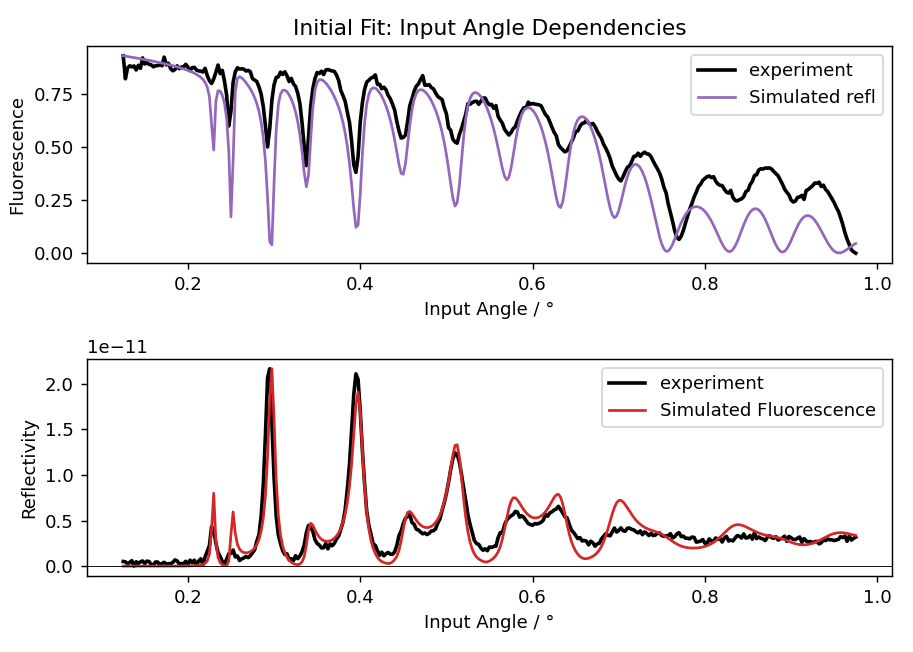

In [7]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


## Optimization

### Create the logger for following fit parameters and plotting

<IPython.core.display.Javascript object>


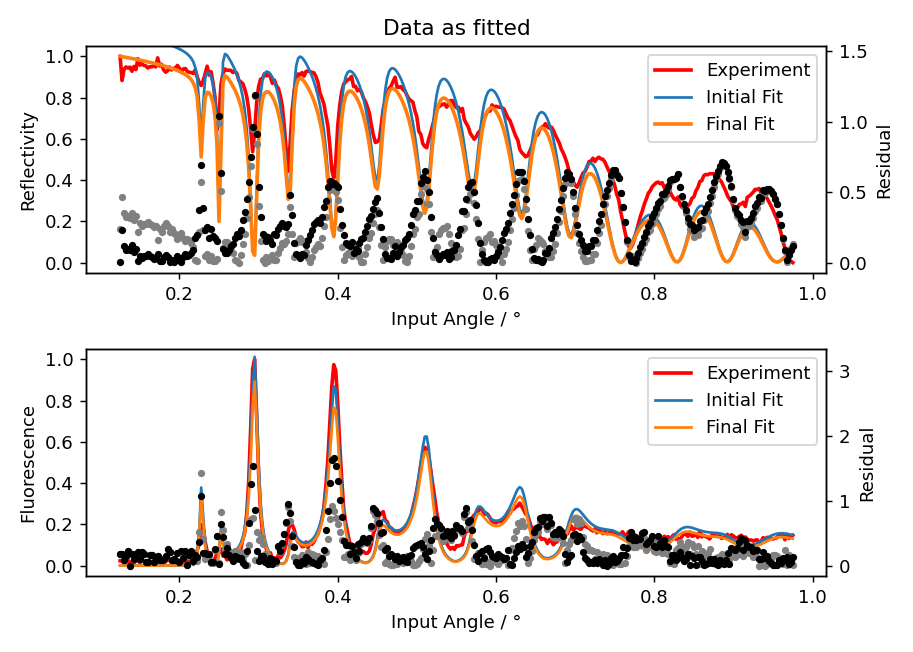

<IPython.core.display.Javascript object>


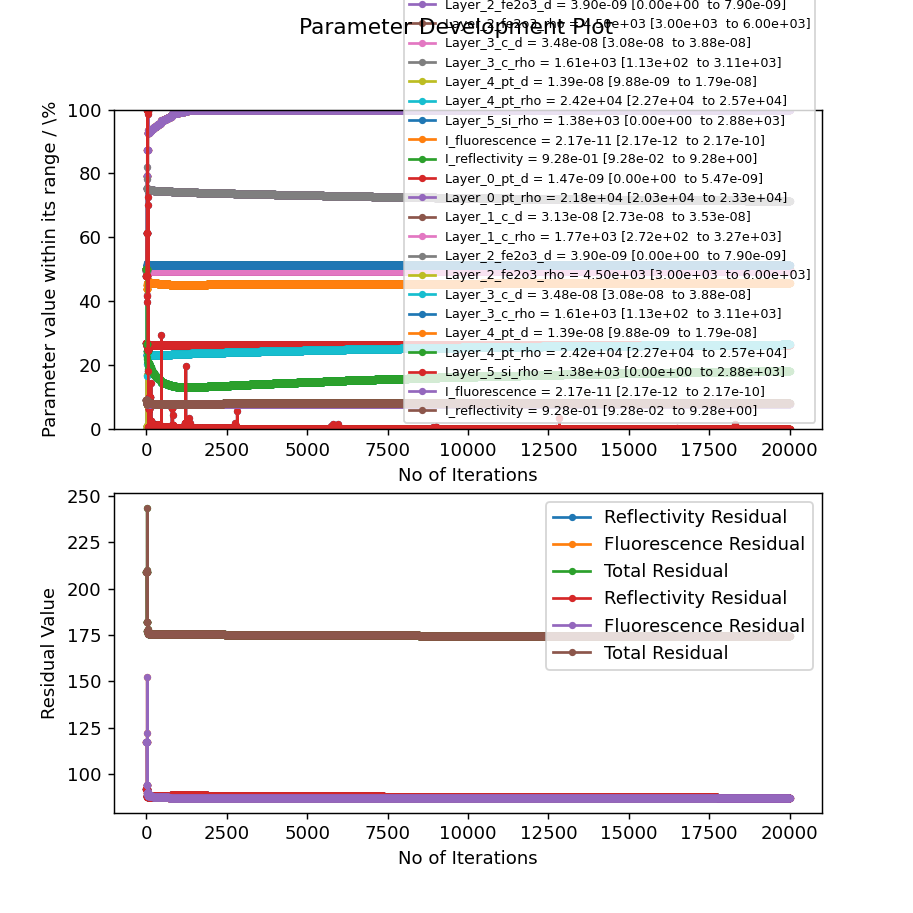

In [8]:
        
logger = xlf.FitLogger(my_problem, parameters,intermediate_plotting = 100, maxiter = 20000)

### Run a minimizer on the cost function

In [9]:
minimizer = lmfit.Minimizer(xlf.cost_function, params=parameters,\
                            fcn_args= (my_problem,),\
                            iter_cb = logger.logging)#xlf.fit_monitoring

result = minimizer.minimize(method = 'leastsq')#

lmfit.report_fit(result)
plt.show()

{'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Iteration -1 complete. Residuals: {'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
{'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Iteration 0 complete. Residuals: {'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
{'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Iteration 1 complete. Residuals: {'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Layer 0 Solution Calculated.
{'Refl': 92.05148968604793, 'Fluor': 117.08509022760148}
Iteration 2 complete. Residuals: {'Refl': 92.05148968604793, 'Fluor': 117.08509022760148}
Layer 0 Solution Calculated.
{'Refl': 92.05148974313289, 'Fluor': 117.08509034245134}
Iteration 3 complete. Residuals: {'Refl': 92.05148974313289, 'Fluor': 117.08509034245134}
{'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Iteration 4 complete. Residuals: {'Refl': 92.05148976059864, 'Fluor': 117.08509032612238}
Layer 1 Solution Calculated.
{'Refl': 92.0514896068161, 'Fl

Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.82627069596488, 'Fluor': 90.44447636714847}
Iteration 45 complete. Residuals: {'Refl': 87.82627069596488, 'Fluor': 90.44447636714847}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.59091932090462, 'Fluor': 88.22851888476524}
Iteration 46 complete. Residuals: {'Refl': 87.59091932090462, 'Fluor': 88.22851888476524}
Layer 0 Solution Calculated.
{'Refl': 87.59091945875494, 'Fluor': 88.22851858346289}
Iteration 47 complete. Residuals: {'Refl': 87.59091945875494, 'Fluor': 88.22851858346289}
Layer 0 Solution Calculated.
{'Refl': 87.59091932152087, 'Fluor': 88.22851886337901}
Iteration 48 complete. Residuals: {'Refl': 87.59091932152087, 'Fluor': 88.22851886337901}
{'Refl': 8

{'Refl': 87.57224504811349, 'Fluor': 88.14202406197231}
Iteration 88 complete. Residuals: {'Refl': 87.57224504811349, 'Fluor': 88.14202406197231}
{'Refl': 87.57224503323805, 'Fluor': 88.14201952298765}
Iteration 89 complete. Residuals: {'Refl': 87.57224503323805, 'Fluor': 88.14201952298765}
{'Refl': 87.5722426217126, 'Fluor': 88.14202406317038}
Iteration 90 complete. Residuals: {'Refl': 87.5722426217126, 'Fluor': 88.14202406317038}
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.61267958654545, 'Fluor': 88.11075607766385}
Iteration 91 complete. Residuals: {'Refl': 87.61267958654545, 'Fluor': 88.11075607766385}
Layer 0 Solution Calculated.
{'Refl': 87.61267971106665, 'Fluor': 88.11075578877112}
Iteration 92 complete. Residuals: {'Refl': 87.61267971106665, 'Fluor': 88.11075578877112}
Layer 0 Solution Calculated.
{'Refl': 87.61267958705447, 'Fluor': 88.

Layer 0 Solution Calculated.
{'Refl': 87.72631967904233, 'Fluor': 87.88718281977602}
Iteration 135 complete. Residuals: {'Refl': 87.72631967904233, 'Fluor': 87.88718281977602}
{'Refl': 87.72631967860598, 'Fluor': 87.88718283986458}
Iteration 136 complete. Residuals: {'Refl': 87.72631967860598, 'Fluor': 87.88718283986458}
Layer 1 Solution Calculated.
{'Refl': 87.72631967182753, 'Fluor': 87.88718307878614}
Iteration 137 complete. Residuals: {'Refl': 87.72631967182753, 'Fluor': 87.88718307878614}
Layer 2 Solution Calculated.
{'Refl': 87.72631991556233, 'Fluor': 87.88718225301827}
Iteration 138 complete. Residuals: {'Refl': 87.72631991556233, 'Fluor': 87.88718225301827}
Layer 2 Solution Calculated.
{'Refl': 87.72631967494655, 'Fluor': 87.8871826822947}
Iteration 139 complete. Residuals: {'Refl': 87.72631967494655, 'Fluor': 87.8871826822947}
Layer 3 Solution Calculated.
{'Refl': 87.72631988273349, 'Fluor': 87.88718155130952}
Iteration 140 complete. Residuals: {'Refl': 87.72631988273349, 'Fl

Layer 2 Solution Calculated.
{'Refl': 87.79809588119909, 'Fluor': 87.79652104596846}
Iteration 181 complete. Residuals: {'Refl': 87.79809588119909, 'Fluor': 87.79652104596846}
Layer 2 Solution Calculated.
{'Refl': 87.79809564119597, 'Fluor': 87.79652148304055}
Iteration 182 complete. Residuals: {'Refl': 87.79809564119597, 'Fluor': 87.79652148304055}
Layer 3 Solution Calculated.
{'Refl': 87.79809584858705, 'Fluor': 87.79652033828887}
Iteration 183 complete. Residuals: {'Refl': 87.79809584858705, 'Fluor': 87.79652033828887}
Layer 3 Solution Calculated.
{'Refl': 87.79809564193945, 'Fluor': 87.79652216973129}
Iteration 184 complete. Residuals: {'Refl': 87.79809564193945, 'Fluor': 87.79652216973129}
Layer 4 Solution Calculated.
{'Refl': 87.79809564552423, 'Fluor': 87.79652161342791}
Iteration 185 complete. Residuals: {'Refl': 87.79809564552423, 'Fluor': 87.79652161342791}
Layer 4 Solution Calculated.
{'Refl': 87.79809559048493, 'Fluor': 87.79652171381048}
Iteration 186 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 87.87581375914634, 'Fluor': 87.71398095961945}
Iteration 228 complete. Residuals: {'Refl': 87.87581375914634, 'Fluor': 87.71398095961945}
Layer 5 Solution Calculated.
{'Refl': 87.87581380638474, 'Fluor': 87.71398087271191}
Iteration 229 complete. Residuals: {'Refl': 87.87581380638474, 'Fluor': 87.71398087271191}
{'Refl': 87.87581381363573, 'Fluor': 87.71397634106904}
Iteration 230 complete. Residuals: {'Refl': 87.87581381363573, 'Fluor': 87.71397634106904}
{'Refl': 87.87581150250556, 'Fluor': 87.71398087215206}
Iteration 231 complete. Residuals: {'Refl': 87.87581150250556, 'Fluor': 87.71398087215206}
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.89986281099549, 'Fluor': 87.68982352178242}
Iteration 232 complete. Residuals: {'Refl': 87.89986281099549, 'Fluor': 87.68982352178242}
Layer 0 Solution Calculated.
{'Re

Layer 2 Solution Calculated.
{'Refl': 87.96178016029434, 'Fluor': 87.62304265936181}
Iteration 274 complete. Residuals: {'Refl': 87.96178016029434, 'Fluor': 87.62304265936181}
Layer 0 Solution Calculated.
{'Refl': 87.9617802786902, 'Fluor': 87.62304238655048}
Iteration 275 complete. Residuals: {'Refl': 87.9617802786902, 'Fluor': 87.62304238655048}
Layer 0 Solution Calculated.
{'Refl': 87.96178016036174, 'Fluor': 87.62304264032545}
Iteration 276 complete. Residuals: {'Refl': 87.96178016036174, 'Fluor': 87.62304264032545}
{'Refl': 87.96178016029434, 'Fluor': 87.62304265936181}
Iteration 277 complete. Residuals: {'Refl': 87.96178016029434, 'Fluor': 87.62304265936181}
Layer 1 Solution Calculated.
{'Refl': 87.96178015334188, 'Fluor': 87.62304290352432}
Iteration 278 complete. Residuals: {'Refl': 87.96178015334188, 'Fluor': 87.62304290352432}
Layer 2 Solution Calculated.
{'Refl': 87.96178040514323, 'Fluor': 87.62304208736332}
Iteration 279 complete. Residuals: {'Refl': 87.96178040514323, 'Fl

Layer 2 Solution Calculated.
{'Refl': 88.01847258533914, 'Fluor': 87.5653847210231}
Iteration 321 complete. Residuals: {'Refl': 88.01847258533914, 'Fluor': 87.5653847210231}
Layer 2 Solution Calculated.
{'Refl': 88.01847233841738, 'Fluor': 87.56538518459678}
Iteration 322 complete. Residuals: {'Refl': 88.01847233841738, 'Fluor': 87.56538518459678}
Layer 3 Solution Calculated.
{'Refl': 88.01847255406706, 'Fluor': 87.56538399880046}
Iteration 323 complete. Residuals: {'Refl': 88.01847255406706, 'Fluor': 87.56538399880046}
Layer 3 Solution Calculated.
{'Refl': 88.01847233792843, 'Fluor': 87.56538584308429}
Iteration 324 complete. Residuals: {'Refl': 88.01847233792843, 'Fluor': 87.56538584308429}
Layer 4 Solution Calculated.
{'Refl': 88.01847234183174, 'Fluor': 87.56538527530745}
Iteration 325 complete. Residuals: {'Refl': 88.01847234183174, 'Fluor': 87.56538527530745}
Layer 4 Solution Calculated.
{'Refl': 88.01847228445183, 'Fluor': 87.56538537929976}
Iteration 326 complete. Residuals: {'

Layer 4 Solution Calculated.
{'Refl': 88.06809175335235, 'Fluor': 87.51509243970357}
Iteration 368 complete. Residuals: {'Refl': 88.06809175335235, 'Fluor': 87.51509243970357}
Layer 5 Solution Calculated.
{'Refl': 88.06809180223303, 'Fluor': 87.51509235052231}
Iteration 369 complete. Residuals: {'Refl': 88.06809180223303, 'Fluor': 87.51509235052231}
{'Refl': 88.0680918098185, 'Fluor': 87.51508782084305}
Iteration 370 complete. Residuals: {'Refl': 88.0680918098185, 'Fluor': 87.51508782084305}
{'Refl': 88.06808946590219, 'Fluor': 87.51509234991171}
Iteration 371 complete. Residuals: {'Refl': 88.06808946590219, 'Fluor': 87.51509234991171}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.08323259186176, 'Fluor': 87.49969015307991}
Iteration 372 complete. Residuals: {'Refl': 88.08323259186176, 'Fluor': 87.49969015307991}
Layer 0 Solution Calculated.
{'Refl

Layer 2 Solution Calculated.
{'Refl': 88.11463827487745, 'Fluor': 87.45957835667856}
Iteration 414 complete. Residuals: {'Refl': 88.11463827487745, 'Fluor': 87.45957835667856}
Layer 0 Solution Calculated.
{'Refl': 88.11463840011783, 'Fluor': 87.45957808801771}
Iteration 415 complete. Residuals: {'Refl': 88.11463840011783, 'Fluor': 87.45957808801771}
Layer 0 Solution Calculated.
{'Refl': 88.11463827525877, 'Fluor': 87.45957833873551}
Iteration 416 complete. Residuals: {'Refl': 88.11463827525877, 'Fluor': 87.45957833873551}
{'Refl': 88.11463827487745, 'Fluor': 87.45957835667856}
Iteration 417 complete. Residuals: {'Refl': 88.11463827487745, 'Fluor': 87.45957835667856}
Layer 1 Solution Calculated.
{'Refl': 88.11463826813355, 'Fluor': 87.45957860448405}
Iteration 418 complete. Residuals: {'Refl': 88.11463826813355, 'Fluor': 87.45957860448405}
Layer 2 Solution Calculated.
{'Refl': 88.11463851670925, 'Fluor': 87.45957779275057}
Iteration 419 complete. Residuals: {'Refl': 88.11463851670925, '

Layer 2 Solution Calculated.
{'Refl': 88.18654046638747, 'Fluor': 87.37564079608408}
Iteration 461 complete. Residuals: {'Refl': 88.18654046638747, 'Fluor': 87.37564079608408}
Layer 2 Solution Calculated.
{'Refl': 88.18654022342335, 'Fluor': 87.37564128564466}
Iteration 462 complete. Residuals: {'Refl': 88.18654022342335, 'Fluor': 87.37564128564466}
Layer 3 Solution Calculated.
{'Refl': 88.18654043527621, 'Fluor': 87.37564006119942}
Iteration 463 complete. Residuals: {'Refl': 88.18654043527621, 'Fluor': 87.37564006119942}
Layer 3 Solution Calculated.
{'Refl': 88.18654022277832, 'Fluor': 87.37564191861712}
Iteration 464 complete. Residuals: {'Refl': 88.18654022277832, 'Fluor': 87.37564191861712}
Layer 4 Solution Calculated.
{'Refl': 88.18654022613018, 'Fluor': 87.37564133928592}
Iteration 465 complete. Residuals: {'Refl': 88.18654022613018, 'Fluor': 87.37564133928592}
Layer 4 Solution Calculated.
{'Refl': 88.18654016814105, 'Fluor': 87.37564144592042}
Iteration 466 complete. Residuals: 

Layer 3 Solution Calculated.
{'Refl': 88.2171937749298, 'Fluor': 87.34526504560041}
Iteration 507 complete. Residuals: {'Refl': 88.2171937749298, 'Fluor': 87.34526504560041}
Layer 4 Solution Calculated.
{'Refl': 88.21719377829106, 'Fluor': 87.34526446408773}
Iteration 508 complete. Residuals: {'Refl': 88.21719377829106, 'Fluor': 87.34526446408773}
Layer 4 Solution Calculated.
{'Refl': 88.21719372021187, 'Fluor': 87.34526457113805}
Iteration 509 complete. Residuals: {'Refl': 88.21719372021187, 'Fluor': 87.34526457113805}
Layer 5 Solution Calculated.
{'Refl': 88.21719377196752, 'Fluor': 87.34526448021646}
Iteration 510 complete. Residuals: {'Refl': 88.21719377196752, 'Fluor': 87.34526448021646}
{'Refl': 88.2171937771917, 'Fluor': 87.34525995136862}
Iteration 511 complete. Residuals: {'Refl': 88.2171937771917, 'Fluor': 87.34525995136862}
{'Refl': 88.21719142629549, 'Fluor': 87.34526447977439}
Iteration 512 complete. Residuals: {'Refl': 88.21719142629549, 'Fluor': 87.34526447977439}
Layer 

{'Refl': 88.24081505424874, 'Fluor': 87.3178314044335}
Iteration 554 complete. Residuals: {'Refl': 88.24081505424874, 'Fluor': 87.3178314044335}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.24802347915502, 'Fluor': 87.3093477992795}
Iteration 555 complete. Residuals: {'Refl': 88.24802347915502, 'Fluor': 87.3093477992795}
Layer 0 Solution Calculated.
{'Refl': 88.24802360288953, 'Fluor': 87.30934753446127}
Iteration 556 complete. Residuals: {'Refl': 88.24802360288953, 'Fluor': 87.30934753446127}
Layer 0 Solution Calculated.
{'Refl': 88.24802347944507, 'Fluor': 87.30934778320929}
Iteration 557 complete. Residuals: {'Refl': 88.24802347944507, 'Fluor': 87.30934778320929}
{'Refl': 88.24802347915502, 'Fluor': 87.3093477992795}
Iteration 558 complete. Residuals: {'Refl': 88.24802347915502, 'Fluor': 87.3093477992795}
Layer 1 Solution Calculated.
{'Refl': 8

Layer 1 Solution Calculated.
{'Refl': 88.26875602457775, 'Fluor': 87.28561836126505}
Iteration 601 complete. Residuals: {'Refl': 88.26875602457775, 'Fluor': 87.28561836126505}
Layer 2 Solution Calculated.
{'Refl': 88.26875626195078, 'Fluor': 87.28561755470946}
Iteration 602 complete. Residuals: {'Refl': 88.26875626195078, 'Fluor': 87.28561755470946}
Layer 2 Solution Calculated.
{'Refl': 88.26875603007507, 'Fluor': 87.28561805772658}
Iteration 603 complete. Residuals: {'Refl': 88.26875603007507, 'Fluor': 87.28561805772658}
Layer 3 Solution Calculated.
{'Refl': 88.2687562301038, 'Fluor': 87.28561681365781}
Iteration 604 complete. Residuals: {'Refl': 88.2687562301038, 'Fluor': 87.28561681365781}
Layer 3 Solution Calculated.
{'Refl': 88.26875602927092, 'Fluor': 87.28561867849615}
Iteration 605 complete. Residuals: {'Refl': 88.26875602927092, 'Fluor': 87.28561867849615}
Layer 4 Solution Calculated.
{'Refl': 88.26875603280868, 'Fluor': 87.2856180925234}
Iteration 606 complete. Residuals: {'R

Layer 3 Solution Calculated.
{'Refl': 88.2873248919027, 'Fluor': 87.26418531949116}
Iteration 647 complete. Residuals: {'Refl': 88.2873248919027, 'Fluor': 87.26418531949116}
Layer 4 Solution Calculated.
{'Refl': 88.28732489550467, 'Fluor': 87.2641847317145}
Iteration 648 complete. Residuals: {'Refl': 88.28732489550467, 'Fluor': 87.2641847317145}
Layer 4 Solution Calculated.
{'Refl': 88.28732483053375, 'Fluor': 87.26418483970818}
Iteration 649 complete. Residuals: {'Refl': 88.28732483053375, 'Fluor': 87.26418483970818}
Layer 5 Solution Calculated.
{'Refl': 88.28732488784075, 'Fluor': 87.26418474819494}
Iteration 650 complete. Residuals: {'Refl': 88.28732488784075, 'Fluor': 87.26418474819494}
{'Refl': 88.28732489355826, 'Fluor': 87.26418021904098}
Iteration 651 complete. Residuals: {'Refl': 88.28732489355826, 'Fluor': 87.26418021904098}
{'Refl': 88.28732270151288, 'Fluor': 87.26418474771481}
Iteration 652 complete. Residuals: {'Refl': 88.28732270151288, 'Fluor': 87.26418474771481}
Layer 

{'Refl': 88.30379659073188, 'Fluor': 87.24473716618124}
Iteration 694 complete. Residuals: {'Refl': 88.30379659073188, 'Fluor': 87.24473716618124}
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3087923041553, 'Fluor': 87.23865397242939}
Iteration 695 complete. Residuals: {'Refl': 88.3087923041553, 'Fluor': 87.23865397242939}
Layer 0 Solution Calculated.
{'Refl': 88.30879240545923, 'Fluor': 87.23865370949073}
Iteration 696 complete. Residuals: {'Refl': 88.30879240545923, 'Fluor': 87.23865370949073}
Layer 0 Solution Calculated.
{'Refl': 88.3087923039242, 'Fluor': 87.23865395777928}
Iteration 697 complete. Residuals: {'Refl': 88.3087923039242, 'Fluor': 87.23865395777928}
{'Refl': 88.3087923041553, 'Fluor': 87.23865397242939}
Iteration 698 complete. Residuals: {'Refl': 88.3087923041553, 'Fluor': 87.23865397242939}
Layer 1 Solution Calculated.
{'Refl': 8

{'Refl': 88.31829641489904, 'Fluor': 87.22213089076524}
Iteration 739 complete. Residuals: {'Refl': 88.31829641489904, 'Fluor': 87.22213089076524}
{'Refl': 88.3182964151289, 'Fluor': 87.22213090467358}
Iteration 740 complete. Residuals: {'Refl': 88.3182964151289, 'Fluor': 87.22213090467358}
Layer 1 Solution Calculated.
{'Refl': 88.31829640856492, 'Fluor': 87.22213114908317}
Iteration 741 complete. Residuals: {'Refl': 88.31829640856492, 'Fluor': 87.22213114908317}
Layer 2 Solution Calculated.
{'Refl': 88.31829663163712, 'Fluor': 87.2221303643614}
Iteration 742 complete. Residuals: {'Refl': 88.31829663163712, 'Fluor': 87.2221303643614}
Layer 2 Solution Calculated.
{'Refl': 88.31829641420691, 'Fluor': 87.22213086810103}
Iteration 743 complete. Residuals: {'Refl': 88.31829641420691, 'Fluor': 87.22213086810103}
Layer 3 Solution Calculated.
{'Refl': 88.31829659858731, 'Fluor': 87.2221296515248}
Iteration 744 complete. Residuals: {'Refl': 88.31829659858731, 'Fluor': 87.2221296515248}
Layer 3 

Layer 3 Solution Calculated.
{'Refl': 88.34106748800723, 'Fluor': 87.18663011747033}
Iteration 787 complete. Residuals: {'Refl': 88.34106748800723, 'Fluor': 87.18663011747033}
Layer 4 Solution Calculated.
{'Refl': 88.34106749164212, 'Fluor': 87.18662954746374}
Iteration 788 complete. Residuals: {'Refl': 88.34106749164212, 'Fluor': 87.18662954746374}
Layer 4 Solution Calculated.
{'Refl': 88.34106742653618, 'Fluor': 87.1866296551585}
Iteration 789 complete. Residuals: {'Refl': 88.34106742653618, 'Fluor': 87.1866296551585}
Layer 5 Solution Calculated.
{'Refl': 88.34106748850078, 'Fluor': 87.1866295637509}
Iteration 790 complete. Residuals: {'Refl': 88.34106748850078, 'Fluor': 87.1866295637509}
{'Refl': 88.34106748966823, 'Fluor': 87.18662516888526}
Iteration 791 complete. Residuals: {'Refl': 88.34106748966823, 'Fluor': 87.18662516888526}
{'Refl': 88.34106529517608, 'Fluor': 87.18662956361396}
Iteration 792 complete. Residuals: {'Refl': 88.34106529517608, 'Fluor': 87.18662956361396}
Layer 

Layer 4 Solution Calculated.
{'Refl': 88.35524451830423, 'Fluor': 87.16623278263457}
Iteration 832 complete. Residuals: {'Refl': 88.35524451830423, 'Fluor': 87.16623278263457}
Layer 5 Solution Calculated.
{'Refl': 88.35524458287706, 'Fluor': 87.16623269075592}
Iteration 833 complete. Residuals: {'Refl': 88.35524458287706, 'Fluor': 87.16623269075592}
{'Refl': 88.35524458146196, 'Fluor': 87.16622829502109}
Iteration 834 complete. Residuals: {'Refl': 88.35524458146196, 'Fluor': 87.16622829502109}
{'Refl': 88.35524238639366, 'Fluor': 87.16623269092253}
Iteration 835 complete. Residuals: {'Refl': 88.35524238639366, 'Fluor': 87.16623269092253}
Layer 1 Solution Calculated.Layer 4 Solution Calculated.

Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.36030866111436, 'Fluor': 87.15189499515833}
Iteration 836 complete. Residuals: {'Refl': 88.36030866111436, 'Fluor': 87.15189499515833}
Layer 0 Solution Calculated.
{'Re

Layer 2 Solution Calculated.
{'Refl': 88.36711225132674, 'Fluor': 87.1406911616923}
Iteration 878 complete. Residuals: {'Refl': 88.36711225132674, 'Fluor': 87.1406911616923}
Layer 0 Solution Calculated.
{'Refl': 88.3671123516578, 'Fluor': 87.14069091547755}
Iteration 879 complete. Residuals: {'Refl': 88.3671123516578, 'Fluor': 87.14069091547755}
Layer 0 Solution Calculated.
{'Refl': 88.36711225112688, 'Fluor': 87.14069115083893}
Iteration 880 complete. Residuals: {'Refl': 88.36711225112688, 'Fluor': 87.14069115083893}
{'Refl': 88.36711225132674, 'Fluor': 87.1406911616923}
Iteration 881 complete. Residuals: {'Refl': 88.36711225132674, 'Fluor': 87.1406911616923}
Layer 1 Solution Calculated.
{'Refl': 88.36711224471321, 'Fluor': 87.14069140975015}
Iteration 882 complete. Residuals: {'Refl': 88.36711224471321, 'Fluor': 87.14069140975015}
Layer 2 Solution Calculated.
{'Refl': 88.3671124668763, 'Fluor': 87.1406906286766}
Iteration 883 complete. Residuals: {'Refl': 88.3671124668763, 'Fluor': 8

Layer 2 Solution Calculated.
{'Refl': 88.37153148280939, 'Fluor': 87.1312277894046}
Iteration 925 complete. Residuals: {'Refl': 88.37153148280939, 'Fluor': 87.1312277894046}
Layer 2 Solution Calculated.
{'Refl': 88.37153126696188, 'Fluor': 87.13122830403877}
Iteration 926 complete. Residuals: {'Refl': 88.37153126696188, 'Fluor': 87.13122830403877}
Layer 3 Solution Calculated.
{'Refl': 88.37153144995675, 'Fluor': 87.13122706837488}
Iteration 927 complete. Residuals: {'Refl': 88.37153144995675, 'Fluor': 87.13122706837488}
Layer 3 Solution Calculated.
{'Refl': 88.37153126573341, 'Fluor': 87.13122888248819}
Iteration 928 complete. Residuals: {'Refl': 88.37153126573341, 'Fluor': 87.13122888248819}
Layer 4 Solution Calculated.
{'Refl': 88.37153126938425, 'Fluor': 87.13122830533914}
Iteration 929 complete. Residuals: {'Refl': 88.37153126938425, 'Fluor': 87.13122830533914}
Layer 4 Solution Calculated.
{'Refl': 88.37153120422371, 'Fluor': 87.13122841344418}
Iteration 930 complete. Residuals: {'

Layer 4 Solution Calculated.
{'Refl': 88.37499929946785, 'Fluor': 87.12259661702407}
Iteration 972 complete. Residuals: {'Refl': 88.37499929946785, 'Fluor': 87.12259661702407}
Layer 5 Solution Calculated.
{'Refl': 88.37499936713048, 'Fluor': 87.12259652461829}
Iteration 973 complete. Residuals: {'Refl': 88.37499936713048, 'Fluor': 87.12259652461829}
{'Refl': 88.37499936264746, 'Fluor': 87.12259212946537}
Iteration 974 complete. Residuals: {'Refl': 88.37499936264746, 'Fluor': 87.12259212946537}
{'Refl': 88.37499716672724, 'Fluor': 87.12259652514298}
Iteration 975 complete. Residuals: {'Refl': 88.37499716672724, 'Fluor': 87.12259652514298}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3759698579218, 'Fluor': 87.11987982844164}
Iteration 976 complete. Residuals: {'Refl': 88.3759698579218, 'Fluor': 87.11987982844164}
Layer 0 Solution Calculated.
{'Refl

Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.37838730907349, 'Fluor': 87.11214461790749}
Iteration 1018 complete. Residuals: {'Refl': 88.37838730907349, 'Fluor': 87.11214461790749}
Layer 0 Solution Calculated.
{'Refl': 88.37838740911482, 'Fluor': 87.11214437277516}
Iteration 1019 complete. Residuals: {'Refl': 88.37838740911482, 'Fluor': 87.11214437277516}
Layer 0 Solution Calculated.
{'Refl': 88.37838730889256, 'Fluor': 87.11214460840661}
Iteration 1020 complete. Residuals: {'Refl': 88.37838730889256, 'Fluor': 87.11214460840661}
{'Refl': 88.37838730907349, 'Fluor': 87.11214461790749}
Iteration 1021 complete. Residuals: {'Refl': 88.37838730907349, 'Fluor': 87.11214461790749}
Layer 1 Solution Calculated.
{'Refl': 88.37838730244289, 'Fluor': 87.1121448673005}
Iteration 1022 complete. Residuals: {'Refl': 88.37838730244289, 'Fluor': 87.1121448673005}
L

Layer 2 Solution Calculated.
{'Refl': 88.38012265783004, 'Fluor': 87.10497432197178}
Iteration 1065 complete. Residuals: {'Refl': 88.38012265783004, 'Fluor': 87.10497432197178}
Layer 2 Solution Calculated.
{'Refl': 88.38012244253545, 'Fluor': 87.10497483829633}
Iteration 1066 complete. Residuals: {'Refl': 88.38012244253545, 'Fluor': 87.10497483829633}
Layer 3 Solution Calculated.
{'Refl': 88.38012262504037, 'Fluor': 87.10497359859119}
Iteration 1067 complete. Residuals: {'Refl': 88.38012262504037, 'Fluor': 87.10497359859119}
Layer 3 Solution Calculated.
{'Refl': 88.38012244119491, 'Fluor': 87.10497541599891}
Iteration 1068 complete. Residuals: {'Refl': 88.38012244119491, 'Fluor': 87.10497541599891}
Layer 4 Solution Calculated.
{'Refl': 88.38012244485006, 'Fluor': 87.10497483517868}
Iteration 1069 complete. Residuals: {'Refl': 88.38012244485006, 'Fluor': 87.10497483517868}
Layer 4 Solution Calculated.
{'Refl': 88.38012237967777, 'Fluor': 87.10497494342408}
Iteration 1070 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 88.38125269136867, 'Fluor': 87.09831722582176}
Iteration 1112 complete. Residuals: {'Refl': 88.38125269136867, 'Fluor': 87.09831722582176}
Layer 5 Solution Calculated.
{'Refl': 88.38125275923518, 'Fluor': 87.0983171332957}
Iteration 1113 complete. Residuals: {'Refl': 88.38125275923518, 'Fluor': 87.0983171332957}
{'Refl': 88.38125275455442, 'Fluor': 87.09831273806034}
Iteration 1114 complete. Residuals: {'Refl': 88.38125275455442, 'Fluor': 87.09831273806034}
{'Refl': 88.3812505584115, 'Fluor': 87.09831713384202}
Iteration 1115 complete. Residuals: {'Refl': 88.3812505584115, 'Fluor': 87.09831713384202}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.38150521332203, 'Fluor': 87.09619649246908}
Iteration 1116 complete. Residuals: {'Refl': 88.38150521332203, 'Fluor': 87.09619649246908}
Layer 0 Solution Calculated.
{'R

Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3805323058821, 'Fluor': 87.08980994519914}
Iteration 1158 complete. Residuals: {'Refl': 88.3805323058821, 'Fluor': 87.08980994519914}
Layer 0 Solution Calculated.
{'Refl': 88.38053240572708, 'Fluor': 87.08980970106197}
Iteration 1159 complete. Residuals: {'Refl': 88.38053240572708, 'Fluor': 87.08980970106197}
Layer 0 Solution Calculated.
{'Refl': 88.3805323057209, 'Fluor': 87.08980993691017}
Iteration 1160 complete. Residuals: {'Refl': 88.3805323057209, 'Fluor': 87.08980993691017}
{'Refl': 88.3805323058821, 'Fluor': 87.08980994519914}
Iteration 1161 complete. Residuals: {'Refl': 88.3805323058821, 'Fluor': 87.08980994519914}
Layer 1 Solution Calculated.
{'Refl': 88.38053229923864, 'Fluor': 87.08981019568489}
Iteration 1162 complete. Residuals: {'Refl': 88.38053229923864, 'Fluor': 87.08981019568489}
Layer

Layer 1 Solution Calculated.
{'Refl': 88.37949612094963, 'Fluor': 87.07524664921634}
Iteration 1204 complete. Residuals: {'Refl': 88.37949612094963, 'Fluor': 87.07524664921634}
Layer 2 Solution Calculated.
{'Refl': 88.37949634200142, 'Fluor': 87.07524587187038}
Iteration 1205 complete. Residuals: {'Refl': 88.37949634200142, 'Fluor': 87.07524587187038}
Layer 2 Solution Calculated.
{'Refl': 88.37949612737944, 'Fluor': 87.07524638907195}
Iteration 1206 complete. Residuals: {'Refl': 88.37949612737944, 'Fluor': 87.07524638907195}
Layer 3 Solution Calculated.
{'Refl': 88.37949630928202, 'Fluor': 87.07524514589676}
Iteration 1207 complete. Residuals: {'Refl': 88.37949630928202, 'Fluor': 87.07524514589676}
Layer 3 Solution Calculated.
{'Refl': 88.3794961259322, 'Fluor': 87.07524696698039}
Iteration 1208 complete. Residuals: {'Refl': 88.3794961259322, 'Fluor': 87.07524696698039}
Layer 4 Solution Calculated.
{'Refl': 88.3794961295894, 'Fluor': 87.07524638173044}
Iteration 1209 complete. Residual

Layer 2 Solution Calculated.
{'Refl': 88.37429680778612, 'Fluor': 87.06139681706944}
Iteration 1249 complete. Residuals: {'Refl': 88.37429680778612, 'Fluor': 87.06139681706944}
Layer 3 Solution Calculated.
{'Refl': 88.37429698929485, 'Fluor': 87.06139557232913}
Iteration 1250 complete. Residuals: {'Refl': 88.37429698929485, 'Fluor': 87.06139557232913}
Layer 3 Solution Calculated.
{'Refl': 88.37429680627719, 'Fluor': 87.06139739555145}
Iteration 1251 complete. Residuals: {'Refl': 88.37429680627719, 'Fluor': 87.06139739555145}
Layer 4 Solution Calculated.
{'Refl': 88.37429680993316, 'Fluor': 87.06139680734101}
Iteration 1252 complete. Residuals: {'Refl': 88.37429680993316, 'Fluor': 87.06139680734101}
Layer 4 Solution Calculated.
{'Refl': 88.3742967447688, 'Fluor': 87.06139691569109}
Iteration 1253 complete. Residuals: {'Refl': 88.3742967447688, 'Fluor': 87.06139691569109}
Layer 5 Solution Calculated.
{'Refl': 88.37429681129828, 'Fluor': 87.06139682322707}
Iteration 1254 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.37230589367854, 'Fluor': 87.05664120919809}
Iteration 1295 complete. Residuals: {'Refl': 88.37230589367854, 'Fluor': 87.05664120919809}
Layer 5 Solution Calculated.
{'Refl': 88.37230595718592, 'Fluor': 87.05664111707185}
Iteration 1296 complete. Residuals: {'Refl': 88.37230595718592, 'Fluor': 87.05664111707185}
{'Refl': 88.37230595685455, 'Fluor': 87.05663672196908}
Iteration 1297 complete. Residuals: {'Refl': 88.37230595685455, 'Fluor': 87.05663672196908}
{'Refl': 88.37230376127353, 'Fluor': 87.05664111710983}
Iteration 1298 complete. Residuals: {'Refl': 88.37230376127353, 'Fluor': 87.05664111710983}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3710565192205, 'Fluor': 87.05355153826365}
Iteration 1299 complete. Residuals: {'Refl': 88.3710565192205, 'Fluor': 87.05355153826365}
Layer 0 Solution Calculated.
{

{'Refl': 88.36685350868058, 'Fluor': 87.05034445696687}
Iteration 1341 complete. Residuals: {'Refl': 88.36685350868058, 'Fluor': 87.05034445696687}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.36614423086804, 'Fluor': 87.04651334278407}
Iteration 1342 complete. Residuals: {'Refl': 88.36614423086804, 'Fluor': 87.04651334278407}
Layer 0 Solution Calculated.
{'Refl': 88.36614433039112, 'Fluor': 87.04651310121473}
Iteration 1343 complete. Residuals: {'Refl': 88.36614433039112, 'Fluor': 87.04651310121473}
Layer 0 Solution Calculated.
{'Refl': 88.36614423076283, 'Fluor': 87.0465133375447}
Iteration 1344 complete. Residuals: {'Refl': 88.36614423076283, 'Fluor': 87.0465133375447}
{'Refl': 88.36614423086804, 'Fluor': 87.04651334278407}
Iteration 1345 complete. Residuals: {'Refl': 88.36614423086804, 'Fluor': 87.04651334278407}
Layer 1 Solution Calculated.
{

Layer 2 Solution Calculated.
{'Refl': 88.36365807476594, 'Fluor': 87.04340562027795}
Iteration 1385 complete. Residuals: {'Refl': 88.36365807476594, 'Fluor': 87.04340562027795}
Layer 0 Solution Calculated.
{'Refl': 88.36365817425992, 'Fluor': 87.04340537895169}
Iteration 1386 complete. Residuals: {'Refl': 88.36365817425992, 'Fluor': 87.04340537895169}
Layer 0 Solution Calculated.
{'Refl': 88.36365807466599, 'Fluor': 87.04340561531345}
Iteration 1387 complete. Residuals: {'Refl': 88.36365807466599, 'Fluor': 87.04340561531345}
{'Refl': 88.36365807476594, 'Fluor': 87.04340562027795}
Iteration 1388 complete. Residuals: {'Refl': 88.36365807476594, 'Fluor': 87.04340562027795}
Layer 1 Solution Calculated.
{'Refl': 88.36365806809843, 'Fluor': 87.04340587317853}
Iteration 1389 complete. Residuals: {'Refl': 88.36365806809843, 'Fluor': 87.04340587317853}
Layer 2 Solution Calculated.
{'Refl': 88.36365828823433, 'Fluor': 87.04340509895138}
Iteration 1390 complete. Residuals: {'Refl': 88.36365828823

Layer 2 Solution Calculated.
{'Refl': 88.36086285675607, 'Fluor': 87.04028577659318}
Iteration 1432 complete. Residuals: {'Refl': 88.36086285675607, 'Fluor': 87.04028577659318}
Layer 2 Solution Calculated.
{'Refl': 88.36086264330021, 'Fluor': 87.04028629337189}
Iteration 1433 complete. Residuals: {'Refl': 88.36086264330021, 'Fluor': 87.04028629337189}
Layer 3 Solution Calculated.
{'Refl': 88.3608628241672, 'Fluor': 87.04028504767307}
Iteration 1434 complete. Residuals: {'Refl': 88.3608628241672, 'Fluor': 87.04028504767307}
Layer 3 Solution Calculated.
{'Refl': 88.36086264172668, 'Fluor': 87.04028687370288}
Iteration 1435 complete. Residuals: {'Refl': 88.36086264172668, 'Fluor': 87.04028687370288}
Layer 4 Solution Calculated.
{'Refl': 88.36086264537809, 'Fluor': 87.04028628118297}
Iteration 1436 complete. Residuals: {'Refl': 88.36086264537809, 'Fluor': 87.04028628118297}
Layer 4 Solution Calculated.
{'Refl': 88.36086258023424, 'Fluor': 87.04028638949985}
Iteration 1437 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.35786427624024, 'Fluor': 87.03732982381646}
Iteration 1479 complete. Residuals: {'Refl': 88.35786427624024, 'Fluor': 87.03732982381646}
Layer 5 Solution Calculated.
{'Refl': 88.35786433602415, 'Fluor': 87.03732973210126}
Iteration 1480 complete. Residuals: {'Refl': 88.35786433602415, 'Fluor': 87.03732973210126}
{'Refl': 88.35786433940243, 'Fluor': 87.03732533746285}
Iteration 1481 complete. Residuals: {'Refl': 88.35786433940243, 'Fluor': 87.03732533746285}
{'Refl': 88.35786214461119, 'Fluor': 87.03732973171375}
Iteration 1482 complete. Residuals: {'Refl': 88.35786214461119, 'Fluor': 87.03732973171375}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.35682470325085, 'Fluor': 87.03638350499313}
Iteration 1483 complete. Residuals: {'Refl': 88.35682470325085, 'Fluor': 87.03638350499313}
Layer 0 Solution Calculated.

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.35351539336352, 'Fluor': 87.03320854056508}
Iteration 1525 complete. Residuals: {'Refl': 88.35351539336352, 'Fluor': 87.03320854056508}
Layer 0 Solution Calculated.
{'Refl': 88.35351549279441, 'Fluor': 87.03320830003119}
Iteration 1526 complete. Residuals: {'Refl': 88.35351549279441, 'Fluor': 87.03320830003119}
Layer 0 Solution Calculated.
{'Refl': 88.35351539327898, 'Fluor': 87.03320853638715}
Iteration 1527 complete. Residuals: {'Refl': 88.35351539327898, 'Fluor': 87.03320853638715}
{'Refl': 88.35351539336352, 'Fluor': 87.03320854056508}
Iteration 1528 complete. Residuals: {'Refl': 88.35351539336352, 'Fluor': 87.03320854056508}
Layer 1 Solution Calculated.
{'Refl': 88.3535153866933, 'Fluor': 87.03320879393642}
Iteration 1529 complete. Residuals: {'Refl': 88.3535153866933, 'Fluor': 87.03320879393642}
L

Layer 2 Solution Calculated.
{'Refl': 88.35020226161473, 'Fluor': 87.03064708932763}
Iteration 1572 complete. Residuals: {'Refl': 88.35020226161473, 'Fluor': 87.03064708932763}
Layer 2 Solution Calculated.
{'Refl': 88.35020204854337, 'Fluor': 87.03064760537055}
Iteration 1573 complete. Residuals: {'Refl': 88.35020204854337, 'Fluor': 87.03064760537055}
Layer 3 Solution Calculated.
{'Refl': 88.35020222907141, 'Fluor': 87.03064635975674}
Iteration 1574 complete. Residuals: {'Refl': 88.35020222907141, 'Fluor': 87.03064635975674}
Layer 3 Solution Calculated.
{'Refl': 88.35020204694412, 'Fluor': 87.03064818705494}
Iteration 1575 complete. Residuals: {'Refl': 88.35020204694412, 'Fluor': 87.03064818705494}
Layer 4 Solution Calculated.
{'Refl': 88.35020205059264, 'Fluor': 87.0306475922427}
Iteration 1576 complete. Residuals: {'Refl': 88.35020205059264, 'Fluor': 87.0306475922427}
Layer 4 Solution Calculated.
{'Refl': 88.35020198546337, 'Fluor': 87.03064770051634}
Iteration 1577 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.34663115676398, 'Fluor': 87.02778036940114}
Iteration 1619 complete. Residuals: {'Refl': 88.34663115676398, 'Fluor': 87.02778036940114}
Layer 5 Solution Calculated.
{'Refl': 88.34663121670857, 'Fluor': 87.02778027767147}
Iteration 1620 complete. Residuals: {'Refl': 88.34663121670857, 'Fluor': 87.02778027767147}
{'Refl': 88.34663121991548, 'Fluor': 87.02777588379433}
Iteration 1621 complete. Residuals: {'Refl': 88.34663121991548, 'Fluor': 87.02777588379433}
{'Refl': 88.34662902570992, 'Fluor': 87.02778027730447}
Iteration 1622 complete. Residuals: {'Refl': 88.34662902570992, 'Fluor': 87.02778027730447}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.34545320976846, 'Fluor': 87.02702218301991}
Iteration 1623 complete. Residuals: {'Refl': 88.34545320976846, 'Fluor': 87.02702218301991}
Layer 0 Solution Calculated.

Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.34171724384754, 'Fluor': 87.02441117479196}
Iteration 1665 complete. Residuals: {'Refl': 88.34171724384754, 'Fluor': 87.02441117479196}
Layer 0 Solution Calculated.
{'Refl': 88.34171734323601, 'Fluor': 87.02441093504032}
Iteration 1666 complete. Residuals: {'Refl': 88.34171734323601, 'Fluor': 87.02441093504032}
Layer 0 Solution Calculated.
{'Refl': 88.34171724377651, 'Fluor': 87.0244111712934}
Iteration 1667 complete. Residuals: {'Refl': 88.34171724377651, 'Fluor': 87.0244111712934}
{'Refl': 88.34171724384754, 'Fluor': 87.02441117479196}
Iteration 1668 complete. Residuals: {'Refl': 88.34171724384754, 'Fluor': 87.02441117479196}
Layer 1 Solution Calculated.
{'Refl': 88.34171723717631, 'Fluor': 87.02441142852521}
Iteration 1669 complete. Residuals: {'Refl': 88.34171723717631, 'Fluor': 87.02441142852521}
L

Layer 2 Solution Calculated.
{'Refl': 88.33802363372412, 'Fluor': 87.02229930765023}
Iteration 1712 complete. Residuals: {'Refl': 88.33802363372412, 'Fluor': 87.02229930765023}
Layer 2 Solution Calculated.
{'Refl': 88.33802342101703, 'Fluor': 87.02229982281119}
Iteration 1713 complete. Residuals: {'Refl': 88.33802342101703, 'Fluor': 87.02229982281119}
Layer 3 Solution Calculated.
{'Refl': 88.33802360122623, 'Fluor': 87.02229857759323}
Iteration 1714 complete. Residuals: {'Refl': 88.33802360122623, 'Fluor': 87.02229857759323}
Layer 3 Solution Calculated.
{'Refl': 88.33802341939779, 'Fluor': 87.02230040593014}
Iteration 1715 complete. Residuals: {'Refl': 88.33802341939779, 'Fluor': 87.02230040593014}
Layer 4 Solution Calculated.
{'Refl': 88.33802342304355, 'Fluor': 87.02229980898662}
Iteration 1716 complete. Residuals: {'Refl': 88.33802342304355, 'Fluor': 87.02229980898662}
Layer 4 Solution Calculated.
{'Refl': 88.33802335793038, 'Fluor': 87.02229991720745}
Iteration 1717 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 88.33410468742254, 'Fluor': 87.01973900603316}
Iteration 1759 complete. Residuals: {'Refl': 88.33410468742254, 'Fluor': 87.01973900603316}
Layer 5 Solution Calculated.
{'Refl': 88.33410474724442, 'Fluor': 87.01973891433094}
Iteration 1760 complete. Residuals: {'Refl': 88.33410474724442, 'Fluor': 87.01973891433094}
{'Refl': 88.33410475056213, 'Fluor': 87.01973452128493}
Iteration 1761 complete. Residuals: {'Refl': 88.33410475056213, 'Fluor': 87.01973452128493}
{'Refl': 88.33410255700196, 'Fluor': 87.01973891395288}
Iteration 1762 complete. Residuals: {'Refl': 88.33410255700196, 'Fluor': 87.01973891395288}
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3328282924378, 'Fluor': 87.0191475645003}
Iteration 1763 complete. Residuals: {'Refl': 88.3328282924378, 'Fluor': 87.0191475645003}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.32880344606944, 'Fluor': 87.01680450053144}
Iteration 1805 complete. Residuals: {'Refl': 88.32880344606944, 'Fluor': 87.01680450053144}
Layer 0 Solution Calculated.
{'Refl': 88.32880354543032, 'Fluor': 87.01680426154087}
Iteration 1806 complete. Residuals: {'Refl': 88.32880354543032, 'Fluor': 87.01680426154087}
Layer 0 Solution Calculated.
{'Refl': 88.32880344601013, 'Fluor': 87.01680449761406}
Iteration 1807 complete. Residuals: {'Refl': 88.32880344601013, 'Fluor': 87.01680449761406}
{'Refl': 88.32880344606944, 'Fluor': 87.01680450053144}
Iteration 1808 complete. Residuals: {'Refl': 88.32880344606944, 'Fluor': 87.01680450053144}
Layer 1 Solution Calculated.
{'Refl': 88.328803439399, 'Fluor': 87.01680475452584}
Iteration 1809 complete. Residuals: {'Refl': 88.328803439399, 'Fluor': 87.01680475452584}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.3247152388186, 'Fluor': 87.01467937388534}
Iteration 1852 complete. Residuals: {'Refl': 88.3247152388186, 'Fluor': 87.01467937388534}
Layer 2 Solution Calculated.
{'Refl': 88.32471502645956, 'Fluor': 87.01467988808704}
Iteration 1853 complete. Residuals: {'Refl': 88.32471502645956, 'Fluor': 87.01467988808704}
Layer 3 Solution Calculated.
{'Refl': 88.32471520636506, 'Fluor': 87.01467864347765}
Iteration 1854 complete. Residuals: {'Refl': 88.32471520636506, 'Fluor': 87.01467864347765}
Layer 3 Solution Calculated.
{'Refl': 88.32471502482485, 'Fluor': 87.01468047267255}
Iteration 1855 complete. Residuals: {'Refl': 88.32471502482485, 'Fluor': 87.01468047267255}
Layer 4 Solution Calculated.
{'Refl': 88.3247150284681, 'Fluor': 87.01467987374917}
Iteration 1856 complete. Residuals: {'Refl': 88.3247150284681, 'Fluor': 87.01467987374917}
Layer 4 Solution Calculated.
{'Refl': 88.3247149633724, 'Fluor': 87.01467998191185}
Iteration 1857 complete. Residuals:

Layer 4 Solution Calculated.
{'Refl': 88.32065520206287, 'Fluor': 87.01289378096567}
Iteration 1899 complete. Residuals: {'Refl': 88.32065520206287, 'Fluor': 87.01289378096567}
Layer 5 Solution Calculated.
{'Refl': 88.32065526164632, 'Fluor': 87.0128936893122}
Iteration 1900 complete. Residuals: {'Refl': 88.32065526164632, 'Fluor': 87.0128936893122}
{'Refl': 88.32065526518933, 'Fluor': 87.01288929716705}
Iteration 1901 complete. Residuals: {'Refl': 88.32065526518933, 'Fluor': 87.01288929716705}
{'Refl': 88.32065307231643, 'Fluor': 87.01289368890933}
Iteration 1902 complete. Residuals: {'Refl': 88.32065307231643, 'Fluor': 87.01289368890933}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.3191314215978, 'Fluor': 87.01227806196587}
Iteration 1903 complete. Residuals: {'Refl': 88.3191314215978, 'Fluor': 87.01227806196587}
Layer 0 Solution Calculated.
{'R

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.31506512865985, 'Fluor': 87.01022964385612}
Iteration 1945 complete. Residuals: {'Refl': 88.31506512865985, 'Fluor': 87.01022964385612}
Layer 0 Solution Calculated.
{'Refl': 88.31506522800504, 'Fluor': 87.01022940561062}
Iteration 1946 complete. Residuals: {'Refl': 88.31506522800504, 'Fluor': 87.01022940561062}
Layer 0 Solution Calculated.
{'Refl': 88.31506512861051, 'Fluor': 87.01022964143118}
Iteration 1947 complete. Residuals: {'Refl': 88.31506512861051, 'Fluor': 87.01022964143118}
{'Refl': 88.31506512865985, 'Fluor': 87.01022964385612}
Iteration 1948 complete. Residuals: {'Refl': 88.31506512865985, 'Fluor': 87.01022964385612}
Layer 1 Solution Calculated.
{'Refl': 88.3150651219917, 'Fluor': 87.01022989802343}
Iteration 1949 complete. Residuals: {'Refl': 88.3150651219917, 'Fluor': 87.01022989802343}
L

Layer 1 Solution Calculated.
{'Refl': 88.31078493944673, 'Fluor': 87.00824045239186}
Iteration 1991 complete. Residuals: {'Refl': 88.31078493944673, 'Fluor': 87.00824045239186}
Layer 2 Solution Calculated.
{'Refl': 88.31078515810663, 'Fluor': 87.00823968368911}
Iteration 1992 complete. Residuals: {'Refl': 88.31078515810663, 'Fluor': 87.00823968368911}
Layer 2 Solution Calculated.
{'Refl': 88.31078494608116, 'Fluor': 87.0082401968519}
Iteration 1993 complete. Residuals: {'Refl': 88.31078494608116, 'Fluor': 87.0082401968519}
Layer 3 Solution Calculated.
{'Refl': 88.31078512569886, 'Fluor': 87.00823895303847}
Iteration 1994 complete. Residuals: {'Refl': 88.31078512569886, 'Fluor': 87.00823895303847}
Layer 3 Solution Calculated.
{'Refl': 88.31078494443375, 'Fluor': 87.00824078293009}
Iteration 1995 complete. Residuals: {'Refl': 88.31078494443375, 'Fluor': 87.00824078293009}
Layer 4 Solution Calculated.
{'Refl': 88.3107849480746, 'Fluor': 87.00824018213007}
Iteration 1996 complete. Residual

Layer 3 Solution Calculated.
{'Refl': 88.3063711240417, 'Fluor': 87.006724653758}
Iteration 2037 complete. Residuals: {'Refl': 88.3063711240417, 'Fluor': 87.006724653758}
Layer 4 Solution Calculated.
{'Refl': 88.30637112768207, 'Fluor': 87.00672405242676}
Iteration 2038 complete. Residuals: {'Refl': 88.30637112768207, 'Fluor': 87.00672405242676}
Layer 4 Solution Calculated.
{'Refl': 88.30637106261065, 'Fluor': 87.00672416050494}
Iteration 2039 complete. Residuals: {'Refl': 88.30637106261065, 'Fluor': 87.00672416050494}
Layer 5 Solution Calculated.
{'Refl': 88.3063711227449, 'Fluor': 87.00672406881381}
Iteration 2040 complete. Residuals: {'Refl': 88.3063711227449, 'Fluor': 87.00672406881381}
{'Refl': 88.30637112572262, 'Fluor': 87.00671967773363}
Iteration 2041 complete. Residuals: {'Refl': 88.30637112572262, 'Fluor': 87.00671967773363}
{'Refl': 88.30636893357304, 'Fluor': 87.00672406847588}
Iteration 2042 complete. Residuals: {'Refl': 88.30636893357304, 'Fluor': 87.00672406847588}
Laye

Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.30057070048413, 'Fluor': 87.0043973475919}
Iteration 2085 complete. Residuals: {'Refl': 88.30057070048413, 'Fluor': 87.0043973475919}
Layer 0 Solution Calculated.
{'Refl': 88.30057079982356, 'Fluor': 87.00439711007554}
Iteration 2086 complete. Residuals: {'Refl': 88.30057079982356, 'Fluor': 87.00439711007554}
Layer 0 Solution Calculated.
{'Refl': 88.30057070044313, 'Fluor': 87.00439734557762}
Iteration 2087 complete. Residuals: {'Refl': 88.30057070044313, 'Fluor': 87.00439734557762}
{'Refl': 88.30057070048413, 'Fluor': 87.0043973475919}
Iteration 2088 complete. Residuals: {'Refl': 88.30057070048413, 'Fluor': 87.0043973475919}
Layer 1 Solution Calculated.
{'Refl': 88.30057069381958, 'Fluor': 87.00439760185196}
Iteration 2089 complete. Residuals: {'Refl': 88.30057069381958, 'Fluor': 87.00439760185196}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.29632806310832, 'Fluor': 87.00266528131682}
Iteration 2132 complete. Residuals: {'Refl': 88.29632806310832, 'Fluor': 87.00266528131682}
Layer 2 Solution Calculated.
{'Refl': 88.2963278514039, 'Fluor': 87.00266579338897}
Iteration 2133 complete. Residuals: {'Refl': 88.2963278514039, 'Fluor': 87.00266579338897}
Layer 3 Solution Calculated.
{'Refl': 88.29632803074671, 'Fluor': 87.00266455050493}
Iteration 2134 complete. Residuals: {'Refl': 88.29632803074671, 'Fluor': 87.00266455050493}
Layer 3 Solution Calculated.
{'Refl': 88.29632784974615, 'Fluor': 87.00266638096554}
Iteration 2135 complete. Residuals: {'Refl': 88.29632784974615, 'Fluor': 87.00266638096554}
Layer 4 Solution Calculated.
{'Refl': 88.29632785338484, 'Fluor': 87.00266577838491}
Iteration 2136 complete. Residuals: {'Refl': 88.29632785338484, 'Fluor': 87.00266577838491}
Layer 4 Solution Calculated.
{'Refl': 88.29632778832715, 'Fluor': 87.00266588641108}
Iteration 2137 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.29187162773779, 'Fluor': 87.00089672771523}
Iteration 2179 complete. Residuals: {'Refl': 88.29187162773779, 'Fluor': 87.00089672771523}
Layer 5 Solution Calculated.
{'Refl': 88.29187168741447, 'Fluor': 87.00089663610865}
Iteration 2180 complete. Residuals: {'Refl': 88.29187168741447, 'Fluor': 87.00089663610865}
{'Refl': 88.29187169083484, 'Fluor': 87.00089224606572}
Iteration 2181 complete. Residuals: {'Refl': 88.29187169083484, 'Fluor': 87.00089224606572}
{'Refl': 88.2918694994185, 'Fluor': 87.00089663572126}
Iteration 2182 complete. Residuals: {'Refl': 88.2918694994185, 'Fluor': 87.00089663572126}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.29042118995788, 'Fluor': 87.00054090293463}
Iteration 2183 complete. Residuals: {'Refl': 88.29042118995788, 'Fluor': 87.00054090293463}
Layer 0 Solution Calculated.
{

Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.28592430055433, 'Fluor': 86.99883185039093}
Iteration 2225 complete. Residuals: {'Refl': 88.28592430055433, 'Fluor': 86.99883185039093}
Layer 0 Solution Calculated.
{'Refl': 88.28592439989498, 'Fluor': 86.99883161360906}
Iteration 2226 complete. Residuals: {'Refl': 88.28592439989498, 'Fluor': 86.99883161360906}
Layer 0 Solution Calculated.
{'Refl': 88.28592430052045, 'Fluor': 86.99883184872479}
Iteration 2227 complete. Residuals: {'Refl': 88.28592430052045, 'Fluor': 86.99883184872479}
{'Refl': 88.28592430055433, 'Fluor': 86.99883185039093}
Iteration 2228 complete. Residuals: {'Refl': 88.28592430055433, 'Fluor': 86.99883185039093}
Layer 1 Solution Calculated.
{'Refl': 88.2859242938946, 'Fluor': 86.99883210468326}
Iteration 2229 complete. Residuals: {'Refl': 88.2859242938946, 'Fluor': 86.99883210468326}
L

Layer 2 Solution Calculated.
{'Refl': 88.28138205305945, 'Fluor': 86.9972543300855}
Iteration 2272 complete. Residuals: {'Refl': 88.28138205305945, 'Fluor': 86.9972543300855}
Layer 2 Solution Calculated.
{'Refl': 88.28138184166622, 'Fluor': 86.99725484105127}
Iteration 2273 complete. Residuals: {'Refl': 88.28138184166622, 'Fluor': 86.99725484105127}
Layer 3 Solution Calculated.
{'Refl': 88.281382020743, 'Fluor': 86.99725359916444}
Iteration 2274 complete. Residuals: {'Refl': 88.281382020743, 'Fluor': 86.99725359916444}
Layer 3 Solution Calculated.
{'Refl': 88.28138184000002, 'Fluor': 86.99725543010699}
Iteration 2275 complete. Residuals: {'Refl': 88.28138184000002, 'Fluor': 86.99725543010699}
Layer 4 Solution Calculated.
{'Refl': 88.28138184363698, 'Fluor': 86.99725482584057}
Iteration 2276 complete. Residuals: {'Refl': 88.28138184363698, 'Fluor': 86.99725482584057}
Layer 4 Solution Calculated.
{'Refl': 88.28138177859945, 'Fluor': 86.9972549337977}
Iteration 2277 complete. Residuals: {

Layer 4 Solution Calculated.
{'Refl': 88.27686736054233, 'Fluor': 86.99581464064067}
Iteration 2319 complete. Residuals: {'Refl': 88.27686736054233, 'Fluor': 86.99581464064067}
Layer 5 Solution Calculated.
{'Refl': 88.27686742040626, 'Fluor': 86.99581454904728}
Iteration 2320 complete. Residuals: {'Refl': 88.27686742040626, 'Fluor': 86.99581454904728}
{'Refl': 88.2768674236232, 'Fluor': 86.9958101601411}
Iteration 2321 complete. Residuals: {'Refl': 88.2768674236232, 'Fluor': 86.9958101601411}
{'Refl': 88.27686523296153, 'Fluor': 86.99581454868277}
Iteration 2322 complete. Residuals: {'Refl': 88.27686523296153, 'Fluor': 86.99581454868277}
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.27538674638024, 'Fluor': 86.9953858477557}
Iteration 2323 complete. Residuals: {'Refl': 88.27538674638024, 'Fluor': 86.9953858477557}
Layer 0 Solution Calculated.
{'Ref

Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.27072949093748, 'Fluor': 86.99427165917754}
Iteration 2365 complete. Residuals: {'Refl': 88.27072949093748, 'Fluor': 86.99427165917754}
Layer 0 Solution Calculated.
{'Refl': 88.27072959028666, 'Fluor': 86.99427142311688}
Iteration 2366 complete. Residuals: {'Refl': 88.27072959028666, 'Fluor': 86.99427142311688}
Layer 0 Solution Calculated.
{'Refl': 88.27072949090946, 'Fluor': 86.9942716577979}
Iteration 2367 complete. Residuals: {'Refl': 88.27072949090946, 'Fluor': 86.9942716577979}
{'Refl': 88.27072949093748, 'Fluor': 86.99427165917754}
Iteration 2368 complete. Residuals: {'Refl': 88.27072949093748, 'Fluor': 86.99427165917754}
Layer 1 Solution Calculated.
{'Refl': 88.27072948428373, 'Fluor': 86.99427191344225}
Iteration 2369 complete. Residuals: {'Refl': 88.27072948428373, 'Fluor': 86.99427191344225}
L

Layer 2 Solution Calculated.
{'Refl': 88.26622102481014, 'Fluor': 86.9927632380018}
Iteration 2412 complete. Residuals: {'Refl': 88.26622102481014, 'Fluor': 86.9927632380018}
Layer 2 Solution Calculated.
{'Refl': 88.26622081371731, 'Fluor': 86.99276374783427}
Iteration 2413 complete. Residuals: {'Refl': 88.26622081371731, 'Fluor': 86.99276374783427}
Layer 3 Solution Calculated.
{'Refl': 88.26622099253963, 'Fluor': 86.99276250701845}
Iteration 2414 complete. Residuals: {'Refl': 88.26622099253963, 'Fluor': 86.99276250701845}
Layer 3 Solution Calculated.
{'Refl': 88.26622081204394, 'Fluor': 86.99276433835425}
Iteration 2415 complete. Residuals: {'Refl': 88.26622081204394, 'Fluor': 86.99276433835425}
Layer 4 Solution Calculated.
{'Refl': 88.26622081567939, 'Fluor': 86.99276373247318}
Iteration 2416 complete. Residuals: {'Refl': 88.26622081567939, 'Fluor': 86.99276373247318}
Layer 4 Solution Calculated.
{'Refl': 88.26622075066274, 'Fluor': 86.99276384035869}
Iteration 2417 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.26175496547684, 'Fluor': 86.99141434453156}
Iteration 2459 complete. Residuals: {'Refl': 88.26175496547684, 'Fluor': 86.99141434453156}
Layer 5 Solution Calculated.
{'Refl': 88.26175502503816, 'Fluor': 86.99141425301119}
Iteration 2460 complete. Residuals: {'Refl': 88.26175502503816, 'Fluor': 86.99141425301119}
{'Refl': 88.26175502854099, 'Fluor': 86.99140986521208}
Iteration 2461 complete. Residuals: {'Refl': 88.26175502854099, 'Fluor': 86.99140986521208}
{'Refl': 88.26175283863864, 'Fluor': 86.99141425261442}
Iteration 2462 complete. Residuals: {'Refl': 88.26175283863864, 'Fluor': 86.99141425261442}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.2602462511382, 'Fluor': 86.9911137490835}
Iteration 2463 complete. Residuals: {'Refl': 88.2602462511382, 'Fluor': 86.9911137490835}
Layer 0 Solution Calculated.
{'R

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.25565759779587, 'Fluor': 86.98963914308422}
Iteration 2505 complete. Residuals: {'Refl': 88.25565759779587, 'Fluor': 86.98963914308422}
Layer 0 Solution Calculated.
{'Refl': 88.255657697158, 'Fluor': 86.9896389077559}
Iteration 2506 complete. Residuals: {'Refl': 88.255657697158, 'Fluor': 86.9896389077559}
Layer 0 Solution Calculated.
{'Refl': 88.2556575977728, 'Fluor': 86.98963914194508}
Iteration 2507 complete. Residuals: {'Refl': 88.2556575977728, 'Fluor': 86.98963914194508}
{'Refl': 88.25565759779587, 'Fluor': 86.98963914308422}
Iteration 2508 complete. Residuals: {'Refl': 88.25565759779587, 'Fluor': 86.98963914308422}
Layer 1 Solution Calculated.
{'Refl': 88.25565759114905, 'Fluor': 86.98963939727429}
Iteration 2509 complete. Residuals: {'Refl': 88.25565759114905, 'Fluor': 86.98963939727429}
Layer 2

Layer 2 Solution Calculated.
{'Refl': 88.251022068843, 'Fluor': 86.98830904127823}
Iteration 2552 complete. Residuals: {'Refl': 88.251022068843, 'Fluor': 86.98830904127823}
Layer 2 Solution Calculated.
{'Refl': 88.25102185804356, 'Fluor': 86.98830954994281}
Iteration 2553 complete. Residuals: {'Refl': 88.25102185804356, 'Fluor': 86.98830954994281}
Layer 3 Solution Calculated.
{'Refl': 88.25102203661879, 'Fluor': 86.98830831024898}
Iteration 2554 complete. Residuals: {'Refl': 88.25102203661879, 'Fluor': 86.98830831024898}
Layer 3 Solution Calculated.
{'Refl': 88.25102185636396, 'Fluor': 86.98831014192086}
Iteration 2555 complete. Residuals: {'Refl': 88.25102185636396, 'Fluor': 86.98831014192086}
Layer 4 Solution Calculated.
{'Refl': 88.25102185999793, 'Fluor': 86.98830953447387}
Iteration 2556 complete. Residuals: {'Refl': 88.25102185999793, 'Fluor': 86.98830953447387}
Layer 4 Solution Calculated.
{'Refl': 88.25102179500274, 'Fluor': 86.98830964228489}
Iteration 2557 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 88.24641984828101, 'Fluor': 86.98710942294264}
Iteration 2599 complete. Residuals: {'Refl': 88.24641984828101, 'Fluor': 86.98710942294264}
Layer 5 Solution Calculated.
{'Refl': 88.24641990805634, 'Fluor': 86.9871093314367}
Iteration 2600 complete. Residuals: {'Refl': 88.24641990805634, 'Fluor': 86.9871093314367}
{'Refl': 88.24641991132756, 'Fluor': 86.98710494483588}
Iteration 2601 complete. Residuals: {'Refl': 88.24641991132756, 'Fluor': 86.98710494483588}
{'Refl': 88.24641772219265, 'Fluor': 86.98710933106602}
Iteration 2602 complete. Residuals: {'Refl': 88.24641772219265, 'Fluor': 86.98710933106602}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.2449200831308, 'Fluor': 86.9867740595308}
Iteration 2603 complete. Residuals: {'Refl': 88.2449200831308, 'Fluor': 86.9867740595308}
Layer 0 Solution Calculated.
{'Ref

Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.24028186333192, 'Fluor': 86.98555452211247}
Iteration 2645 complete. Residuals: {'Refl': 88.24028186333192, 'Fluor': 86.98555452211247}
Layer 0 Solution Calculated.
{'Refl': 88.24028196271195, 'Fluor': 86.98555428751531}
Iteration 2646 complete. Residuals: {'Refl': 88.24028196271195, 'Fluor': 86.98555428751531}
Layer 0 Solution Calculated.
{'Refl': 88.2402818633129, 'Fluor': 86.98555452117233}
Iteration 2647 complete. Residuals: {'Refl': 88.2402818633129, 'Fluor': 86.98555452117233}
{'Refl': 88.24028186333192, 'Fluor': 86.98555452211247}
Iteration 2648 complete. Residuals: {'Refl': 88.24028186333192, 'Fluor': 86.98555452211247}
Layer 1 Solution Calculated.
{'Refl': 88.24028185669286, 'Fluor': 86.9855547761841}
Iteration 2649 complete. Residuals: {'Refl': 88.24028185669286, 'Fluor': 86.9855547761841}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.23575203848156, 'Fluor': 86.98423370699025}
Iteration 2692 complete. Residuals: {'Refl': 88.23575203848156, 'Fluor': 86.98423370699025}
Layer 2 Solution Calculated.
{'Refl': 88.23575182796054, 'Fluor': 86.98423421456172}
Iteration 2693 complete. Residuals: {'Refl': 88.23575182796054, 'Fluor': 86.98423421456172}
Layer 3 Solution Calculated.
{'Refl': 88.23575200630005, 'Fluor': 86.98423297593035}
Iteration 2694 complete. Residuals: {'Refl': 88.23575200630005, 'Fluor': 86.98423297593035}
Layer 3 Solution Calculated.
{'Refl': 88.2357518262759, 'Fluor': 86.98423480790352}
Iteration 2695 complete. Residuals: {'Refl': 88.2357518262759, 'Fluor': 86.98423480790352}
Layer 4 Solution Calculated.
{'Refl': 88.23575182990923, 'Fluor': 86.9842341990175}
Iteration 2696 complete. Residuals: {'Refl': 88.23575182990923, 'Fluor': 86.9842341990175}
Layer 4 Solution Calculated.
{'Refl': 88.2357517649353, 'Fluor': 86.9842343067642}
Iteration 2697 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 88.22803530801983, 'Fluor': 86.98065730368631}
Iteration 2739 complete. Residuals: {'Refl': 88.22803530801983, 'Fluor': 86.98065730368631}
Layer 5 Solution Calculated.
{'Refl': 88.22803537595237, 'Fluor': 86.98065721131357}
Iteration 2740 complete. Residuals: {'Refl': 88.22803537595237, 'Fluor': 86.98065721131357}
{'Refl': 88.22803537104501, 'Fluor': 86.98065282724068}
Iteration 2741 complete. Residuals: {'Refl': 88.22803537104501, 'Fluor': 86.98065282724068}
{'Refl': 88.22803318283408, 'Fluor': 86.98065721186953}
Iteration 2742 complete. Residuals: {'Refl': 88.22803318283408, 'Fluor': 86.98065721186953}
Layer 1 Solution Calculated.Layer 0 Solution Calculated.

Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.22923425698235, 'Fluor': 86.984455331969}
Iteration 2743 complete. Residuals: {'Refl': 88.22923425698235, 'Fluor': 86.984455331969}
Layer 1 Solution Calculated.
Lay

{'Refl': 88.22226739502094, 'Fluor': 86.97968766190161}
Iteration 2784 complete. Residuals: {'Refl': 88.22226739502094, 'Fluor': 86.97968766190161}
{'Refl': 88.22226520710292, 'Fluor': 86.97969204604448}
Iteration 2785 complete. Residuals: {'Refl': 88.22226520710292, 'Fluor': 86.97969204604448}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.21875482453636, 'Fluor': 86.98028542541525}
Iteration 2786 complete. Residuals: {'Refl': 88.21875482453636, 'Fluor': 86.98028542541525}
Layer 0 Solution Calculated.
{'Refl': 88.21875492394595, 'Fluor': 86.9802851918447}
Iteration 2787 complete. Residuals: {'Refl': 88.21875492394595, 'Fluor': 86.9802851918447}
Layer 0 Solution Calculated.
{'Refl': 88.21875482452182, 'Fluor': 86.98028542469362}
Iteration 2788 complete. Residuals: {'Refl': 88.21875482452182, 'Fluor': 86.98028542469362}
{'Refl': 88.21875482453636, 'F

Layer 4 Solution Calculated.Layer 1 Solution Calculated.

Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.21089485922083, 'Fluor': 86.97723200210152}
Iteration 2829 complete. Residuals: {'Refl': 88.21089485922083, 'Fluor': 86.97723200210152}
Layer 0 Solution Calculated.
{'Refl': 88.21089495864219, 'Fluor': 86.97723176894982}
Iteration 2830 complete. Residuals: {'Refl': 88.21089495864219, 'Fluor': 86.97723176894982}
Layer 0 Solution Calculated.
{'Refl': 88.21089485920774, 'Fluor': 86.97723200145336}
Iteration 2831 complete. Residuals: {'Refl': 88.21089485920774, 'Fluor': 86.97723200145336}
{'Refl': 88.21089485922083, 'Fluor': 86.97723200210152}
Iteration 2832 complete. Residuals: {'Refl': 88.21089485922083, 'Fluor': 86.97723200210152}
Layer 1 Solution Calculated.
{'Refl': 88.21089485259867, 'Fluor': 86.97723225586103}
Iteration 2833 complete. Residuals: {'Refl': 88.21089485259867, 'Fluor': 86.97723225586103}

Layer 2 Solution Calculated.
{'Refl': 88.20631720406433, 'Fluor': 86.97640148097531}
Iteration 2876 complete. Residuals: {'Refl': 88.20631720406433, 'Fluor': 86.97640148097531}
Layer 2 Solution Calculated.
{'Refl': 88.2063169940827, 'Fluor': 86.97640198616352}
Iteration 2877 complete. Residuals: {'Refl': 88.2063169940827, 'Fluor': 86.97640198616352}
Layer 3 Solution Calculated.
{'Refl': 88.2063171719748, 'Fluor': 86.97640074983057}
Iteration 2878 complete. Residuals: {'Refl': 88.2063171719748, 'Fluor': 86.97640074983057}
Layer 3 Solution Calculated.
{'Refl': 88.20631699238875, 'Fluor': 86.97640258227145}
Iteration 2879 complete. Residuals: {'Refl': 88.20631699238875, 'Fluor': 86.97640258227145}
Layer 4 Solution Calculated.
{'Refl': 88.20631699602015, 'Fluor': 86.9764019705315}
Iteration 2880 complete. Residuals: {'Refl': 88.20631699602015, 'Fluor': 86.9764019705315}
Layer 4 Solution Calculated.
{'Refl': 88.20631693108965, 'Fluor': 86.97640207813319}
Iteration 2881 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 88.20173252057057, 'Fluor': 86.97548909307486}
Iteration 2923 complete. Residuals: {'Refl': 88.20173252057057, 'Fluor': 86.97548909307486}
Layer 5 Solution Calculated.
{'Refl': 88.20173258559188, 'Fluor': 86.97548900109507}
Iteration 2924 complete. Residuals: {'Refl': 88.20173258559188, 'Fluor': 86.97548900109507}
{'Refl': 88.20173258356293, 'Fluor': 86.97548461862273}
Iteration 2925 complete. Residuals: {'Refl': 88.20173258356293, 'Fluor': 86.97548461862273}
{'Refl': 88.20173039665518, 'Fluor': 86.97548900132503}
Iteration 2926 complete. Residuals: {'Refl': 88.20173039665518, 'Fluor': 86.97548900132503}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.2002031816785, 'Fluor': 86.97519003566829}
Iteration 2927 complete. Residuals: {'Refl': 88.2002031816785, 'Fluor': 86.97519003566829}
Layer 0 Solution Calculated.
{

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.19561531583363, 'Fluor': 86.97430288552644}
Iteration 2969 complete. Residuals: {'Refl': 88.19561531583363, 'Fluor': 86.97430288552644}
Layer 0 Solution Calculated.
{'Refl': 88.19561541528164, 'Fluor': 86.97430265310805}
Iteration 2970 complete. Residuals: {'Refl': 88.19561541528164, 'Fluor': 86.97430265310805}
Layer 0 Solution Calculated.
{'Refl': 88.19561531582288, 'Fluor': 86.97430288499206}
Iteration 2971 complete. Residuals: {'Refl': 88.19561531582288, 'Fluor': 86.97430288499206}
{'Refl': 88.19561531583363, 'Fluor': 86.97430288552644}
Iteration 2972 complete. Residuals: {'Refl': 88.19561531583363, 'Fluor': 86.97430288552644}
Layer 1 Solution Calculated.
{'Refl': 88.19561530922138, 'Fluor': 86.97430313906929}
Iteration 2973 complete. Residuals: {'Refl': 88.19561530922138, 'Fluor': 86.97430313906929}

Layer 2 Solution Calculated.
{'Refl': 88.19103069434917, 'Fluor': 86.97343383787984}
Iteration 3016 complete. Residuals: {'Refl': 88.19103069434917, 'Fluor': 86.97343383787984}
Layer 2 Solution Calculated.
{'Refl': 88.19103048463421, 'Fluor': 86.97343434187925}
Iteration 3017 complete. Residuals: {'Refl': 88.19103048463421, 'Fluor': 86.97343434187925}
Layer 3 Solution Calculated.
{'Refl': 88.19103066230525, 'Fluor': 86.9734331067136}
Iteration 3018 complete. Residuals: {'Refl': 88.19103066230525, 'Fluor': 86.9734331067136}
Layer 3 Solution Calculated.
{'Refl': 88.19103048293618, 'Fluor': 86.97343493934942}
Iteration 3019 complete. Residuals: {'Refl': 88.19103048293618, 'Fluor': 86.97343493934942}
Layer 4 Solution Calculated.
{'Refl': 88.19103048656686, 'Fluor': 86.97343432622594}
Iteration 3020 complete. Residuals: {'Refl': 88.19103048656686, 'Fluor': 86.97343432622594}
Layer 4 Solution Calculated.
{'Refl': 88.1910304216596, 'Fluor': 86.97343443375453}
Iteration 3021 complete. Residual

Layer 4 Solution Calculated.
{'Refl': 88.1864493924295, 'Fluor': 86.97259031177488}
Iteration 3063 complete. Residuals: {'Refl': 88.1864493924295, 'Fluor': 86.97259031177488}
Layer 5 Solution Calculated.
{'Refl': 88.18644945748244, 'Fluor': 86.97259021983626}
Iteration 3064 complete. Residuals: {'Refl': 88.18644945748244, 'Fluor': 86.97259021983626}
{'Refl': 88.18644945540204, 'Fluor': 86.97258583855051}
Iteration 3065 complete. Residuals: {'Refl': 88.18644945540204, 'Fluor': 86.97258583855051}
{'Refl': 88.1864472692553, 'Fluor': 86.97259022007248}
Iteration 3066 complete. Residuals: {'Refl': 88.1864472692553, 'Fluor': 86.97259022007248}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.18493584465452, 'Fluor': 86.97230882652264}
Iteration 3067 complete. Residuals: {'Refl': 88.18493584465452, 'Fluor': 86.97230882652264}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.18049678120698, 'Fluor': 86.9714936209419}
Iteration 3109 complete. Residuals: {'Refl': 88.18049678120698, 'Fluor': 86.9714936209419}
Layer 0 Solution Calculated.
{'Refl': 88.18049689160648, 'Fluor': 86.97149338926974}
Iteration 3110 complete. Residuals: {'Refl': 88.18049689160648, 'Fluor': 86.97149338926974}
Layer 0 Solution Calculated.
{'Refl': 88.18049678120502, 'Fluor': 86.9714936205006}
Iteration 3111 complete. Residuals: {'Refl': 88.18049678120502, 'Fluor': 86.9714936205006}
{'Refl': 88.18049678120698, 'Fluor': 86.9714936209419}
Iteration 3112 complete. Residuals: {'Refl': 88.18049678120698, 'Fluor': 86.9714936209419}
Layer 1 Solution Calculated.
{'Refl': 88.18049677444145, 'Fluor': 86.97149387424724}
Iteration 3113 complete. Residuals: {'Refl': 88.18049677444145, 'Fluor': 86.97149387424724}
Layer

Layer 2 Solution Calculated.
{'Refl': 88.17606248581313, 'Fluor': 86.97069564232402}
Iteration 3156 complete. Residuals: {'Refl': 88.17606248581313, 'Fluor': 86.97069564232402}
Layer 2 Solution Calculated.
{'Refl': 88.17606226313166, 'Fluor': 86.97069614511787}
Iteration 3157 complete. Residuals: {'Refl': 88.17606226313166, 'Fluor': 86.97069614511787}
Layer 3 Solution Calculated.
{'Refl': 88.17606245507943, 'Fluor': 86.97069491111748}
Iteration 3158 complete. Residuals: {'Refl': 88.17606245507943, 'Fluor': 86.97069491111748}
Layer 3 Solution Calculated.
{'Refl': 88.17606226106331, 'Fluor': 86.97069674393538}
Iteration 3159 complete. Residuals: {'Refl': 88.17606226106331, 'Fluor': 86.97069674393538}
Layer 4 Solution Calculated.
{'Refl': 88.17606226465834, 'Fluor': 86.97069612945307}
Iteration 3160 complete. Residuals: {'Refl': 88.17606226465834, 'Fluor': 86.97069612945307}
Layer 4 Solution Calculated.
{'Refl': 88.17606220299247, 'Fluor': 86.97069623690923}
Iteration 3161 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 88.17163600059871, 'Fluor': 86.96991577703048}
Iteration 3203 complete. Residuals: {'Refl': 88.17163600059871, 'Fluor': 86.96991577703048}
Layer 5 Solution Calculated.
{'Refl': 88.1716360628626, 'Fluor': 86.96991568513045}
Iteration 3204 complete. Residuals: {'Refl': 88.1716360628626, 'Fluor': 86.96991568513045}
{'Refl': 88.1716360607352, 'Fluor': 86.96991130502724}
Iteration 3205 complete. Residuals: {'Refl': 88.1716360607352, 'Fluor': 86.96991130502724}
{'Refl': 88.17163379630375, 'Fluor': 86.9699156853757}
Iteration 3206 complete. Residuals: {'Refl': 88.17163379630375, 'Fluor': 86.9699156853757}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.17016204022715, 'Fluor': 86.96965641023979}
Iteration 3207 complete. Residuals: {'Refl': 88.17016204022715, 'Fluor': 86.96965641023979}
Layer 0 Solution Calculated.
{'Ref

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.16574426192128, 'Fluor': 86.96890565560417}
Iteration 3249 complete. Residuals: {'Refl': 88.16574426192128, 'Fluor': 86.96890565560417}
Layer 0 Solution Calculated.
{'Refl': 88.16574437235144, 'Fluor': 86.96890542468816}
Iteration 3250 complete. Residuals: {'Refl': 88.16574437235144, 'Fluor': 86.96890542468816}
Layer 0 Solution Calculated.
{'Refl': 88.16574426191964, 'Fluor': 86.96890565523933}
Iteration 3251 complete. Residuals: {'Refl': 88.16574426191964, 'Fluor': 86.96890565523933}
{'Refl': 88.16574426192128, 'Fluor': 86.96890565560417}
Iteration 3252 complete. Residuals: {'Refl': 88.16574426192128, 'Fluor': 86.96890565560417}
Layer 1 Solution Calculated.
{'Refl': 88.16574425516694, 'Fluor': 86.96890590865074}
Iteration 3253 complete. Residuals: {'Refl': 88.16574425516694, 'Fluor': 86.96890590865074}

Layer 1 Solution Calculated.
{'Refl': 88.16133450423418, 'Fluor': 86.96816872454477}
Iteration 3295 complete. Residuals: {'Refl': 88.16133450423418, 'Fluor': 86.96816872454477}
Layer 2 Solution Calculated.
{'Refl': 88.16133473339269, 'Fluor': 86.96816796990663}
Iteration 3296 complete. Residuals: {'Refl': 88.16133473339269, 'Fluor': 86.96816796990663}
Layer 2 Solution Calculated.
{'Refl': 88.16133451098287, 'Fluor': 86.96816847148592}
Iteration 3297 complete. Residuals: {'Refl': 88.16133451098287, 'Fluor': 86.96816847148592}
Layer 3 Solution Calculated.
{'Refl': 88.16133470270265, 'Fluor': 86.96816723864522}
Iteration 3298 complete. Residuals: {'Refl': 88.16133470270265, 'Fluor': 86.96816723864522}
Layer 3 Solution Calculated.
{'Refl': 88.16133450891033, 'Fluor': 86.96816907163446}
Iteration 3299 complete. Residuals: {'Refl': 88.16133450891033, 'Fluor': 86.96816907163446}
Layer 4 Solution Calculated.
{'Refl': 88.16133451250616, 'Fluor': 86.9681684558184}
Iteration 3300 complete. Residu

Layer 3 Solution Calculated.
{'Refl': 88.15693369519826, 'Fluor': 86.9674584475626}
Iteration 3341 complete. Residuals: {'Refl': 88.15693369519826, 'Fluor': 86.9674584475626}
Layer 4 Solution Calculated.
{'Refl': 88.15693369879435, 'Fluor': 86.96745783135049}
Iteration 3342 complete. Residuals: {'Refl': 88.15693369879435, 'Fluor': 86.96745783135049}
Layer 4 Solution Calculated.
{'Refl': 88.1569336371565, 'Fluor': 86.96745793871102}
Iteration 3343 complete. Residuals: {'Refl': 88.1569336371565, 'Fluor': 86.96745793871102}
Layer 5 Solution Calculated.
{'Refl': 88.156933699504, 'Fluor': 86.96745784684728}
Iteration 3344 complete. Residuals: {'Refl': 88.156933699504, 'Fluor': 86.96745784684728}
{'Refl': 88.15693369727403, 'Fluor': 86.96745346791938}
Iteration 3345 complete. Residuals: {'Refl': 88.15693369727403, 'Fluor': 86.96745346791938}
{'Refl': 88.15693143357828, 'Fluor': 86.96745784710475}
Iteration 3346 complete. Residuals: {'Refl': 88.15693143357828, 'Fluor': 86.96745784710475}
Laye

{'Refl': 88.15253892302236, 'Fluor': 86.96675739007198}
Iteration 3387 complete. Residuals: {'Refl': 88.15253892302236, 'Fluor': 86.96675739007198}
{'Refl': 88.15253665954643, 'Fluor': 86.96676176891079}
Iteration 3388 complete. Residuals: {'Refl': 88.15253665954643, 'Fluor': 86.96676176891079}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.15107577470647, 'Fluor': 86.96653306696759}
Iteration 3389 complete. Residuals: {'Refl': 88.15107577470647, 'Fluor': 86.96653306696759}
Layer 0 Solution Calculated.
{'Refl': 88.15107588516928, 'Fluor': 86.96653283681324}
Iteration 3390 complete. Residuals: {'Refl': 88.15107588516928, 'Fluor': 86.96653283681324}
Layer 0 Solution Calculated.
{'Refl': 88.15107577470518, 'Fluor': 86.96653306666495}
Iteration 3391 complete. Residuals: {'Refl': 88.15107577470518, 'Fluor': 86.96653306666495}
{'Refl': 88.15107577470647, 

Layer 0 Solution Calculated.
{'Refl': 88.1466932690429, 'Fluor': 86.96586270244092}
Iteration 3433 complete. Residuals: {'Refl': 88.1466932690429, 'Fluor': 86.96586270244092}
{'Refl': 88.1466932690441, 'Fluor': 86.9658627027263}
Iteration 3434 complete. Residuals: {'Refl': 88.1466932690441, 'Fluor': 86.9658627027263}
Layer 1 Solution Calculated.
{'Refl': 88.14669326230508, 'Fluor': 86.96586295541016}
Iteration 3435 complete. Residuals: {'Refl': 88.14669326230508, 'Fluor': 86.96586295541016}
Layer 2 Solution Calculated.
{'Refl': 88.14669349118495, 'Fluor': 86.96586220229749}
Iteration 3436 complete. Residuals: {'Refl': 88.14669349118495, 'Fluor': 86.96586220229749}
Layer 2 Solution Calculated.
{'Refl': 88.14669326904239, 'Fluor': 86.96586270265432}
Iteration 3437 complete. Residuals: {'Refl': 88.14669326904239, 'Fluor': 86.96586270265432}
Layer 3 Solution Calculated.
{'Refl': 88.14669346053842, 'Fluor': 86.96586147096191}
Iteration 3438 complete. Residuals: {'Refl': 88.14669346053842, '

Layer 2 Solution Calculated.
{'Refl': 88.14231866468785, 'Fluor': 86.96521312548373}
Iteration 3479 complete. Residuals: {'Refl': 88.14231866468785, 'Fluor': 86.96521312548373}
Layer 3 Solution Calculated.
{'Refl': 88.1423188561175, 'Fluor': 86.96521189413413}
Iteration 3480 complete. Residuals: {'Refl': 88.1423188561175, 'Fluor': 86.96521189413413}
Layer 3 Solution Calculated.
{'Refl': 88.14231866261028, 'Fluor': 86.96521372733864}
Iteration 3481 complete. Residuals: {'Refl': 88.14231866261028, 'Fluor': 86.96521372733864}
Layer 4 Solution Calculated.
{'Refl': 88.14231866620716, 'Fluor': 86.9652131098206}
Iteration 3482 complete. Residuals: {'Refl': 88.14231866620716, 'Fluor': 86.9652131098206}
Layer 4 Solution Calculated.
{'Refl': 88.14231860459128, 'Fluor': 86.96521321710833}
Iteration 3483 complete. Residuals: {'Refl': 88.14231860459128, 'Fluor': 86.96521321710833}
Layer 5 Solution Calculated.
{'Refl': 88.14231866704978, 'Fluor': 86.96521312527754}
Iteration 3484 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 88.13795391487267, 'Fluor': 86.96458771457068}
Iteration 3525 complete. Residuals: {'Refl': 88.13795391487267, 'Fluor': 86.96458771457068}
Layer 5 Solution Calculated.
{'Refl': 88.13795397253537, 'Fluor': 86.964587623309}
Iteration 3526 complete. Residuals: {'Refl': 88.13795397253537, 'Fluor': 86.964587623309}
{'Refl': 88.13795397496497, 'Fluor': 86.96458324533431}
Iteration 3527 complete. Residuals: {'Refl': 88.13795397496497, 'Fluor': 86.96458324533431}
{'Refl': 88.13795171221818, 'Fluor': 86.96458762302784}
Iteration 3528 complete. Residuals: {'Refl': 88.13795171221818, 'Fluor': 86.96458762302784}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.13650020237299, 'Fluor': 86.96437783206042}
Iteration 3529 complete. Residuals: {'Refl': 88.13650020237299, 'Fluor': 86.96437783206042}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.Layer 3 Solution Calculated.

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.13214581108326, 'Fluor': 86.96376829691435}
Iteration 3571 complete. Residuals: {'Refl': 88.13214581108326, 'Fluor': 86.96376829691435}
Layer 0 Solution Calculated.
{'Refl': 88.1321459215911, 'Fluor': 86.96376806776159}
Iteration 3572 complete. Residuals: {'Refl': 88.1321459215911, 'Fluor': 86.96376806776159}
Layer 0 Solution Calculated.
{'Refl': 88.13214581108227, 'Fluor': 86.96376829667858}
Iteration 3573 complete. Residuals: {'Refl': 88.13214581108227, 'Fluor': 86.96376829667858}
{'Refl': 88.13214581108326, 'Fluor': 86.96376829691435}
Iteration 3574 complete. Residuals: {'Refl': 88.13214581108326, 'Fluor': 86.96376829691435}
Layer 1 Solution Calculated.
{'Refl': 88.13214580435647, 'Fluor': 86.96376854929983}
Iteration 3575 complete. Residuals: {'Refl': 88.13214580435647, 'Fluor': 86.96376854929983}
L

Layer 2 Solution Calculated.
{'Refl': 88.12782854383354, 'Fluor': 86.96292464194147}
Iteration 3618 complete. Residuals: {'Refl': 88.12782854383354, 'Fluor': 86.96292464194147}
Layer 2 Solution Calculated.
{'Refl': 88.12782832203206, 'Fluor': 86.9629251407127}
Iteration 3619 complete. Residuals: {'Refl': 88.12782832203206, 'Fluor': 86.9629251407127}
Layer 3 Solution Calculated.
{'Refl': 88.12782851324252, 'Fluor': 86.9629239104826}
Iteration 3620 complete. Residuals: {'Refl': 88.12782851324252, 'Fluor': 86.9629239104826}
Layer 3 Solution Calculated.
{'Refl': 88.12782831995091, 'Fluor': 86.96292574385275}
Iteration 3621 complete. Residuals: {'Refl': 88.12782831995091, 'Fluor': 86.96292574385275}
Layer 4 Solution Calculated.
{'Refl': 88.12782832354858, 'Fluor': 86.96292512505624}
Iteration 3622 complete. Residuals: {'Refl': 88.12782832354858, 'Fluor': 86.96292512505624}
Layer 4 Solution Calculated.
{'Refl': 88.12782826195482, 'Fluor': 86.9629252322734}
Iteration 3623 complete. Residuals:

Layer 4 Solution Calculated.
{'Refl': 88.12348526416531, 'Fluor': 86.96239637760364}
Iteration 3665 complete. Residuals: {'Refl': 88.12348526416531, 'Fluor': 86.96239637760364}
Layer 5 Solution Calculated.
{'Refl': 88.12348532181375, 'Fluor': 86.96239628639026}
Iteration 3666 complete. Residuals: {'Refl': 88.12348532181375, 'Fluor': 86.96239628639026}
{'Refl': 88.1234853242378, 'Fluor': 86.96239190955535}
Iteration 3667 complete. Residuals: {'Refl': 88.1234853242378, 'Fluor': 86.96239190955535}
{'Refl': 88.12348306221315, 'Fluor': 86.9623962861095}
Iteration 3668 complete. Residuals: {'Refl': 88.12348306221315, 'Fluor': 86.9623962861095}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.12203724429493, 'Fluor': 86.96226446422737}
Iteration 3669 complete. Residuals: {'Refl': 88.12203724429493, 'Fluor': 86.96226446422737}
Layer 0 Solution Calculated.
{'R

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.11773027381007, 'Fluor': 86.96149867725231}
Iteration 3711 complete. Residuals: {'Refl': 88.11773027381007, 'Fluor': 86.96149867725231}
Layer 0 Solution Calculated.
{'Refl': 88.11773038435368, 'Fluor': 86.9614984488762}
Iteration 3712 complete. Residuals: {'Refl': 88.11773038435368, 'Fluor': 86.9614984488762}
Layer 0 Solution Calculated.
{'Refl': 88.11773027380929, 'Fluor': 86.96149867705779}
Iteration 3713 complete. Residuals: {'Refl': 88.11773027380929, 'Fluor': 86.96149867705779}
{'Refl': 88.11773027381007, 'Fluor': 86.96149867725231}
Iteration 3714 complete. Residuals: {'Refl': 88.11773027381007, 'Fluor': 86.96149867725231}
Layer 1 Solution Calculated.
{'Refl': 88.11773026709582, 'Fluor': 86.96149892933218}
Iteration 3715 complete. Residuals: {'Refl': 88.11773026709582, 'Fluor': 86.96149892933218}
L

Layer 2 Solution Calculated.
{'Refl': 88.11347737369928, 'Fluor': 86.96104170829344}
Iteration 3758 complete. Residuals: {'Refl': 88.11347737369928, 'Fluor': 86.96104170829344}
Layer 2 Solution Calculated.
{'Refl': 88.11347714252291, 'Fluor': 86.96104220583382}
Iteration 3759 complete. Residuals: {'Refl': 88.11347714252291, 'Fluor': 86.96104220583382}
Layer 3 Solution Calculated.
{'Refl': 88.11347734401019, 'Fluor': 86.96104097672139}
Iteration 3760 complete. Residuals: {'Refl': 88.11347734401019, 'Fluor': 86.96104097672139}
Layer 3 Solution Calculated.
{'Refl': 88.11347714015753, 'Fluor': 86.9610428102501}
Iteration 3761 complete. Residuals: {'Refl': 88.11347714015753, 'Fluor': 86.9610428102501}
Layer 4 Solution Calculated.
{'Refl': 88.1134771436157, 'Fluor': 86.96104219018966}
Iteration 3762 complete. Residuals: {'Refl': 88.1134771436157, 'Fluor': 86.96104219018966}
Layer 4 Solution Calculated.
{'Refl': 88.11347708554058, 'Fluor': 86.96104229733547}
Iteration 3763 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 88.10932041995773, 'Fluor': 86.96037377938488}
Iteration 3805 complete. Residuals: {'Refl': 88.10932041995773, 'Fluor': 86.96037377938488}
Layer 5 Solution Calculated.
{'Refl': 88.10932047464338, 'Fluor': 86.96037368820762}
Iteration 3806 complete. Residuals: {'Refl': 88.10932047464338, 'Fluor': 86.96037368820762}
{'Refl': 88.1093204769355, 'Fluor': 86.96036931250755}
Iteration 3807 complete. Residuals: {'Refl': 88.1093204769355, 'Fluor': 86.96036931250755}
{'Refl': 88.10931813269355, 'Fluor': 86.96037368793911}
Iteration 3808 complete. Residuals: {'Refl': 88.10931813269355, 'Fluor': 86.96037368793911}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.10792545109622, 'Fluor': 86.96023156168916}
Iteration 3809 complete. Residuals: {'Refl': 88.10792545109622, 'Fluor': 86.96023156168916}
Layer 0 Solution Calculated.
{

Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.10373863172123, 'Fluor': 86.95978664387533}
Iteration 3851 complete. Residuals: {'Refl': 88.10373863172123, 'Fluor': 86.95978664387533}
Layer 0 Solution Calculated.
{'Refl': 88.10373875314791, 'Fluor': 86.95978641627622}
Iteration 3852 complete. Residuals: {'Refl': 88.10373875314791, 'Fluor': 86.95978641627622}
Layer 0 Solution Calculated.
{'Refl': 88.10373863172364, 'Fluor': 86.95978664371418}
Iteration 3853 complete. Residuals: {'Refl': 88.10373863172364, 'Fluor': 86.95978664371418}
{'Refl': 88.10373863172123, 'Fluor': 86.95978664387533}
Iteration 3854 complete. Residuals: {'Refl': 88.10373863172123, 'Fluor': 86.95978664387533}
Layer 1 Solution Calculated.
{'Refl': 88.10373862489936, 'Fluor': 86.9597868956333}
Iteration 3855 complete. Residuals: {'Refl': 88.10373862489936, 'Fluor': 86.9597868956333}
L

Layer 2 Solution Calculated.
{'Refl': 88.09960946603186, 'Fluor': 86.95912793880376}
Iteration 3898 complete. Residuals: {'Refl': 88.09960946603186, 'Fluor': 86.95912793880376}
Layer 2 Solution Calculated.
{'Refl': 88.0996092351214, 'Fluor': 86.95912843509774}
Iteration 3899 complete. Residuals: {'Refl': 88.0996092351214, 'Fluor': 86.95912843509774}
Layer 3 Solution Calculated.
{'Refl': 88.09960943638418, 'Fluor': 86.9591272070955}
Iteration 3900 complete. Residuals: {'Refl': 88.09960943638418, 'Fluor': 86.9591272070955}
Layer 3 Solution Calculated.
{'Refl': 88.09960923275234, 'Fluor': 86.95912904078529}
Iteration 3901 complete. Residuals: {'Refl': 88.09960923275234, 'Fluor': 86.95912904078529}
Layer 4 Solution Calculated.
{'Refl': 88.0996092362123, 'Fluor': 86.95912841946605}
Iteration 3902 complete. Residuals: {'Refl': 88.0996092362123, 'Fluor': 86.95912841946605}
Layer 4 Solution Calculated.
{'Refl': 88.09960917815735, 'Fluor': 86.95912852653908}
Iteration 3903 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 88.09546618516667, 'Fluor': 86.9585356317011}
Iteration 3945 complete. Residuals: {'Refl': 88.09546618516667, 'Fluor': 86.9585356317011}
Layer 5 Solution Calculated.
{'Refl': 88.0954662399541, 'Fluor': 86.9585355405589}
Iteration 3946 complete. Residuals: {'Refl': 88.0954662399541, 'Fluor': 86.9585355405589}
{'Refl': 88.09546624212585, 'Fluor': 86.95853116597722}
Iteration 3947 complete. Residuals: {'Refl': 88.09546624212585, 'Fluor': 86.95853116597722}
{'Refl': 88.09546389857925, 'Fluor': 86.95853554030433}
Iteration 3948 complete. Residuals: {'Refl': 88.09546389857925, 'Fluor': 86.95853554030433}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.09408912907192, 'Fluor': 86.9583664039292}
Iteration 3949 complete. Residuals: {'Refl': 88.09408912907192, 'Fluor': 86.9583664039292}
Layer 0 Solution Calculated.
{'Refl'

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.Layer 4 Solution Calculated.

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.08993183917065, 'Fluor': 86.95800014477612}
Iteration 3991 complete. Residuals: {'Refl': 88.08993183917065, 'Fluor': 86.95800014477612}
Layer 0 Solution Calculated.
{'Refl': 88.0899319606341, 'Fluor': 86.95799991796514}
Iteration 3992 complete. Residuals: {'Refl': 88.0899319606341, 'Fluor': 86.95799991796514}
Layer 0 Solution Calculated.
{'Refl': 88.08993183917264, 'Fluor': 86.9580001446422}
Iteration 3993 complete. Residuals: {'Refl': 88.08993183917264, 'Fluor': 86.9580001446422}
{'Refl': 88.08993183917065, 'Fluor': 86.95800014477612}
Iteration 3994 complete. Residuals: {'Refl': 88.08993183917065, 'Fluor': 86.95800014477612}
Layer 1 Solution Calculated.
{'Refl': 88.08993183236225, 'Fluor': 86.95800039620188}
Iteration 3995 complete. Residuals: {'Refl': 88.08993183236225, 'Fluor': 86.95800039620188}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.08583528080041, 'Fluor': 86.95740945495444}
Iteration 4038 complete. Residuals: {'Refl': 88.08583528080041, 'Fluor': 86.95740945495444}
Layer 2 Solution Calculated.
{'Refl': 88.08583505015133, 'Fluor': 86.95740995001067}
Iteration 4039 complete. Residuals: {'Refl': 88.08583505015133, 'Fluor': 86.95740995001067}
Layer 3 Solution Calculated.
{'Refl': 88.08583525119333, 'Fluor': 86.9574087230962}
Iteration 4040 complete. Residuals: {'Refl': 88.08583525119333, 'Fluor': 86.9574087230962}
Layer 3 Solution Calculated.
{'Refl': 88.0858350477786, 'Fluor': 86.95741055694617}
Iteration 4041 complete. Residuals: {'Refl': 88.0858350477786, 'Fluor': 86.95741055694617}
Layer 4 Solution Calculated.
{'Refl': 88.08583505124044, 'Fluor': 86.95740993439466}
Iteration 4042 complete. Residuals: {'Refl': 88.08583505124044, 'Fluor': 86.95740993439466}
Layer 4 Solution Calculated.
{'Refl': 88.08583499320588, 'Fluor': 86.95741004139678}
Iteration 4043 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 88.08172569961077, 'Fluor': 86.95686755054228}
Iteration 4085 complete. Residuals: {'Refl': 88.08172569961077, 'Fluor': 86.95686755054228}
Layer 5 Solution Calculated.
{'Refl': 88.0817257543601, 'Fluor': 86.95686745945238}
Iteration 4086 complete. Residuals: {'Refl': 88.0817257543601, 'Fluor': 86.95686745945238}
{'Refl': 88.08172575655112, 'Fluor': 86.95686308595651}
Iteration 4087 complete. Residuals: {'Refl': 88.08172575655112, 'Fluor': 86.95686308595651}
{'Refl': 88.08172341369387, 'Fluor': 86.95686745919471}
Iteration 4088 complete. Residuals: {'Refl': 88.08172341369387, 'Fluor': 86.95686745919471}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.08036044284532, 'Fluor': 86.95671645684683}
Iteration 4089 complete. Residuals: {'Refl': 88.08036044284532, 'Fluor': 86.95671645684683}
Layer 0 Solution Calculated.
{

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.07624023208444, 'Fluor': 86.95636906008053}
Iteration 4131 complete. Residuals: {'Refl': 88.07624023208444, 'Fluor': 86.95636906008053}
Layer 0 Solution Calculated.
{'Refl': 88.07624035358579, 'Fluor': 86.95636883406004}
Iteration 4132 complete. Residuals: {'Refl': 88.07624035358579, 'Fluor': 86.95636883406004}
Layer 0 Solution Calculated.
{'Refl': 88.0762402320861, 'Fluor': 86.95636905997019}
Iteration 4133 complete. Residuals: {'Refl': 88.0762402320861, 'Fluor': 86.95636905997019}
{'Refl': 88.07624023208444, 'Fluor': 86.95636906008053}
Iteration 4134 complete. Residuals: {'Refl': 88.07624023208444, 'Fluor': 86.95636906008053}
Layer 1 Solution Calculated.
{'Refl': 88.0762402252898, 'Fluor': 86.95636931116537}
Iteration 4135 complete. Residuals: {'Refl': 88.0762402252898, 'Fluor': 86.95636931116537}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.07217814025523, 'Fluor': 86.95583049603128}
Iteration 4178 complete. Residuals: {'Refl': 88.07217814025523, 'Fluor': 86.95583049603128}
Layer 2 Solution Calculated.
{'Refl': 88.0721779098639, 'Fluor': 86.95583098984766}
Iteration 4179 complete. Residuals: {'Refl': 88.0721779098639, 'Fluor': 86.95583098984766}
Layer 3 Solution Calculated.
{'Refl': 88.07217811068847, 'Fluor': 86.95582976400344}
Iteration 4180 complete. Residuals: {'Refl': 88.07217811068847, 'Fluor': 86.95582976400344}
Layer 3 Solution Calculated.
{'Refl': 88.07217790748777, 'Fluor': 86.95583159801893}
Iteration 4181 complete. Residuals: {'Refl': 88.07217790748777, 'Fluor': 86.95583159801893}
Layer 4 Solution Calculated.
{'Refl': 88.07217791095137, 'Fluor': 86.95583097424682}
Iteration 4182 complete. Residuals: {'Refl': 88.07217791095137, 'Fluor': 86.95583097424682}
Layer 4 Solution Calculated.
{'Refl': 88.07217785293736, 'Fluor': 86.95583108117835}
Iteration 4183 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 88.06810397882268, 'Fluor': 86.95532437054922}
Iteration 4225 complete. Residuals: {'Refl': 88.06810397882268, 'Fluor': 86.95532437054922}
Layer 5 Solution Calculated.
{'Refl': 88.06810403353319, 'Fluor': 86.95532427951105}
Iteration 4226 complete. Residuals: {'Refl': 88.06810403353319, 'Fluor': 86.95532427951105}
{'Refl': 88.06810403574389, 'Fluor': 86.95531990708494}
Iteration 4227 complete. Residuals: {'Refl': 88.06810403574389, 'Fluor': 86.95531990708494}
{'Refl': 88.06810169356967, 'Fluor': 86.95532427925113}
Iteration 4228 complete. Residuals: {'Refl': 88.06810169356967, 'Fluor': 86.95532427925113}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.06675035247427, 'Fluor': 86.95518647263023}
Iteration 4229 complete. Residuals: {'Refl': 88.06675035247427, 'Fluor': 86.95518647263023}
Layer 0 Solution Calculated.

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.06266247137413, 'Fluor': 86.95489733516605}
Iteration 4271 complete. Residuals: {'Refl': 88.06266247137413, 'Fluor': 86.95489733516605}
Layer 0 Solution Calculated.
{'Refl': 88.06266259291449, 'Fluor': 86.95489710993881}
Iteration 4272 complete. Residuals: {'Refl': 88.06266259291449, 'Fluor': 86.95489710993881}
Layer 0 Solution Calculated.
{'Refl': 88.06266247137557, 'Fluor': 86.95489733507455}
Iteration 4273 complete. Residuals: {'Refl': 88.06266247137557, 'Fluor': 86.95489733507455}
{'Refl': 88.06266247137413, 'Fluor': 86.95489733516605}
Iteration 4274 complete. Residuals: {'Refl': 88.06266247137413, 'Fluor': 86.95489733516605}
Layer 1 Solution Calculated.
{'Refl': 88.06266246459349, 'Fluor': 86.95489758589999}
Iteration 4275 complete. Residuals: {'Refl': 88.06266246459349, 'Fluor': 86.95489758589999}

Layer 1 Solution Calculated.
{'Refl': 88.05863878690366, 'Fluor': 86.95439819997776}
Iteration 4317 complete. Residuals: {'Refl': 88.05863878690366, 'Fluor': 86.95439819997776}
Layer 2 Solution Calculated.
{'Refl': 88.05863902381651, 'Fluor': 86.95439745676177}
Iteration 4318 complete. Residuals: {'Refl': 88.05863902381651, 'Fluor': 86.95439745676177}
Layer 2 Solution Calculated.
{'Refl': 88.05863879367965, 'Fluor': 86.95439794933668}
Iteration 4319 complete. Residuals: {'Refl': 88.05863879367965, 'Fluor': 86.95439794933668}
Layer 3 Solution Calculated.
{'Refl': 88.05863899428981, 'Fluor': 86.95439672454887}
Iteration 4320 complete. Residuals: {'Refl': 88.05863899428981, 'Fluor': 86.95439672454887}
Layer 3 Solution Calculated.
{'Refl': 88.05863879130018, 'Fluor': 86.9543985587274}
Iteration 4321 complete. Residuals: {'Refl': 88.05863879130018, 'Fluor': 86.9543985587274}
Layer 4 Solution Calculated.
{'Refl': 88.05863879476547, 'Fluor': 86.95439793375216}
Iteration 4322 complete. Residua

Layer 3 Solution Calculated.
{'Refl': 88.05459546763888, 'Fluor': 86.95390932112643}
Iteration 4363 complete. Residuals: {'Refl': 88.05459546763888, 'Fluor': 86.95390932112643}
Layer 4 Solution Calculated.
{'Refl': 88.05459547110476, 'Fluor': 86.95390869579529}
Iteration 4364 complete. Residuals: {'Refl': 88.05459547110476, 'Fluor': 86.95390869579529}
Layer 4 Solution Calculated.
{'Refl': 88.05459541311788, 'Fluor': 86.953908802637}
Iteration 4365 complete. Residuals: {'Refl': 88.05459541311788, 'Fluor': 86.953908802637}
Layer 5 Solution Calculated.
{'Refl': 88.0545954677856, 'Fluor': 86.95390871165168}
Iteration 4366 complete. Residuals: {'Refl': 88.0545954677856, 'Fluor': 86.95390871165168}
{'Refl': 88.05459547001969, 'Fluor': 86.95390434027695}
Iteration 4367 complete. Residuals: {'Refl': 88.05459547001969, 'Fluor': 86.95390434027695}
{'Refl': 88.0545931285225, 'Fluor': 86.95390871138807}
Iteration 4368 complete. Residuals: {'Refl': 88.0545931285225, 'Fluor': 86.95390871138807}
Laye

{'Refl': 88.0505413635745, 'Fluor': 86.95363006457471}
Iteration 4409 complete. Residuals: {'Refl': 88.0505413635745, 'Fluor': 86.95363006457471}
{'Refl': 88.05053902228019, 'Fluor': 86.95363443538173}
Iteration 4410 complete. Residuals: {'Refl': 88.05053902228019, 'Fluor': 86.95363443538173}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.04922493998103, 'Fluor': 86.95337005919356}
Iteration 4411 complete. Residuals: {'Refl': 88.04922493998103, 'Fluor': 86.95337005919356}
Layer 0 Solution Calculated.
{'Refl': 88.04922506156109, 'Fluor': 86.95336983476415}
Iteration 4412 complete. Residuals: {'Refl': 88.04922506156109, 'Fluor': 86.95336983476415}
Layer 0 Solution Calculated.
{'Refl': 88.04922493998217, 'Fluor': 86.95337005911671}
Iteration 4413 complete. Residuals: {'Refl': 88.04922493998217, 'Fluor': 86.95337005911671}
{'Refl': 88.04922493998103, 'F

Layer 0 Solution Calculated.
{'Refl': 88.04521082407376, 'Fluor': 86.95314732958673}
Iteration 4455 complete. Residuals: {'Refl': 88.04521082407376, 'Fluor': 86.95314732958673}
{'Refl': 88.04521082407268, 'Fluor': 86.95314732965932}
Iteration 4456 complete. Residuals: {'Refl': 88.04521082407268, 'Fluor': 86.95314732965932}
Layer 1 Solution Calculated.
{'Refl': 88.04521081731066, 'Fluor': 86.95314757992622}
Iteration 4457 complete. Residuals: {'Refl': 88.04521081731066, 'Fluor': 86.95314757992622}
Layer 2 Solution Calculated.
{'Refl': 88.04521105395801, 'Fluor': 86.95314683831856}
Iteration 4458 complete. Residuals: {'Refl': 88.04521105395801, 'Fluor': 86.95314683831856}
Layer 2 Solution Calculated.
{'Refl': 88.04521082407243, 'Fluor': 86.95314732964903}
Iteration 4459 complete. Residuals: {'Refl': 88.04521082407243, 'Fluor': 86.95314732964903}
Layer 3 Solution Calculated.
{'Refl': 88.04521102447117, 'Fluor': 86.95314610590535}
Iteration 4460 complete. Residuals: {'Refl': 88.04521102447

Layer 2 Solution Calculated.
{'Refl': 88.04120909335242, 'Fluor': 86.95262782810573}
Iteration 4501 complete. Residuals: {'Refl': 88.04120909335242, 'Fluor': 86.95262782810573}
Layer 3 Solution Calculated.
{'Refl': 88.04120929368786, 'Fluor': 86.95262664404598}
Iteration 4502 complete. Residuals: {'Refl': 88.04120929368786, 'Fluor': 86.95262664404598}
Layer 3 Solution Calculated.
{'Refl': 88.04120909096874, 'Fluor': 86.95262840911856}
Iteration 4503 complete. Residuals: {'Refl': 88.04120909096874, 'Fluor': 86.95262840911856}
Layer 4 Solution Calculated.
{'Refl': 88.04120909443623, 'Fluor': 86.95262781286951}
Iteration 4504 complete. Residuals: {'Refl': 88.04120909443623, 'Fluor': 86.95262781286951}
Layer 4 Solution Calculated.
{'Refl': 88.04120903647049, 'Fluor': 86.95262791845504}
Iteration 4505 complete. Residuals: {'Refl': 88.04120903647049, 'Fluor': 86.95262791845504}
Layer 5 Solution Calculated.
{'Refl': 88.0412090909541, 'Fluor': 86.95262782850406}
Iteration 4506 complete. Residu

Layer 4 Solution Calculated.
{'Refl': 88.03721006795999, 'Fluor': 86.95236095763302}
Iteration 4547 complete. Residuals: {'Refl': 88.03721006795999, 'Fluor': 86.95236095763302}
Layer 5 Solution Calculated.
{'Refl': 88.03721012707048, 'Fluor': 86.9523608669451}
Iteration 4548 complete. Residuals: {'Refl': 88.03721012707048, 'Fluor': 86.9523608669451}
{'Refl': 88.03721012483621, 'Fluor': 86.95235670416454}
Iteration 4549 complete. Residuals: {'Refl': 88.03721012483621, 'Fluor': 86.95235670416454}
{'Refl': 88.03720778420961, 'Fluor': 86.95236086730758}
Iteration 4550 complete. Residuals: {'Refl': 88.03720778420961, 'Fluor': 86.95236086730758}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.03588450196358, 'Fluor': 86.9523004255806}
Iteration 4551 complete. Residuals: {'Refl': 88.03588450196358, 'Fluor': 86.9523004255806}
Layer 0 Solution Calculated.
{'R

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.03190319392121, 'Fluor': 86.95204950286963}
Iteration 4593 complete. Residuals: {'Refl': 88.03190319392121, 'Fluor': 86.95204950286963}
Layer 0 Solution Calculated.
{'Refl': 88.03190331555419, 'Fluor': 86.9520492971837}
Iteration 4594 complete. Residuals: {'Refl': 88.03190331555419, 'Fluor': 86.9520492971837}
Layer 0 Solution Calculated.
{'Refl': 88.03190319392215, 'Fluor': 86.95204950281467}
Iteration 4595 complete. Residuals: {'Refl': 88.03190319392215, 'Fluor': 86.95204950281467}
{'Refl': 88.03190319392121, 'Fluor': 86.95204950286963}
Iteration 4596 complete. Residuals: {'Refl': 88.03190319392121, 'Fluor': 86.95204950286963}
Layer 1 Solution Calculated.
{'Refl': 88.03190318717347, 'Fluor': 86.95204974154102}
Iteration 4597 complete. Residuals: {'Refl': 88.03190318717347, 'Fluor': 86.95204974154102}
L

Layer 2 Solution Calculated.
{'Refl': 88.02793671382192, 'Fluor': 86.95197722491294}
Iteration 4640 complete. Residuals: {'Refl': 88.02793671382192, 'Fluor': 86.95197722491294}
Layer 2 Solution Calculated.
{'Refl': 88.02793648425806, 'Fluor': 86.95197770903766}
Iteration 4641 complete. Residuals: {'Refl': 88.02793648425806, 'Fluor': 86.95197770903766}
Layer 3 Solution Calculated.
{'Refl': 88.02793668438596, 'Fluor': 86.95197652596062}
Iteration 4642 complete. Residuals: {'Refl': 88.02793668438596, 'Fluor': 86.95197652596062}
Layer 3 Solution Calculated.
{'Refl': 88.02793648187124, 'Fluor': 86.95197829118902}
Iteration 4643 complete. Residuals: {'Refl': 88.02793648187124, 'Fluor': 86.95197829118902}
Layer 4 Solution Calculated.
{'Refl': 88.02793648534032, 'Fluor': 86.95197769381916}
Iteration 4644 complete. Residuals: {'Refl': 88.02793648534032, 'Fluor': 86.95197769381916}
Layer 4 Solution Calculated.
{'Refl': 88.02793642739599, 'Fluor': 86.95197779933477}
Iteration 4645 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 88.02398117576506, 'Fluor': 86.95163806194469}
Iteration 4687 complete. Residuals: {'Refl': 88.02398117576506, 'Fluor': 86.95163806194469}
Layer 5 Solution Calculated.
{'Refl': 88.02398123502455, 'Fluor': 86.95163797127874}
Iteration 4688 complete. Residuals: {'Refl': 88.02398123502455, 'Fluor': 86.95163797127874}
{'Refl': 88.02398123262134, 'Fluor': 86.95163380947828}
Iteration 4689 complete. Residuals: {'Refl': 88.02398123262134, 'Fluor': 86.95163380947828}
{'Refl': 88.02397889265714, 'Fluor': 86.9516379716689}
Iteration 4690 complete. Residuals: {'Refl': 88.02397889265714, 'Fluor': 86.9516379716689}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.0226649056184, 'Fluor': 86.95165638858019}
Iteration 4691 complete. Residuals: {'Refl': 88.0226649056184, 'Fluor': 86.95165638858019}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.01871911075344, 'Fluor': 86.95136207931787}
Iteration 4733 complete. Residuals: {'Refl': 88.01871911075344, 'Fluor': 86.95136207931787}
Layer 0 Solution Calculated.
{'Refl': 88.018719232428, 'Fluor': 86.95136187439016}
Iteration 4734 complete. Residuals: {'Refl': 88.018719232428, 'Fluor': 86.95136187439016}
Layer 0 Solution Calculated.
{'Refl': 88.01871911075418, 'Fluor': 86.95136207927244}
Iteration 4735 complete. Residuals: {'Refl': 88.01871911075418, 'Fluor': 86.95136207927244}
{'Refl': 88.01871911075344, 'Fluor': 86.95136207931787}
Iteration 4736 complete. Residuals: {'Refl': 88.01871911075344, 'Fluor': 86.95136207931787}
Layer 1 Solution Calculated.
{'Refl': 88.01871910402029, 'Fluor': 86.95136231763384}
Iteration 4737 complete. Residuals: {'Refl': 88.01871910402029, 'Fluor': 86.95136231763384}
Lay

{'Refl': 88.01478032621893, 'Fluor': 86.95113670998904}
Iteration 4779 complete. Residuals: {'Refl': 88.01478032621893, 'Fluor': 86.95113670998904}
Layer 2 Solution Calculated.
{'Refl': 88.0147805622674, 'Fluor': 86.95113598883106}
Iteration 4780 complete. Residuals: {'Refl': 88.0147805622674, 'Fluor': 86.95113598883106}
Layer 2 Solution Calculated.
{'Refl': 88.01478033294755, 'Fluor': 86.95113647177303}
Iteration 4781 complete. Residuals: {'Refl': 88.01478033294755, 'Fluor': 86.95113647177303}
Layer 3 Solution Calculated.
{'Refl': 88.01478053286968, 'Fluor': 86.95113528964943}
Iteration 4782 complete. Residuals: {'Refl': 88.01478053286968, 'Fluor': 86.95113528964943}
Layer 3 Solution Calculated.
{'Refl': 88.01478033055771, 'Fluor': 86.95113705504055}
Iteration 4783 complete. Residuals: {'Refl': 88.01478033055771, 'Fluor': 86.95113705504055}
Layer 4 Solution Calculated.
{'Refl': 88.01478033402837, 'Fluor': 86.95113645657182}
Iteration 4784 complete. Residuals: {'Refl': 88.0147803340283

Layer 3 Solution Calculated.
{'Refl': 88.01082993545329, 'Fluor': 86.95109129086646}
Iteration 4825 complete. Residuals: {'Refl': 88.01082993545329, 'Fluor': 86.95109129086646}
Layer 4 Solution Calculated.
{'Refl': 88.01082993892436, 'Fluor': 86.95109069207265}
Iteration 4826 complete. Residuals: {'Refl': 88.01082993892436, 'Fluor': 86.95109069207265}
Layer 4 Solution Calculated.
{'Refl': 88.010829881008, 'Fluor': 86.95109079750125}
Iteration 4827 complete. Residuals: {'Refl': 88.010829881008, 'Fluor': 86.95109079750125}
Layer 5 Solution Calculated.
{'Refl': 88.01082993997841, 'Fluor': 86.95109070692705}
Iteration 4828 complete. Residuals: {'Refl': 88.01082993997841, 'Fluor': 86.95109070692705}
{'Refl': 88.01082993784408, 'Fluor': 86.9510865460077}
Iteration 4829 complete. Residuals: {'Refl': 88.01082993784408, 'Fluor': 86.9510865460077}
{'Refl': 88.0108275985373, 'Fluor': 86.95109070727415}
Iteration 4830 complete. Residuals: {'Refl': 88.0108275985373, 'Fluor': 86.95109070727415}
Laye

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 88.00561447484966, 'Fluor': 86.95085059315903}
Iteration 4873 complete. Residuals: {'Refl': 88.00561447484966, 'Fluor': 86.95085059315903}
Layer 0 Solution Calculated.
{'Refl': 88.0056145965664, 'Fluor': 86.95085038898239}
Iteration 4874 complete. Residuals: {'Refl': 88.0056145965664, 'Fluor': 86.95085038898239}
Layer 0 Solution Calculated.
{'Refl': 88.00561447485032, 'Fluor': 86.95085059312066}
Iteration 4875 complete. Residuals: {'Refl': 88.00561447485032, 'Fluor': 86.95085059312066}
{'Refl': 88.00561447484966, 'Fluor': 86.95085059315903}
Iteration 4876 complete. Residuals: {'Refl': 88.00561447484966, 'Fluor': 86.95085059315903}
Layer 1 Solution Calculated.
{'Refl': 88.00561446813121, 'Fluor': 86.9508508311182}
Iteration 4877 complete. Residuals: {'Refl': 88.00561446813121, 'Fluor': 86.9508508311182}
Lay

Layer 2 Solution Calculated.
{'Refl': 88.00175672626747, 'Fluor': 86.9506545487638}
Iteration 4920 complete. Residuals: {'Refl': 88.00175672626747, 'Fluor': 86.9506545487638}
Layer 2 Solution Calculated.
{'Refl': 88.0017564971888, 'Fluor': 86.95065503050635}
Iteration 4921 complete. Residuals: {'Refl': 88.0017564971888, 'Fluor': 86.95065503050635}
Layer 3 Solution Calculated.
{'Refl': 88.00175669690863, 'Fluor': 86.95065384934102}
Iteration 4922 complete. Residuals: {'Refl': 88.00175669690863, 'Fluor': 86.95065384934102}
Layer 3 Solution Calculated.
{'Refl': 88.00175649479604, 'Fluor': 86.9506556148909}
Iteration 4923 complete. Residuals: {'Refl': 88.00175649479604, 'Fluor': 86.9506556148909}
Layer 4 Solution Calculated.
{'Refl': 88.00175649826807, 'Fluor': 86.95065501532302}
Iteration 4924 complete. Residuals: {'Refl': 88.00175649826807, 'Fluor': 86.95065501532302}
Layer 4 Solution Calculated.
{'Refl': 88.001756440367, 'Fluor': 86.9506551207021}
Iteration 4925 complete. Residuals: {'R

Layer 4 Solution Calculated.
{'Refl': 87.99786846213617, 'Fluor': 86.9504039233306}
Iteration 4967 complete. Residuals: {'Refl': 87.99786846213617, 'Fluor': 86.9504039233306}
Layer 5 Solution Calculated.
{'Refl': 87.99786852140576, 'Fluor': 86.9504038327539}
Iteration 4968 complete. Residuals: {'Refl': 87.99786852140576, 'Fluor': 86.9504038327539}
{'Refl': 87.99786851895198, 'Fluor': 86.95039967281824}
Iteration 4969 complete. Residuals: {'Refl': 87.99786851895198, 'Fluor': 86.95039967281824}
{'Refl': 87.99786618029381, 'Fluor': 86.95040383315362}
Iteration 4970 complete. Residuals: {'Refl': 87.99786618029381, 'Fluor': 86.95040383315362}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.99657929960401, 'Fluor': 86.95045389237313}
Iteration 4971 complete. Residuals: {'Refl': 87.99657929960401, 'Fluor': 86.95045389237313}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.99270394879349, 'Fluor': 86.95020193225758}
Iteration 5013 complete. Residuals: {'Refl': 87.99270394879349, 'Fluor': 86.95020193225758}
Layer 0 Solution Calculated.
{'Refl': 87.99270407055303, 'Fluor': 86.95020172884156}
Iteration 5014 complete. Residuals: {'Refl': 87.99270407055303, 'Fluor': 86.95020172884156}
Layer 0 Solution Calculated.
{'Refl': 87.99270394879403, 'Fluor': 86.95020193222659}
Iteration 5015 complete. Residuals: {'Refl': 87.99270394879403, 'Fluor': 86.95020193222659}
{'Refl': 87.99270394879349, 'Fluor': 86.95020193225758}
Iteration 5016 complete. Residuals: {'Refl': 87.99270394879349, 'Fluor': 86.95020193225758}
Layer 1 Solution Calculated.
{'Refl': 87.9927039420899, 'Fluor': 86.95020216985455}
Iteration 5017 complete. Residuals: {'Refl': 87.9927039420899, 'Fluor': 86.95020216985455}
L

{'Refl': 87.98884670897118, 'Fluor': 86.95003410030479}
Iteration 5059 complete. Residuals: {'Refl': 87.98884670897118, 'Fluor': 86.95003410030479}
Layer 2 Solution Calculated.
{'Refl': 87.98884694451093, 'Fluor': 86.9500333822505}
Iteration 5060 complete. Residuals: {'Refl': 87.98884694451093, 'Fluor': 86.9500333822505}
Layer 2 Solution Calculated.
{'Refl': 87.98884671567028, 'Fluor': 86.9500338628115}
Iteration 5061 complete. Residuals: {'Refl': 87.98884671567028, 'Fluor': 86.9500338628115}
Layer 3 Solution Calculated.
{'Refl': 87.98884691518971, 'Fluor': 86.95003268257531}
Iteration 5062 complete. Residuals: {'Refl': 87.98884691518971, 'Fluor': 86.95003268257531}
Layer 3 Solution Calculated.
{'Refl': 87.98884671327474, 'Fluor': 86.95003444829351}
Iteration 5063 complete. Residuals: {'Refl': 87.98884671327474, 'Fluor': 86.95003444829351}
Layer 4 Solution Calculated.
{'Refl': 87.98884671674816, 'Fluor': 86.95003384764638}
Iteration 5064 complete. Residuals: {'Refl': 87.98884671674816,

Layer 3 Solution Calculated.
{'Refl': 87.98496163084391, 'Fluor': 86.9500276413905}
Iteration 5105 complete. Residuals: {'Refl': 87.98496163084391, 'Fluor': 86.9500276413905}
Layer 4 Solution Calculated.
{'Refl': 87.98496163431781, 'Fluor': 86.95002704042763}
Iteration 5106 complete. Residuals: {'Refl': 87.98496163431781, 'Fluor': 86.95002704042763}
Layer 4 Solution Calculated.
{'Refl': 87.98496157644516, 'Fluor': 86.95002714572004}
Iteration 5107 complete. Residuals: {'Refl': 87.98496157644516, 'Fluor': 86.95002714572004}
Layer 5 Solution Calculated.
{'Refl': 87.98496163539161, 'Fluor': 86.95002705524068}
Iteration 5108 complete. Residuals: {'Refl': 87.98496163539161, 'Fluor': 86.95002705524068}
{'Refl': 87.98496163324035, 'Fluor': 86.95002289614814}
Iteration 5109 complete. Residuals: {'Refl': 87.98496163324035, 'Fluor': 86.95002289614814}
{'Refl': 87.98495929522679, 'Fluor': 86.95002705559178}
Iteration 5110 complete. Residuals: {'Refl': 87.98495929522679, 'Fluor': 86.95002705559178

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.97984046475598, 'Fluor': 86.9498557326767}
Iteration 5153 complete. Residuals: {'Refl': 87.97984046475598, 'Fluor': 86.9498557326767}
Layer 0 Solution Calculated.
{'Refl': 87.9798405865586, 'Fluor': 86.94985553000929}
Iteration 5154 complete. Residuals: {'Refl': 87.9798405865586, 'Fluor': 86.94985553000929}
Layer 0 Solution Calculated.
{'Refl': 87.97984046475645, 'Fluor': 86.94985573265026}
Iteration 5155 complete. Residuals: {'Refl': 87.97984046475645, 'Fluor': 86.94985573265026}
{'Refl': 87.97984046475598, 'Fluor': 86.9498557326767}
Iteration 5156 complete. Residuals: {'Refl': 87.97984046475598, 'Fluor': 86.9498557326767}
Layer 1 Solution Calculated.
{'Refl': 87.97984045806714, 'Fluor': 86.94985596991097}
Iteration 5157 complete. Residuals: {'Refl': 87.97984045806714, 'Fluor': 86.94985596991097}
Layer

Layer 1 Solution Calculated.
{'Refl': 87.97603306471956, 'Fluor': 86.94966189334684}
Iteration 5199 complete. Residuals: {'Refl': 87.97603306471956, 'Fluor': 86.94966189334684}
Layer 2 Solution Calculated.
{'Refl': 87.97603330000979, 'Fluor': 86.94966117683387}
Iteration 5200 complete. Residuals: {'Refl': 87.97603330000979, 'Fluor': 86.94966117683387}
Layer 2 Solution Calculated.
{'Refl': 87.97603307140378, 'Fluor': 86.94966165621767}
Iteration 5201 complete. Residuals: {'Refl': 87.97603307140378, 'Fluor': 86.94966165621767}
Layer 3 Solution Calculated.
{'Refl': 87.97603327072594, 'Fluor': 86.94966047689758}
Iteration 5202 complete. Residuals: {'Refl': 87.97603327072594, 'Fluor': 86.94966047689758}
Layer 3 Solution Calculated.
{'Refl': 87.97603306900551, 'Fluor': 86.94966224278218}
Iteration 5203 complete. Residuals: {'Refl': 87.97603306900551, 'Fluor': 86.94966224278218}
Layer 4 Solution Calculated.
{'Refl': 87.97603307248033, 'Fluor': 86.9496616410693}
Iteration 5204 complete. Residu

Layer 3 Solution Calculated.
{'Refl': 87.97225552484215, 'Fluor': 86.94953733908704}
Iteration 5245 complete. Residuals: {'Refl': 87.97225552484215, 'Fluor': 86.94953733908704}
Layer 4 Solution Calculated.
{'Refl': 87.9722555283173, 'Fluor': 86.94953673704813}
Iteration 5246 complete. Residuals: {'Refl': 87.9722555283173, 'Fluor': 86.94953673704813}
Layer 4 Solution Calculated.
{'Refl': 87.97225547046679, 'Fluor': 86.94953684227201}
Iteration 5247 complete. Residuals: {'Refl': 87.97225547046679, 'Fluor': 86.94953684227201}
Layer 5 Solution Calculated.
{'Refl': 87.9722555297899, 'Fluor': 86.94953675177726}
Iteration 5248 complete. Residuals: {'Refl': 87.9722555297899, 'Fluor': 86.94953675177726}
{'Refl': 87.97225552724134, 'Fluor': 86.94953259364851}
Iteration 5249 complete. Residuals: {'Refl': 87.97225552724134, 'Fluor': 86.94953259364851}
{'Refl': 87.97225318986324, 'Fluor': 86.94953675219355}
Iteration 5250 complete. Residuals: {'Refl': 87.97225318986324, 'Fluor': 86.94953675219355}


Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.96719709675409, 'Fluor': 86.94939436127822}
Iteration 5293 complete. Residuals: {'Refl': 87.96719709675409, 'Fluor': 86.94939436127822}
Layer 0 Solution Calculated.
{'Refl': 87.96719721860035, 'Fluor': 86.94939415936874}
Iteration 5294 complete. Residuals: {'Refl': 87.96719721860035, 'Fluor': 86.94939415936874}
Layer 0 Solution Calculated.
{'Refl': 87.96719709675452, 'Fluor': 86.9493943612568}
Iteration 5295 complete. Residuals: {'Refl': 87.96719709675452, 'Fluor': 86.9493943612568}
{'Refl': 87.96719709675409, 'Fluor': 86.94939436127822}
Iteration 5296 complete. Residuals: {'Refl': 87.96719709675409, 'Fluor': 86.94939436127822}
Layer 1 Solution Calculated.
{'Refl': 87.96719709008038, 'Fluor': 86.94939459814302}
Iteration 5297 complete. Residuals: {'Refl': 87.96719709008038, 'Fluor': 86.94939459814302}
L

Layer 2 Solution Calculated.
{'Refl': 87.96341066470836, 'Fluor': 86.9492095698368}
Iteration 5340 complete. Residuals: {'Refl': 87.96341066470836, 'Fluor': 86.9492095698368}
Layer 2 Solution Calculated.
{'Refl': 87.96341043633504, 'Fluor': 86.94921004802805}
Iteration 5341 complete. Residuals: {'Refl': 87.96341043633504, 'Fluor': 86.94921004802805}
Layer 3 Solution Calculated.
{'Refl': 87.96341063546194, 'Fluor': 86.9492088696251}
Iteration 5342 complete. Residuals: {'Refl': 87.96341063546194, 'Fluor': 86.9492088696251}
Layer 3 Solution Calculated.
{'Refl': 87.96341043393414, 'Fluor': 86.94921063567628}
Iteration 5343 complete. Residuals: {'Refl': 87.96341043393414, 'Fluor': 86.94921063567628}
Layer 4 Solution Calculated.
{'Refl': 87.96341043741012, 'Fluor': 86.94921003289873}
Iteration 5344 complete. Residuals: {'Refl': 87.96341043741012, 'Fluor': 86.94921003289873}
Layer 4 Solution Calculated.
{'Refl': 87.96341037957515, 'Fluor': 86.94921013807476}
Iteration 5345 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 87.95962305754256, 'Fluor': 86.94922028956097}
Iteration 5387 complete. Residuals: {'Refl': 87.95962305754256, 'Fluor': 86.94922028956097}
Layer 5 Solution Calculated.
{'Refl': 87.95962311664016, 'Fluor': 86.94922019154279}
Iteration 5388 complete. Residuals: {'Refl': 87.95962311664016, 'Fluor': 86.94922019154279}
{'Refl': 87.95962311429622, 'Fluor': 86.94921530315217}
Iteration 5389 complete. Residuals: {'Refl': 87.95962311429622, 'Fluor': 86.94921530315217}
{'Refl': 87.9596207775486, 'Fluor': 86.94922019156166}
Iteration 5390 complete. Residuals: {'Refl': 87.9596207775486, 'Fluor': 86.94922019156166}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.95837978012666, 'Fluor': 86.9496104914272}
Iteration 5391 complete. Residuals: {'Refl': 87.95837978012666, 'Fluor': 86.9496104914272}
Layer 0 Solution Calculated.
{'R

Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.95461702016233, 'Fluor': 86.95044649335341}
Iteration 5433 complete. Residuals: {'Refl': 87.95461702016233, 'Fluor': 86.95044649335341}
Layer 0 Solution Calculated.
{'Refl': 87.95461714205246, 'Fluor': 86.95044633675614}
Iteration 5434 complete. Residuals: {'Refl': 87.95461714205246, 'Fluor': 86.95044633675614}
Layer 0 Solution Calculated.
{'Refl': 87.95461702016269, 'Fluor': 86.9504464933369}
Iteration 5435 complete. Residuals: {'Refl': 87.95461702016269, 'Fluor': 86.9504464933369}
{'Refl': 87.95461702016233, 'Fluor': 86.95044649335341}
Iteration 5436 complete. Residuals: {'Refl': 87.95461702016233, 'Fluor': 86.95044649335341}
Layer 1 Solution Calculated.
{'Refl': 87.95461701350354, 'Fluor': 86.95044677218135}
Iteration 5437 complete. Residuals: {'Refl': 87.95461701350354, 'Fluor': 86.95044677218135}
L

Layer 2 Solution Calculated.
{'Refl': 87.9508644386159, 'Fluor': 86.95125342162585}
Iteration 5480 complete. Residuals: {'Refl': 87.9508644386159, 'Fluor': 86.95125342162585}
Layer 2 Solution Calculated.
{'Refl': 87.95086421047196, 'Fluor': 86.9512540904144}
Iteration 5481 complete. Residuals: {'Refl': 87.95086421047196, 'Fluor': 86.9512540904144}
Layer 3 Solution Calculated.
{'Refl': 87.950864409406, 'Fluor': 86.95125263199533}
Iteration 5482 complete. Residuals: {'Refl': 87.950864409406, 'Fluor': 86.95125263199533}
Layer 3 Solution Calculated.
{'Refl': 87.95086420806851, 'Fluor': 86.95125479719555}
Iteration 5483 complete. Residuals: {'Refl': 87.95086420806851, 'Fluor': 86.95125479719555}
Layer 4 Solution Calculated.
{'Refl': 87.95086421154573, 'Fluor': 86.9512540741164}
Iteration 5484 complete. Residuals: {'Refl': 87.95086421154573, 'Fluor': 86.9512540741164}
Layer 4 Solution Calculated.
{'Refl': 87.95086415373305, 'Fluor': 86.95125418837941}
Iteration 5485 complete. Residuals: {'Re

Layer 4 Solution Calculated.
{'Refl': 87.94713248969163, 'Fluor': 86.95212264577765}
Iteration 5527 complete. Residuals: {'Refl': 87.94713248969163, 'Fluor': 86.95212264577765}
Layer 5 Solution Calculated.
{'Refl': 87.9471325487618, 'Fluor': 86.95212254781032}
Iteration 5528 complete. Residuals: {'Refl': 87.9471325487618, 'Fluor': 86.95212254781032}
{'Refl': 87.94713254642423, 'Fluor': 86.95211766028095}
Iteration 5529 complete. Residuals: {'Refl': 87.94713254642423, 'Fluor': 86.95211766028095}
{'Refl': 87.94713021030006, 'Fluor': 86.95212254783014}
Iteration 5530 complete. Residuals: {'Refl': 87.94713021030006, 'Fluor': 86.95212254783014}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.94589752070331, 'Fluor': 86.952464793634}
Iteration 5531 complete. Residuals: {'Refl': 87.94589752070331, 'Fluor': 86.952464793634}
Layer 0 Solution Calculated.
{'Ref

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.94212753899626, 'Fluor': 86.95348500893144}
Iteration 5573 complete. Residuals: {'Refl': 87.94212753899626, 'Fluor': 86.95348500893144}
Layer 0 Solution Calculated.
{'Refl': 87.94212766093064, 'Fluor': 86.95348485325911}
Iteration 5574 complete. Residuals: {'Refl': 87.94212766093064, 'Fluor': 86.95348485325911}
Layer 0 Solution Calculated.
{'Refl': 87.94212753899653, 'Fluor': 86.95348500891694}
Iteration 5575 complete. Residuals: {'Refl': 87.94212753899653, 'Fluor': 86.95348500891694}
{'Refl': 87.94212753899626, 'Fluor': 86.95348500893144}
Iteration 5576 complete. Residuals: {'Refl': 87.94212753899626, 'Fluor': 86.95348500893144}
Layer 1 Solution Calculated.
{'Refl': 87.94212753235239, 'Fluor': 86.95348528733568}
Iteration 5577 complete. Residuals: {'Refl': 87.94212753235239, 'Fluor': 86.95348528733568}

Layer 2 Solution Calculated.
{'Refl': 87.93842754947234, 'Fluor': 86.95428422273515}
Iteration 5620 complete. Residuals: {'Refl': 87.93842754947234, 'Fluor': 86.95428422273515}
Layer 2 Solution Calculated.
{'Refl': 87.93842732155454, 'Fluor': 86.95428489007432}
Iteration 5621 complete. Residuals: {'Refl': 87.93842732155454, 'Fluor': 86.95428489007432}
Layer 3 Solution Calculated.
{'Refl': 87.9384275202986, 'Fluor': 86.95428343272259}
Iteration 5622 complete. Residuals: {'Refl': 87.9384275202986, 'Fluor': 86.95428343272259}
Layer 3 Solution Calculated.
{'Refl': 87.93842731914859, 'Fluor': 86.954285598135}
Iteration 5623 complete. Residuals: {'Refl': 87.93842731914859, 'Fluor': 86.954285598135}
Layer 4 Solution Calculated.
{'Refl': 87.93842732262699, 'Fluor': 86.95428487379408}
Iteration 5624 complete. Residuals: {'Refl': 87.93842732262699, 'Fluor': 86.95428487379408}
Layer 4 Solution Calculated.
{'Refl': 87.93842726483678, 'Fluor': 86.95428498798763}
Iteration 5625 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 87.93477630194775, 'Fluor': 86.95525985930658}
Iteration 5667 complete. Residuals: {'Refl': 87.93477630194775, 'Fluor': 86.95525985930658}
Layer 5 Solution Calculated.
{'Refl': 87.93477636136095, 'Fluor': 86.95525976138813}
Iteration 5668 complete. Residuals: {'Refl': 87.93477636136095, 'Fluor': 86.95525976138813}
{'Refl': 87.9347763586592, 'Fluor': 86.95525487470323}
Iteration 5669 complete. Residuals: {'Refl': 87.9347763586592, 'Fluor': 86.95525487470323}
{'Refl': 87.9347740231524, 'Fluor': 86.95525976141118}
Iteration 5670 complete. Residuals: {'Refl': 87.9347740231524, 'Fluor': 86.95525976141118}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.93376341518292, 'Fluor': 86.95491174866696}
Iteration 5671 complete. Residuals: {'Refl': 87.93376341518292, 'Fluor': 86.95491174866696}
Layer 0 Solution Calculated.
{'R

Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.92717332606287, 'Fluor': 86.95599240366838}
Iteration 5713 complete. Residuals: {'Refl': 87.92717332606287, 'Fluor': 86.95599240366838}
Layer 0 Solution Calculated.
{'Refl': 87.92717344805195, 'Fluor': 86.9559922491994}
Iteration 5714 complete. Residuals: {'Refl': 87.92717344805195, 'Fluor': 86.9559922491994}
Layer 0 Solution Calculated.
{'Refl': 87.92717332606313, 'Fluor': 86.95599240365685}
Iteration 5715 complete. Residuals: {'Refl': 87.92717332606313, 'Fluor': 86.95599240365685}
{'Refl': 87.92717332606287, 'Fluor': 86.95599240366838}
Iteration 5716 complete. Residuals: {'Refl': 87.92717332606287, 'Fluor': 86.95599240366838}
Layer 1 Solution Calculated.
{'Refl': 87.9271733194382, 'Fluor': 86.95599268153936}
Iteration 5717 complete. Residuals: {'Refl': 87.9271733194382, 'Fluor': 86.95599268153936}
Lay

Layer 0 Solution Calculated.
{'Refl': 87.92242489283524, 'Fluor': 86.9576512367335}
Iteration 5758 complete. Residuals: {'Refl': 87.92242489283524, 'Fluor': 86.9576512367335}
{'Refl': 87.92242489283504, 'Fluor': 86.95765123674379}
Iteration 5759 complete. Residuals: {'Refl': 87.92242489283504, 'Fluor': 86.95765123674379}
Layer 1 Solution Calculated.
{'Refl': 87.92242488621682, 'Fluor': 86.95765151443055}
Iteration 5760 complete. Residuals: {'Refl': 87.92242488621682, 'Fluor': 86.95765151443055}
Layer 2 Solution Calculated.
{'Refl': 87.92242512044568, 'Fluor': 86.95765057151604}
Iteration 5761 complete. Residuals: {'Refl': 87.92242512044568, 'Fluor': 86.95765057151604}
Layer 2 Solution Calculated.
{'Refl': 87.92242489283498, 'Fluor': 86.95765123674305}
Iteration 5762 complete. Residuals: {'Refl': 87.92242489283498, 'Fluor': 86.95765123674305}
Layer 3 Solution Calculated.
{'Refl': 87.92242509132429, 'Fluor': 86.95764978090872}
Iteration 5763 complete. Residuals: {'Refl': 87.9224250913242

Layer 2 Solution Calculated.
{'Refl': 87.91526397771574, 'Fluor': 86.95836638258695}
Iteration 5804 complete. Residuals: {'Refl': 87.91526397771574, 'Fluor': 86.95836638258695}
Layer 3 Solution Calculated.
{'Refl': 87.9152641760995, 'Fluor': 86.95836492722019}
Iteration 5805 complete. Residuals: {'Refl': 87.9152641760995, 'Fluor': 86.95836492722019}
Layer 3 Solution Calculated.
{'Refl': 87.91526397530535, 'Fluor': 86.9583670930813}
Iteration 5806 complete. Residuals: {'Refl': 87.91526397530535, 'Fluor': 86.9583670930813}
Layer 4 Solution Calculated.
{'Refl': 87.91526397878593, 'Fluor': 86.95836636634239}
Iteration 5807 complete. Residuals: {'Refl': 87.91526397878593, 'Fluor': 86.95836636634239}
Layer 4 Solution Calculated.
{'Refl': 87.91526392103783, 'Fluor': 86.95836648040779}
Iteration 5808 complete. Residuals: {'Refl': 87.91526392103783, 'Fluor': 86.95836648040779}
Layer 5 Solution Calculated.
{'Refl': 87.91526397859204, 'Fluor': 86.95836638258115}
Iteration 5809 complete. Residuals

Layer 3 Solution Calculated.
{'Refl': 87.91079774516292, 'Fluor': 86.96029382919833}
Iteration 5849 complete. Residuals: {'Refl': 87.91079774516292, 'Fluor': 86.96029382919833}
Layer 4 Solution Calculated.
{'Refl': 87.91079774864399, 'Fluor': 86.96029310202798}
Iteration 5850 complete. Residuals: {'Refl': 87.91079774864399, 'Fluor': 86.96029310202798}
Layer 4 Solution Calculated.
{'Refl': 87.91079769090422, 'Fluor': 86.96029321607037}
Iteration 5851 complete. Residuals: {'Refl': 87.91079769090422, 'Fluor': 86.96029321607037}
Layer 5 Solution Calculated.
{'Refl': 87.91079774778791, 'Fluor': 86.96029311826776}
Iteration 5852 complete. Residuals: {'Refl': 87.91079774778791, 'Fluor': 86.96029311826776}
{'Refl': 87.9107977475742, 'Fluor': 86.96028823320187}
Iteration 5853 complete. Residuals: {'Refl': 87.9107977475742, 'Fluor': 86.96028823320187}
{'Refl': 87.91079541326101, 'Fluor': 86.9602931182698}
Iteration 5854 complete. Residuals: {'Refl': 87.91079541326101, 'Fluor': 86.9602931182698}


Layer 4 Solution Calculated.
{'Refl': 87.90517323387662, 'Fluor': 86.9611492106453}
Iteration 5894 complete. Residuals: {'Refl': 87.90517323387662, 'Fluor': 86.9611492106453}
Layer 5 Solution Calculated.
{'Refl': 87.90517328815072, 'Fluor': 86.96114911289362}
Iteration 5895 complete. Residuals: {'Refl': 87.90517328815072, 'Fluor': 86.96114911289362}
{'Refl': 87.90517329053651, 'Fluor': 86.9611442282528}
Iteration 5896 complete. Residuals: {'Refl': 87.90517329053651, 'Fluor': 86.9611442282528}
{'Refl': 87.90517095650536, 'Fluor': 86.96114911287262}
Iteration 5897 complete. Residuals: {'Refl': 87.90517095650536, 'Fluor': 86.96114911287262}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.90393804066613, 'Fluor': 86.96220431589579}
Iteration 5898 complete. Residuals: {'Refl': 87.90393804066613, 'Fluor': 86.96220431589579}
Layer 0 Solution Calculated.
{'R

Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.89923487180478, 'Fluor': 86.96226438796424}
Iteration 5940 complete. Residuals: {'Refl': 87.89923487180478, 'Fluor': 86.96226438796424}
Layer 0 Solution Calculated.
{'Refl': 87.89923499389381, 'Fluor': 86.96226423558453}
Iteration 5941 complete. Residuals: {'Refl': 87.89923499389381, 'Fluor': 86.96226423558453}
Layer 0 Solution Calculated.
{'Refl': 87.89923487180492, 'Fluor': 86.9622643879566}
Iteration 5942 complete. Residuals: {'Refl': 87.89923487180492, 'Fluor': 86.9622643879566}
{'Refl': 87.89923487180478, 'Fluor': 86.96226438796424}
Iteration 5943 complete. Residuals: {'Refl': 87.89923487180478, 'Fluor': 86.96226438796424}
Layer 1 Solution Calculated.
{'Refl': 87.89923486521405, 'Fluor': 86.96226466486922}
Iteration 5944 complete. Residuals: {'Refl': 87.89923486521405, 'Fluor': 86.96226466486922}
L

Layer 0 Solution Calculated.
{'Refl': 87.89230108949607, 'Fluor': 86.96411140784227}
Iteration 5985 complete. Residuals: {'Refl': 87.89230108949607, 'Fluor': 86.96411140784227}
{'Refl': 87.89230108949596, 'Fluor': 86.96411140784824}
Iteration 5986 complete. Residuals: {'Refl': 87.89230108949596, 'Fluor': 86.96411140784824}
Layer 1 Solution Calculated.
{'Refl': 87.89230108291419, 'Fluor': 86.96411168450155}
Iteration 5987 complete. Residuals: {'Refl': 87.89230108291419, 'Fluor': 86.96411168450155}
Layer 2 Solution Calculated.
{'Refl': 87.89230131656568, 'Fluor': 86.96411074606854}
Iteration 5988 complete. Residuals: {'Refl': 87.89230131656568, 'Fluor': 86.96411074606854}
Layer 2 Solution Calculated.
{'Refl': 87.89230108949593, 'Fluor': 86.96411140784816}
Iteration 5989 complete. Residuals: {'Refl': 87.89230108949593, 'Fluor': 86.96411140784816}
Layer 3 Solution Calculated.
{'Refl': 87.89230128752774, 'Fluor': 86.96410995445956}
Iteration 5990 complete. Residuals: {'Refl': 87.89230128752

Layer 2 Solution Calculated.
{'Refl': 87.88860887191827, 'Fluor': 86.96529940653447}
Iteration 6031 complete. Residuals: {'Refl': 87.88860887191827, 'Fluor': 86.96529940653447}
Layer 3 Solution Calculated.
{'Refl': 87.8886090698945, 'Fluor': 86.96529795346521}
Iteration 6032 complete. Residuals: {'Refl': 87.8886090698945, 'Fluor': 86.96529795346521}
Layer 3 Solution Calculated.
{'Refl': 87.88860886950286, 'Fluor': 86.96530011980698}
Iteration 6033 complete. Residuals: {'Refl': 87.88860886950286, 'Fluor': 86.96530011980698}
Layer 4 Solution Calculated.
{'Refl': 87.88860887298561, 'Fluor': 86.96529939032732}
Iteration 6034 complete. Residuals: {'Refl': 87.88860887298561, 'Fluor': 86.96529939032732}
Layer 4 Solution Calculated.
{'Refl': 87.88860881528828, 'Fluor': 86.96529950424016}
Iteration 6035 complete. Residuals: {'Refl': 87.88860881528828, 'Fluor': 86.96529950424016}
Layer 5 Solution Calculated.
{'Refl': 87.88860887334407, 'Fluor': 86.96529940652229}
Iteration 6036 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 87.88504786423424, 'Fluor': 86.96618163915784}
Iteration 6077 complete. Residuals: {'Refl': 87.88504786423424, 'Fluor': 86.96618163915784}
Layer 5 Solution Calculated.
{'Refl': 87.88504791934923, 'Fluor': 86.96618154148256}
Iteration 6078 complete. Residuals: {'Refl': 87.88504791934923, 'Fluor': 86.96618154148256}
{'Refl': 87.88504792085762, 'Fluor': 86.96617665817362}
Iteration 6079 complete. Residuals: {'Refl': 87.88504792085762, 'Fluor': 86.96617665817362}
{'Refl': 87.88504558782792, 'Fluor': 86.96618154146859}
Iteration 6080 complete. Residuals: {'Refl': 87.88504558782792, 'Fluor': 86.96618154146859}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.88385896170936, 'Fluor': 86.96649790120875}
Iteration 6081 complete. Residuals: {'Refl': 87.88385896170936, 'Fluor': 86.96649790120875}
Layer 0 Solution Calculated.

Layer 1 Solution Calculated.Layer 3 Solution Calculated.

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.88029887436603, 'Fluor': 86.96746693693261}
Iteration 6123 complete. Residuals: {'Refl': 87.88029887436603, 'Fluor': 86.96746693693261}
Layer 0 Solution Calculated.
{'Refl': 87.88029899652727, 'Fluor': 86.9674667860143}
Iteration 6124 complete. Residuals: {'Refl': 87.88029899652727, 'Fluor': 86.9674667860143}
Layer 0 Solution Calculated.
{'Refl': 87.88029887436613, 'Fluor': 86.96746693692606}
Iteration 6125 complete. Residuals: {'Refl': 87.88029887436613, 'Fluor': 86.96746693692606}
{'Refl': 87.88029887436603, 'Fluor': 86.96746693693261}
Iteration 6126 complete. Residuals: {'Refl': 87.88029887436603, 'Fluor': 86.96746693693261}
Layer 1 Solution Calculated.
{'Refl': 87.8802988677995, 'Fluor': 86.96746721314506}
Iteration 6127 complete. Residuals: {'Refl': 87.8802988677995, 'Fluor': 86.96746721314506}
Lay

{'Refl': 87.87675056313479, 'Fluor': 86.96843345978259}
Iteration 6169 complete. Residuals: {'Refl': 87.87675056313479, 'Fluor': 86.96843345978259}
Layer 2 Solution Calculated.
{'Refl': 87.87675079648707, 'Fluor': 86.96843252377855}
Iteration 6170 complete. Residuals: {'Refl': 87.87675079648707, 'Fluor': 86.96843252377855}
Layer 2 Solution Calculated.
{'Refl': 87.87675056969678, 'Fluor': 86.96843318369946}
Iteration 6171 complete. Residuals: {'Refl': 87.87675056969678, 'Fluor': 86.96843318369946}
Layer 3 Solution Calculated.
{'Refl': 87.87675076749402, 'Fluor': 86.9684317316388}
Iteration 6172 complete. Residuals: {'Refl': 87.87675076749402, 'Fluor': 86.9684317316388}
Layer 3 Solution Calculated.
{'Refl': 87.87675056727925, 'Fluor': 86.9684338981906}
Iteration 6173 complete. Residuals: {'Refl': 87.87675056727925, 'Fluor': 86.9684338981906}
Layer 4 Solution Calculated.
{'Refl': 87.87675057076282, 'Fluor': 86.96843316751037}
Iteration 6174 complete. Residuals: {'Refl': 87.87675057076282,

Layer 3 Solution Calculated.
{'Refl': 87.87325709838704, 'Fluor': 86.96932317746544}
Iteration 6215 complete. Residuals: {'Refl': 87.87325709838704, 'Fluor': 86.96932317746544}
Layer 4 Solution Calculated.
{'Refl': 87.8732571018709, 'Fluor': 86.96932244643733}
Iteration 6216 complete. Residuals: {'Refl': 87.8732571018709, 'Fluor': 86.96932244643733}
Layer 4 Solution Calculated.
{'Refl': 87.87325704420374, 'Fluor': 86.96932256026055}
Iteration 6217 complete. Residuals: {'Refl': 87.87325704420374, 'Fluor': 86.96932256026055}
Layer 5 Solution Calculated.
{'Refl': 87.87325709935888, 'Fluor': 86.96932246263667}
Iteration 6218 complete. Residuals: {'Refl': 87.87325709935888, 'Fluor': 86.96932246263667}
{'Refl': 87.87325710080518, 'Fluor': 86.96931758009214}
Iteration 6219 complete. Residuals: {'Refl': 87.87325710080518, 'Fluor': 86.96931758009214}
{'Refl': 87.87325476836286, 'Fluor': 86.96932246262294}
Iteration 6220 complete. Residuals: {'Refl': 87.87325476836286, 'Fluor': 86.96932246262294

{'Refl': 87.86974529118575, 'Fluor': 86.97013867386414}
Iteration 6262 complete. Residuals: {'Refl': 87.86974529118575, 'Fluor': 86.97013867386414}
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.86857443463643, 'Fluor': 86.97046251105915}
Iteration 6263 complete. Residuals: {'Refl': 87.86857443463643, 'Fluor': 86.97046251105915}
Layer 0 Solution Calculated.
{'Refl': 87.86857455684346, 'Fluor': 86.97046236103535}
Iteration 6264 complete. Residuals: {'Refl': 87.86857455684346, 'Fluor': 86.97046236103535}
Layer 0 Solution Calculated.
{'Refl': 87.86857443463651, 'Fluor': 86.9704625110537}
Iteration 6265 complete. Residuals: {'Refl': 87.86857443463651, 'Fluor': 86.9704625110537}
{'Refl': 87.86857443463643, 'Fluor': 86.97046251105915}
Iteration 6266 complete. Residuals: {'Refl': 87.86857443463643, 'Fluor': 86.97046251105915}
Layer 1 Solution Calculated.
{

Layer 0 Solution Calculated.
{'Refl': 87.86506302105187, 'Fluor': 86.9714429592223}
Iteration 6307 complete. Residuals: {'Refl': 87.86506302105187, 'Fluor': 86.9714429592223}
{'Refl': 87.86506302105178, 'Fluor': 86.97144295922628}
Iteration 6308 complete. Residuals: {'Refl': 87.86506302105178, 'Fluor': 86.97144295922628}
Layer 1 Solution Calculated.
{'Refl': 87.8650630145047, 'Fluor': 86.97144323488209}
Iteration 6309 complete. Residuals: {'Refl': 87.8650630145047, 'Fluor': 86.97144323488209}
Layer 2 Solution Calculated.
{'Refl': 87.86506324763258, 'Fluor': 86.97144230070884}
Iteration 6310 complete. Residuals: {'Refl': 87.86506324763258, 'Fluor': 86.97144230070884}
Layer 2 Solution Calculated.
{'Refl': 87.86506302105177, 'Fluor': 86.97144295922628}
Iteration 6311 complete. Residuals: {'Refl': 87.86506302105177, 'Fluor': 86.97144295922628}
Layer 3 Solution Calculated.
{'Refl': 87.86506321867301, 'Fluor': 86.97144150815228}
Iteration 6312 complete. Residuals: {'Refl': 87.86506321867301,

Layer 2 Solution Calculated.
{'Refl': 87.8616195891841, 'Fluor': 86.97223144112465}
Iteration 6353 complete. Residuals: {'Refl': 87.8616195891841, 'Fluor': 86.97223144112465}
Layer 3 Solution Calculated.
{'Refl': 87.86161978675328, 'Fluor': 86.97222999033593}
Iteration 6354 complete. Residuals: {'Refl': 87.86161978675328, 'Fluor': 86.97222999033593}
Layer 3 Solution Calculated.
{'Refl': 87.86161958676394, 'Fluor': 86.97223215716868}
Iteration 6355 complete. Residuals: {'Refl': 87.86161958676394, 'Fluor': 86.97223215716868}
Layer 4 Solution Calculated.
{'Refl': 87.8616195902486, 'Fluor': 86.97223142495768}
Iteration 6356 complete. Residuals: {'Refl': 87.8616195902486, 'Fluor': 86.97223142495768}
Layer 4 Solution Calculated.
{'Refl': 87.8616195326046, 'Fluor': 86.97223153871046}
Iteration 6357 complete. Residuals: {'Refl': 87.8616195326046, 'Fluor': 86.97223153871046}
Layer 5 Solution Calculated.
{'Refl': 87.86161958768557, 'Fluor': 86.9722314411393}
Iteration 6358 complete. Residuals: {

Layer 4 Solution Calculated.
{'Refl': 87.85813546418046, 'Fluor': 86.9731639360075}
Iteration 6399 complete. Residuals: {'Refl': 87.85813546418046, 'Fluor': 86.9731639360075}
Layer 5 Solution Calculated.
{'Refl': 87.85813552236701, 'Fluor': 86.9731638384218}
Iteration 6400 complete. Residuals: {'Refl': 87.85813552236701, 'Fluor': 86.9731638384218}
{'Refl': 87.85813552075328, 'Fluor': 86.97315895690035}
Iteration 6401 complete. Residuals: {'Refl': 87.85813552075328, 'Fluor': 86.97315895690035}
{'Refl': 87.85813318906403, 'Fluor': 86.97316383843759}
Iteration 6402 complete. Residuals: {'Refl': 87.85813318906403, 'Fluor': 86.97316383843759}
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.85697521757128, 'Fluor': 86.97349099381705}
Iteration 6403 complete. Residuals: {'Refl': 87.85697521757128, 'Fluor': 86.97349099381705}
Layer 0 Solution Calculated.
{'R

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.85354229600216, 'Fluor': 86.97440147494893}
Iteration 6445 complete. Residuals: {'Refl': 87.85354229600216, 'Fluor': 86.97440147494893}
Layer 0 Solution Calculated.
{'Refl': 87.85354241826843, 'Fluor': 86.97440132607815}
Iteration 6446 complete. Residuals: {'Refl': 87.85354241826843, 'Fluor': 86.97440132607815}
Layer 0 Solution Calculated.
{'Refl': 87.85354229600225, 'Fluor': 86.97440147494441}
Iteration 6447 complete. Residuals: {'Refl': 87.85354229600225, 'Fluor': 86.97440147494441}
{'Refl': 87.85354229600216, 'Fluor': 86.97440147494893}
Iteration 6448 complete. Residuals: {'Refl': 87.85354229600216, 'Fluor': 86.97440147494893}
Layer 1 Solution Calculated.
{'Refl': 87.85354228946981, 'Fluor': 86.9744017501807}
Iteration 6449 complete. Residuals: {'Refl': 87.85354228946981, 'Fluor': 86.9744017501807}
L

{'Refl': 87.8501002324307, 'Fluor': 86.97522761575947}
Iteration 6490 complete. Residuals: {'Refl': 87.8501002324307, 'Fluor': 86.97522761575947}
Layer 1 Solution Calculated.
{'Refl': 87.85010022590282, 'Fluor': 86.97522789086369}
Iteration 6491 complete. Residuals: {'Refl': 87.85010022590282, 'Fluor': 86.97522789086369}
Layer 2 Solution Calculated.
{'Refl': 87.85010045874321, 'Fluor': 86.97522695905131}
Iteration 6492 complete. Residuals: {'Refl': 87.85010045874321, 'Fluor': 86.97522695905131}
Layer 2 Solution Calculated.
{'Refl': 87.85010023243069, 'Fluor': 86.97522761575874}
Iteration 6493 complete. Residuals: {'Refl': 87.85010023243069, 'Fluor': 86.97522761575874}
Layer 3 Solution Calculated.
{'Refl': 87.85010042982637, 'Fluor': 86.97522616594392}
Iteration 6494 complete. Residuals: {'Refl': 87.85010042982637, 'Fluor': 86.97522616594392}
Layer 3 Solution Calculated.
{'Refl': 87.85010023000856, 'Fluor': 86.97522833298996}
Iteration 6495 complete. Residuals: {'Refl': 87.8501002300085

Layer 3 Solution Calculated.
{'Refl': 87.84665228907824, 'Fluor': 86.9762100308036}
Iteration 6537 complete. Residuals: {'Refl': 87.84665228907824, 'Fluor': 86.9762100308036}
Layer 4 Solution Calculated.
{'Refl': 87.84665229256385, 'Fluor': 86.97620929706923}
Iteration 6538 complete. Residuals: {'Refl': 87.84665229256385, 'Fluor': 86.97620929706923}
Layer 4 Solution Calculated.
{'Refl': 87.84665223495017, 'Fluor': 86.976209410732}
Iteration 6539 complete. Residuals: {'Refl': 87.84665223495017, 'Fluor': 86.976209410732}
Layer 5 Solution Calculated.
{'Refl': 87.84665229322648, 'Fluor': 86.97620931319705}
Iteration 6540 complete. Residuals: {'Refl': 87.84665229322648, 'Fluor': 86.97620931319705}
{'Refl': 87.84665229150097, 'Fluor': 86.97620443241954}
Iteration 6541 complete. Residuals: {'Refl': 87.84665229150097, 'Fluor': 86.97620443241954}
{'Refl': 87.84664996038356, 'Fluor': 86.97620931321399}
Iteration 6542 complete. Residuals: {'Refl': 87.84664996038356, 'Fluor': 86.97620931321399}
La

{'Refl': 87.84326743896435, 'Fluor': 86.97699307852686}
Iteration 6584 complete. Residuals: {'Refl': 87.84326743896435, 'Fluor': 86.97699307852686}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.84213033206251, 'Fluor': 86.97728871218449}
Iteration 6585 complete. Residuals: {'Refl': 87.84213033206251, 'Fluor': 86.97728871218449}
Layer 0 Solution Calculated.
{'Refl': 87.84213045437426, 'Fluor': 86.97728856419977}
Iteration 6586 complete. Residuals: {'Refl': 87.84213045437426, 'Fluor': 86.97728856419977}
Layer 0 Solution Calculated.
{'Refl': 87.8421303320626, 'Fluor': 86.97728871218051}
Iteration 6587 complete. Residuals: {'Refl': 87.8421303320626, 'Fluor': 86.97728871218051}
{'Refl': 87.84213033206251, 'Fluor': 86.97728871218449}
Iteration 6588 complete. Residuals: {'Refl': 87.84213033206251, 'Fluor': 86.97728871218449}
Layer 1 Solution Calculated.
{

Layer 0 Solution Calculated.
{'Refl': 87.8387062563839, 'Fluor': 86.97827443740809}
Iteration 6629 complete. Residuals: {'Refl': 87.8387062563839, 'Fluor': 86.97827443740809}
{'Refl': 87.83870625638383, 'Fluor': 86.9782744374108}
Iteration 6630 complete. Residuals: {'Refl': 87.83870625638383, 'Fluor': 86.9782744374108}
Layer 1 Solution Calculated.
{'Refl': 87.83870624987077, 'Fluor': 86.97827471208785}
Iteration 6631 complete. Residuals: {'Refl': 87.83870624987077, 'Fluor': 86.97827471208785}
Layer 2 Solution Calculated.
{'Refl': 87.838706482492, 'Fluor': 86.97827378209504}
Iteration 6632 complete. Residuals: {'Refl': 87.838706482492, 'Fluor': 86.97827378209504}
Layer 2 Solution Calculated.
{'Refl': 87.83870625638384, 'Fluor': 86.97827443741068}
Iteration 6633 complete. Residuals: {'Refl': 87.83870625638384, 'Fluor': 86.97827443741068}
Layer 3 Solution Calculated.
{'Refl': 87.83870645360801, 'Fluor': 86.97827298855954}
Iteration 6634 complete. Residuals: {'Refl': 87.83870645360801, 'Fl

Layer 2 Solution Calculated.
{'Refl': 87.83534723612271, 'Fluor': 86.9790663819787}
Iteration 6675 complete. Residuals: {'Refl': 87.83534723612271, 'Fluor': 86.9790663819787}
Layer 3 Solution Calculated.
{'Refl': 87.83534743329622, 'Fluor': 86.97906493340585}
Iteration 6676 complete. Residuals: {'Refl': 87.83534743329622, 'Fluor': 86.97906493340585}
Layer 3 Solution Calculated.
{'Refl': 87.83534723369809, 'Fluor': 86.97906710073204}
Iteration 6677 complete. Residuals: {'Refl': 87.83534723369809, 'Fluor': 86.97906710073204}
Layer 4 Solution Calculated.
{'Refl': 87.83534723718441, 'Fluor': 86.97906636585165}
Iteration 6678 complete. Residuals: {'Refl': 87.83534723718441, 'Fluor': 86.97906636585165}
Layer 4 Solution Calculated.
{'Refl': 87.83534717959384, 'Fluor': 86.97906647944775}
Iteration 6679 complete. Residuals: {'Refl': 87.83534717959384, 'Fluor': 86.97906647944775}
Layer 5 Solution Calculated.
{'Refl': 87.83534723765099, 'Fluor': 86.97906638196446}
Iteration 6680 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 87.83194900960572, 'Fluor': 86.98002558127553}
Iteration 6721 complete. Residuals: {'Refl': 87.83194900960572, 'Fluor': 86.98002558127553}
Layer 5 Solution Calculated.
{'Refl': 87.83194906440504, 'Fluor': 86.98002548384078}
Iteration 6722 complete. Residuals: {'Refl': 87.83194906440504, 'Fluor': 86.98002548384078}
{'Refl': 87.83194906612795, 'Fluor': 86.98002060397884}
Iteration 6723 complete. Residuals: {'Refl': 87.83194906612795, 'Fluor': 86.98002060397884}
{'Refl': 87.83194673574229, 'Fluor': 86.98002548382324}
Iteration 6724 complete. Residuals: {'Refl': 87.83194673574229, 'Fluor': 86.98002548382324}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.83081706313578, 'Fluor': 86.98036606770152}
Iteration 6725 complete. Residuals: {'Refl': 87.83081706313578, 'Fluor': 86.98036606770152}
Layer 0 Solution Calculated.

Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.82748413399112, 'Fluor': 86.98113839081456}
Iteration 6767 complete. Residuals: {'Refl': 87.82748413399112, 'Fluor': 86.98113839081456}
Layer 0 Solution Calculated.
{'Refl': 87.82748425636177, 'Fluor': 86.98113824396862}
Iteration 6768 complete. Residuals: {'Refl': 87.82748425636177, 'Fluor': 86.98113824396862}
Layer 0 Solution Calculated.
{'Refl': 87.82748413399113, 'Fluor': 86.98113839081154}
Iteration 6769 complete. Residuals: {'Refl': 87.82748413399113, 'Fluor': 86.98113839081154}
{'Refl': 87.82748413399112, 'Fluor': 86.98113839081456}
Iteration 6770 complete. Residuals: {'Refl': 87.82748413399112, 'Fluor': 86.98113839081456}
Layer 1 Solution Calculated.
{'Refl': 87.82748412749264, 'Fluor': 86.98113866507002}
Iteration 6771 complete. Residuals: {'Refl': 87.82748412749264, 'Fluor': 86.98113866507002}

{'Refl': 87.82411232629973, 'Fluor': 86.98212973644516}
Iteration 6812 complete. Residuals: {'Refl': 87.82411232629973, 'Fluor': 86.98212973644516}
Layer 1 Solution Calculated.
{'Refl': 87.82411231980569, 'Fluor': 86.9821300105706}
Iteration 6813 complete. Residuals: {'Refl': 87.82411231980569, 'Fluor': 86.9821300105706}
Layer 2 Solution Calculated.
{'Refl': 87.82411255214625, 'Fluor': 86.98212908291895}
Iteration 6814 complete. Residuals: {'Refl': 87.82411255214625, 'Fluor': 86.98212908291895}
Layer 2 Solution Calculated.
{'Refl': 87.82411232629974, 'Fluor': 86.98212973644506}
Iteration 6815 complete. Residuals: {'Refl': 87.82411232629974, 'Fluor': 86.98212973644506}
Layer 3 Solution Calculated.
{'Refl': 87.82411252330411, 'Fluor': 86.98212828882271}
Iteration 6816 complete. Residuals: {'Refl': 87.82411252330411, 'Fluor': 86.98212828882271}
Layer 3 Solution Calculated.
{'Refl': 87.82411232387327, 'Fluor': 86.98213045636358}
Iteration 6817 complete. Residuals: {'Refl': 87.8241123238732

Layer 3 Solution Calculated.
{'Refl': 87.82079964900133, 'Fluor': 86.98290679666826}
Iteration 6859 complete. Residuals: {'Refl': 87.82079964900133, 'Fluor': 86.98290679666826}
Layer 4 Solution Calculated.
{'Refl': 87.82079965248849, 'Fluor': 86.98290606030147}
Iteration 6860 complete. Residuals: {'Refl': 87.82079965248849, 'Fluor': 86.98290606030147}
Layer 4 Solution Calculated.
{'Refl': 87.82079959492813, 'Fluor': 86.98290617380954}
Iteration 6861 complete. Residuals: {'Refl': 87.82079959492813, 'Fluor': 86.98290617380954}
Layer 5 Solution Calculated.
{'Refl': 87.82079964981904, 'Fluor': 86.98290607642392}
Iteration 6862 complete. Residuals: {'Refl': 87.82079964981904, 'Fluor': 86.98290607642392}
{'Refl': 87.82079965142829, 'Fluor': 86.98290119727957}
Iteration 6863 complete. Residuals: {'Refl': 87.82079965142829, 'Fluor': 86.98290119727957}
{'Refl': 87.82079732159723, 'Fluor': 86.98290607640743}
Iteration 6864 complete. Residuals: {'Refl': 87.82079732159723, 'Fluor': 86.982906076407

Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.81633977408558, 'Fluor': 86.98422903477542}
Iteration 6907 complete. Residuals: {'Refl': 87.81633977408558, 'Fluor': 86.98422903477542}
Layer 0 Solution Calculated.
{'Refl': 87.81633989650173, 'Fluor': 86.98422888880111}
Iteration 6908 complete. Residuals: {'Refl': 87.81633989650173, 'Fluor': 86.98422888880111}
Layer 0 Solution Calculated.
{'Refl': 87.81633977408563, 'Fluor': 86.98422903477305}
Iteration 6909 complete. Residuals: {'Refl': 87.81633977408563, 'Fluor': 86.98422903477305}
{'Refl': 87.81633977408558, 'Fluor': 86.98422903477542}
Iteration 6910 complete. Residuals: {'Refl': 87.81633977408558, 'Fluor': 86.98422903477542}
Layer 1 Solution Calculated.
{'Refl': 87.81633976760179, 'Fluor': 86.98422930860602}
Iteration 6911 complete. Residuals: {'Refl': 87.81633976760179, 'Fluor': 86.98422930860602}

Layer 2 Solution Calculated.
{'Refl': 87.81305595601722, 'Fluor': 86.98497381291344}
Iteration 6954 complete. Residuals: {'Refl': 87.81305595601722, 'Fluor': 86.98497381291344}
Layer 2 Solution Calculated.
{'Refl': 87.81305573036889, 'Fluor': 86.98497446508009}
Iteration 6955 complete. Residuals: {'Refl': 87.81305573036889, 'Fluor': 86.98497446508009}
Layer 3 Solution Calculated.
{'Refl': 87.81305592720656, 'Fluor': 86.98497301838285}
Iteration 6956 complete. Residuals: {'Refl': 87.81305592720656, 'Fluor': 86.98497301838285}
Layer 3 Solution Calculated.
{'Refl': 87.81305572794065, 'Fluor': 86.98497518614272}
Iteration 6957 complete. Residuals: {'Refl': 87.81305572794065, 'Fluor': 86.98497518614272}
Layer 4 Solution Calculated.
{'Refl': 87.81305573142828, 'Fluor': 86.9849744489857}
Iteration 6958 complete. Residuals: {'Refl': 87.81305573142828, 'Fluor': 86.9849744489857}
Layer 4 Solution Calculated.
{'Refl': 87.81305567388418, 'Fluor': 86.98497456244618}
Iteration 6959 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 87.80975732765877, 'Fluor': 86.98591173431583}
Iteration 7001 complete. Residuals: {'Refl': 87.80975732765877, 'Fluor': 86.98591173431583}
Layer 5 Solution Calculated.
{'Refl': 87.80975738261898, 'Fluor': 86.98591163698055}
Iteration 7002 complete. Residuals: {'Refl': 87.80975738261898, 'Fluor': 86.98591163698055}
{'Refl': 87.80975738413684, 'Fluor': 86.98590675853492}
Iteration 7003 complete. Residuals: {'Refl': 87.80975738413684, 'Fluor': 86.98590675853492}
{'Refl': 87.80975505485509, 'Fluor': 86.98591163696474}
Iteration 7004 complete. Residuals: {'Refl': 87.80975505485509, 'Fluor': 86.98591163696474}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.8086647677061, 'Fluor': 86.9861251963365}
Iteration 7005 complete. Residuals: {'Refl': 87.8086647677061, 'Fluor': 86.9861251963365}
Layer 0 Solution Calculated.
{'R

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.80535920808293, 'Fluor': 86.987091384123}
Iteration 7047 complete. Residuals: {'Refl': 87.80535920808293, 'Fluor': 86.987091384123}
Layer 0 Solution Calculated.
{'Refl': 87.80535933054396, 'Fluor': 86.9870912390071}
Iteration 7048 complete. Residuals: {'Refl': 87.80535933054396, 'Fluor': 86.9870912390071}
Layer 0 Solution Calculated.
{'Refl': 87.80535920808296, 'Fluor': 86.98709138412084}
Iteration 7049 complete. Residuals: {'Refl': 87.80535920808296, 'Fluor': 86.98709138412084}
{'Refl': 87.80535920808293, 'Fluor': 86.987091384123}
Iteration 7050 complete. Residuals: {'Refl': 87.80535920808293, 'Fluor': 86.987091384123}
Layer 1 Solution Calculated.
{'Refl': 87.80535920161363, 'Fluor': 86.98709165753472}
Iteration 7051 complete. Residuals: {'Refl': 87.80535920161363, 'Fluor': 86.98709165753472}
Layer 2 S

Layer 2 Solution Calculated.
{'Refl': 87.80210568502855, 'Fluor': 86.98788313982612}
Iteration 7094 complete. Residuals: {'Refl': 87.80210568502855, 'Fluor': 86.98788313982612}
Layer 2 Solution Calculated.
{'Refl': 87.80210545957623, 'Fluor': 86.98788379063981}
Iteration 7095 complete. Residuals: {'Refl': 87.80210545957623, 'Fluor': 86.98788379063981}
Layer 3 Solution Calculated.
{'Refl': 87.80210565624918, 'Fluor': 86.98788234486096}
Iteration 7096 complete. Residuals: {'Refl': 87.80210565624918, 'Fluor': 86.98788234486096}
Layer 3 Solution Calculated.
{'Refl': 87.80210545714631, 'Fluor': 86.98788451283627}
Iteration 7097 complete. Residuals: {'Refl': 87.80210545714631, 'Fluor': 86.98788451283627}
Layer 4 Solution Calculated.
{'Refl': 87.80210546063446, 'Fluor': 86.98788377456174}
Iteration 7098 complete. Residuals: {'Refl': 87.80210546063446, 'Fluor': 86.98788377456174}
Layer 4 Solution Calculated.
{'Refl': 87.80210540311361, 'Fluor': 86.98788388795535}
Iteration 7099 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 87.79881692626506, 'Fluor': 86.98886491088354}
Iteration 7141 complete. Residuals: {'Refl': 87.79881692626506, 'Fluor': 86.98886491088354}
Layer 5 Solution Calculated.
{'Refl': 87.7988169808996, 'Fluor': 86.98886481360242}
Iteration 7142 complete. Residuals: {'Refl': 87.7988169808996, 'Fluor': 86.98886481360242}
{'Refl': 87.79881698272098, 'Fluor': 86.98885993585164}
Iteration 7143 complete. Residuals: {'Refl': 87.79881698272098, 'Fluor': 86.98885993585164}
{'Refl': 87.7988146539838, 'Fluor': 86.9888648135834}
Iteration 7144 complete. Residuals: {'Refl': 87.7988146539838, 'Fluor': 86.9888648135834}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.79775142181595, 'Fluor': 86.98912768926894}
Iteration 7145 complete. Residuals: {'Refl': 87.79775142181595, 'Fluor': 86.98912768926894}
Layer 0 Solution Calculated.
{'Ref

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.79449280946294, 'Fluor': 86.98996945944108}
Iteration 7187 complete. Residuals: {'Refl': 87.79449280946294, 'Fluor': 86.98996945944108}
Layer 0 Solution Calculated.
{'Refl': 87.79449293196879, 'Fluor': 86.98996931517728}
Iteration 7188 complete. Residuals: {'Refl': 87.79449293196879, 'Fluor': 86.98996931517728}
Layer 0 Solution Calculated.
{'Refl': 87.79449280946295, 'Fluor': 86.98996945943952}
Iteration 7189 complete. Residuals: {'Refl': 87.79449280946295, 'Fluor': 86.98996945943952}
{'Refl': 87.79449280946294, 'Fluor': 86.98996945944108}
Iteration 7190 complete. Residuals: {'Refl': 87.79449280946294, 'Fluor': 86.98996945944108}
Layer 1 Solution Calculated.
{'Refl': 87.79449280300803, 'Fluor': 86.9899697324355}
Iteration 7191 complete. Residuals: {'Refl': 87.79449280300803, 'Fluor': 86.9899697324355}
L

Layer 2 Solution Calculated.
{'Refl': 87.79126957615347, 'Fluor': 86.99078752052009}
Iteration 7234 complete. Residuals: {'Refl': 87.79126957615347, 'Fluor': 86.99078752052009}
Layer 2 Solution Calculated.
{'Refl': 87.79126935089505, 'Fluor': 86.99078816998673}
Iteration 7235 complete. Residuals: {'Refl': 87.79126935089505, 'Fluor': 86.99078816998673}
Layer 3 Solution Calculated.
{'Refl': 87.79126954740502, 'Fluor': 86.9907867251166}
Iteration 7236 complete. Residuals: {'Refl': 87.79126954740502, 'Fluor': 86.9907867251166}
Layer 3 Solution Calculated.
{'Refl': 87.79126934846346, 'Fluor': 86.9907888933074}
Iteration 7237 complete. Residuals: {'Refl': 87.79126934846346, 'Fluor': 86.9907888933074}
Layer 4 Solution Calculated.
{'Refl': 87.79126935195217, 'Fluor': 86.99078815392528}
Iteration 7238 complete. Residuals: {'Refl': 87.79126935195217, 'Fluor': 86.99078815392528}
Layer 4 Solution Calculated.
{'Refl': 87.7912692944546, 'Fluor': 86.99078826725199}
Iteration 7239 complete. Residuals:

Layer 4 Solution Calculated.
{'Refl': 87.78802010116698, 'Fluor': 86.99175473228101}
Iteration 7281 complete. Residuals: {'Refl': 87.78802010116698, 'Fluor': 86.99175473228101}
Layer 5 Solution Calculated.
{'Refl': 87.78802015578898, 'Fluor': 86.99175463505092}
Iteration 7282 complete. Residuals: {'Refl': 87.78802015578898, 'Fluor': 86.99175463505092}
{'Refl': 87.78802015760076, 'Fluor': 86.99174975798127}
Iteration 7283 complete. Residuals: {'Refl': 87.78802015760076, 'Fluor': 86.99174975798127}
{'Refl': 87.7880178294005, 'Fluor': 86.99175463503137}
Iteration 7284 complete. Residuals: {'Refl': 87.7880178294005, 'Fluor': 86.99175463503137}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.78696363747758, 'Fluor': 86.99201601483506}
Iteration 7285 complete. Residuals: {'Refl': 87.78696363747758, 'Fluor': 86.99201601483506}
Layer 0 Solution Calculated.
{

Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.78374220014216, 'Fluor': 86.99286732914516}
Iteration 7327 complete. Residuals: {'Refl': 87.78374220014216, 'Fluor': 86.99286732914516}
Layer 0 Solution Calculated.
{'Refl': 87.78374232269272, 'Fluor': 86.99286718572587}
Iteration 7328 complete. Residuals: {'Refl': 87.78374232269272, 'Fluor': 86.99286718572587}
Layer 0 Solution Calculated.
{'Refl': 87.78374220014219, 'Fluor': 86.99286732914359}
Iteration 7329 complete. Residuals: {'Refl': 87.78374220014219, 'Fluor': 86.99286732914359}
{'Refl': 87.78374220014216, 'Fluor': 86.99286732914516}
Iteration 7330 complete. Residuals: {'Refl': 87.78374220014216, 'Fluor': 86.99286732914516}
Layer 1 Solution Calculated.
{'Refl': 87.78374219370158, 'Fluor': 86.99286760172268}
Iteration 7331 complete. Residuals: {'Refl': 87.78374219370158, 'Fluor': 86.99286760172268}

Layer 2 Solution Calculated.
{'Refl': 87.780553132131, 'Fluor': 86.99368866975598}
Iteration 7374 complete. Residuals: {'Refl': 87.780553132131, 'Fluor': 86.99368866975598}
Layer 2 Solution Calculated.
{'Refl': 87.78055290706413, 'Fluor': 86.99368931788597}
Iteration 7375 complete. Residuals: {'Refl': 87.78055290706413, 'Fluor': 86.99368931788597}
Layer 3 Solution Calculated.
{'Refl': 87.7805531034131, 'Fluor': 86.99368787391383}
Iteration 7376 complete. Residuals: {'Refl': 87.7805531034131, 'Fluor': 86.99368787391383}
Layer 3 Solution Calculated.
{'Refl': 87.78055290463092, 'Fluor': 86.99369004232025}
Iteration 7377 complete. Residuals: {'Refl': 87.78055290463092, 'Fluor': 86.99369004232025}
Layer 4 Solution Calculated.
{'Refl': 87.78055290812014, 'Fluor': 86.9936893018404}
Iteration 7378 complete. Residuals: {'Refl': 87.78055290812014, 'Fluor': 86.9936893018404}
Layer 4 Solution Calculated.
{'Refl': 87.78055285064583, 'Fluor': 86.99368941510137}
Iteration 7379 complete. Residuals: {'

Layer 4 Solution Calculated.
{'Refl': 87.77734293681462, 'Fluor': 86.9946562971608}
Iteration 7421 complete. Residuals: {'Refl': 87.77734293681462, 'Fluor': 86.9946562971608}
Layer 5 Solution Calculated.
{'Refl': 87.7773429913991, 'Fluor': 86.99465619998125}
Iteration 7422 complete. Residuals: {'Refl': 87.7773429913991, 'Fluor': 86.99465619998125}
{'Refl': 87.77734299322624, 'Fluor': 86.99465132358102}
Iteration 7423 complete. Residuals: {'Refl': 87.77734299322624, 'Fluor': 86.99465132358102}
{'Refl': 87.77734066555692, 'Fluor': 86.99465619996141}
Iteration 7424 complete. Residuals: {'Refl': 87.77734066555692, 'Fluor': 86.99465619996141}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.77629729371347, 'Fluor': 86.99491502386901}
Iteration 7425 complete. Residuals: {'Refl': 87.77629729371347, 'Fluor': 86.99491502386901}
Layer 0 Solution Calculated.
{'R

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.7731109071108, 'Fluor': 86.9957660145241}
Iteration 7467 complete. Residuals: {'Refl': 87.7731109071108, 'Fluor': 86.9957660145241}
Layer 0 Solution Calculated.
{'Refl': 87.77311102970602, 'Fluor': 86.99576587194203}
Iteration 7468 complete. Residuals: {'Refl': 87.77311102970602, 'Fluor': 86.99576587194203}
Layer 0 Solution Calculated.
{'Refl': 87.77311090711082, 'Fluor': 86.9957660145235}
Iteration 7469 complete. Residuals: {'Refl': 87.77311090711082, 'Fluor': 86.9957660145235}
{'Refl': 87.7731109071108, 'Fluor': 86.9957660145241}
Iteration 7470 complete. Residuals: {'Refl': 87.7731109071108, 'Fluor': 86.9957660145241}
Layer 1 Solution Calculated.
{'Refl': 87.77311090068443, 'Fluor': 86.99576628668737}
Iteration 7471 complete. Residuals: {'Refl': 87.77311090068443, 'Fluor': 86.99576628668737}
Layer 2 S

Layer 2 Solution Calculated.
{'Refl': 87.76995652334057, 'Fluor': 86.99656889265188}
Iteration 7514 complete. Residuals: {'Refl': 87.76995652334057, 'Fluor': 86.99656889265188}
Layer 2 Solution Calculated.
{'Refl': 87.76995629846311, 'Fluor': 86.99656953945555}
Iteration 7515 complete. Residuals: {'Refl': 87.76995629846311, 'Fluor': 86.99656953945555}
Layer 3 Solution Calculated.
{'Refl': 87.76995649465289, 'Fluor': 86.99656809637105}
Iteration 7516 complete. Residuals: {'Refl': 87.76995649465289, 'Fluor': 86.99656809637105}
Layer 3 Solution Calculated.
{'Refl': 87.7699562960284, 'Fluor': 86.99657026499247}
Iteration 7517 complete. Residuals: {'Refl': 87.7699562960284, 'Fluor': 86.99657026499247}
Layer 4 Solution Calculated.
{'Refl': 87.76995629951804, 'Fluor': 86.99656952342566}
Iteration 7518 complete. Residuals: {'Refl': 87.76995629951804, 'Fluor': 86.99656952342566}
Layer 4 Solution Calculated.
{'Refl': 87.769956242067, 'Fluor': 86.99656963661997}
Iteration 7519 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 87.76677690615986, 'Fluor': 86.99756770045607}
Iteration 7561 complete. Residuals: {'Refl': 87.76677690615986, 'Fluor': 86.99756770045607}
Layer 5 Solution Calculated.
{'Refl': 87.76677696064695, 'Fluor': 86.9975676033281}
Iteration 7562 complete. Residuals: {'Refl': 87.76677696064695, 'Fluor': 86.9975676033281}
{'Refl': 87.7667769625493, 'Fluor': 86.9975627275857}
Iteration 7563 complete. Residuals: {'Refl': 87.7667769625493, 'Fluor': 86.9975627275857}
{'Refl': 87.76677463540534, 'Fluor': 86.99756760330717}
Iteration 7564 complete. Residuals: {'Refl': 87.76677463540534, 'Fluor': 86.99756760330717}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.76574121792027, 'Fluor': 86.99781436091186}
Iteration 7565 complete. Residuals: {'Refl': 87.76574121792027, 'Fluor': 86.99781436091186}
Layer 0 Solution Calculated.
{'Ref

Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.76258304083858, 'Fluor': 86.99867255630413}
Iteration 7607 complete. Residuals: {'Refl': 87.76258304083858, 'Fluor': 86.99867255630413}
Layer 0 Solution Calculated.
{'Refl': 87.76258316347827, 'Fluor': 86.99867241455404}
Iteration 7608 complete. Residuals: {'Refl': 87.76258316347827, 'Fluor': 86.99867241455404}
Layer 0 Solution Calculated.
{'Refl': 87.76258304083859, 'Fluor': 86.99867255630411}
Iteration 7609 complete. Residuals: {'Refl': 87.76258304083859, 'Fluor': 86.99867255630411}
{'Refl': 87.76258304083858, 'Fluor': 86.99867255630413}
Iteration 7610 complete. Residuals: {'Refl': 87.76258304083858, 'Fluor': 86.99867255630413}
Layer 1 Solution Calculated.
{'Refl': 87.76258303442634, 'Fluor': 86.99867282805502}
Iteration 7611 complete. Residuals: {'Refl': 87.76258303442634, 'Fluor': 86.99867282805502}

Layer 2 Solution Calculated.
{'Refl': 87.75945984588499, 'Fluor': 86.99945629687014}
Iteration 7654 complete. Residuals: {'Refl': 87.75945984588499, 'Fluor': 86.99945629687014}
Layer 2 Solution Calculated.
{'Refl': 87.7594596211951, 'Fluor': 86.99945694235359}
Iteration 7655 complete. Residuals: {'Refl': 87.7594596211951, 'Fluor': 86.99945694235359}
Layer 3 Solution Calculated.
{'Refl': 87.75945981722721, 'Fluor': 86.99945550014957}
Iteration 7656 complete. Residuals: {'Refl': 87.75945981722721, 'Fluor': 86.99945550014957}
Layer 3 Solution Calculated.
{'Refl': 87.75945961875883, 'Fluor': 86.99945766898355}
Iteration 7657 complete. Residuals: {'Refl': 87.75945961875883, 'Fluor': 86.99945766898355}
Layer 4 Solution Calculated.
{'Refl': 87.75945962224891, 'Fluor': 86.9994569263388}
Iteration 7658 complete. Residuals: {'Refl': 87.75945962224891, 'Fluor': 86.9994569263388}
Layer 4 Solution Calculated.
{'Refl': 87.75945956482114, 'Fluor': 86.99945703946713}
Iteration 7659 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 87.75634410491044, 'Fluor': 87.00028895223224}
Iteration 7701 complete. Residuals: {'Refl': 87.75634410491044, 'Fluor': 87.00028895223224}
Layer 5 Solution Calculated.
{'Refl': 87.75634415962938, 'Fluor': 87.00028885515083}
Iteration 7702 complete. Residuals: {'Refl': 87.75634415962938, 'Fluor': 87.00028885515083}
{'Refl': 87.75634416127772, 'Fluor': 87.00028398006214}
Iteration 7703 complete. Residuals: {'Refl': 87.75634416127772, 'Fluor': 87.00028398006214}
{'Refl': 87.75634183465192, 'Fluor': 87.0002888551324}
Iteration 7704 complete. Residuals: {'Refl': 87.75634183465192, 'Fluor': 87.0002888551324}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.75529965651702, 'Fluor': 87.00059626289041}
Iteration 7705 complete. Residuals: {'Refl': 87.75529965651702, 'Fluor': 87.00059626289041}
Layer 0 Solution Calculated.
{

Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.Layer 1 Solution Calculated.

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.75218939218578, 'Fluor': 87.00152805394123}
Iteration 7747 complete. Residuals: {'Refl': 87.75218939218578, 'Fluor': 87.00152805394123}
Layer 0 Solution Calculated.
{'Refl': 87.7521895148695, 'Fluor': 87.00152791300472}
Iteration 7748 complete. Residuals: {'Refl': 87.7521895148695, 'Fluor': 87.00152791300472}
Layer 0 Solution Calculated.
{'Refl': 87.7521893921858, 'Fluor': 87.00152805394009}
Iteration 7749 complete. Residuals: {'Refl': 87.7521893921858, 'Fluor': 87.00152805394009}
{'Refl': 87.75218939218578, 'Fluor': 87.00152805394123}
Iteration 7750 complete. Residuals: {'Refl': 87.75218939218578, 'Fluor': 87.00152805394123}
Layer 1 Solution Calculated.
{'Refl': 87.75218938578752, 'Fluor': 87.00152832528642}
Iteration 7751 complete. Residuals: {'Refl': 87.75218938578752, 'Fluor': 87.00152832528642}
Lay

Layer 2 Solution Calculated.
{'Refl': 87.74908028210595, 'Fluor': 87.00238945511822}
Iteration 7794 complete. Residuals: {'Refl': 87.74908028210595, 'Fluor': 87.00238945511822}
Layer 2 Solution Calculated.
{'Refl': 87.74908005760135, 'Fluor': 87.00239009928956}
Iteration 7795 complete. Residuals: {'Refl': 87.74908005760135, 'Fluor': 87.00239009928956}
Layer 3 Solution Calculated.
{'Refl': 87.74908025347777, 'Fluor': 87.00238865795724}
Iteration 7796 complete. Residuals: {'Refl': 87.74908025347777, 'Fluor': 87.00238865795724}
Layer 3 Solution Calculated.
{'Refl': 87.74908005516355, 'Fluor': 87.00239082700269}
Iteration 7797 complete. Residuals: {'Refl': 87.74908005516355, 'Fluor': 87.00239082700269}
Layer 4 Solution Calculated.
{'Refl': 87.74908005865407, 'Fluor': 87.00239008329073}
Iteration 7798 complete. Residuals: {'Refl': 87.74908005865407, 'Fluor': 87.00239008329073}
Layer 4 Solution Calculated.
{'Refl': 87.74908000124964, 'Fluor': 87.00239019635319}
Iteration 7799 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 87.7459987581397, 'Fluor': 87.00316184051371}
Iteration 7841 complete. Residuals: {'Refl': 87.7459987581397, 'Fluor': 87.00316184051371}
Layer 5 Solution Calculated.
{'Refl': 87.74599881270683, 'Fluor': 87.00316174348437}
Iteration 7842 complete. Residuals: {'Refl': 87.74599881270683, 'Fluor': 87.00316174348437}
{'Refl': 87.74599881448475, 'Fluor': 87.00315686903392}
Iteration 7843 complete. Residuals: {'Refl': 87.74599881448475, 'Fluor': 87.00315686903392}
{'Refl': 87.74599648837324, 'Fluor': 87.00316174346412}
Iteration 7844 complete. Residuals: {'Refl': 87.74599648837324, 'Fluor': 87.00316174346412}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.74496286828617, 'Fluor': 87.0035205588108}
Iteration 7845 complete. Residuals: {'Refl': 87.74496286828617, 'Fluor': 87.0035205588108}
Layer 0 Solution Calculated.
{'R

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.74189677913654, 'Fluor': 87.00429724559567}
Iteration 7887 complete. Residuals: {'Refl': 87.74189677913654, 'Fluor': 87.00429724559567}
Layer 0 Solution Calculated.
{'Refl': 87.74189690186441, 'Fluor': 87.00429710547834}
Iteration 7888 complete. Residuals: {'Refl': 87.74189690186441, 'Fluor': 87.00429710547834}
Layer 0 Solution Calculated.
{'Refl': 87.74189677913657, 'Fluor': 87.00429724559586}
Iteration 7889 complete. Residuals: {'Refl': 87.74189677913657, 'Fluor': 87.00429724559586}
{'Refl': 87.74189677913654, 'Fluor': 87.00429724559567}
Iteration 7890 complete. Residuals: {'Refl': 87.74189677913654, 'Fluor': 87.00429724559567}
Layer 1 Solution Calculated.
{'Refl': 87.74189677275224, 'Fluor': 87.00429751653134}
Iteration 7891 complete. Residuals: {'Refl': 87.74189677275224, 'Fluor': 87.00429751653134}

Layer 2 Solution Calculated.
{'Refl': 87.73883844091418, 'Fluor': 87.00511030201878}
Iteration 7934 complete. Residuals: {'Refl': 87.73883844091418, 'Fluor': 87.00511030201878}
Layer 2 Solution Calculated.
{'Refl': 87.73883821659194, 'Fluor': 87.0051109449032}
Iteration 7935 complete. Residuals: {'Refl': 87.73883821659194, 'Fluor': 87.0051109449032}
Layer 3 Solution Calculated.
{'Refl': 87.73883841231466, 'Fluor': 87.00510950442134}
Iteration 7936 complete. Residuals: {'Refl': 87.73883841231466, 'Fluor': 87.00510950442134}
Layer 3 Solution Calculated.
{'Refl': 87.73883821415276, 'Fluor': 87.00511167367989}
Iteration 7937 complete. Residuals: {'Refl': 87.73883821415276, 'Fluor': 87.00511167367989}
Layer 4 Solution Calculated.
{'Refl': 87.73883821764367, 'Fluor': 87.00511092892029}
Iteration 7938 complete. Residuals: {'Refl': 87.73883821764367, 'Fluor': 87.00511092892029}
Layer 4 Solution Calculated.
{'Refl': 87.73883816026239, 'Fluor': 87.00511104191821}
Iteration 7939 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 87.7357761079395, 'Fluor': 87.0060376940271}
Iteration 7981 complete. Residuals: {'Refl': 87.7357761079395, 'Fluor': 87.0060376940271}
Layer 5 Solution Calculated.
{'Refl': 87.73577616269222, 'Fluor': 87.006037597045}
Iteration 7982 complete. Residuals: {'Refl': 87.73577616269222, 'Fluor': 87.006037597045}
{'Refl': 87.73577616426239, 'Fluor': 87.00603272321821}
Iteration 7983 complete. Residuals: {'Refl': 87.73577616426239, 'Fluor': 87.00603272321821}
{'Refl': 87.73577383865856, 'Fluor': 87.00603759702696}
Iteration 7984 complete. Residuals: {'Refl': 87.73577383865856, 'Fluor': 87.00603759702696}
Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.73476645165144, 'Fluor': 87.00623674045403}
Iteration 7985 complete. Residuals: {'Refl': 87.73476645165144, 'Fluor': 87.00623674045403}
Layer 0 Solution Calculated.
{'Refl'

Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.73171681904748, 'Fluor': 87.00717176804771}
Iteration 8027 complete. Residuals: {'Refl': 87.73171681904748, 'Fluor': 87.00717176804771}
Layer 0 Solution Calculated.
{'Refl': 87.73171694181906, 'Fluor': 87.0071716287307}
Iteration 8028 complete. Residuals: {'Refl': 87.73171694181906, 'Fluor': 87.0071716287307}
Layer 0 Solution Calculated.
{'Refl': 87.73171681904748, 'Fluor': 87.00717176804764}
Iteration 8029 complete. Residuals: {'Refl': 87.73171681904748, 'Fluor': 87.00717176804764}
{'Refl': 87.73171681904748, 'Fluor': 87.00717176804771}
Iteration 8030 complete. Residuals: {'Refl': 87.73171681904748, 'Fluor': 87.00717176804771}
Layer 1 Solution Calculated.
{'Refl': 87.73171681267688, 'Fluor': 87.00717203858156}
Iteration 8031 complete. Residuals: {'Refl': 87.73171681267688, 'Fluor': 87.00717203858156}
L

Layer 2 Solution Calculated.
{'Refl': 87.72867605739097, 'Fluor': 87.0080524941099}
Iteration 8074 complete. Residuals: {'Refl': 87.72867605739097, 'Fluor': 87.0080524941099}
Layer 2 Solution Calculated.
{'Refl': 87.72867583325001, 'Fluor': 87.00805313569978}
Iteration 8075 complete. Residuals: {'Refl': 87.72867583325001, 'Fluor': 87.00805313569978}
Layer 3 Solution Calculated.
{'Refl': 87.7286760288205, 'Fluor': 87.00805169607365}
Iteration 8076 complete. Residuals: {'Refl': 87.7286760288205, 'Fluor': 87.00805169607365}
Layer 3 Solution Calculated.
{'Refl': 87.72867583080944, 'Fluor': 87.0080538655404}
Iteration 8077 complete. Residuals: {'Refl': 87.72867583080944, 'Fluor': 87.0080538655404}
Layer 4 Solution Calculated.
{'Refl': 87.72867583430062, 'Fluor': 87.00805311973207}
Iteration 8078 complete. Residuals: {'Refl': 87.72867583430062, 'Fluor': 87.00805311973207}
Layer 4 Solution Calculated.
{'Refl': 87.72867577694271, 'Fluor': 87.00805323266391}
Iteration 8079 complete. Residuals: 

Layer 4 Solution Calculated.
{'Refl': 87.72566043500473, 'Fluor': 87.00881787993265}
Iteration 8121 complete. Residuals: {'Refl': 87.72566043500473, 'Fluor': 87.00881787993265}
Layer 5 Solution Calculated.
{'Refl': 87.72566048946307, 'Fluor': 87.00881778300408}
Iteration 8122 complete. Residuals: {'Refl': 87.72566048946307, 'Fluor': 87.00881778300408}
{'Refl': 87.72566049130545, 'Fluor': 87.0088129098003}
Iteration 8123 complete. Residuals: {'Refl': 87.72566049130545, 'Fluor': 87.0088129098003}
{'Refl': 87.72565816620443, 'Fluor': 87.00881778298266}
Iteration 8124 complete. Residuals: {'Refl': 87.72565816620443, 'Fluor': 87.00881778298266}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.72465980629603, 'Fluor': 87.00910010740691}
Iteration 8125 complete. Residuals: {'Refl': 87.72465980629603, 'Fluor': 87.00910010740691}
Layer 0 Solution Calculated.
{

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.72164875214912, 'Fluor': 87.00995559769959}
Iteration 8167 complete. Residuals: {'Refl': 87.72164875214912, 'Fluor': 87.00995559769959}
Layer 0 Solution Calculated.
{'Refl': 87.7216488749645, 'Fluor': 87.009955459185}
Iteration 8168 complete. Residuals: {'Refl': 87.7216488749645, 'Fluor': 87.009955459185}
Layer 0 Solution Calculated.
{'Refl': 87.72164875214912, 'Fluor': 87.00995559769967}
Iteration 8169 complete. Residuals: {'Refl': 87.72164875214912, 'Fluor': 87.00995559769967}
{'Refl': 87.72164875214912, 'Fluor': 87.00995559769959}
Iteration 8170 complete. Residuals: {'Refl': 87.72164875214912, 'Fluor': 87.00995559769959}
Layer 1 Solution Calculated.
{'Refl': 87.72164874579231, 'Fluor': 87.00995586783026}
Iteration 8171 complete. Residuals: {'Refl': 87.72164874579231, 'Fluor': 87.00995586783026}
Layer

Layer 2 Solution Calculated.
{'Refl': 87.71866179049876, 'Fluor': 87.01071658703464}
Iteration 8214 complete. Residuals: {'Refl': 87.71866179049876, 'Fluor': 87.01071658703464}
Layer 2 Solution Calculated.
{'Refl': 87.71866156653589, 'Fluor': 87.01071722736117}
Iteration 8215 complete. Residuals: {'Refl': 87.71866156653589, 'Fluor': 87.01071722736117}
Layer 3 Solution Calculated.
{'Refl': 87.71866176195623, 'Fluor': 87.01071578856411}
Iteration 8216 complete. Residuals: {'Refl': 87.71866176195623, 'Fluor': 87.01071578856411}
Layer 3 Solution Calculated.
{'Refl': 87.71866156409399, 'Fluor': 87.01071795824251}
Iteration 8217 complete. Residuals: {'Refl': 87.71866156409399, 'Fluor': 87.01071795824251}
Layer 4 Solution Calculated.
{'Refl': 87.71866156758551, 'Fluor': 87.01071721140889}
Iteration 8218 complete. Residuals: {'Refl': 87.71866156758551, 'Fluor': 87.01071721140889}
Layer 4 Solution Calculated.
{'Refl': 87.71866151025071, 'Fluor': 87.01071732427708}
Iteration 8219 complete. Resid

Layer 4 Solution Calculated.
{'Refl': 87.7156772589054, 'Fluor': 87.01154627897233}
Iteration 8261 complete. Residuals: {'Refl': 87.7156772589054, 'Fluor': 87.01154627897233}
Layer 5 Solution Calculated.
{'Refl': 87.71567731348853, 'Fluor': 87.01154618209144}
Iteration 8262 complete. Residuals: {'Refl': 87.71567731348853, 'Fluor': 87.01154618209144}
{'Refl': 87.715677315184, 'Fluor': 87.0115413094973}
Iteration 8263 complete. Residuals: {'Refl': 87.715677315184, 'Fluor': 87.0115413094973}
{'Refl': 87.71567499057863, 'Fluor': 87.01154618207156}
Iteration 8264 complete. Residuals: {'Refl': 87.71567499057863, 'Fluor': 87.01154618207156}
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.71468062819577, 'Fluor': 87.0118440458518}
Iteration 8265 complete. Residuals: {'Refl': 87.71468062819577, 'Fluor': 87.0118440458518}
Layer 0 Solution Calculated.
{'Refl': 

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
Iteration 8307 complete. Residuals: {'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
Layer 0 Solution Calculated.
{'Refl': 87.71170294881355, 'Fluor': 87.01273782210966}
Iteration 8308 complete. Residuals: {'Refl': 87.71170294881355, 'Fluor': 87.01273782210966}
Layer 0 Solution Calculated.
{'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
Iteration 8309 complete. Residuals: {'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
{'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
Iteration 8310 complete. Residuals: {'Refl': 87.71170282595503, 'Fluor': 87.01273795984204}
Layer 1 Solution Calculated.
{'Refl': 87.71170281961167, 'Fluor': 87.01273822957813}
Iteration 8311 complete. Residuals: {'Refl': 87.71170281961167, 'Fluor': 87.01273822957813}

Layer 2 Solution Calculated.
{'Refl': 87.7087358377857, 'Fluor': 87.01360794555188}
Iteration 8354 complete. Residuals: {'Refl': 87.7087358377857, 'Fluor': 87.01360794555188}
Layer 2 Solution Calculated.
{'Refl': 87.70873561399947, 'Fluor': 87.01360858460717}
Iteration 8355 complete. Residuals: {'Refl': 87.70873561399947, 'Fluor': 87.01360858460717}
Layer 3 Solution Calculated.
{'Refl': 87.70873580927127, 'Fluor': 87.01360714664602}
Iteration 8356 complete. Residuals: {'Refl': 87.70873580927127, 'Fluor': 87.01360714664602}
Layer 3 Solution Calculated.
{'Refl': 87.70873561155628, 'Fluor': 87.01360931652871}
Iteration 8357 complete. Residuals: {'Refl': 87.70873561155628, 'Fluor': 87.01360931652871}
Layer 4 Solution Calculated.
{'Refl': 87.708735615048, 'Fluor': 87.01360856867}
Iteration 8358 complete. Residuals: {'Refl': 87.708735615048, 'Fluor': 87.01360856867}
Layer 4 Solution Calculated.
{'Refl': 87.7087355577365, 'Fluor': 87.01360868147282}
Iteration 8359 complete. Residuals: {'Refl'

Layer 4 Solution Calculated.
{'Refl': 87.70578524673743, 'Fluor': 87.01436989283295}
Iteration 8401 complete. Residuals: {'Refl': 87.70578524673743, 'Fluor': 87.01436989283295}
Layer 5 Solution Calculated.
{'Refl': 87.70578530111834, 'Fluor': 87.01436979600423}
Iteration 8402 complete. Residuals: {'Refl': 87.70578530111834, 'Fluor': 87.01436979600423}
{'Refl': 87.70578530299375, 'Fluor': 87.01436492400722}
Iteration 8403 complete. Residuals: {'Refl': 87.70578530299375, 'Fluor': 87.01436492400722}
{'Refl': 87.70578297887995, 'Fluor': 87.01436979598179}
Iteration 8404 complete. Residuals: {'Refl': 87.70578297887995, 'Fluor': 87.01436979598179}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.70480408380871, 'Fluor': 87.01464693012048}
Iteration 8405 complete. Residuals: {'Refl': 87.70480408380871, 'Fluor': 87.01464693012048}
Layer 0 Solution Calculated.

Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
Iteration 8447 complete. Residuals: {'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
Layer 0 Solution Calculated.
{'Refl': 87.70186242493394, 'Fluor': 87.0155089068821}
Iteration 8448 complete. Residuals: {'Refl': 87.70186242493394, 'Fluor': 87.0155089068821}
Layer 0 Solution Calculated.
{'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
Iteration 8449 complete. Residuals: {'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
{'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
Iteration 8450 complete. Residuals: {'Refl': 87.701862302032, 'Fluor': 87.01550904382827}
Layer 1 Solution Calculated.
{'Refl': 87.7018622957022, 'Fluor': 87.0155093131659}
Iteration 8451 complete. Residuals: {'Refl': 87.7018622957022, 'Fluor': 87.0155093131659}
Layer 2 Solution 

Layer 2 Solution Calculated.
{'Refl': 87.69894135994062, 'Fluor': 87.01628082236648}
Iteration 8494 complete. Residuals: {'Refl': 87.69894135994062, 'Fluor': 87.01628082236648}
Layer 2 Solution Calculated.
{'Refl': 87.69894113632847, 'Fluor': 87.0162814601764}
Iteration 8495 complete. Residuals: {'Refl': 87.69894113632847, 'Fluor': 87.0162814601764}
Layer 3 Solution Calculated.
{'Refl': 87.69894133145357, 'Fluor': 87.01628002302813}
Iteration 8496 complete. Residuals: {'Refl': 87.69894133145357, 'Fluor': 87.01628002302813}
Layer 3 Solution Calculated.
{'Refl': 87.69894113388403, 'Fluor': 87.01628219312046}
Iteration 8497 complete. Residuals: {'Refl': 87.69894113388403, 'Fluor': 87.01628219312046}
Layer 4 Solution Calculated.
{'Refl': 87.69894113737607, 'Fluor': 87.01628144425354}
Iteration 8498 complete. Residuals: {'Refl': 87.69894113737607, 'Fluor': 87.01628144425354}
Layer 4 Solution Calculated.
{'Refl': 87.69894108008756, 'Fluor': 87.01628155699319}
Iteration 8499 complete. Residua

Layer 4 Solution Calculated.
{'Refl': 87.69602344301688, 'Fluor': 87.0170635546093}
Iteration 8541 complete. Residuals: {'Refl': 87.69602344301688, 'Fluor': 87.0170635546093}
Layer 5 Solution Calculated.
{'Refl': 87.69602349751743, 'Fluor': 87.01706345782807}
Iteration 8542 complete. Residuals: {'Refl': 87.69602349751743, 'Fluor': 87.01706345782807}
{'Refl': 87.69602349925121, 'Fluor': 87.01705858642231}
Iteration 8543 complete. Residuals: {'Refl': 87.69602349925121, 'Fluor': 87.01705858642231}
{'Refl': 87.69602117562194, 'Fluor': 87.01706345780732}
Iteration 8544 complete. Residuals: {'Refl': 87.69602117562194, 'Fluor': 87.01706345780732}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.69504761060958, 'Fluor': 87.01739124869238}
Iteration 8545 complete. Residuals: {'Refl': 87.69504761060958, 'Fluor': 87.01739124869238}
Layer 0 Solution Calculated.
{

Layer 5 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
Iteration 8587 complete. Residuals: {'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
Layer 0 Solution Calculated.
{'Refl': 87.69214568950582, 'Fluor': 87.01818517821187}
Iteration 8588 complete. Residuals: {'Refl': 87.69214568950582, 'Fluor': 87.01818517821187}
Layer 0 Solution Calculated.
{'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
Iteration 8589 complete. Residuals: {'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
{'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
Iteration 8590 complete. Residuals: {'Refl': 87.69214556656115, 'Fluor': 87.01818531438855}
Layer 1 Solution Calculated.
{'Refl': 87.6921455602446, 'Fluor': 87.0181855833343}
Iteration 8591 complete. Residuals: {'Refl': 87.6921455602446, 'Fluor': 87.0181855833343}
Lay

Layer 2 Solution Calculated.
{'Refl': 87.6892512911748, 'Fluor': 87.01896711175459}
Iteration 8634 complete. Residuals: {'Refl': 87.6892512911748, 'Fluor': 87.01896711175459}
Layer 2 Solution Calculated.
{'Refl': 87.68925106773477, 'Fluor': 87.01896774832886}
Iteration 8635 complete. Residuals: {'Refl': 87.68925106773477, 'Fluor': 87.01896774832886}
Layer 3 Solution Calculated.
{'Refl': 87.6892512627148, 'Fluor': 87.01896631198599}
Iteration 8636 complete. Residuals: {'Refl': 87.6892512627148, 'Fluor': 87.01896631198599}
Layer 3 Solution Calculated.
{'Refl': 87.68925106528911, 'Fluor': 87.01896848228392}
Iteration 8637 complete. Residuals: {'Refl': 87.68925106528911, 'Fluor': 87.01896848228392}
Layer 4 Solution Calculated.
{'Refl': 87.68925106878135, 'Fluor': 87.01896773242018}
Iteration 8638 complete. Residuals: {'Refl': 87.68925106878135, 'Fluor': 87.01896773242018}
Layer 4 Solution Calculated.
{'Refl': 87.68925101151589, 'Fluor': 87.01896784509722}
Iteration 8639 complete. Residuals

Layer 4 Solution Calculated.
{'Refl': 87.6863673953255, 'Fluor': 87.01978246789498}
Iteration 8681 complete. Residuals: {'Refl': 87.6863673953255, 'Fluor': 87.01978246789498}
Layer 5 Solution Calculated.
{'Refl': 87.68636744980603, 'Fluor': 87.01978237116276}
Iteration 8682 complete. Residuals: {'Refl': 87.68636744980603, 'Fluor': 87.01978237116276}
{'Refl': 87.68636745153775, 'Fluor': 87.01977750033652}
Iteration 8683 complete. Residuals: {'Refl': 87.68636745153775, 'Fluor': 87.01977750033652}
{'Refl': 87.68636512838782, 'Fluor': 87.01978237114129}
Iteration 8684 complete. Residuals: {'Refl': 87.68636512838782, 'Fluor': 87.01978237114129}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.68540469162897, 'Fluor': 87.02008366806606}
Iteration 8685 complete. Residuals: {'Refl': 87.68540469162897, 'Fluor': 87.02008366806606}
Layer 0 Solution Calculated.
{

Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
Iteration 8727 complete. Residuals: {'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
Layer 0 Solution Calculated.
{'Refl': 87.68253373530538, 'Fluor': 87.02085823114831}
Iteration 8728 complete. Residuals: {'Refl': 87.68253373530538, 'Fluor': 87.02085823114831}
Layer 0 Solution Calculated.
{'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
Iteration 8729 complete. Residuals: {'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
{'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
Iteration 8730 complete. Residuals: {'Refl': 87.68253361231822, 'Fluor': 87.02085836656526}
Layer 1 Solution Calculated.
{'Refl': 87.68253360601486, 'Fluor': 87.02085863512211}
Iteration 8731 complete. Residuals: {'Refl': 87.68253360601486, 'Fluor': 87.02085863512211}

Layer 2 Solution Calculated.
{'Refl': 87.67965675052064, 'Fluor': 87.02175939773907}
Iteration 8774 complete. Residuals: {'Refl': 87.67965675052064, 'Fluor': 87.02175939773907}
{'Refl': 87.67965652725002, 'Fluor': 87.0217600330933}
Iteration 8775 complete. Residuals: {'Refl': 87.67965652725002, 'Fluor': 87.0217600330933}
Layer 3 Solution Calculated.
{'Refl': 87.67965672208726, 'Fluor': 87.02175859754604}
Iteration 8776 complete. Residuals: {'Refl': 87.67965672208726, 'Fluor': 87.02175859754604}
Layer 3 Solution Calculated.
{'Refl': 87.67965652480319, 'Fluor': 87.02176076804494}
Iteration 8777 complete. Residuals: {'Refl': 87.67965652480319, 'Fluor': 87.02176076804494}
Layer 4 Solution Calculated.
{'Refl': 87.67965652829567, 'Fluor': 87.0217600171997}
Iteration 8778 complete. Residuals: {'Refl': 87.67965652829567, 'Fluor': 87.0217600171997}
Layer 4 Solution Calculated.
{'Refl': 87.67965647105322, 'Fluor': 87.021760129813}
Iteration 8779 complete. Residuals: {'Refl': 87.67965647105322, '

Layer 4 Solution Calculated.
{'Refl': 87.67680336624692, 'Fluor': 87.02254178030222}
Iteration 8821 complete. Residuals: {'Refl': 87.67680336624692, 'Fluor': 87.02254178030222}
Layer 5 Solution Calculated.
{'Refl': 87.676803420802, 'Fluor': 87.02254168361688}
Iteration 8822 complete. Residuals: {'Refl': 87.676803420802, 'Fluor': 87.02254168361688}
{'Refl': 87.67680342243708, 'Fluor': 87.02253681335807}
Iteration 8823 complete. Residuals: {'Refl': 87.67680342243708, 'Fluor': 87.02253681335807}
{'Refl': 87.67680109976186, 'Fluor': 87.02254168359659}
Iteration 8824 complete. Residuals: {'Refl': 87.67680109976186, 'Fluor': 87.02254168359659}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.67586301434655, 'Fluor': 87.02274637743629}
Iteration 8825 complete. Residuals: {'Refl': 87.67586301434655, 'Fluor': 87.02274637743629}
Layer 0 Solution Calculated.
{'R

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
Iteration 8867 complete. Residuals: {'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
Layer 0 Solution Calculated.
{'Refl': 87.67328507027112, 'Fluor': 87.02328112055373}
Iteration 8868 complete. Residuals: {'Refl': 87.67328507027112, 'Fluor': 87.02328112055373}
Layer 0 Solution Calculated.
{'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
Iteration 8869 complete. Residuals: {'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
{'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
Iteration 8870 complete. Residuals: {'Refl': 87.6732849472434, 'Fluor': 87.02328125524949}
Layer 1 Solution Calculated.
{'Refl': 87.6732849409525, 'Fluor': 87.02328152344046}
Iteration 8871 complete. Residuals: {'Refl': 87.6732849409525, 'Fluor': 87.02328152344046}
Layer 2 Solution Calculated.
{'Refl': 87.67328517040163, 'Fluor': 87.02328062069009}
Iteration 8872 complete. Residuals: {'

Layer 2 Solution Calculated.
{'Refl': 87.66801704568367, 'Fluor': 87.02449596147088}
Iteration 8914 complete. Residuals: {'Refl': 87.66801704568367, 'Fluor': 87.02449596147088}
{'Refl': 87.66801682262644, 'Fluor': 87.02449659523995}
Iteration 8915 complete. Residuals: {'Refl': 87.66801682262644, 'Fluor': 87.02449659523995}
Layer 3 Solution Calculated.
{'Refl': 87.66801701728461, 'Fluor': 87.0244951607088}
Iteration 8916 complete. Residuals: {'Refl': 87.66801701728461, 'Fluor': 87.0244951607088}
Layer 3 Solution Calculated.
{'Refl': 87.66801682017814, 'Fluor': 87.02449733147371}
Iteration 8917 complete. Residuals: {'Refl': 87.66801682017814, 'Fluor': 87.02449733147371}
Layer 4 Solution Calculated.
{'Refl': 87.66801682367065, 'Fluor': 87.02449657936657}
Iteration 8918 complete. Residuals: {'Refl': 87.66801682367065, 'Fluor': 87.02449657936657}
Layer 4 Solution Calculated.
{'Refl': 87.66801676645655, 'Fluor': 87.02449669189825}
Iteration 8919 complete. Residuals: {'Refl': 87.6680167664565

Layer 3 Solution Calculated.
{'Refl': 87.66428642687524, 'Fluor': 87.02584317575335}
Iteration 8960 complete. Residuals: {'Refl': 87.66428642687524, 'Fluor': 87.02584317575335}
Layer 4 Solution Calculated.
{'Refl': 87.66428643036767, 'Fluor': 87.02584242323428}
Iteration 8961 complete. Residuals: {'Refl': 87.66428643036767, 'Fluor': 87.02584242323428}
Layer 4 Solution Calculated.
{'Refl': 87.6642863731631, 'Fluor': 87.02584253573717}
Iteration 8962 complete. Residuals: {'Refl': 87.6642863731631, 'Fluor': 87.02584253573717}
Layer 5 Solution Calculated.
{'Refl': 87.6642864324863, 'Fluor': 87.02584243906153}
Iteration 8963 complete. Residuals: {'Refl': 87.6642864324863, 'Fluor': 87.02584243906153}
{'Refl': 87.66428642932405, 'Fluor': 87.02583756967087}
Iteration 8964 complete. Residuals: {'Refl': 87.66428642932405, 'Fluor': 87.02583756967087}
{'Refl': 87.6642841072734, 'Fluor': 87.02584243910107}
Iteration 8965 complete. Residuals: {'Refl': 87.6642841072734, 'Fluor': 87.02584243910107}
La

Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
Iteration 9008 complete. Residuals: {'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
Layer 0 Solution Calculated.
{'Refl': 87.65541460881431, 'Fluor': 87.0282507838107}
Iteration 9009 complete. Residuals: {'Refl': 87.65541460881431, 'Fluor': 87.0282507838107}
Layer 0 Solution Calculated.
{'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
Iteration 9010 complete. Residuals: {'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
{'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
Iteration 9011 complete. Residuals: {'Refl': 87.65541448570303, 'Fluor': 87.02825091692117}
Layer 1 Solution Calculated.
{'Refl': 87.65541447943926, 'Fluor': 87.02825118431656}
Iteration 9012 complete. Residuals: {'Refl': 87.65541447943926, 'Fluor': 87.02825118431656}
L

Layer 1 Solution Calculated.
{'Refl': 87.6516072706348, 'Fluor': 87.02903324263406}
Iteration 9055 complete. Residuals: {'Refl': 87.6516072706348, 'Fluor': 87.02903324263406}
Layer 2 Solution Calculated.
{'Refl': 87.65160749965898, 'Fluor': 87.02903234366424}
Iteration 9056 complete. Residuals: {'Refl': 87.65160749965898, 'Fluor': 87.02903234366424}
{'Refl': 87.65160727689528, 'Fluor': 87.02903297533786}
Iteration 9057 complete. Residuals: {'Refl': 87.65160727689528, 'Fluor': 87.02903297533786}
Layer 3 Solution Calculated.
{'Refl': 87.6516074713054, 'Fluor': 87.02903154214894}
Iteration 9058 complete. Residuals: {'Refl': 87.6516074713054, 'Fluor': 87.02903154214894}
Layer 3 Solution Calculated.
{'Refl': 87.6516072744451, 'Fluor': 87.02903371328748}
Iteration 9059 complete. Residuals: {'Refl': 87.6516072744451, 'Fluor': 87.02903371328748}
Layer 4 Solution Calculated.
{'Refl': 87.65160727793813, 'Fluor': 87.02903295948579}
Iteration 9060 complete. Residuals: {'Refl': 87.65160727793813, '

Layer 4 Solution Calculated.
{'Refl': 87.64882147479757, 'Fluor': 87.02976468663918}
Iteration 9103 complete. Residuals: {'Refl': 87.64882147479757, 'Fluor': 87.02976468663918}
Layer 5 Solution Calculated.
{'Refl': 87.64882152996097, 'Fluor': 87.02976459008758}
Iteration 9104 complete. Residuals: {'Refl': 87.64882152996097, 'Fluor': 87.02976459008758}
{'Refl': 87.64882153092282, 'Fluor': 87.02975972154931}
Iteration 9105 complete. Residuals: {'Refl': 87.64882153092282, 'Fluor': 87.02975972154931}
{'Refl': 87.64881920963613, 'Fluor': 87.02976459007509}
Iteration 9106 complete. Residuals: {'Refl': 87.64881920963613, 'Fluor': 87.02976459007509}
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.64790091627631, 'Fluor': 87.03003190223666}
Iteration 9107 complete. Residuals: {'Refl': 87.64790091627631, 'Fluor': 87.03003190223666}
Layer 0 Solution Calculated.

Layer 2 Solution Calculated.
{'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
Iteration 9149 complete. Residuals: {'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
Layer 0 Solution Calculated.
{'Refl': 87.64513638688999, 'Fluor': 87.03084247621311}
Iteration 9150 complete. Residuals: {'Refl': 87.64513638688999, 'Fluor': 87.03084247621311}
Layer 0 Solution Calculated.
{'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
Iteration 9151 complete. Residuals: {'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
{'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
Iteration 9152 complete. Residuals: {'Refl': 87.64513626373771, 'Fluor': 87.0308426086236}
Layer 1 Solution Calculated.
{'Refl': 87.64513625748616, 'Fluor': 87.03084287565257}
Iteration 9153 complete. Residuals: {'Refl': 87.64513625748616, 'Fluor': 87.03084287565257}
Layer 2 Solution Calculated.
{'Refl': 87.64513648638737, 'Fluor': 87.03084197777721}
Iteration 9154 complete. Residuals: {'Refl': 87.64513648638737, '

Layer 2 Solution Calculated.
{'Refl': 87.64237833602984, 'Fluor': 87.03164437910553}
Iteration 9196 complete. Residuals: {'Refl': 87.64237833602984, 'Fluor': 87.03164437910553}
{'Refl': 87.64237811342825, 'Fluor': 87.03164500960152}
Iteration 9197 complete. Residuals: {'Refl': 87.64237811342825, 'Fluor': 87.03164500960152}
Layer 3 Solution Calculated.
{'Refl': 87.64237830770134, 'Fluor': 87.03164357717989}
Iteration 9198 complete. Residuals: {'Refl': 87.64237830770134, 'Fluor': 87.03164357717989}
Layer 3 Solution Calculated.
{'Refl': 87.64237811097706, 'Fluor': 87.0316457485085}
Iteration 9199 complete. Residuals: {'Refl': 87.64237811097706, 'Fluor': 87.0316457485085}
Layer 4 Solution Calculated.
{'Refl': 87.64237811447019, 'Fluor': 87.03164499376288}
Iteration 9200 complete. Residuals: {'Refl': 87.64237811447019, 'Fluor': 87.03164499376288}
Layer 4 Solution Calculated.
{'Refl': 87.64237805731857, 'Fluor': 87.03164510613155}
Iteration 9201 complete. Residuals: {'Refl': 87.6423780573185

Layer 4 Solution Calculated.
{'Refl': 87.63963363863652, 'Fluor': 87.03245263630751}
Iteration 9243 complete. Residuals: {'Refl': 87.63963363863652, 'Fluor': 87.03245263630751}
Layer 5 Solution Calculated.
{'Refl': 87.63963369376043, 'Fluor': 87.03245253980474}
Iteration 9244 complete. Residuals: {'Refl': 87.63963369376043, 'Fluor': 87.03245253980474}
{'Refl': 87.63963369473962, 'Fluor': 87.03244767180176}
Iteration 9245 complete. Residuals: {'Refl': 87.63963369473962, 'Fluor': 87.03244767180176}
{'Refl': 87.63963137390823, 'Fluor': 87.03245253979208}
Iteration 9246 complete. Residuals: {'Refl': 87.63963137390823, 'Fluor': 87.03245253979208}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.63872098929889, 'Fluor': 87.0327170775557}
Iteration 9247 complete. Residuals: {'Refl': 87.63872098929889, 'Fluor': 87.0327170775557}
Layer 0 Solution Calculated.
{

Layer 2 Solution Calculated.
{'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
Iteration 9289 complete. Residuals: {'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
Layer 0 Solution Calculated.
{'Refl': 87.63599214225701, 'Fluor': 87.03351410253728}
Iteration 9290 complete. Residuals: {'Refl': 87.63599214225701, 'Fluor': 87.03351410253728}
Layer 0 Solution Calculated.
{'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
Iteration 9291 complete. Residuals: {'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
{'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
Iteration 9292 complete. Residuals: {'Refl': 87.63599201906283, 'Fluor': 87.03351423423423}
Layer 1 Solution Calculated.
{'Refl': 87.63599201282378, 'Fluor': 87.03351450089151}
Iteration 9293 complete. Residuals: {'Refl': 87.63599201282378, 'Fluor': 87.03351450089151}
Layer 2 Solution Calculated.
{'Refl': 87.63599224155271, 'Fluor': 87.03351360455314}
Iteration 9294 complete. Residuals: {'Refl': 87.63599224155

Layer 2 Solution Calculated.
{'Refl': 87.6332766683281, 'Fluor': 87.03430982184548}
Iteration 9336 complete. Residuals: {'Refl': 87.6332766683281, 'Fluor': 87.03430982184548}
{'Refl': 87.6332764458858, 'Fluor': 87.03431045117928}
Iteration 9337 complete. Residuals: {'Refl': 87.6332764458858, 'Fluor': 87.03431045117928}
Layer 3 Solution Calculated.
{'Refl': 87.6332766400244, 'Fluor': 87.03430901951302}
Iteration 9338 complete. Residuals: {'Refl': 87.6332766400244, 'Fluor': 87.03430901951302}
Layer 3 Solution Calculated.
{'Refl': 87.63327644343366, 'Fluor': 87.0343111910299}
Iteration 9339 complete. Residuals: {'Refl': 87.63327644343366, 'Fluor': 87.0343111910299}
Layer 4 Solution Calculated.
{'Refl': 87.63327644692677, 'Fluor': 87.034310435354}
Iteration 9340 complete. Residuals: {'Refl': 87.63327644692677, 'Fluor': 87.034310435354}
Layer 4 Solution Calculated.
{'Refl': 87.63327638979818, 'Fluor': 87.03431054766091}
Iteration 9341 complete. Residuals: {'Refl': 87.63327638979818, 'Fluor'

Layer 4 Solution Calculated.
{'Refl': 87.6305701419717, 'Fluor': 87.03509351096105}
Iteration 9383 complete. Residuals: {'Refl': 87.6305701419717, 'Fluor': 87.03509351096105}
Layer 5 Solution Calculated.
{'Refl': 87.63057019704509, 'Fluor': 87.03509341450777}
Iteration 9384 complete. Residuals: {'Refl': 87.63057019704509, 'Fluor': 87.03509341450777}
{'Refl': 87.63057019805271, 'Fluor': 87.03508854703183}
Iteration 9385 complete. Residuals: {'Refl': 87.63057019805271, 'Fluor': 87.03508854703183}
{'Refl': 87.63056787767081, 'Fluor': 87.03509341449464}
Iteration 9386 complete. Residuals: {'Refl': 87.63056787767081, 'Fluor': 87.03509341449464}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.6296699960752, 'Fluor': 87.03535545523816}
Iteration 9387 complete. Residuals: {'Refl': 87.6296699960752, 'Fluor': 87.03535545523816}
Layer 0 Solution Calculated.
{'R

Layer 2 Solution Calculated.
{'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
Iteration 9429 complete. Residuals: {'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
Layer 0 Solution Calculated.
{'Refl': 87.62697717986671, 'Fluor': 87.03614300643488}
Iteration 9430 complete. Residuals: {'Refl': 87.62697717986671, 'Fluor': 87.03614300643488}
Layer 0 Solution Calculated.
{'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
Iteration 9431 complete. Residuals: {'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
{'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
Iteration 9432 complete. Residuals: {'Refl': 87.62697705663112, 'Fluor': 87.03614313742578}
Layer 1 Solution Calculated.
{'Refl': 87.6269770504044, 'Fluor': 87.03614340371325}
Iteration 9433 complete. Residuals: {'Refl': 87.6269770504044, 'Fluor': 87.03614340371325}
Layer 2 Solution Calculated.
{'Refl': 87.62697727896301, 'Fluor': 87.03614250890007}
Iteration 9434 complete. Residuals: {'Refl': 87.6269772789630

Layer 2 Solution Calculated.
{'Refl': 87.6242993591919, 'Fluor': 87.03692107008196}
Iteration 9476 complete. Residuals: {'Refl': 87.6242993591919, 'Fluor': 87.03692107008196}
{'Refl': 87.62429913690708, 'Fluor': 87.03692169826292}
Iteration 9477 complete. Residuals: {'Refl': 87.62429913690708, 'Fluor': 87.03692169826292}
Layer 3 Solution Calculated.
{'Refl': 87.62429933091275, 'Fluor': 87.03692026734292}
Iteration 9478 complete. Residuals: {'Refl': 87.62429933091275, 'Fluor': 87.03692026734292}
Layer 3 Solution Calculated.
{'Refl': 87.62429913445388, 'Fluor': 87.03692243904717}
Iteration 9479 complete. Residuals: {'Refl': 87.62429913445388, 'Fluor': 87.03692243904717}
Layer 4 Solution Calculated.
{'Refl': 87.6242991379471, 'Fluor': 87.03692168245138}
Iteration 9480 complete. Residuals: {'Refl': 87.6242991379471, 'Fluor': 87.03692168245138}
Layer 4 Solution Calculated.
{'Refl': 87.62429908084135, 'Fluor': 87.03692179469628}
Iteration 9481 complete. Residuals: {'Refl': 87.62429908084135,

Layer 4 Solution Calculated.
{'Refl': 87.621627637069, 'Fluor': 87.03769885432033}
Iteration 9523 complete. Residuals: {'Refl': 87.621627637069, 'Fluor': 87.03769885432033}
Layer 5 Solution Calculated.
{'Refl': 87.62162769208322, 'Fluor': 87.03769875791556}
Iteration 9524 complete. Residuals: {'Refl': 87.62162769208322, 'Fluor': 87.03769875791556}
{'Refl': 87.62162769312813, 'Fluor': 87.03769389095834}
Iteration 9525 complete. Residuals: {'Refl': 87.62162769312813, 'Fluor': 87.03769389095834}
{'Refl': 87.62162537318974, 'Fluor': 87.03769875790167}
Iteration 9526 complete. Residuals: {'Refl': 87.62162537318974, 'Fluor': 87.03769875790167}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.62074017428586, 'Fluor': 87.03795435578547}
Iteration 9527 complete. Residuals: {'Refl': 87.62074017428586, 'Fluor': 87.03795435578547}
Layer 0 Solution Calculated.
{'R

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
Iteration 9569 complete. Residuals: {'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
Layer 0 Solution Calculated.
{'Refl': 87.61808167341351, 'Fluor': 87.03872997828125}
Iteration 9570 complete. Residuals: {'Refl': 87.61808167341351, 'Fluor': 87.03872997828125}
Layer 0 Solution Calculated.
{'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
Iteration 9571 complete. Residuals: {'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
{'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
Iteration 9572 complete. Residuals: {'Refl': 87.61808155013705, 'Fluor': 87.03873010857333}
Layer 1 Solution Calculated.
{'Refl': 87.61808154392259, 'Fluor': 87.03873037449586}
Iteration 9573 complete. Residuals: {'Refl': 87.61808154392259, 'Fluor': 87.03873037449586}
Layer 2 Solution Calculated.
{'Refl': 87.6180817723127, 'Fluor': 87.03872948119252}
Iteration 9574 complete. Residu

Layer 2 Solution Calculated.
{'Refl': 87.61543729894547, 'Fluor': 87.03950265329608}
Iteration 9616 complete. Residuals: {'Refl': 87.61543729894547, 'Fluor': 87.03950265329608}
{'Refl': 87.6154370768163, 'Fluor': 87.03950328033535}
Iteration 9617 complete. Residuals: {'Refl': 87.6154370768163, 'Fluor': 87.03950328033535}
Layer 3 Solution Calculated.
{'Refl': 87.61543727069053, 'Fluor': 87.03950185015462}
Iteration 9618 complete. Residuals: {'Refl': 87.61543727069053, 'Fluor': 87.03950185015462}
Layer 3 Solution Calculated.
{'Refl': 87.61543707436212, 'Fluor': 87.0395040220451}
Iteration 9619 complete. Residuals: {'Refl': 87.61543707436212, 'Fluor': 87.0395040220451}
Layer 4 Solution Calculated.
{'Refl': 87.61543707785546, 'Fluor': 87.03950326453727}
Iteration 9620 complete. Residuals: {'Refl': 87.61543707785546, 'Fluor': 87.03950326453727}
Layer 4 Solution Calculated.
{'Refl': 87.6154370207724, 'Fluor': 87.03950337672023}
Iteration 9621 complete. Residuals: {'Refl': 87.6154370207724, '

Layer 4 Solution Calculated.
{'Refl': 87.61280064503389, 'Fluor': 87.04026586481547}
Iteration 9663 complete. Residuals: {'Refl': 87.61280064503389, 'Fluor': 87.04026586481547}
Layer 5 Solution Calculated.
{'Refl': 87.61280069997981, 'Fluor': 87.0402657684585}
Iteration 9664 complete. Residuals: {'Refl': 87.61280069997981, 'Fluor': 87.0402657684585}
{'Refl': 87.61280070107131, 'Fluor': 87.04026090201246}
Iteration 9665 complete. Residuals: {'Refl': 87.61280070107131, 'Fluor': 87.04026090201246}
{'Refl': 87.61279838157071, 'Fluor': 87.0402657684441}
Iteration 9666 complete. Residuals: {'Refl': 87.61279838157071, 'Fluor': 87.0402657684441}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.61192402633881, 'Fluor': 87.04052186760536}
Iteration 9667 complete. Residuals: {'Refl': 87.61192402633881, 'Fluor': 87.04052186760536}
Layer 0 Solution Calculated.
{'R

Layer 2 Solution Calculated.
{'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
Iteration 9709 complete. Residuals: {'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
Layer 0 Solution Calculated.
{'Refl': 87.60930059713213, 'Fluor': 87.04128920641736}
Iteration 9710 complete. Residuals: {'Refl': 87.60930059713213, 'Fluor': 87.04128920641736}
Layer 0 Solution Calculated.
{'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
Iteration 9711 complete. Residuals: {'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
{'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
Iteration 9712 complete. Residuals: {'Refl': 87.6093004738152, 'Fluor': 87.04128933601882}
Layer 1 Solution Calculated.
{'Refl': 87.60930046761285, 'Fluor': 87.04128960157826}
Iteration 9713 complete. Residuals: {'Refl': 87.60930046761285, 'Fluor': 87.04128960157826}
Layer 2 Solution Calculated.
{'Refl': 87.60930069583642, 'Fluor': 87.04128870977273}
Iteration 9714 complete. Residuals: {'Refl': 87.60930069583642, '

Layer 2 Solution Calculated.
{'Refl': 87.60668651384512, 'Fluor': 87.04204744427106}
Iteration 9756 complete. Residuals: {'Refl': 87.60668651384512, 'Fluor': 87.04204744427106}
{'Refl': 87.60668629186992, 'Fluor': 87.04204807017842}
Iteration 9757 complete. Residuals: {'Refl': 87.60668629186992, 'Fluor': 87.04204807017842}
Layer 3 Solution Calculated.
{'Refl': 87.6066864856142, 'Fluor': 87.04204664072813}
Iteration 9758 complete. Residuals: {'Refl': 87.6066864856142, 'Fluor': 87.04204664072813}
Layer 3 Solution Calculated.
{'Refl': 87.60668628941488, 'Fluor': 87.0420488128022}
Iteration 9759 complete. Residuals: {'Refl': 87.60668628941488, 'Fluor': 87.0420488128022}
Layer 4 Solution Calculated.
{'Refl': 87.60668629290817, 'Fluor': 87.04204805439412}
Iteration 9760 complete. Residuals: {'Refl': 87.60668629290817, 'Fluor': 87.04204805439412}
Layer 4 Solution Calculated.
{'Refl': 87.6066862358477, 'Fluor': 87.04204816651614}
Iteration 9761 complete. Residuals: {'Refl': 87.6066862358477, '

Layer 4 Solution Calculated.
{'Refl': 87.60408397464494, 'Fluor': 87.04281332119756}
Iteration 9803 complete. Residuals: {'Refl': 87.60408397464494, 'Fluor': 87.04281332119756}
Layer 5 Solution Calculated.
{'Refl': 87.60408402951293, 'Fluor': 87.04281322488896}
Iteration 9804 complete. Residuals: {'Refl': 87.60408402951293, 'Fluor': 87.04281322488896}
{'Refl': 87.6040840306607, 'Fluor': 87.04280835894598}
Iteration 9805 complete. Residuals: {'Refl': 87.6040840306607, 'Fluor': 87.04280835894598}
{'Refl': 87.60408171159239, 'Fluor': 87.0428132248742}
Iteration 9806 complete. Residuals: {'Refl': 87.60408171159239, 'Fluor': 87.0428132248742}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.6032186562977, 'Fluor': 87.04306618752199}
Iteration 9807 complete. Residuals: {'Refl': 87.6032186562977, 'Fluor': 87.04306618752199}
Layer 0 Solution Calculated.
{'Ref

Layer 2 Solution Calculated.
{'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
Iteration 9849 complete. Residuals: {'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
Layer 0 Solution Calculated.
{'Refl': 87.600627746154, 'Fluor': 87.04382430998928}
Iteration 9850 complete. Residuals: {'Refl': 87.600627746154, 'Fluor': 87.04382430998928}
Layer 0 Solution Calculated.
{'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
Iteration 9851 complete. Residuals: {'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
{'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
Iteration 9852 complete. Residuals: {'Refl': 87.60062762279699, 'Fluor': 87.04382443890717}
Layer 1 Solution Calculated.
{'Refl': 87.60062761660666, 'Fluor': 87.0438247041083}
Iteration 9853 complete. Residuals: {'Refl': 87.60062761660666, 'Fluor': 87.0438247041083}
Layer 2 Solution Calculated.
{'Refl': 87.60062784466558, 'Fluor': 87.04382381378463}
Iteration 9854 complete. Residuals: {'Refl': 87.60062784466558, '

Layer 2 Solution Calculated.
{'Refl': 87.59804623854781, 'Fluor': 87.04458006401039}
Iteration 9896 complete. Residuals: {'Refl': 87.59804623854781, 'Fluor': 87.04458006401039}
{'Refl': 87.59804601672468, 'Fluor': 87.04458068879745}
Iteration 9897 complete. Residuals: {'Refl': 87.59804601672468, 'Fluor': 87.04458068879745}
Layer 3 Solution Calculated.
{'Refl': 87.59804621034051, 'Fluor': 87.04457926006961}
Iteration 9898 complete. Residuals: {'Refl': 87.59804621034051, 'Fluor': 87.04457926006961}
Layer 3 Solution Calculated.
{'Refl': 87.59804601426876, 'Fluor': 87.04458143232665}
Iteration 9899 complete. Residuals: {'Refl': 87.59804601426876, 'Fluor': 87.04458143232665}
Layer 4 Solution Calculated.
{'Refl': 87.59804601776202, 'Fluor': 87.04458067302664}
Iteration 9900 complete. Residuals: {'Refl': 87.59804601776202, 'Fluor': 87.04458067302664}
Layer 4 Solution Calculated.
{'Refl': 87.59804596072402, 'Fluor': 87.04458078508821}
Iteration 9901 complete. Residuals: {'Refl': 87.59804596072

Layer 4 Solution Calculated.
{'Refl': 87.5954744742526, 'Fluor': 87.0453357395246}
Iteration 9943 complete. Residuals: {'Refl': 87.5954744742526, 'Fluor': 87.0453357395246}
Layer 5 Solution Calculated.
{'Refl': 87.59547452903232, 'Fluor': 87.0453356432638}
Iteration 9944 complete. Residuals: {'Refl': 87.59547452903232, 'Fluor': 87.0453356432638}
{'Refl': 87.5954745302468, 'Fluor': 87.04533077781454}
Iteration 9945 complete. Residuals: {'Refl': 87.5954745302468, 'Fluor': 87.04533077781454}
{'Refl': 87.59547221160551, 'Fluor': 87.04533564324727}
Iteration 9946 complete. Residuals: {'Refl': 87.59547221160551, 'Fluor': 87.04533564324727}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.59462070424172, 'Fluor': 87.04558640055424}
Iteration 9947 complete. Residuals: {'Refl': 87.59462070424172, 'Fluor': 87.04558640055424}
Layer 0 Solution Calculated.
{'Refl'

Layer 2 Solution Calculated.
{'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
Iteration 9989 complete. Residuals: {'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
Layer 0 Solution Calculated.
{'Refl': 87.59206042436723, 'Fluor': 87.04633576271053}
Iteration 9990 complete. Residuals: {'Refl': 87.59206042436723, 'Fluor': 87.04633576271053}
Layer 0 Solution Calculated.
{'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
Iteration 9991 complete. Residuals: {'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
{'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
Iteration 9992 complete. Residuals: {'Refl': 87.5920603009705, 'Fluor': 87.04633589095464}
Layer 1 Solution Calculated.
{'Refl': 87.59206029479205, 'Fluor': 87.04633615580094}
Iteration 9993 complete. Residuals: {'Refl': 87.59206029479205, 'Fluor': 87.04633615580094}
Layer 2 Solution Calculated.
{'Refl': 87.5920605226882, 'Fluor': 87.0463352669453}
Iteration 9994 complete. Residuals: {'Refl': 87.5920605226882, 'Flu

Layer 2 Solution Calculated.
{'Refl': 87.58955026270688, 'Fluor': 87.04698015650641}
Iteration 10036 complete. Residuals: {'Refl': 87.58955026270688, 'Fluor': 87.04698015650641}
{'Refl': 87.58955004103345, 'Fluor': 87.0469807801914}
Iteration 10037 complete. Residuals: {'Refl': 87.58955004103345, 'Fluor': 87.0469807801914}
Layer 3 Solution Calculated.
{'Refl': 87.58955023452273, 'Fluor': 87.04697935217126}
Iteration 10038 complete. Residuals: {'Refl': 87.58955023452273, 'Fluor': 87.04697935217126}
Layer 3 Solution Calculated.
{'Refl': 87.58955003857668, 'Fluor': 87.04698152461248}
Iteration 10039 complete. Residuals: {'Refl': 87.58955003857668, 'Fluor': 87.04698152461248}
Layer 4 Solution Calculated.
{'Refl': 87.58955004206996, 'Fluor': 87.0469807644337}
Iteration 10040 complete. Residuals: {'Refl': 87.58955004206996, 'Fluor': 87.0469807644337}
Layer 4 Solution Calculated.
{'Refl': 87.58954998505415, 'Fluor': 87.04698087643612}
Iteration 10041 complete. Residuals: {'Refl': 87.589549985

Layer 4 Solution Calculated.
{'Refl': 87.58699113971483, 'Fluor': 87.04776307669871}
Iteration 10083 complete. Residuals: {'Refl': 87.58699113971483, 'Fluor': 87.04776307669871}
Layer 5 Solution Calculated.
{'Refl': 87.58699119450546, 'Fluor': 87.04776298048421}
Iteration 10084 complete. Residuals: {'Refl': 87.58699119450546, 'Fluor': 87.04776298048421}
{'Refl': 87.58699119568765, 'Fluor': 87.04775811552528}
Iteration 10085 complete. Residuals: {'Refl': 87.58699119568765, 'Fluor': 87.04775811552528}
{'Refl': 87.58698887746682, 'Fluor': 87.04776298046843}
Iteration 10086 complete. Residuals: {'Refl': 87.58698887746682, 'Fluor': 87.04776298046843}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.58614030745349, 'Fluor': 87.04802461037212}
Iteration 10087 complete. Residuals: {'Refl': 87.58614030745349, 'Fluor': 87.04802461037212}
Layer 0 Solution Calcul

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
Iteration 10129 complete. Residuals: {'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
Layer 0 Solution Calculated.
{'Refl': 87.58364844814491, 'Fluor': 87.04869949166402}
Iteration 10130 complete. Residuals: {'Refl': 87.58364844814491, 'Fluor': 87.04869949166402}
Layer 0 Solution Calculated.
{'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
Iteration 10131 complete. Residuals: {'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
{'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
Iteration 10132 complete. Residuals: {'Refl': 87.58364832470922, 'Fluor': 87.04869961924652}
Layer 1 Solution Calculated.
{'Refl': 87.58364831854233, 'Fluor': 87.04869988374365}
Iteration 10133 complete. Residuals: {'Refl': 87.58364831854233, 'Fluor': 87.04869988374365}
Layer 2 Solution Calculated.
{'Refl': 87.58364854627868, 'Fluor': 87.04869899632972}
Iteration 10134 complete.

Layer 1 Solution Calculated.
{'Refl': 87.58111139736019, 'Fluor': 87.04945485172149}
Iteration 10175 complete. Residuals: {'Refl': 87.58111139736019, 'Fluor': 87.04945485172149}
Layer 2 Solution Calculated.
{'Refl': 87.58111162504824, 'Fluor': 87.04945396474719}
Iteration 10176 complete. Residuals: {'Refl': 87.58111162504824, 'Fluor': 87.04945396474719}
{'Refl': 87.58111140352355, 'Fluor': 87.04945458733063}
Iteration 10177 complete. Residuals: {'Refl': 87.58111140352355, 'Fluor': 87.04945458733063}
Layer 3 Solution Calculated.
{'Refl': 87.58111159688715, 'Fluor': 87.049453160018}
Iteration 10178 complete. Residuals: {'Refl': 87.58111159688715, 'Fluor': 87.049453160018}
Layer 3 Solution Calculated.
{'Refl': 87.58111140106593, 'Fluor': 87.04945533264086}
Iteration 10179 complete. Residuals: {'Refl': 87.58111140106593, 'Fluor': 87.04945533264086}
Layer 4 Solution Calculated.
{'Refl': 87.58111140455918, 'Fluor': 87.04945457158473}
Iteration 10180 complete. Residuals: {'Refl': 87.581111404

Layer 3 Solution Calculated.
{'Refl': 87.57862595718103, 'Fluor': 87.05019305761107}
Iteration 10221 complete. Residuals: {'Refl': 87.57862595718103, 'Fluor': 87.05019305761107}
Layer 4 Solution Calculated.
{'Refl': 87.57862596067426, 'Fluor': 87.05019229630025}
Iteration 10222 complete. Residuals: {'Refl': 87.57862596067426, 'Fluor': 87.05019229630025}
Layer 4 Solution Calculated.
{'Refl': 87.57862590368725, 'Fluor': 87.05019240822634}
Iteration 10223 complete. Residuals: {'Refl': 87.57862590368725, 'Fluor': 87.05019240822634}
Layer 5 Solution Calculated.
{'Refl': 87.5786259585989, 'Fluor': 87.05019231205577}
Iteration 10224 complete. Residuals: {'Refl': 87.5786259585989, 'Fluor': 87.05019231205577}
{'Refl': 87.5786259596389, 'Fluor': 87.05018744757666}
Iteration 10225 complete. Residuals: {'Refl': 87.5786259596389, 'Fluor': 87.05018744757666}
{'Refl': 87.57862364183272, 'Fluor': 87.05019231204179}
Iteration 10226 complete. Residuals: {'Refl': 87.57862364183272, 'Fluor': 87.0501923120

{'Refl': 87.57611175071366, 'Fluor': 87.05089339205641}
Iteration 10268 complete. Residuals: {'Refl': 87.57611175071366, 'Fluor': 87.05089339205641}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
Iteration 10269 complete. Residuals: {'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
Layer 0 Solution Calculated.
{'Refl': 87.57527531048564, 'Fluor': 87.05115288348865}
Iteration 10270 complete. Residuals: {'Refl': 87.57527531048564, 'Fluor': 87.05115288348865}
Layer 0 Solution Calculated.
{'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
Iteration 10271 complete. Residuals: {'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
{'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
Iteration 10272 complete. Residuals: {'Refl': 87.57527518701087, 'Fluor': 87.05115301040976}
Layer 1 Solution Calcul

Layer 0 Solution Calculated.
{'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
Iteration 10313 complete. Residuals: {'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
{'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
Iteration 10314 complete. Residuals: {'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
Layer 1 Solution Calculated.
{'Refl': 87.57281046295353, 'Fluor': 87.05188363006984}
Iteration 10315 complete. Residuals: {'Refl': 87.57281046295353, 'Fluor': 87.05188363006984}
Layer 2 Solution Calculated.
{'Refl': 87.57281069048409, 'Fluor': 87.051882744517}
Iteration 10316 complete. Residuals: {'Refl': 87.57281069048409, 'Fluor': 87.051882744517}
{'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
Iteration 10317 complete. Residuals: {'Refl': 87.57281046910543, 'Fluor': 87.05188336602157}
Layer 3 Solution Calculated.
{'Refl': 87.5728106623456, 'Fluor': 87.05188193940076}
Iteration 10318 complete. Residuals: {'Refl': 87.5728106623456, 'Fluor': 87.051881939400

Layer 3 Solution Calculated.
{'Refl': 87.57032016776503, 'Fluor': 87.05257736085187}
Iteration 10361 complete. Residuals: {'Refl': 87.57032016776503, 'Fluor': 87.05257736085187}
Layer 4 Solution Calculated.
{'Refl': 87.57032017125823, 'Fluor': 87.05257659867752}
Iteration 10362 complete. Residuals: {'Refl': 87.57032017125823, 'Fluor': 87.05257659867752}
Layer 4 Solution Calculated.
{'Refl': 87.57032011429338, 'Fluor': 87.05257671054443}
Iteration 10363 complete. Residuals: {'Refl': 87.57032011429338, 'Fluor': 87.05257671054443}
Layer 5 Solution Calculated.
{'Refl': 87.5703201690705, 'Fluor': 87.05257661442235}
Iteration 10364 complete. Residuals: {'Refl': 87.5703201690705, 'Fluor': 87.05257661442235}
{'Refl': 87.57032017022371, 'Fluor': 87.05257175041919}
Iteration 10365 complete. Residuals: {'Refl': 87.57032017022371, 'Fluor': 87.05257175041919}
{'Refl': 87.57031785282929, 'Fluor': 87.05257661440612}
Iteration 10366 complete. Residuals: {'Refl': 87.57031785282929, 'Fluor': 87.05257661

Iteration 10407 complete. Residuals: {'Refl': 87.56782985543623, 'Fluor': 87.0533452035151}
{'Refl': 87.56782753816539, 'Fluor': 87.0533500673617}
Iteration 10408 complete. Residuals: {'Refl': 87.56782753816539, 'Fluor': 87.0533500673617}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.56704577725, 'Fluor': 87.05355795624686}
Iteration 10409 complete. Residuals: {'Refl': 87.56704577725, 'Fluor': 87.05355795624686}
Layer 0 Solution Calculated.
{'Refl': 87.56704590076313, 'Fluor': 87.05355782997154}
Iteration 10410 complete. Residuals: {'Refl': 87.56704590076313, 'Fluor': 87.05355782997154}
Layer 0 Solution Calculated.
{'Refl': 87.56704577725, 'Fluor': 87.05355795624686}
Iteration 10411 complete. Residuals: {'Refl': 87.56704577725, 'Fluor': 87.05355795624686}
{'Refl': 87.56704577725, 'Fluor': 87.05355795624686}
Iteration 10412 complete. Residuals: {'Re

Layer 0 Solution Calculated.
{'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
Iteration 10453 complete. Residuals: {'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
{'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
Iteration 10454 complete. Residuals: {'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
Layer 1 Solution Calculated.
{'Refl': 87.56457287860584, 'Fluor': 87.05425408644174}
Iteration 10455 complete. Residuals: {'Refl': 87.56457287860584, 'Fluor': 87.05425408644174}
Layer 2 Solution Calculated.
{'Refl': 87.5645731059794, 'Fluor': 87.05425320231564}
Iteration 10456 complete. Residuals: {'Refl': 87.5645731059794, 'Fluor': 87.05425320231564}
{'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
Iteration 10457 complete. Residuals: {'Refl': 87.56457288474627, 'Fluor': 87.05425382273856}
Layer 3 Solution Calculated.
{'Refl': 87.56457307786333, 'Fluor': 87.0542523968112}
Iteration 10458 complete. Residuals: {'Refl': 87.56457307786333, 'Fluor': 87.054252396

Layer 3 Solution Calculated.
{'Refl': 87.56214293405652, 'Fluor': 87.05498284884983}
Iteration 10501 complete. Residuals: {'Refl': 87.56214293405652, 'Fluor': 87.05498284884983}
Layer 4 Solution Calculated.
{'Refl': 87.56214293754965, 'Fluor': 87.05498208582699}
Iteration 10502 complete. Residuals: {'Refl': 87.56214293754965, 'Fluor': 87.05498208582699}
Layer 4 Solution Calculated.
{'Refl': 87.56214288060664, 'Fluor': 87.05498219763625}
Iteration 10503 complete. Residuals: {'Refl': 87.56214288060664, 'Fluor': 87.05498219763625}
Layer 5 Solution Calculated.
{'Refl': 87.56214293546256, 'Fluor': 87.05498210155804}
Iteration 10504 complete. Residuals: {'Refl': 87.56214293546256, 'Fluor': 87.05498210155804}
{'Refl': 87.56214293651597, 'Fluor': 87.05497723801957}
Iteration 10505 complete. Residuals: {'Refl': 87.56214293651597, 'Fluor': 87.05497723801957}
{'Refl': 87.56214061952684, 'Fluor': 87.05498210154335}
Iteration 10506 complete. Residuals: {'Refl': 87.56214061952684, 'Fluor': 87.054982

{'Refl': 87.55968512902055, 'Fluor': 87.05566965307517}
Iteration 10547 complete. Residuals: {'Refl': 87.55968512902055, 'Fluor': 87.05566965307517}
{'Refl': 87.55968281215334, 'Fluor': 87.05567451645595}
Iteration 10548 complete. Residuals: {'Refl': 87.55968281215334, 'Fluor': 87.05567451645595}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.55886503648452, 'Fluor': 87.05593570922645}
Iteration 10549 complete. Residuals: {'Refl': 87.55886503648452, 'Fluor': 87.05593570922645}
Layer 0 Solution Calculated.
{'Refl': 87.55886516003602, 'Fluor': 87.055935583598}
Iteration 10550 complete. Residuals: {'Refl': 87.55886516003602, 'Fluor': 87.055935583598}
Layer 0 Solution Calculated.
{'Refl': 87.55886503648452, 'Fluor': 87.05593570922645}
Iteration 10551 complete. Residuals: {'Refl': 87.55886503648452, 'Fluor': 87.05593570922645}
{'Refl': 87.55886503648452,

Layer 0 Solution Calculated.
{'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
Iteration 10593 complete. Residuals: {'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
{'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
Iteration 10594 complete. Residuals: {'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
Layer 1 Solution Calculated.
{'Refl': 87.55646216247146, 'Fluor': 87.05659170656229}
Iteration 10595 complete. Residuals: {'Refl': 87.55646216247146, 'Fluor': 87.05659170656229}
Layer 2 Solution Calculated.
{'Refl': 87.55646238969089, 'Fluor': 87.05659082383602}
Iteration 10596 complete. Residuals: {'Refl': 87.55646238969089, 'Fluor': 87.05659082383602}
{'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
Iteration 10597 complete. Residuals: {'Refl': 87.55646216860065, 'Fluor': 87.05659144319847}
Layer 3 Solution Calculated.
{'Refl': 87.55646236159683, 'Fluor': 87.0565900179497}
Iteration 10598 complete. Residuals: {'Refl': 87.55646236159683, 'Fluor': 87.0565900

Layer 3 Solution Calculated.
{'Refl': 87.5540142732309, 'Fluor': 87.05735182339487}
Iteration 10641 complete. Residuals: {'Refl': 87.5540142732309, 'Fluor': 87.05735182339487}
Layer 4 Solution Calculated.
{'Refl': 87.55401427672393, 'Fluor': 87.05735105952358}
Iteration 10642 complete. Residuals: {'Refl': 87.55401427672393, 'Fluor': 87.05735105952358}
Layer 4 Solution Calculated.
{'Refl': 87.5540142198029, 'Fluor': 87.0573511712746}
Iteration 10643 complete. Residuals: {'Refl': 87.5540142198029, 'Fluor': 87.0573511712746}
Layer 5 Solution Calculated.
{'Refl': 87.55401427442371, 'Fluor': 87.05735107524579}
Iteration 10644 complete. Residuals: {'Refl': 87.55401427442371, 'Fluor': 87.05735107524579}
{'Refl': 87.55401427569109, 'Fluor': 87.05734621216871}
Iteration 10645 complete. Residuals: {'Refl': 87.55401427569109, 'Fluor': 87.05734621216871}
{'Refl': 87.55401195910503, 'Fluor': 87.05735107522815}
Iteration 10646 complete. Residuals: {'Refl': 87.55401195910503, 'Fluor': 87.057351075228

{'Refl': 87.55162617786377, 'Fluor': 87.05799891630397}
Iteration 10688 complete. Residuals: {'Refl': 87.55162617786377, 'Fluor': 87.05799891630397}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
Iteration 10689 complete. Residuals: {'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
Layer 0 Solution Calculated.
{'Refl': 87.55081869345992, 'Fluor': 87.05824705964086}
Iteration 10690 complete. Residuals: {'Refl': 87.55081869345992, 'Fluor': 87.05824705964086}
Layer 0 Solution Calculated.
{'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
Iteration 10691 complete. Residuals: {'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
{'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
Iteration 10692 complete. Residuals: {'Refl': 87.5508185698707, 'Fluor': 87.05824718463579}
Layer 1 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.54843509279544, 'Fluor': 87.05896064555893}
Iteration 10736 complete. Residuals: {'Refl': 87.54843509279544, 'Fluor': 87.05896064555893}
{'Refl': 87.54843487184633, 'Fluor': 87.0589612638734}
Iteration 10737 complete. Residuals: {'Refl': 87.54843487184633, 'Fluor': 87.0589612638734}
Layer 3 Solution Calculated.
{'Refl': 87.54843506472314, 'Fluor': 87.05895983929689}
Iteration 10738 complete. Residuals: {'Refl': 87.54843506472314, 'Fluor': 87.05895983929689}
Layer 3 Solution Calculated.
{'Refl': 87.54843486938563, 'Fluor': 87.0589620126265}
Iteration 10739 complete. Residuals: {'Refl': 87.54843486938563, 'Fluor': 87.0589620126265}
Layer 4 Solution Calculated.
{'Refl': 87.54843487287862, 'Fluor': 87.05896124817754}
Iteration 10740 complete. Residuals: {'Refl': 87.54843487287862, 'Fluor': 87.05896124817754}
Layer 4 Solution Calculated.
{'Refl': 87.54843481597267, 'Fluor': 87.05896135988851}
Iteration 10741 complete. Residuals: {'Refl': 87.548434815

Layer 4 Solution Calculated.
{'Refl': 87.54602161185204, 'Fluor': 87.05965251674469}
Iteration 10783 complete. Residuals: {'Refl': 87.54602161185204, 'Fluor': 87.05965251674469}
Layer 5 Solution Calculated.
{'Refl': 87.54602166649045, 'Fluor': 87.05965242076033}
Iteration 10784 complete. Residuals: {'Refl': 87.54602166649045, 'Fluor': 87.05965242076033}
{'Refl': 87.54602166771936, 'Fluor': 87.05964755813719}
Iteration 10785 complete. Residuals: {'Refl': 87.54602166771936, 'Fluor': 87.05964755813719}
{'Refl': 87.54601935152937, 'Fluor': 87.05965242074288}
Iteration 10786 complete. Residuals: {'Refl': 87.54601935152937, 'Fluor': 87.05965242074288}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.54521608004922, 'Fluor': 87.05991182405481}
Iteration 10787 complete. Residuals: {'Refl': 87.54521608004922, 'Fluor': 87.05991182405481}
Layer 0 Solution Calcul

Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
Iteration 10829 complete. Residuals: {'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
Layer 0 Solution Calculated.
{'Refl': 87.54285836115196, 'Fluor': 87.06055127465487}
Iteration 10830 complete. Residuals: {'Refl': 87.54285836115196, 'Fluor': 87.06055127465487}
Layer 0 Solution Calculated.
{'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
Iteration 10831 complete. Residuals: {'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
{'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
Iteration 10832 complete. Residuals: {'Refl': 87.54285823752524, 'Fluor': 87.0605513990258}
Layer 1 Solution Calculated.
{'Refl': 87.54285823141497, 'Fluor': 87.06055166182159}
Iteration 10833 complete. Residuals: {'Refl': 87.54285823141497, 'Fluor': 87.06055166182159}


Layer 2 Solution Calculated.
{'Refl': 87.54049907025072, 'Fluor': 87.06127490820924}
Iteration 10876 complete. Residuals: {'Refl': 87.54049907025072, 'Fluor': 87.06127490820924}
{'Refl': 87.54049884944143, 'Fluor': 87.06127552548041}
Iteration 10877 complete. Residuals: {'Refl': 87.54049884944143, 'Fluor': 87.06127552548041}
Layer 3 Solution Calculated.
{'Refl': 87.5404990421999, 'Fluor': 87.06127410157097}
Iteration 10878 complete. Residuals: {'Refl': 87.5404990421999, 'Fluor': 87.06127410157097}
Layer 3 Solution Calculated.
{'Refl': 87.54049884698003, 'Fluor': 87.06127627507315}
Iteration 10879 complete. Residuals: {'Refl': 87.54049884698003, 'Fluor': 87.06127627507315}
Layer 4 Solution Calculated.
{'Refl': 87.5404988504729, 'Fluor': 87.06127550979784}
Iteration 10880 complete. Residuals: {'Refl': 87.5404988504729, 'Fluor': 87.06127550979784}
Layer 4 Solution Calculated.
{'Refl': 87.54049879358863, 'Fluor': 87.06127562145139}
Iteration 10881 complete. Residuals: {'Refl': 87.540498793

Layer 4 Solution Calculated.
{'Refl': 87.53811659778322, 'Fluor': 87.06195841734514}
Iteration 10923 complete. Residuals: {'Refl': 87.53811659778322, 'Fluor': 87.06195841734514}
Layer 5 Solution Calculated.
{'Refl': 87.53811665239158, 'Fluor': 87.06195832140595}
Iteration 10924 complete. Residuals: {'Refl': 87.53811665239158, 'Fluor': 87.06195832140595}
{'Refl': 87.5381166536297, 'Fluor': 87.06195345922882}
Iteration 10925 complete. Residuals: {'Refl': 87.5381166536297, 'Fluor': 87.06195345922882}
{'Refl': 87.53811433783149, 'Fluor': 87.06195832138799}
Iteration 10926 complete. Residuals: {'Refl': 87.53811433783149, 'Fluor': 87.06195832138799}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.Layer 1 Solution Calculated.

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.53732077167132, 'Fluor': 87.06221763001277}
Iteration 10927 complete. Residuals: {'Refl': 87.53732077167132, 'Fluor': 87.06221763001277}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
Iteration 10969 complete. Residuals: {'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
Layer 0 Solution Calculated.
{'Refl': 87.53498779697122, 'Fluor': 87.06284773592432}
Iteration 10970 complete. Residuals: {'Refl': 87.53498779697122, 'Fluor': 87.06284773592432}
Layer 0 Solution Calculated.
{'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
Iteration 10971 complete. Residuals: {'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
{'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
Iteration 10972 complete. Residuals: {'Refl': 87.53498767330734, 'Fluor': 87.06284785967654}
Layer 1 Solution Calculated.
{'Refl': 87.53498766720801, 'Fluor': 87.06284812214253}
Iteration 10973 complete. Residuals: {'Refl': 87.53498766720801, 'Fluor': 87.06284812214253}
Layer 2 Solution Calculated.
{'Refl': 87.53498789401924, 'Fluor': 87.06284724313365}
Iteration 10974 complete. Residuals: {'Refl': 87.53498

Layer 1 Solution Calculated.
{'Refl': 87.5326557755252, 'Fluor': 87.06356710313045}
Iteration 11015 complete. Residuals: {'Refl': 87.5326557755252, 'Fluor': 87.06356710313045}
Layer 2 Solution Calculated.
{'Refl': 87.53265600229261, 'Fluor': 87.0635662245187}
Iteration 11016 complete. Residuals: {'Refl': 87.53265600229261, 'Fluor': 87.0635662245187}
{'Refl': 87.5326557816214, 'Fluor': 87.06356684076104}
Iteration 11017 complete. Residuals: {'Refl': 87.5326557816214, 'Fluor': 87.06356684076104}
Layer 3 Solution Calculated.
{'Refl': 87.53265597426302, 'Fluor': 87.06356541750901}
Iteration 11018 complete. Residuals: {'Refl': 87.53265597426302, 'Fluor': 87.06356541750901}
Layer 3 Solution Calculated.
{'Refl': 87.5326557791593, 'Fluor': 87.06356759118248}
Iteration 11019 complete. Residuals: {'Refl': 87.5326557791593, 'Fluor': 87.06356759118248}
Layer 4 Solution Calculated.
{'Refl': 87.53265578265207, 'Fluor': 87.06356682508931}
Iteration 11020 complete. Residuals: {'Refl': 87.5326557826520

Layer 3 Solution Calculated.
{'Refl': 87.53029634829996, 'Fluor': 87.06424409591398}
Iteration 11061 complete. Residuals: {'Refl': 87.53029634829996, 'Fluor': 87.06424409591398}
Layer 4 Solution Calculated.
{'Refl': 87.53029635179271, 'Fluor': 87.06424332957117}
Iteration 11062 complete. Residuals: {'Refl': 87.53029635179271, 'Fluor': 87.06424332957117}
Layer 4 Solution Calculated.
{'Refl': 87.53029629493645, 'Fluor': 87.06424344115104}
Iteration 11063 complete. Residuals: {'Refl': 87.53029629493645, 'Fluor': 87.06424344115104}
Layer 5 Solution Calculated.
{'Refl': 87.53029634948821, 'Fluor': 87.06424334525707}
Iteration 11064 complete. Residuals: {'Refl': 87.53029634948821, 'Fluor': 87.06424334525707}
{'Refl': 87.53029635076231, 'Fluor': 87.06423848351989}
Iteration 11065 complete. Residuals: {'Refl': 87.53029635076231, 'Fluor': 87.06423848351989}
{'Refl': 87.53029403535159, 'Fluor': 87.06424334523888}
Iteration 11066 complete. Residuals: {'Refl': 87.53029403535159, 'Fluor': 87.064243

{'Refl': 87.52798482093293, 'Fluor': 87.06489054835635}
Iteration 11108 complete. Residuals: {'Refl': 87.52798482093293, 'Fluor': 87.06489054835635}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
Iteration 11109 complete. Residuals: {'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
Layer 0 Solution Calculated.
{'Refl': 87.52720574973324, 'Fluor': 87.06513291967741}
Iteration 11110 complete. Residuals: {'Refl': 87.52720574973324, 'Fluor': 87.06513291967741}
Layer 0 Solution Calculated.
{'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
Iteration 11111 complete. Residuals: {'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
{'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
Iteration 11112 complete. Residuals: {'Refl': 87.52720562603247, 'Fluor': 87.06513304281827}
Layer 1 Solution Calcul

Layer 0 Solution Calculated.
{'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
Iteration 11153 complete. Residuals: {'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
{'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
Iteration 11154 complete. Residuals: {'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
Layer 1 Solution Calculated.
{'Refl': 87.52490584768738, 'Fluor': 87.06578375443524}
Iteration 11155 complete. Residuals: {'Refl': 87.52490584768738, 'Fluor': 87.06578375443524}
Layer 2 Solution Calculated.
{'Refl': 87.52490607430725, 'Fluor': 87.06578287717193}
Iteration 11156 complete. Residuals: {'Refl': 87.52490607430725, 'Fluor': 87.06578287717193}
{'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
Iteration 11157 complete. Residuals: {'Refl': 87.52490585377281, 'Fluor': 87.06578349239096}
Layer 3 Solution Calculated.
{'Refl': 87.52490604629858, 'Fluor': 87.06578206979279}
Iteration 11158 complete. Residuals: {'Refl': 87.52490604629858, 'Fluor': 87.065782

Layer 3 Solution Calculated.
{'Refl': 87.52257534596203, 'Fluor': 87.06652161103057}
Iteration 11201 complete. Residuals: {'Refl': 87.52257534596203, 'Fluor': 87.06652161103057}
Layer 4 Solution Calculated.
{'Refl': 87.52257534945466, 'Fluor': 87.06652084388179}
Iteration 11202 complete. Residuals: {'Refl': 87.52257534945466, 'Fluor': 87.06652084388179}
Layer 4 Solution Calculated.
{'Refl': 87.52257529261982, 'Fluor': 87.06652095540542}
Iteration 11203 complete. Residuals: {'Refl': 87.52257529261982, 'Fluor': 87.06652095540542}
Layer 5 Solution Calculated.
{'Refl': 87.52257534710944, 'Fluor': 87.06652085955632}
Iteration 11204 complete. Residuals: {'Refl': 87.52257534710944, 'Fluor': 87.06652085955632}
{'Refl': 87.52257534842504, 'Fluor': 87.0665159982509}
Iteration 11205 complete. Residuals: {'Refl': 87.52257534842504, 'Fluor': 87.0665159982509}
{'Refl': 87.52257303339694, 'Fluor': 87.06652085953732}
Iteration 11206 complete. Residuals: {'Refl': 87.52257303339694, 'Fluor': 87.06652085

{'Refl': 87.52029067346885, 'Fluor': 87.06714188568719}
Iteration 11248 complete. Residuals: {'Refl': 87.52029067346885, 'Fluor': 87.06714188568719}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
Iteration 11249 complete. Residuals: {'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
Layer 0 Solution Calculated.
{'Refl': 87.5195183413716, 'Fluor': 87.06739656390053}
Iteration 11250 complete. Residuals: {'Refl': 87.5195183413716, 'Fluor': 87.06739656390053}
Layer 0 Solution Calculated.
{'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
Iteration 11251 complete. Residuals: {'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
{'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
Iteration 11252 complete. Residuals: {'Refl': 87.51951821763424, 'Fluor': 87.06739668643826}
Layer 1 Solution Calculat

Layer 0 Solution Calculated.
{'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
Iteration 11293 complete. Residuals: {'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
{'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
Iteration 11294 complete. Residuals: {'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
Layer 1 Solution Calculated.
{'Refl': 87.51724618428648, 'Fluor': 87.0680302533522}
Iteration 11295 complete. Residuals: {'Refl': 87.51724618428648, 'Fluor': 87.0680302533522}
Layer 2 Solution Calculated.
{'Refl': 87.51724641076072, 'Fluor': 87.06802937742131}
Iteration 11296 complete. Residuals: {'Refl': 87.51724641076072, 'Fluor': 87.06802937742131}
{'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
Iteration 11297 complete. Residuals: {'Refl': 87.51724619036119, 'Fluor': 87.06802999162986}
Layer 3 Solution Calculated.
{'Refl': 87.51724638277273, 'Fluor': 87.06802856967758}
Iteration 11298 complete. Residuals: {'Refl': 87.51724638277273, 'Fluor': 87.06802856

Layer 3 Solution Calculated.
{'Refl': 87.5149793187128, 'Fluor': 87.06872426749138}
Iteration 11341 complete. Residuals: {'Refl': 87.5149793187128, 'Fluor': 87.06872426749138}
Layer 4 Solution Calculated.
{'Refl': 87.51497932220529, 'Fluor': 87.06872349955312}
Iteration 11342 complete. Residuals: {'Refl': 87.51497932220529, 'Fluor': 87.06872349955312}
Layer 4 Solution Calculated.
{'Refl': 87.51497926539155, 'Fluor': 87.06872361102128}
Iteration 11343 complete. Residuals: {'Refl': 87.51497926539155, 'Fluor': 87.06872361102128}
Layer 5 Solution Calculated.
{'Refl': 87.51497932008337, 'Fluor': 87.06872351521292}
Iteration 11344 complete. Residuals: {'Refl': 87.51497932008337, 'Fluor': 87.06872351521292}
{'Refl': 87.51497932117643, 'Fluor': 87.06871865433368}
Iteration 11345 complete. Residuals: {'Refl': 87.51497932117643, 'Fluor': 87.06871865433368}
{'Refl': 87.51497700652448, 'Fluor': 87.06872351519681}
Iteration 11346 complete. Residuals: {'Refl': 87.51497700652448, 'Fluor': 87.06872351

{'Refl': 87.51268196147439, 'Fluor': 87.06940037214451}
Iteration 11388 complete. Residuals: {'Refl': 87.51268196147439, 'Fluor': 87.06940037214451}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
Iteration 11389 complete. Residuals: {'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
Layer 0 Solution Calculated.
{'Refl': 87.5119550051482, 'Fluor': 87.06960407746766}
Iteration 11390 complete. Residuals: {'Refl': 87.5119550051482, 'Fluor': 87.06960407746766}
Layer 0 Solution Calculated.
{'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
Iteration 11391 complete. Residuals: {'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
{'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
Iteration 11392 complete. Residuals: {'Refl': 87.51195488137498, 'Fluor': 87.06960419941608}
Layer 1 Solution Calculat

Layer 1 Solution Calculated.
{'Refl': 87.50967097164536, 'Fluor': 87.07027829242986}
Iteration 11435 complete. Residuals: {'Refl': 87.50967097164536, 'Fluor': 87.07027829242986}
Layer 2 Solution Calculated.
{'Refl': 87.50967119797562, 'Fluor': 87.07027741782036}
Iteration 11436 complete. Residuals: {'Refl': 87.50967119797562, 'Fluor': 87.07027741782036}
{'Refl': 87.50967097770955, 'Fluor': 87.07027803102807}
Iteration 11437 complete. Residuals: {'Refl': 87.50967097770955, 'Fluor': 87.07027803102807}
Layer 3 Solution Calculated.
{'Refl': 87.5096711700081, 'Fluor': 87.0702766097155}
Iteration 11438 complete. Residuals: {'Refl': 87.5096711700081, 'Fluor': 87.0702766097155}
Layer 3 Solution Calculated.
{'Refl': 87.50967097524546, 'Fluor': 87.07027878389033}
Iteration 11439 complete. Residuals: {'Refl': 87.50967097524546, 'Fluor': 87.07027878389033}
Layer 4 Solution Calculated.
{'Refl': 87.50967097873783, 'Fluor': 87.07027801539198}
Iteration 11440 complete. Residuals: {'Refl': 87.509670978

Layer 3 Solution Calculated.
{'Refl': 87.507432146601, 'Fluor': 87.07090481140428}
Iteration 11481 complete. Residuals: {'Refl': 87.507432146601, 'Fluor': 87.07090481140428}
Layer 4 Solution Calculated.
{'Refl': 87.50743215009334, 'Fluor': 87.07090404267292}
Iteration 11482 complete. Residuals: {'Refl': 87.50743215009334, 'Fluor': 87.07090404267292}
Layer 4 Solution Calculated.
{'Refl': 87.50743209330082, 'Fluor': 87.07090415408612}
Iteration 11483 complete. Residuals: {'Refl': 87.50743209330082, 'Fluor': 87.07090415408612}
Layer 5 Solution Calculated.
{'Refl': 87.50743214782841, 'Fluor': 87.07090405832378}
Iteration 11484 complete. Residuals: {'Refl': 87.50743214782841, 'Fluor': 87.07090405832378}
{'Refl': 87.50743214906527, 'Fluor': 87.0708991978679}
Iteration 11485 complete. Residuals: {'Refl': 87.50743214906527, 'Fluor': 87.0708991978679}
{'Refl': 87.5074298347873, 'Fluor': 87.07090405830587}
Iteration 11486 complete. Residuals: {'Refl': 87.5074298347873, 'Fluor': 87.07090405830587

{'Refl': 87.5052002611087, 'Fluor': 87.07154235742516}
Iteration 11527 complete. Residuals: {'Refl': 87.5052002611087, 'Fluor': 87.07154235742516}
{'Refl': 87.50519794694128, 'Fluor': 87.07154712402505}
Iteration 11528 complete. Residuals: {'Refl': 87.50519794694128, 'Fluor': 87.07154712402505}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.50444609941573, 'Fluor': 87.07178241551418}
Iteration 11529 complete. Residuals: {'Refl': 87.50444609941573, 'Fluor': 87.07178241551418}
Layer 0 Solution Calculated.
{'Refl': 87.50444622322485, 'Fluor': 87.07178228657855}
Iteration 11530 complete. Residuals: {'Refl': 87.50444622322485, 'Fluor': 87.07178228657855}
Layer 0 Solution Calculated.
{'Refl': 87.50444609941573, 'Fluor': 87.07178241551418}
Iteration 11531 complete. Residuals: {'Refl': 87.50444609941573, 'Fluor': 87.07178241551418}
{'Refl': 87.5044460994157

Layer 0 Solution Calculated.
{'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
Iteration 11573 complete. Residuals: {'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
{'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
Iteration 11574 complete. Residuals: {'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
Layer 1 Solution Calculated.
{'Refl': 87.50222342818711, 'Fluor': 87.0724311754474}
Iteration 11575 complete. Residuals: {'Refl': 87.50222342818711, 'Fluor': 87.0724311754474}
Layer 2 Solution Calculated.
{'Refl': 87.50222365437602, 'Fluor': 87.0724303056476}
Iteration 11576 complete. Residuals: {'Refl': 87.50222365437602, 'Fluor': 87.0724303056476}
{'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
Iteration 11577 complete. Residuals: {'Refl': 87.50222343424097, 'Fluor': 87.0724309204782}
Layer 3 Solution Calculated.
{'Refl': 87.50222362642839, 'Fluor': 87.07242951772353}
Iteration 11578 complete. Residuals: {'Refl': 87.50222362642839, 'Fluor': 87.07242951772353}


Layer 3 Solution Calculated.
{'Refl': 87.49997536324119, 'Fluor': 87.0731764446137}
Iteration 11621 complete. Residuals: {'Refl': 87.49997536324119, 'Fluor': 87.0731764446137}
Layer 4 Solution Calculated.
{'Refl': 87.49997536673337, 'Fluor': 87.07317569408475}
Iteration 11622 complete. Residuals: {'Refl': 87.49997536673337, 'Fluor': 87.07317569408475}
Layer 4 Solution Calculated.
{'Refl': 87.49997530996193, 'Fluor': 87.07317580556685}
Iteration 11623 complete. Residuals: {'Refl': 87.49997530996193, 'Fluor': 87.07317580556685}
Layer 5 Solution Calculated.
{'Refl': 87.49997536434111, 'Fluor': 87.0731757099974}
Iteration 11624 complete. Residuals: {'Refl': 87.49997536434111, 'Fluor': 87.0731757099974}
{'Refl': 87.49997536570609, 'Fluor': 87.07317094374}
Iteration 11625 complete. Residuals: {'Refl': 87.49997536570609, 'Fluor': 87.07317094374}
{'Refl': 87.49997305179767, 'Fluor': 87.07317571005936}
Iteration 11626 complete. Residuals: {'Refl': 87.49997305179767, 'Fluor': 87.07317571005936}


{'Refl': 87.49776773482053, 'Fluor': 87.07378262124203}
Iteration 11667 complete. Residuals: {'Refl': 87.49776773482053, 'Fluor': 87.07378262124203}
{'Refl': 87.4977654210214, 'Fluor': 87.0737873874403}
Iteration 11668 complete. Residuals: {'Refl': 87.4977654210214, 'Fluor': 87.0737873874403}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.49704720505812, 'Fluor': 87.07399823045169}
Iteration 11669 complete. Residuals: {'Refl': 87.49704720505812, 'Fluor': 87.07399823045169}
Layer 0 Solution Calculated.
{'Refl': 87.49704732890257, 'Fluor': 87.07399810207994}
Iteration 11670 complete. Residuals: {'Refl': 87.49704732890257, 'Fluor': 87.07399810207994}
Layer 0 Solution Calculated.
{'Refl': 87.49704720505812, 'Fluor': 87.07399823045169}
Iteration 11671 complete. Residuals: {'Refl': 87.49704720505812, 'Fluor': 87.07399823045169}
{'Refl': 87.49704720505812,

Layer 0 Solution Calculated.
{'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
Iteration 11713 complete. Residuals: {'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
{'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
Iteration 11714 complete. Residuals: {'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
Layer 1 Solution Calculated.
{'Refl': 87.49482796112227, 'Fluor': 87.07467523205003}
Iteration 11715 complete. Residuals: {'Refl': 87.49482796112227, 'Fluor': 87.07467523205003}
Layer 2 Solution Calculated.
{'Refl': 87.49482818717073, 'Fluor': 87.07467436351934}
Iteration 11716 complete. Residuals: {'Refl': 87.49482818717073, 'Fluor': 87.07467436351934}
{'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
Iteration 11717 complete. Residuals: {'Refl': 87.49482796716585, 'Fluor': 87.07467497738588}
Layer 3 Solution Calculated.
{'Refl': 87.49482815924299, 'Fluor': 87.07467357524654}
Iteration 11718 complete. Residuals: {'Refl': 87.49482815924299, 'Fluor': 87.074673

Layer 3 Solution Calculated.
{'Refl': 87.4926431508918, 'Fluor': 87.07529641809543}
Iteration 11761 complete. Residuals: {'Refl': 87.4926431508918, 'Fluor': 87.07529641809543}
Layer 4 Solution Calculated.
{'Refl': 87.49264315438379, 'Fluor': 87.07529566682081}
Iteration 11762 complete. Residuals: {'Refl': 87.49264315438379, 'Fluor': 87.07529566682081}
Layer 4 Solution Calculated.
{'Refl': 87.4926430976331, 'Fluor': 87.07529577824899}
Iteration 11763 complete. Residuals: {'Refl': 87.4926430976331, 'Fluor': 87.07529577824899}
Layer 5 Solution Calculated.
{'Refl': 87.49264315216533, 'Fluor': 87.07529568272994}
Iteration 11764 complete. Residuals: {'Refl': 87.49264315216533, 'Fluor': 87.07529568272994}
{'Refl': 87.49264315335724, 'Fluor': 87.07529091686186}
Iteration 11765 complete. Residuals: {'Refl': 87.49264315335724, 'Fluor': 87.07529091686186}
{'Refl': 87.49264083981183, 'Fluor': 87.07529568278385}
Iteration 11766 complete. Residuals: {'Refl': 87.49264083981183, 'Fluor': 87.0752956827

Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
Iteration 11809 complete. Residuals: {'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
Layer 0 Solution Calculated.
{'Refl': 87.4897227315528, 'Fluor': 87.0761643923066}
Iteration 11810 complete. Residuals: {'Refl': 87.4897227315528, 'Fluor': 87.0761643923066}
Layer 0 Solution Calculated.
{'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
Iteration 11811 complete. Residuals: {'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
{'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
Iteration 11812 complete. Residuals: {'Refl': 87.48972260767326, 'Fluor': 87.0761645201195}
Layer 1 Solution Calculated.
{'Refl': 87.48972260163671, 'Fluor': 87.07616477457378}
Iteration 11813 complete. Residuals: {'Refl': 87.48972260163671, 'Fluor': 87.07616477457378}
Laye

Layer 2 Solution Calculated.
{'Refl': 87.48754505298496, 'Fluor': 87.07686194047008}
Iteration 11856 complete. Residuals: {'Refl': 87.48754505298496, 'Fluor': 87.07686194047008}
{'Refl': 87.48754483310779, 'Fluor': 87.07686255339492}
Iteration 11857 complete. Residuals: {'Refl': 87.48754483310779, 'Fluor': 87.07686255339492}
Layer 3 Solution Calculated.
{'Refl': 87.4875450250766, 'Fluor': 87.07686115185697}
Iteration 11858 complete. Residuals: {'Refl': 87.4875450250766, 'Fluor': 87.07686115185697}
Layer 3 Solution Calculated.
{'Refl': 87.48754483064192, 'Fluor': 87.0768632892329}
Iteration 11859 complete. Residuals: {'Refl': 87.48754483064192, 'Fluor': 87.0768632892329}
Layer 4 Solution Calculated.
{'Refl': 87.48754483413383, 'Fluor': 87.07686253743992}
Iteration 11860 complete. Residuals: {'Refl': 87.48754483413383, 'Fluor': 87.07686253743992}
Layer 4 Solution Calculated.
{'Refl': 87.48754477739773, 'Fluor': 87.07686264883039}
Iteration 11861 complete. Residuals: {'Refl': 87.487544777

Layer 4 Solution Calculated.
{'Refl': 87.48537103025248, 'Fluor': 87.07749679141978}
Iteration 11903 complete. Residuals: {'Refl': 87.48537103025248, 'Fluor': 87.07749679141978}
Layer 5 Solution Calculated.
{'Refl': 87.48537108481977, 'Fluor': 87.07749669594676}
Iteration 11904 complete. Residuals: {'Refl': 87.48537108481977, 'Fluor': 87.07749669594676}
{'Refl': 87.48537108595653, 'Fluor': 87.07749193046439}
Iteration 11905 complete. Residuals: {'Refl': 87.48537108595653, 'Fluor': 87.07749193046439}
{'Refl': 87.4853687727713, 'Fluor': 87.07749669599794}
Iteration 11906 complete. Residuals: {'Refl': 87.4853687727713, 'Fluor': 87.07749669599794}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.48464624454475, 'Fluor': 87.07768776514462}
Iteration 11907 complete. Residuals: {'Refl': 87.48464624454475, 'Fluor': 87.07768776514462}
Layer 0 Solution Calculat

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
Iteration 11949 complete. Residuals: {'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
Layer 0 Solution Calculated.
{'Refl': 87.48248857622275, 'Fluor': 87.07836674619945}
Iteration 11950 complete. Residuals: {'Refl': 87.48248857622275, 'Fluor': 87.07836674619945}
Layer 0 Solution Calculated.
{'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
Iteration 11951 complete. Residuals: {'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
{'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
Iteration 11952 complete. Residuals: {'Refl': 87.48248845230847, 'Fluor': 87.0783668734634}
Layer 1 Solution Calculated.
{'Refl': 87.48248844628188, 'Fluor': 87.07836712762048}
Iteration 11953 complete. Residuals: {'Refl': 87.48248844628188, 'Fluor': 87.07836712762048}


{'Refl': 87.48031344083464, 'Fluor': 87.07903654973893}
Iteration 11995 complete. Residuals: {'Refl': 87.48031344083464, 'Fluor': 87.07903654973893}
Layer 2 Solution Calculated.
{'Refl': 87.4803136666077, 'Fluor': 87.0790356836991}
Iteration 11996 complete. Residuals: {'Refl': 87.4803136666077, 'Fluor': 87.0790356836991}
{'Refl': 87.4803134468581, 'Fluor': 87.07903629567443}
Iteration 11997 complete. Residuals: {'Refl': 87.4803134468581, 'Fluor': 87.07903629567443}
Layer 3 Solution Calculated.
{'Refl': 87.48031363871881, 'Fluor': 87.07903489474299}
Iteration 11998 complete. Residuals: {'Refl': 87.48031363871881, 'Fluor': 87.07903489474299}
Layer 3 Solution Calculated.
{'Refl': 87.4803134443917, 'Fluor': 87.07903703226711}
Iteration 11999 complete. Residuals: {'Refl': 87.4803134443917, 'Fluor': 87.07903703226711}
Layer 4 Solution Calculated.
{'Refl': 87.48031344788336, 'Fluor': 87.07903627973113}
Iteration 12000 complete. Residuals: {'Refl': 87.48031344788336, 'Fluor': 87.07903627973113

Layer 4 Solution Calculated.
{'Refl': 87.47817257156, 'Fluor': 87.07964853281926}
Iteration 12043 complete. Residuals: {'Refl': 87.47817257156, 'Fluor': 87.07964853281926}
Layer 5 Solution Calculated.
{'Refl': 87.47817262593387, 'Fluor': 87.07964843738095}
Iteration 12044 complete. Residuals: {'Refl': 87.47817262593387, 'Fluor': 87.07964843738095}
{'Refl': 87.4781726272441, 'Fluor': 87.07964367229457}
Iteration 12045 complete. Residuals: {'Refl': 87.4781726272441, 'Fluor': 87.07964367229457}
{'Refl': 87.47817031441551, 'Fluor': 87.07964843744006}
Iteration 12046 complete. Residuals: {'Refl': 87.47817031441551, 'Fluor': 87.07964843744006}
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.47747385265208, 'Fluor': 87.07985666651626}
Iteration 12047 complete. Residuals: {'Refl': 87.47747385265208, 'Fluor': 87.07985666651626}
Layer 0 Solution Calculated.
{'

Layer 2 Solution Calculated.
{'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
Iteration 12089 complete. Residuals: {'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
Layer 0 Solution Calculated.
{'Refl': 87.47532184625237, 'Fluor': 87.08051917802462}
Iteration 12090 complete. Residuals: {'Refl': 87.47532184625237, 'Fluor': 87.08051917802462}
Layer 0 Solution Calculated.
{'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
Iteration 12091 complete. Residuals: {'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
{'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
Iteration 12092 complete. Residuals: {'Refl': 87.4753217223035, 'Fluor': 87.08051930474078}
Layer 1 Solution Calculated.
{'Refl': 87.47532171628694, 'Fluor': 87.08051955860034}
Iteration 12093 complete. Residuals: {'Refl': 87.47532171628694, 'Fluor': 87.08051955860034}
Layer 2 Solution Calculated.
{'Refl': 87.47532194196538, 'Fluor': 87.08051869341492}
Iteration 12094 complete. Residuals: {'Refl': 87.47532194196

Layer 2 Solution Calculated.
{'Refl': 87.4732011820216, 'Fluor': 87.08112889306632}
Iteration 12136 complete. Residuals: {'Refl': 87.4732011820216, 'Fluor': 87.08112889306632}
{'Refl': 87.47320096239702, 'Fluor': 87.08112950411694}
Iteration 12137 complete. Residuals: {'Refl': 87.47320096239702, 'Fluor': 87.08112950411694}
Layer 3 Solution Calculated.
{'Refl': 87.47320115415167, 'Fluor': 87.08112810377483}
Iteration 12138 complete. Residuals: {'Refl': 87.47320115415167, 'Fluor': 87.08112810377483}
Layer 3 Solution Calculated.
{'Refl': 87.47320095993007, 'Fluor': 87.0811302414471}
Iteration 12139 complete. Residuals: {'Refl': 87.47320095993007, 'Fluor': 87.0811302414471}
Layer 4 Solution Calculated.
{'Refl': 87.47320096342156, 'Fluor': 87.08112948818473}
Iteration 12140 complete. Residuals: {'Refl': 87.47320096342156, 'Fluor': 87.08112948818473}
Layer 4 Solution Calculated.
{'Refl': 87.47320090672673, 'Fluor': 87.08112959946666}
Iteration 12141 complete. Residuals: {'Refl': 87.473200906

Layer 4 Solution Calculated.
{'Refl': 87.47108687707393, 'Fluor': 87.08174644696861}
Iteration 12183 complete. Residuals: {'Refl': 87.47108687707393, 'Fluor': 87.08174644696861}
Layer 5 Solution Calculated.
{'Refl': 87.47108693151714, 'Fluor': 87.08174635157634}
Iteration 12184 complete. Residuals: {'Refl': 87.47108693151714, 'Fluor': 87.08174635157634}
{'Refl': 87.47108693273827, 'Fluor': 87.08174158686484}
Iteration 12185 complete. Residuals: {'Refl': 87.47108693273827, 'Fluor': 87.08174158686484}
{'Refl': 87.47108462026048, 'Fluor': 87.08174635163158}
Iteration 12186 complete. Residuals: {'Refl': 87.47108462026048, 'Fluor': 87.08174635163158}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.47037139503094, 'Fluor': 87.08198576664174}
Iteration 12187 complete. Residuals: {'Refl': 87.47037139503094, 'Fluor': 87.08198576664174}
Layer 0 Solution Calcul

Layer 2 Solution Calculated.
{'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
Iteration 12229 complete. Residuals: {'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
Layer 0 Solution Calculated.
{'Refl': 87.46826777277431, 'Fluor': 87.08260685121368}
Iteration 12230 complete. Residuals: {'Refl': 87.46826777277431, 'Fluor': 87.08260685121368}
Layer 0 Solution Calculated.
{'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
Iteration 12231 complete. Residuals: {'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
{'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
Iteration 12232 complete. Residuals: {'Refl': 87.46826764879145, 'Fluor': 87.08260697739505}
Layer 1 Solution Calculated.
{'Refl': 87.46826764278465, 'Fluor': 87.08260723096221}
Iteration 12233 complete. Residuals: {'Refl': 87.46826764278465, 'Fluor': 87.08260723096221}
Layer 2 Solution Calculated.
{'Refl': 87.46826786832936, 'Fluor': 87.08260636698813}
Iteration 12234 complete. Residuals: {'Refl': 87.46826

Layer 2 Solution Calculated.
{'Refl': 87.46617330383742, 'Fluor': 87.08321532361008}
Iteration 12276 complete. Residuals: {'Refl': 87.46617330383742, 'Fluor': 87.08321532361008}
{'Refl': 87.46617308433625, 'Fluor': 87.08321593374544}
Iteration 12277 complete. Residuals: {'Refl': 87.46617308433625, 'Fluor': 87.08321593374544}
Layer 3 Solution Calculated.
{'Refl': 87.46617327598607, 'Fluor': 87.08321453398771}
Iteration 12278 complete. Residuals: {'Refl': 87.46617327598607, 'Fluor': 87.08321453398771}
Layer 3 Solution Calculated.
{'Refl': 87.4661730818688, 'Fluor': 87.08321667180573}
Iteration 12279 complete. Residuals: {'Refl': 87.4661730818688, 'Fluor': 87.08321667180573}
Layer 4 Solution Calculated.
{'Refl': 87.46617308536008, 'Fluor': 87.0832159178247}
Iteration 12280 complete. Residuals: {'Refl': 87.46617308536008, 'Fluor': 87.0832159178247}
Layer 4 Solution Calculated.
{'Refl': 87.46617302868569, 'Fluor': 87.08321602905346}
Iteration 12281 complete. Residuals: {'Refl': 87.466173028

Layer 4 Solution Calculated.
{'Refl': 87.46408104068556, 'Fluor': 87.08388628399527}
Iteration 12323 complete. Residuals: {'Refl': 87.46408104068556, 'Fluor': 87.08388628399527}
Layer 5 Solution Calculated.
{'Refl': 87.46408109521006, 'Fluor': 87.0838861886499}
Iteration 12324 complete. Residuals: {'Refl': 87.46408109521006, 'Fluor': 87.0838861886499}
{'Refl': 87.46408109633032, 'Fluor': 87.08388142430293}
Iteration 12325 complete. Residuals: {'Refl': 87.46408109633032, 'Fluor': 87.08388142430293}
{'Refl': 87.46407878419942, 'Fluor': 87.08388618870012}
Iteration 12326 complete. Residuals: {'Refl': 87.46407878419942, 'Fluor': 87.08388618870012}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.46337844254339, 'Fluor': 87.08405039441566}
Iteration 12327 complete. Residuals: {'Refl': 87.46337844254339, 'Fluor': 87.08405039441566}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
Iteration 12369 complete. Residuals: {'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
Layer 0 Solution Calculated.
{'Refl': 87.46129386580314, 'Fluor': 87.0846813062022}
Iteration 12370 complete. Residuals: {'Refl': 87.46129386580314, 'Fluor': 87.0846813062022}
Layer 0 Solution Calculated.
{'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
Iteration 12371 complete. Residuals: {'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
{'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
Iteration 12372 complete. Residuals: {'Refl': 87.46129374178658, 'Fluor': 87.08468143185505}
Layer 1 Solution Calculated.
{'Refl': 87.46129373578943, 'Fluor': 87.08468168513602}
Iteration 12373 complete. Residuals: {'Refl': 87.46129373578943, 'Fluor': 87.08468168513602}
Layer 2 Solution Calculated.
{'Refl': 87.46129396120197, 'Fluor': 87.08468082235675}
Iteration 12374 complete. Residuals: {'Refl': 87.4612939

Layer 2 Solution Calculated.
{'Refl': 87.45922172046691, 'Fluor': 87.08530428679012}
Iteration 12416 complete. Residuals: {'Refl': 87.45922172046691, 'Fluor': 87.08530428679012}
{'Refl': 87.459221501088, 'Fluor': 87.08530489601824}
Iteration 12417 complete. Residuals: {'Refl': 87.459221501088, 'Fluor': 87.08530489601824}
Layer 3 Solution Calculated.
{'Refl': 87.45922169263412, 'Fluor': 87.08530349684021}
Iteration 12418 complete. Residuals: {'Refl': 87.45922169263412, 'Fluor': 87.08530349684021}
Layer 3 Solution Calculated.
{'Refl': 87.45922149862, 'Fluor': 87.08530563480029}
Iteration 12419 complete. Residuals: {'Refl': 87.45922149862, 'Fluor': 87.08530563480029}
Layer 4 Solution Calculated.
{'Refl': 87.4592215021111, 'Fluor': 87.08530488010844}
Iteration 12420 complete. Residuals: {'Refl': 87.4592215021111, 'Fluor': 87.08530488010844}
Layer 4 Solution Calculated.
{'Refl': 87.45922144545695, 'Fluor': 87.08530499128474}
Iteration 12421 complete. Residuals: {'Refl': 87.45922144545695, '

Layer 4 Solution Calculated.
{'Refl': 87.45715635626746, 'Fluor': 87.08595940250133}
Iteration 12463 complete. Residuals: {'Refl': 87.45715635626746, 'Fluor': 87.08595940250133}
Layer 5 Solution Calculated.
{'Refl': 87.45715641074615, 'Fluor': 87.0859593071967}
Iteration 12464 complete. Residuals: {'Refl': 87.45715641074615, 'Fluor': 87.0859593071967}
{'Refl': 87.45715641189271, 'Fluor': 87.08595454322003}
Iteration 12465 complete. Residuals: {'Refl': 87.45715641189271, 'Fluor': 87.08595454322003}
{'Refl': 87.4571541001047, 'Fluor': 87.08595930724825}
Iteration 12466 complete. Residuals: {'Refl': 87.4571541001047, 'Fluor': 87.08595930724825}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.45646556993027, 'Fluor': 87.08612856803758}
Iteration 12467 complete. Residuals: {'Refl': 87.45646556993027, 'Fluor': 87.08612856803758}
Layer 0 Solution Calculated

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
Iteration 12509 complete. Residuals: {'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
Layer 0 Solution Calculated.
{'Refl': 87.4544071527358, 'Fluor': 87.08674465399642}
Iteration 12510 complete. Residuals: {'Refl': 87.4544071527358, 'Fluor': 87.08674465399642}
Layer 0 Solution Calculated.
{'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
Iteration 12511 complete. Residuals: {'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
{'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
Iteration 12512 complete. Residuals: {'Refl': 87.45440702868588, 'Fluor': 87.08674477912749}
Layer 1 Solution Calculated.
{'Refl': 87.45440702269826, 'Fluor': 87.08674503212482}
Iteration 12513 complete. Residuals: {'Refl': 87.45440702269826, 'Fluor': 87.086745032124

Layer 2 Solution Calculated.
{'Refl': 87.45235917956117, 'Fluor': 87.0873999653501}
Iteration 12556 complete. Residuals: {'Refl': 87.45235917956117, 'Fluor': 87.0873999653501}
{'Refl': 87.45235896030245, 'Fluor': 87.08740057368524}
Iteration 12557 complete. Residuals: {'Refl': 87.45235896030245, 'Fluor': 87.08740057368524}
Layer 3 Solution Calculated.
{'Refl': 87.45235915174649, 'Fluor': 87.08739917507688}
Iteration 12558 complete. Residuals: {'Refl': 87.45235915174649, 'Fluor': 87.08739917507688}
Layer 3 Solution Calculated.
{'Refl': 87.45235895783398, 'Fluor': 87.08740131317849}
Iteration 12559 complete. Residuals: {'Refl': 87.45235895783398, 'Fluor': 87.08740131317849}
Layer 4 Solution Calculated.
{'Refl': 87.45235896132488, 'Fluor': 87.08740055778591}
Iteration 12560 complete. Residuals: {'Refl': 87.45235896132488, 'Fluor': 87.08740055778591}
Layer 4 Solution Calculated.
{'Refl': 87.45235890469078, 'Fluor': 87.08740066891036}
Iteration 12561 complete. Residuals: {'Refl': 87.4523589

Layer 4 Solution Calculated.
{'Refl': 87.45031406902879, 'Fluor': 87.08800153629912}
Iteration 12603 complete. Residuals: {'Refl': 87.45031406902879, 'Fluor': 87.08800153629912}
Layer 5 Solution Calculated.
{'Refl': 87.45031412347632, 'Fluor': 87.08800144103533}
Iteration 12604 complete. Residuals: {'Refl': 87.45031412347632, 'Fluor': 87.08800144103533}
{'Refl': 87.45031412463462, 'Fluor': 87.08799667742248}
Iteration 12605 complete. Residuals: {'Refl': 87.45031412463462, 'Fluor': 87.08799667742248}
{'Refl': 87.4503118131854, 'Fluor': 87.08800144108709}
Iteration 12606 complete. Residuals: {'Refl': 87.4503118131854, 'Fluor': 87.08800144108709}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.44963204952813, 'Fluor': 87.08817608176969}
Iteration 12607 complete. Residuals: {'Refl': 87.44963204952813, 'Fluor': 87.08817608176969}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
Iteration 12649 complete. Residuals: {'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
Layer 0 Solution Calculated.
{'Refl': 87.44759944391382, 'Fluor': 87.08878639484253}
Iteration 12650 complete. Residuals: {'Refl': 87.44759944391382, 'Fluor': 87.08878639484253}
Layer 0 Solution Calculated.
{'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
Iteration 12651 complete. Residuals: {'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
{'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
Iteration 12652 complete. Residuals: {'Refl': 87.44759931983089, 'Fluor': 87.08878651945757}
Layer 1 Solution Calculated.
{'Refl': 87.44759931385269, 'Fluor': 87.08878677217382}
Iteration 12653 complete. Residuals: {'Refl': 87.44759931385269, 'Fluor': 87.08878677217382}
Layer 2 Solution Calculated.
{'Refl': 87.4475995390057, 'Fluor': 87.08878591174783}
Iteration 12654 complete. Residuals: {'Refl': 87.447599

Layer 2 Solution Calculated.
{'Refl': 87.44580513225067, 'Fluor': 87.08921346577631}
Iteration 12696 complete. Residuals: {'Refl': 87.44580513225067, 'Fluor': 87.08921346577631}
{'Refl': 87.44580491310668, 'Fluor': 87.08921407326841}
Iteration 12697 complete. Residuals: {'Refl': 87.44580491310668, 'Fluor': 87.08921407326841}
Layer 3 Solution Calculated.
{'Refl': 87.44580510445293, 'Fluor': 87.08921267519713}
Iteration 12698 complete. Residuals: {'Refl': 87.44580510445293, 'Fluor': 87.08921267519713}
Layer 3 Solution Calculated.
{'Refl': 87.4458049106378, 'Fluor': 87.08921481343505}
Iteration 12699 complete. Residuals: {'Refl': 87.4458049106378, 'Fluor': 87.08921481343505}
Layer 4 Solution Calculated.
{'Refl': 87.4458049141285, 'Fluor': 87.089214057379}
Iteration 12700 complete. Residuals: {'Refl': 87.4458049141285, 'Fluor': 87.089214057379}
Layer 4 Solution Calculated.
{'Refl': 87.44580485751362, 'Fluor': 87.08921416845413}
Iteration 12701 complete. Residuals: {'Refl': 87.4458048575136

Layer 4 Solution Calculated.
{'Refl': 87.44183252088669, 'Fluor': 87.09023772061116}
Iteration 12743 complete. Residuals: {'Refl': 87.44183252088669, 'Fluor': 87.09023772061116}
Layer 5 Solution Calculated.
{'Refl': 87.44183257810712, 'Fluor': 87.0902376255236}
Iteration 12744 complete. Residuals: {'Refl': 87.44183257810712, 'Fluor': 87.0902376255236}
{'Refl': 87.4418325764685, 'Fluor': 87.09023286226223}
Iteration 12745 complete. Residuals: {'Refl': 87.4418325764685, 'Fluor': 87.09023286226223}
{'Refl': 87.4418302654405, 'Fluor': 87.0902376254501}
Iteration 12746 complete. Residuals: {'Refl': 87.4418302654405, 'Fluor': 87.0902376254501}
Layer 5 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.44142091572078, 'Fluor': 87.09130472456758}
Iteration 12747 complete. Residuals: {'Refl': 87.44142091572078, 'Fluor': 87.09130472456758}
Layer 4 Solution Calculated.
La

{'Refl': 87.43919504868614, 'Fluor': 87.09116927867493}
Iteration 12789 complete. Residuals: {'Refl': 87.43919504868614, 'Fluor': 87.09116927867493}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
Iteration 12790 complete. Residuals: {'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
Layer 0 Solution Calculated.
{'Refl': 87.4385358306208, 'Fluor': 87.09132531167529}
Iteration 12791 complete. Residuals: {'Refl': 87.4385358306208, 'Fluor': 87.09132531167529}
Layer 0 Solution Calculated.
{'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
Iteration 12792 complete. Residuals: {'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
{'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
Iteration 12793 complete. Residuals: {'Refl': 87.43853570649473, 'Fluor': 87.0913254356002}
Layer 1 Solution Calculated.
{'

Layer 1 Solution Calculated.
{'Refl': 87.43224630392278, 'Fluor': 87.09284674220308}
Iteration 12836 complete. Residuals: {'Refl': 87.43224630392278, 'Fluor': 87.09284674220308}
Layer 2 Solution Calculated.
{'Refl': 87.43224652877757, 'Fluor': 87.09284588449088}
Iteration 12837 complete. Residuals: {'Refl': 87.43224652877757, 'Fluor': 87.09284588449088}
{'Refl': 87.43224630987936, 'Fluor': 87.09284649012783}
Iteration 12838 complete. Residuals: {'Refl': 87.43224630987936, 'Fluor': 87.09284649012783}
Layer 3 Solution Calculated.
{'Refl': 87.4322465010177, 'Fluor': 87.092845093221}
Iteration 12839 complete. Residuals: {'Refl': 87.4322465010177, 'Fluor': 87.092845093221}
Layer 3 Solution Calculated.
{'Refl': 87.43224630740954, 'Fluor': 87.09284723176523}
Iteration 12840 complete. Residuals: {'Refl': 87.43224630740954, 'Fluor': 87.09284723176523}
Layer 4 Solution Calculated.
{'Refl': 87.43224631089979, 'Fluor': 87.09284647426159}
Iteration 12841 complete. Residuals: {'Refl': 87.43224631089

Layer 3 Solution Calculated.
{'Refl': 87.43034139666821, 'Fluor': 87.09353402034941}
Iteration 12883 complete. Residuals: {'Refl': 87.43034139666821, 'Fluor': 87.09353402034941}
Layer 4 Solution Calculated.
{'Refl': 87.43034140015843, 'Fluor': 87.0935332626548}
Iteration 12884 complete. Residuals: {'Refl': 87.43034140015843, 'Fluor': 87.0935332626548}
Layer 4 Solution Calculated.
{'Refl': 87.43034134358875, 'Fluor': 87.09353337361243}
Iteration 12885 complete. Residuals: {'Refl': 87.43034134358875, 'Fluor': 87.09353337361243}
Layer 5 Solution Calculated.
{'Refl': 87.43034139844714, 'Fluor': 87.09353327848825}
Iteration 12886 complete. Residuals: {'Refl': 87.43034139844714, 'Fluor': 87.09353327848825}
{'Refl': 87.4303413991382, 'Fluor': 87.0935285159429}
Iteration 12887 complete. Residuals: {'Refl': 87.4303413991382, 'Fluor': 87.0935285159429}
{'Refl': 87.43033908867827, 'Fluor': 87.09353327851859}
Iteration 12888 complete. Residuals: {'Refl': 87.43033908867827, 'Fluor': 87.093533278518

{'Refl': 87.42836543023614, 'Fluor': 87.09415758154296}
Iteration 12930 complete. Residuals: {'Refl': 87.42836543023614, 'Fluor': 87.09415758154296}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
Iteration 12931 complete. Residuals: {'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
Layer 0 Solution Calculated.
{'Refl': 87.42770890879011, 'Fluor': 87.09436256468851}
Iteration 12932 complete. Residuals: {'Refl': 87.42770890879011, 'Fluor': 87.09436256468851}
Layer 0 Solution Calculated.
{'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
Iteration 12933 complete. Residuals: {'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
{'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
Iteration 12934 complete. Residuals: {'Refl': 87.42770878461192, 'Fluor': 87.09436268777225}
Layer 1 Solution Calcul

Layer 0 Solution Calculated.
{'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
Iteration 12975 complete. Residuals: {'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
{'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
Iteration 12976 complete. Residuals: {'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
Layer 1 Solution Calculated.
{'Refl': 87.42573564130014, 'Fluor': 87.094974550681}
Iteration 12977 complete. Residuals: {'Refl': 87.42573564130014, 'Fluor': 87.094974550681}
Layer 2 Solution Calculated.
{'Refl': 87.42573586603301, 'Fluor': 87.09497369406861}
Iteration 12978 complete. Residuals: {'Refl': 87.42573586603301, 'Fluor': 87.09497369406861}
{'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
Iteration 12979 complete. Residuals: {'Refl': 87.4257356472478, 'Fluor': 87.09497429887588}
Layer 3 Solution Calculated.
{'Refl': 87.42573583828973, 'Fluor': 87.09497290250728}
Iteration 12980 complete. Residuals: {'Refl': 87.42573583828973, 'Fluor': 87.09497290250728}


Layer 3 Solution Calculated.
{'Refl': 87.42376960523507, 'Fluor': 87.09558162889803}
Iteration 13023 complete. Residuals: {'Refl': 87.42376960523507, 'Fluor': 87.09558162889803}
Layer 4 Solution Calculated.
{'Refl': 87.42376960872502, 'Fluor': 87.09558087053978}
Iteration 13024 complete. Residuals: {'Refl': 87.42376960872502, 'Fluor': 87.09558087053978}
Layer 4 Solution Calculated.
{'Refl': 87.42376955217537, 'Fluor': 87.09558098144595}
Iteration 13025 complete. Residuals: {'Refl': 87.42376955217537, 'Fluor': 87.09558098144595}
Layer 5 Solution Calculated.
{'Refl': 87.42376960699939, 'Fluor': 87.09558088636214}
Iteration 13026 complete. Residuals: {'Refl': 87.42376960699939, 'Fluor': 87.09558088636214}
{'Refl': 87.42376960770545, 'Fluor': 87.09557612415716}
Iteration 13027 complete. Residuals: {'Refl': 87.42376960770545, 'Fluor': 87.09557612415716}
{'Refl': 87.42376729757021, 'Fluor': 87.09558088639368}
Iteration 13028 complete. Residuals: {'Refl': 87.42376729757021, 'Fluor': 87.095580

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
Iteration 13071 complete. Residuals: {'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
Layer 0 Solution Calculated.
{'Refl': 87.42116371901602, 'Fluor': 87.09638084431464}
Iteration 13072 complete. Residuals: {'Refl': 87.42116371901602, 'Fluor': 87.09638084431464}
Layer 0 Solution Calculated.
{'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
Iteration 13073 complete. Residuals: {'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
{'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
Iteration 13074 complete. Residuals: {'Refl': 87.4211635948055, 'Fluor': 87.09638096691437}
Layer 1 Solution Calculated.
{'Refl': 87.42116358886405, 'Fluor': 87.09638121853239}
Iteration 13075 complete. Residuals: {'Refl': 87.42116358886405, 'Fluor': 87.09638121853239}


Layer 2 Solution Calculated.
{'Refl': 87.41922099525698, 'Fluor': 87.09697385338097}
Iteration 13118 complete. Residuals: {'Refl': 87.41922099525698, 'Fluor': 87.09697385338097}
{'Refl': 87.41922077658461, 'Fluor': 87.09697445734702}
Iteration 13119 complete. Residuals: {'Refl': 87.41922077658461, 'Fluor': 87.09697445734702}
Layer 3 Solution Calculated.
{'Refl': 87.41922096753052, 'Fluor': 87.09697306151794}
Iteration 13120 complete. Residuals: {'Refl': 87.41922096753052, 'Fluor': 87.09697306151794}
Layer 3 Solution Calculated.
{'Refl': 87.41922077411391, 'Fluor': 87.09697520031834}
Iteration 13121 complete. Residuals: {'Refl': 87.41922077411391, 'Fluor': 87.09697520031834}
Layer 4 Solution Calculated.
{'Refl': 87.41922077760366, 'Fluor': 87.09697444150041}
Iteration 13122 complete. Residuals: {'Refl': 87.41922077760366, 'Fluor': 87.09697444150041}
Layer 4 Solution Calculated.
{'Refl': 87.41922072106789, 'Fluor': 87.09697455237084}
Iteration 13123 complete. Residuals: {'Refl': 87.41922

Layer 4 Solution Calculated.
{'Refl': 87.41728613020983, 'Fluor': 87.09756901678355}
Iteration 13165 complete. Residuals: {'Refl': 87.41728613020983, 'Fluor': 87.09756901678355}
Layer 5 Solution Calculated.
{'Refl': 87.41728618499471, 'Fluor': 87.09756892173925}
Iteration 13166 complete. Residuals: {'Refl': 87.41728618499471, 'Fluor': 87.09756892173925}
{'Refl': 87.41728618572094, 'Fluor': 87.09756415987077}
Iteration 13167 complete. Residuals: {'Refl': 87.41728618572094, 'Fluor': 87.09756415987077}
{'Refl': 87.41728387590646, 'Fluor': 87.09756892177165}
Iteration 13168 complete. Residuals: {'Refl': 87.41728387590646, 'Fluor': 87.09756892177165}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.41664436841597, 'Fluor': 87.09776778789632}
Iteration 13169 complete. Residuals: {'Refl': 87.41664436841597, 'Fluor': 87.09776778789632}
Layer 0 Solution Calcul

Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
Iteration 13211 complete. Residuals: {'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
Layer 0 Solution Calculated.
{'Refl': 87.4147214504834, 'Fluor': 87.09834517517334}
Iteration 13212 complete. Residuals: {'Refl': 87.4147214504834, 'Fluor': 87.09834517517334}
Layer 0 Solution Calculated.
{'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
Iteration 13213 complete. Residuals: {'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
{'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
Iteration 13214 complete. Residuals: {'Refl': 87.41472132624105, 'Fluor': 87.09834529729352}
Layer 1 Solution Calculated.
{'Refl': 87.41472132030844, 'Fluor': 87.09834554864665}
Iteration 13215 complete. Residuals: {'Refl': 87.41472132030844, 'Fluor': 87.098345548646

Layer 2 Solution Calculated.
{'Refl': 87.4128061956252, 'Fluor': 87.09892493290826}
Iteration 13258 complete. Residuals: {'Refl': 87.4128061956252, 'Fluor': 87.09892493290826}
{'Refl': 87.4128059770643, 'Fluor': 87.09892553604203}
Iteration 13259 complete. Residuals: {'Refl': 87.4128059770643, 'Fluor': 87.09892553604203}
Layer 3 Solution Calculated.
{'Refl': 87.41280616791536, 'Fluor': 87.09892414074805}
Iteration 13260 complete. Residuals: {'Refl': 87.41280616791536, 'Fluor': 87.09892414074805}
Layer 3 Solution Calculated.
{'Refl': 87.4128059745932, 'Fluor': 87.0989262796771}
Iteration 13261 complete. Residuals: {'Refl': 87.4128059745932, 'Fluor': 87.0989262796771}
Layer 4 Solution Calculated.
{'Refl': 87.41280597808273, 'Fluor': 87.09892552020534}
Iteration 13262 complete. Residuals: {'Refl': 87.41280597808273, 'Fluor': 87.09892552020534}
Layer 4 Solution Calculated.
{'Refl': 87.41280592156639, 'Fluor': 87.09892563102574}
Iteration 13263 complete. Residuals: {'Refl': 87.4128059215663

Layer 4 Solution Calculated.
{'Refl': 87.41089863301042, 'Fluor': 87.09950444664962}
Iteration 13305 complete. Residuals: {'Refl': 87.41089863301042, 'Fluor': 87.09950444664962}
Layer 5 Solution Calculated.
{'Refl': 87.4108986877531, 'Fluor': 87.09950435164458}
Iteration 13306 complete. Residuals: {'Refl': 87.4108986877531, 'Fluor': 87.09950435164458}
{'Refl': 87.41089868850273, 'Fluor': 87.09949959010882}
Iteration 13307 complete. Residuals: {'Refl': 87.41089868850273, 'Fluor': 87.09949959010882}
{'Refl': 87.41089637900436, 'Fluor': 87.09950435167801}
Iteration 13308 complete. Residuals: {'Refl': 87.41089637900436, 'Fluor': 87.09950435167801}
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.4102652313717, 'Fluor': 87.09969972446797}
Iteration 13309 complete. Residuals: {'Refl': 87.4102652313717, 'Fluor': 87.09969972446797}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
Iteration 13351 complete. Residuals: {'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
Layer 0 Solution Calculated.
{'Refl': 87.40836738823712, 'Fluor': 87.10027015734534}
Iteration 13352 complete. Residuals: {'Refl': 87.40836738823712, 'Fluor': 87.10027015734534}
Layer 0 Solution Calculated.
{'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
Iteration 13353 complete. Residuals: {'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
{'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
Iteration 13354 complete. Residuals: {'Refl': 87.4083672639635, 'Fluor': 87.10027027899257}
Layer 1 Solution Calculated.
{'Refl': 87.4083672580396, 'Fluor': 87.1002705300837}
Iteration 13355 complete. Residuals: {'Refl': 87.4083672580396, 'Fluor': 87.1002705300837}
Layer 2 Solution Calculated.
{'Refl': 87.40836748244713, 'Fluor': 87.10026967643654}
Iteration 13356 complete. Residuals: {'Refl': 87.40836748244713,

Layer 2 Solution Calculated.
{'Refl': 87.40647778936778, 'Fluor': 87.10083848525983}
Iteration 13398 complete. Residuals: {'Refl': 87.40647778936778, 'Fluor': 87.10083848525983}
{'Refl': 87.40647757091702, 'Fluor': 87.10083908757092}
Iteration 13399 complete. Residuals: {'Refl': 87.40647757091702, 'Fluor': 87.10083908757092}
Layer 3 Solution Calculated.
{'Refl': 87.40647776167438, 'Fluor': 87.10083769280612}
Iteration 13400 complete. Residuals: {'Refl': 87.40647776167438, 'Fluor': 87.10083769280612}
Layer 3 Solution Calculated.
{'Refl': 87.40647756844557, 'Fluor': 87.10083983185986}
Iteration 13401 complete. Residuals: {'Refl': 87.40647756844557, 'Fluor': 87.10083983185986}
Layer 4 Solution Calculated.
{'Refl': 87.40647757193477, 'Fluor': 87.10083907174503}
Iteration 13402 complete. Residuals: {'Refl': 87.40647757193477, 'Fluor': 87.10083907174503}
Layer 4 Solution Calculated.
{'Refl': 87.40647751543781, 'Fluor': 87.1008391825153}
Iteration 13403 complete. Residuals: {'Refl': 87.406477

Layer 4 Solution Calculated.
{'Refl': 87.40459744264615, 'Fluor': 87.10141852631085}
Iteration 13445 complete. Residuals: {'Refl': 87.40459744264615, 'Fluor': 87.10141852631085}
Layer 5 Solution Calculated.
{'Refl': 87.40459749734049, 'Fluor': 87.10141843134359}
Iteration 13446 complete. Residuals: {'Refl': 87.40459749734049, 'Fluor': 87.10141843134359}
{'Refl': 87.4045974981198, 'Fluor': 87.1014136701354}
Iteration 13447 complete. Residuals: {'Refl': 87.4045974981198, 'Fluor': 87.1014136701354}
{'Refl': 87.40459518893327, 'Fluor': 87.10141843137805}
Iteration 13448 complete. Residuals: {'Refl': 87.40459518893327, 'Fluor': 87.10141843137805}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.40397261732383, 'Fluor': 87.10160636445303}
Iteration 13449 complete. Residuals: {'Refl': 87.40397261732383, 'Fluor': 87.10160636445303}
Layer 0 Solution Calculated

Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
Iteration 13491 complete. Residuals: {'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
Layer 0 Solution Calculated.
{'Refl': 87.40210066630561, 'Fluor': 87.10217459568673}
Iteration 13492 complete. Residuals: {'Refl': 87.40210066630561, 'Fluor': 87.10217459568673}
Layer 0 Solution Calculated.
{'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
Iteration 13493 complete. Residuals: {'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
{'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
Iteration 13494 complete. Residuals: {'Refl': 87.40210054200102, 'Fluor': 87.10217471686838}
Layer 1 Solution Calculated.
{'Refl': 87.40210053608571, 'Fluor': 87.10217496769945}
Iteration 13495 complete. Residuals: {'Refl': 87.40210053608571, 'Fluor': 87.1021749676

Layer 2 Solution Calculated.
{'Refl': 87.40023848426625, 'Fluor': 87.10273917637933}
Iteration 13538 complete. Residuals: {'Refl': 87.40023848426625, 'Fluor': 87.10273917637933}
{'Refl': 87.40023826592434, 'Fluor': 87.10273977787674}
Iteration 13539 complete. Residuals: {'Refl': 87.40023826592434, 'Fluor': 87.10273977787674}
Layer 3 Solution Calculated.
{'Refl': 87.40023845658905, 'Fluor': 87.10273838363379}
Iteration 13540 complete. Residuals: {'Refl': 87.40023845658905, 'Fluor': 87.10273838363379}
Layer 3 Solution Calculated.
{'Refl': 87.40023826345247, 'Fluor': 87.10274052281437}
Iteration 13541 complete. Residuals: {'Refl': 87.40023826345247, 'Fluor': 87.10274052281437}
Layer 4 Solution Calculated.
{'Refl': 87.40023826694146, 'Fluor': 87.10273976206078}
Iteration 13542 complete. Residuals: {'Refl': 87.40023826694146, 'Fluor': 87.10273976206078}
Layer 4 Solution Calculated.
{'Refl': 87.40023821046361, 'Fluor': 87.10273987278134}
Iteration 13543 complete. Residuals: {'Refl': 87.40023

Layer 4 Solution Calculated.
{'Refl': 87.39838289346483, 'Fluor': 87.1033024924119}
Iteration 13585 complete. Residuals: {'Refl': 87.39838289346483, 'Fluor': 87.1033024924119}
Layer 5 Solution Calculated.
{'Refl': 87.39838294810704, 'Fluor': 87.10330239748328}
Iteration 13586 complete. Residuals: {'Refl': 87.39838294810704, 'Fluor': 87.10330239748328}
{'Refl': 87.39838294892009, 'Fluor': 87.10329763659853}
Iteration 13587 complete. Residuals: {'Refl': 87.39838294892009, 'Fluor': 87.10329763659853}
{'Refl': 87.39838064004113, 'Fluor': 87.10330239751897}
Iteration 13588 complete. Residuals: {'Refl': 87.39838064004113, 'Fluor': 87.10330239751897}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.39776684329499, 'Fluor': 87.1034910488556}
Iteration 13589 complete. Residuals: {'Refl': 87.39776684329499, 'Fluor': 87.1034910488556}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
Iteration 13631 complete. Residuals: {'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
Layer 0 Solution Calculated.
{'Refl': 87.3959235579963, 'Fluor': 87.10405223699203}
Iteration 13632 complete. Residuals: {'Refl': 87.3959235579963, 'Fluor': 87.10405223699203}
Layer 0 Solution Calculated.
{'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
Iteration 13633 complete. Residuals: {'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
{'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
Iteration 13634 complete. Residuals: {'Refl': 87.39592343366118, 'Fluor': 87.10405235771265}
Layer 1 Solution Calculated.
{'Refl': 87.39592342775437, 'Fluor': 87.10405260828782}
Iteration 13635 complete. Residuals: {'Refl': 87.39592342775437, 'Fluor': 87.10405260828782}
Layer 2 Solution Calculated.
{'Refl': 87.39592365192767, 'Fluor': 87.10405175678056}
Iteration 13636 complete. Residuals: {'Refl': 87.3959236

Layer 2 Solution Calculated.
{'Refl': 87.3940839867607, 'Fluor': 87.10460575678138}
Iteration 13678 complete. Residuals: {'Refl': 87.3940839867607, 'Fluor': 87.10460575678138}
{'Refl': 87.39408376852637, 'Fluor': 87.10460635747367}
Iteration 13679 complete. Residuals: {'Refl': 87.39408376852637, 'Fluor': 87.10460635747367}
Layer 3 Solution Calculated.
{'Refl': 87.39408395909956, 'Fluor': 87.10460496374742}
Iteration 13680 complete. Residuals: {'Refl': 87.39408395909956, 'Fluor': 87.10460496374742}
Layer 3 Solution Calculated.
{'Refl': 87.39408376605414, 'Fluor': 87.1046071030517}
Iteration 13681 complete. Residuals: {'Refl': 87.39408376605414, 'Fluor': 87.1046071030517}
Layer 4 Solution Calculated.
{'Refl': 87.39408376954285, 'Fluor': 87.10460634166759}
Iteration 13682 complete. Residuals: {'Refl': 87.39408376954285, 'Fluor': 87.10460634166759}
Layer 4 Solution Calculated.
{'Refl': 87.39408371308393, 'Fluor': 87.10460645233945}
Iteration 13683 complete. Residuals: {'Refl': 87.394083713

Layer 4 Solution Calculated.
{'Refl': 87.39225457906035, 'Fluor': 87.10516651201878}
Iteration 13725 complete. Residuals: {'Refl': 87.39225457906035, 'Fluor': 87.10516651201878}
Layer 5 Solution Calculated.
{'Refl': 87.3922546336433, 'Fluor': 87.105166417127}
Iteration 13726 complete. Residuals: {'Refl': 87.3922546336433, 'Fluor': 87.105166417127}
{'Refl': 87.3922546344973, 'Fluor': 87.1051616565611}
Iteration 13727 complete. Residuals: {'Refl': 87.3922546344973, 'Fluor': 87.1051616565611}
{'Refl': 87.39225232592165, 'Fluor': 87.10516641716434}
Iteration 13728 complete. Residuals: {'Refl': 87.39225232592165, 'Fluor': 87.10516641716434}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.3916451416996, 'Fluor': 87.10534657299044}
Iteration 13729 complete. Residuals: {'Refl': 87.3916451416996, 'Fluor': 87.10534657299044}
Layer 0 Solution Calculated.
{'Refl

Layer 2 Solution Calculated.
{'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
Iteration 13771 complete. Residuals: {'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
Layer 0 Solution Calculated.
{'Refl': 87.38982373566624, 'Fluor': 87.10590099348477}
Iteration 13772 complete. Residuals: {'Refl': 87.38982373566624, 'Fluor': 87.10590099348477}
Layer 0 Solution Calculated.
{'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
Iteration 13773 complete. Residuals: {'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
{'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
Iteration 13774 complete. Residuals: {'Refl': 87.38982361130098, 'Fluor': 87.10590111375139}
Layer 1 Solution Calculated.
{'Refl': 87.38982360540255, 'Fluor': 87.10590136407484}
Iteration 13775 complete. Residuals: {'Refl': 87.38982360540255, 'Fluor': 87.10590136407484}
Layer 2 Solution Calculated.
{'Refl': 87.38982382946084, 'Fluor': 87.10590051361766}
Iteration 13776 complete. Residuals: {'Refl': 87.38982

Layer 2 Solution Calculated.
{'Refl': 87.38801022731238, 'Fluor': 87.10644868674706}
Iteration 13818 complete. Residuals: {'Refl': 87.38801022731238, 'Fluor': 87.10644868674706}
{'Refl': 87.38801000918427, 'Fluor': 87.10644928664306}
Iteration 13819 complete. Residuals: {'Refl': 87.38801000918427, 'Fluor': 87.10644928664306}
Layer 3 Solution Calculated.
{'Refl': 87.38801019966706, 'Fluor': 87.10644789342744}
Iteration 13820 complete. Residuals: {'Refl': 87.38801019966706, 'Fluor': 87.10644789342744}
Layer 3 Solution Calculated.
{'Refl': 87.38801000671168, 'Fluor': 87.10645003285524}
Iteration 13821 complete. Residuals: {'Refl': 87.38801000671168, 'Fluor': 87.10645003285524}
Layer 4 Solution Calculated.
{'Refl': 87.38801001020013, 'Fluor': 87.10644927084675}
Iteration 13822 complete. Residuals: {'Refl': 87.38801001020013, 'Fluor': 87.10644927084675}
Layer 4 Solution Calculated.
{'Refl': 87.38800995375993, 'Fluor': 87.1064493814706}
Iteration 13823 complete. Residuals: {'Refl': 87.388009

Layer 4 Solution Calculated.
{'Refl': 87.38623592997666, 'Fluor': 87.10694162404405}
Iteration 13865 complete. Residuals: {'Refl': 87.38623592997666, 'Fluor': 87.10694162404405}
Layer 5 Solution Calculated.
{'Refl': 87.38623598463653, 'Fluor': 87.10694152919417}
Iteration 13866 complete. Residuals: {'Refl': 87.38623598463653, 'Fluor': 87.10694152919417}
{'Refl': 87.3862359853957, 'Fluor': 87.10693676893692}
Iteration 13867 complete. Residuals: {'Refl': 87.3862359853957, 'Fluor': 87.10693676893692}
{'Refl': 87.38623367711776, 'Fluor': 87.10694152922737}
Iteration 13868 complete. Residuals: {'Refl': 87.38623367711776, 'Fluor': 87.10694152922737}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.3856285296654, 'Fluor': 87.10712290528932}
Iteration 13869 complete. Residuals: {'Refl': 87.3856285296654, 'Fluor': 87.10712290528932}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
Iteration 13911 complete. Residuals: {'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
Layer 0 Solution Calculated.
{'Refl': 87.38381210153025, 'Fluor': 87.10769315046727}
Iteration 13912 complete. Residuals: {'Refl': 87.38381210153025, 'Fluor': 87.10769315046727}
Layer 0 Solution Calculated.
{'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
Iteration 13913 complete. Residuals: {'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
{'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
Iteration 13914 complete. Residuals: {'Refl': 87.38381197713535, 'Fluor': 87.10769327028476}
Layer 1 Solution Calculated.
{'Refl': 87.38381197124521, 'Fluor': 87.10769352035749}
Iteration 13915 complete. Residuals: {'Refl': 87.38381197124521, 'Fluor': 87.10769352035749}
Layer 2 Solution Calculated.
{'Refl': 87.38381219518999, 'Fluor': 87.10769267093917}
Iteration 13916 complete. Residuals: {'Refl': 87.38381

Layer 2 Solution Calculated.
{'Refl': 87.38204629135357, 'Fluor': 87.10819656646025}
Iteration 13958 complete. Residuals: {'Refl': 87.38204629135357, 'Fluor': 87.10819656646025}
{'Refl': 87.38204607332992, 'Fluor': 87.10819716557646}
Iteration 13959 complete. Residuals: {'Refl': 87.38204607332992, 'Fluor': 87.10819716557646}
Layer 3 Solution Calculated.
{'Refl': 87.3820462637238, 'Fluor': 87.10819577286043}
Iteration 13960 complete. Residuals: {'Refl': 87.3820462637238, 'Fluor': 87.10819577286043}
Layer 3 Solution Calculated.
{'Refl': 87.38204607085696, 'Fluor': 87.10819791241144}
Iteration 13961 complete. Residuals: {'Refl': 87.38204607085696, 'Fluor': 87.10819791241144}
Layer 4 Solution Calculated.
{'Refl': 87.38204607434515, 'Fluor': 87.10819714978959}
Iteration 13962 complete. Residuals: {'Refl': 87.38204607434515, 'Fluor': 87.10819714978959}
Layer 4 Solution Calculated.
{'Refl': 87.38204601792346, 'Fluor': 87.10819726036591}
Iteration 13963 complete. Residuals: {'Refl': 87.3820460

Layer 4 Solution Calculated.
{'Refl': 87.38024635054664, 'Fluor': 87.10876221913375}
Iteration 14005 complete. Residuals: {'Refl': 87.38024635054664, 'Fluor': 87.10876221913375}
Layer 5 Solution Calculated.
{'Refl': 87.38024640508766, 'Fluor': 87.10876212431714}
Iteration 14006 complete. Residuals: {'Refl': 87.38024640508766, 'Fluor': 87.10876212431714}
{'Refl': 87.38024640594767, 'Fluor': 87.1087573643745}
Iteration 14007 complete. Residuals: {'Refl': 87.38024640594767, 'Fluor': 87.1087573643745}
{'Refl': 87.38024409796617, 'Fluor': 87.10876212435528}
Iteration 14008 complete. Residuals: {'Refl': 87.38024409796617, 'Fluor': 87.10876212435528}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.37964835719191, 'Fluor': 87.10895333239759}
Iteration 14009 complete. Residuals: {'Refl': 87.37964835719191, 'Fluor': 87.10895333239759}
Layer 0 Solution Calculat

Layer 5 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
Iteration 14051 complete. Residuals: {'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
Layer 0 Solution Calculated.
{'Refl': 87.3778975551918, 'Fluor': 87.10944205504063}
Iteration 14052 complete. Residuals: {'Refl': 87.3778975551918, 'Fluor': 87.10944205504063}
Layer 0 Solution Calculated.
{'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
Iteration 14053 complete. Residuals: {'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
{'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
Iteration 14054 complete. Residuals: {'Refl': 87.37789743076765, 'Fluor': 87.10944217441673}
Layer 1 Solution Calculated.
{'Refl': 87.37789742488565, 'Fluor': 87.1094424242448}
Iteration 14055 complete. Residuals: {'Refl': 87.37789742488565, 'Fluor': 87.1094424242448

Layer 2 Solution Calculated.
{'Refl': 87.37610736122693, 'Fluor': 87.1100031601689}
Iteration 14098 complete. Residuals: {'Refl': 87.37610736122693, 'Fluor': 87.1100031601689}
{'Refl': 87.37610714330722, 'Fluor': 87.11000375850278}
Iteration 14099 complete. Residuals: {'Refl': 87.37610714330722, 'Fluor': 87.11000375850278}
Layer 3 Solution Calculated.
{'Refl': 87.37610733361258, 'Fluor': 87.11000236628868}
Iteration 14100 complete. Residuals: {'Refl': 87.37610733361258, 'Fluor': 87.11000236628868}
Layer 3 Solution Calculated.
{'Refl': 87.3761071408339, 'Fluor': 87.11000450595802}
Iteration 14101 complete. Residuals: {'Refl': 87.3761071408339, 'Fluor': 87.11000450595802}
Layer 4 Solution Calculated.
{'Refl': 87.37610714432182, 'Fluor': 87.11000374272615}
Iteration 14102 complete. Residuals: {'Refl': 87.37610714432182, 'Fluor': 87.11000374272615}
Layer 4 Solution Calculated.
{'Refl': 87.37610708791864, 'Fluor': 87.11000385325465}
Iteration 14103 complete. Residuals: {'Refl': 87.376107087

Layer 4 Solution Calculated.
{'Refl': 87.37437067995522, 'Fluor': 87.11050113331305}
Iteration 14145 complete. Residuals: {'Refl': 87.37437067995522, 'Fluor': 87.11050113331305}
Layer 5 Solution Calculated.
{'Refl': 87.37437073456162, 'Fluor': 87.11050103853813}
Iteration 14146 complete. Residuals: {'Refl': 87.37437073456162, 'Fluor': 87.11050103853813}
{'Refl': 87.37437073533854, 'Fluor': 87.11049627889558}
Iteration 14147 complete. Residuals: {'Refl': 87.37437073533854, 'Fluor': 87.11049627889558}
{'Refl': 87.37436842764775, 'Fluor': 87.1105010385723}
Iteration 14148 complete. Residuals: {'Refl': 87.37436842764775, 'Fluor': 87.1105010385723}
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.37377739891794, 'Fluor': 87.110680829584}
Iteration 14149 complete. Residuals: {'Refl': 87.37377739891794, 'Fluor': 87.110680829584}
Layer 0 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
Iteration 14191 complete. Residuals: {'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
Layer 0 Solution Calculated.
{'Refl': 87.37203597248762, 'Fluor': 87.11121745641843}
Iteration 14192 complete. Residuals: {'Refl': 87.37203597248762, 'Fluor': 87.11121745641843}
Layer 0 Solution Calculated.
{'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
Iteration 14193 complete. Residuals: {'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
{'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
Iteration 14194 complete. Residuals: {'Refl': 87.3720358480345, 'Fluor': 87.11121757536003}
Layer 1 Solution Calculated.
{'Refl': 87.37203584216047, 'Fluor': 87.11121782494594}
Iteration 14195 complete. Residuals: {'Refl': 87.37203584216047, 'Fluor': 87.11121782494594}
Layer 2 Solution Calculated.
{'Refl': 87.37203606588312, 'Fluor': 87.11121697755819}
Iteration 14196 complete. Residuals: {'Refl': 87.37203606588

Layer 2 Solution Calculated.
{'Refl': 87.37027176531865, 'Fluor': 87.11174531465187}
Iteration 14238 complete. Residuals: {'Refl': 87.37027176531865, 'Fluor': 87.11174531465187}
{'Refl': 87.37027154750109, 'Fluor': 87.11174591222057}
Iteration 14239 complete. Residuals: {'Refl': 87.37027154750109, 'Fluor': 87.11174591222057}
Layer 3 Solution Calculated.
{'Refl': 87.37027173771948, 'Fluor': 87.11174452049804}
Iteration 14240 complete. Residuals: {'Refl': 87.37027173771948, 'Fluor': 87.11174452049804}
Layer 3 Solution Calculated.
{'Refl': 87.3702715450275, 'Fluor': 87.11174666028671}
Iteration 14241 complete. Residuals: {'Refl': 87.3702715450275, 'Fluor': 87.11174666028671}
Layer 4 Solution Calculated.
{'Refl': 87.37027154851515, 'Fluor': 87.11174589645313}
Iteration 14242 complete. Residuals: {'Refl': 87.37027154851515, 'Fluor': 87.11174589645313}
Layer 4 Solution Calculated.
{'Refl': 87.3702714921302, 'Fluor': 87.11174600693545}
Iteration 14243 complete. Residuals: {'Refl': 87.37027149

Layer 4 Solution Calculated.
{'Refl': 87.36855075162075, 'Fluor': 87.11227251185515}
Iteration 14285 complete. Residuals: {'Refl': 87.36855075162075, 'Fluor': 87.11227251185515}
Layer 5 Solution Calculated.
{'Refl': 87.36855080623613, 'Fluor': 87.1122724171185}
Iteration 14286 complete. Residuals: {'Refl': 87.36855080623613, 'Fluor': 87.1122724171185}
{'Refl': 87.36855080698639, 'Fluor': 87.11226765777265}
Iteration 14287 complete. Residuals: {'Refl': 87.36855080698639, 'Fluor': 87.11226765777265}
{'Refl': 87.36854849958351, 'Fluor': 87.11227241715125}
Iteration 14288 complete. Residuals: {'Refl': 87.36854849958351, 'Fluor': 87.11227241715125}
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.36796730993166, 'Fluor': 87.11242577326783}
Iteration 14289 complete. Residuals: {'Refl': 87.36796730993166, 'Fluor': 87.11242577326783}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
Iteration 14331 complete. Residuals: {'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
Layer 0 Solution Calculated.
{'Refl': 87.36621279621964, 'Fluor': 87.11297917102627}
Iteration 14332 complete. Residuals: {'Refl': 87.36621279621964, 'Fluor': 87.11297917102627}
Layer 0 Solution Calculated.
{'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
Iteration 14333 complete. Residuals: {'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
{'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
Iteration 14334 complete. Residuals: {'Refl': 87.36621267173757, 'Fluor': 87.11297928953438}
Layer 1 Solution Calculated.
{'Refl': 87.36621266587156, 'Fluor': 87.11297953887694}
Iteration 14335 complete. Residuals: {'Refl': 87.36621266587156, 'Fluor': 87.11297953887694}
Layer 2 Solution Calculated.
{'Refl': 87.36621288948396, 'Fluor': 87.11297869250069}
Iteration 14336 complete. Residuals: {'Refl': 87.36621

Layer 2 Solution Calculated.
{'Refl': 87.3645074165388, 'Fluor': 87.11346801907747}
Iteration 14378 complete. Residuals: {'Refl': 87.3645074165388, 'Fluor': 87.11346801907747}
{'Refl': 87.36450719882224, 'Fluor': 87.11346861588822}
Iteration 14379 complete. Residuals: {'Refl': 87.36450719882224, 'Fluor': 87.11346861588822}
Layer 3 Solution Calculated.
{'Refl': 87.3645073889546, 'Fluor': 87.11346722465075}
Iteration 14380 complete. Residuals: {'Refl': 87.3645073889546, 'Fluor': 87.11346722465075}
Layer 3 Solution Calculated.
{'Refl': 87.36450719634834, 'Fluor': 87.11346936455833}
Iteration 14381 complete. Residuals: {'Refl': 87.36450719634834, 'Fluor': 87.11346936455833}
Layer 4 Solution Calculated.
{'Refl': 87.3645071998357, 'Fluor': 87.1134686001299}
Iteration 14382 complete. Residuals: {'Refl': 87.3645071998357, 'Fluor': 87.1134686001299}
Layer 4 Solution Calculated.
{'Refl': 87.36450714346887, 'Fluor': 87.11346871056602}
Iteration 14383 complete. Residuals: {'Refl': 87.3645071434688

Layer 4 Solution Calculated.
{'Refl': 87.3628024478004, 'Fluor': 87.11399494743215}
Iteration 14425 complete. Residuals: {'Refl': 87.3628024478004, 'Fluor': 87.11399494743215}
Layer 5 Solution Calculated.
{'Refl': 87.3628025023865, 'Fluor': 87.11399485273205}
Iteration 14426 complete. Residuals: {'Refl': 87.3628025023865, 'Fluor': 87.11399485273205}
{'Refl': 87.36280250314866, 'Fluor': 87.1139900936832}
Iteration 14427 complete. Residuals: {'Refl': 87.36280250314866, 'Fluor': 87.1139900936832}
{'Refl': 87.3628001960302, 'Fluor': 87.11399485276552}
Iteration 14428 complete. Residuals: {'Refl': 87.3628001960302, 'Fluor': 87.11399485276552}
Layer 5 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.36222769352138, 'Fluor': 87.11414813503708}
Iteration 14429 complete. Residuals: {'Refl': 87.36222769352138, 'Fluor': 87.11414813503708}
Layer 0 Solution Calculated.
{'

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
Iteration 14471 complete. Residuals: {'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
Layer 0 Solution Calculated.
{'Refl': 87.36049719530881, 'Fluor': 87.11468862195295}
Iteration 14472 complete. Residuals: {'Refl': 87.36049719530881, 'Fluor': 87.11468862195295}
Layer 0 Solution Calculated.
{'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
Iteration 14473 complete. Residuals: {'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
{'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
Iteration 14474 complete. Residuals: {'Refl': 87.36049707079837, 'Fluor': 87.11468874003553}
Layer 1 Solution Calculated.
{'Refl': 87.36049706494023, 'Fluor': 87.11468898914094}
Iteration 14475 complete. Residuals: {'Refl': 87.36049706494023, 'Fluor': 87.11468898914094}
Layer 2 Solution Calculated.
{'Refl': 87.36049728844466, 'Fluor': 87.11468814375277}
Iteration 14476 complete.

Layer 2 Solution Calculated.
{'Refl': 87.35880956183937, 'Fluor': 87.11517513612343}
Iteration 14518 complete. Residuals: {'Refl': 87.35880956183937, 'Fluor': 87.11517513612343}
{'Refl': 87.35880934422259, 'Fluor': 87.11517573218491}
Iteration 14519 complete. Residuals: {'Refl': 87.35880934422259, 'Fluor': 87.11517573218491}
Layer 3 Solution Calculated.
{'Refl': 87.35880953426991, 'Fluor': 87.11517434142851}
Iteration 14520 complete. Residuals: {'Refl': 87.35880953426991, 'Fluor': 87.11517434142851}
Layer 3 Solution Calculated.
{'Refl': 87.35880934174835, 'Fluor': 87.11517648145178}
Iteration 14521 complete. Residuals: {'Refl': 87.35880934174835, 'Fluor': 87.11517648145178}
Layer 4 Solution Calculated.
{'Refl': 87.35880934523544, 'Fluor': 87.11517571643549}
Iteration 14522 complete. Residuals: {'Refl': 87.35880934523544, 'Fluor': 87.11517571643549}
Layer 4 Solution Calculated.
{'Refl': 87.35880928888659, 'Fluor': 87.11517582682575}
Iteration 14523 complete. Residuals: {'Refl': 87.35880

Layer 4 Solution Calculated.
{'Refl': 87.35709334133671, 'Fluor': 87.11572361214526}
Iteration 14565 complete. Residuals: {'Refl': 87.35709334133671, 'Fluor': 87.11572361214526}
Layer 5 Solution Calculated.
{'Refl': 87.3570933957335, 'Fluor': 87.11572351747421}
Iteration 14566 complete. Residuals: {'Refl': 87.3570933957335, 'Fluor': 87.11572351747421}
{'Refl': 87.3570933966675, 'Fluor': 87.11571875872626}
Iteration 14567 complete. Residuals: {'Refl': 87.3570933966675, 'Fluor': 87.11571875872626}
{'Refl': 87.35709108983158, 'Fluor': 87.11572351751502}
Iteration 14568 complete. Residuals: {'Refl': 87.35709108983158, 'Fluor': 87.11572351751502}
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.35656236727041, 'Fluor': 87.1158695397206}
Iteration 14569 complete. Residuals: {'Refl': 87.35656236727041, 'Fluor': 87.1158695397206}
Layer 0 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
Iteration 14611 complete. Residuals: {'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
Layer 0 Solution Calculated.
{'Refl': 87.35484551039809, 'Fluor': 87.1163790550483}
Iteration 14612 complete. Residuals: {'Refl': 87.35484551039809, 'Fluor': 87.1163790550483}
Layer 0 Solution Calculated.
{'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
Iteration 14613 complete. Residuals: {'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
{'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
Iteration 14614 complete. Residuals: {'Refl': 87.35484538585959, 'Fluor': 87.11637917271153}
Layer 1 Solution Calculated.
{'Refl': 87.35484538000917, 'Fluor': 87.11637942158174}
Iteration 14615 complete. Residuals: {'Refl': 87.35484538000917, 'Fluor': 87.11637942158174}
Layer 2 Solution Calculated.
{'Refl': 87.35484560340693, 'Fluor': 87.11637857717338}
Iteration 14616 complete. Residuals: {'Refl': 87.3548456

Layer 2 Solution Calculated.
{'Refl': 87.3531745979019, 'Fluor': 87.11685956487815}
Iteration 14658 complete. Residuals: {'Refl': 87.3531745979019, 'Fluor': 87.11685956487815}
{'Refl': 87.35317438038373, 'Fluor': 87.11686016019857}
Iteration 14659 complete. Residuals: {'Refl': 87.35317438038373, 'Fluor': 87.11686016019857}
Layer 3 Solution Calculated.
{'Refl': 87.35317457034706, 'Fluor': 87.1168587699184}
Iteration 14660 complete. Residuals: {'Refl': 87.35317457034706, 'Fluor': 87.1168587699184}
Layer 3 Solution Calculated.
{'Refl': 87.3531743779092, 'Fluor': 87.11686091005564}
Iteration 14661 complete. Residuals: {'Refl': 87.3531743779092, 'Fluor': 87.11686091005564}
Layer 4 Solution Calculated.
{'Refl': 87.353174381396, 'Fluor': 87.11686014445851}
Iteration 14662 complete. Residuals: {'Refl': 87.353174381396, 'Fluor': 87.11686014445851}
Layer 4 Solution Calculated.
{'Refl': 87.35317432506497, 'Fluor': 87.11686025480233}
Iteration 14663 complete. Residuals: {'Refl': 87.35317432506497,

Layer 4 Solution Calculated.
{'Refl': 87.35151210423393, 'Fluor': 87.11738031683346}
Iteration 14705 complete. Residuals: {'Refl': 87.35151210423393, 'Fluor': 87.11738031683346}
Layer 5 Solution Calculated.
{'Refl': 87.35151215877866, 'Fluor': 87.11738022220581}
Iteration 14706 complete. Residuals: {'Refl': 87.35151215877866, 'Fluor': 87.11738022220581}
{'Refl': 87.35151215954761, 'Fluor': 87.11737546373618}
Iteration 14707 complete. Residuals: {'Refl': 87.35151215954761, 'Fluor': 87.11737546373618}
{'Refl': 87.35150985298773, 'Fluor': 87.11738022223965}
Iteration 14708 complete. Residuals: {'Refl': 87.35150985298773, 'Fluor': 87.11738022223965}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.35095026539884, 'Fluor': 87.11753218073238}
Iteration 14709 complete. Residuals: {'Refl': 87.35095026539884, 'Fluor': 87.11753218073238}
Layer 0 Solution Calcul

Layer 2 Solution Calculated.
{'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
Iteration 14751 complete. Residuals: {'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
Layer 0 Solution Calculated.
{'Refl': 87.34925856276497, 'Fluor': 87.11807327290695}
Iteration 14752 complete. Residuals: {'Refl': 87.34925856276497, 'Fluor': 87.11807327290695}
Layer 0 Solution Calculated.
{'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
Iteration 14753 complete. Residuals: {'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
{'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
Iteration 14754 complete. Residuals: {'Refl': 87.34925843819859, 'Fluor': 87.11807339015633}
Layer 1 Solution Calculated.
{'Refl': 87.34925843235582, 'Fluor': 87.11807363879437}
Iteration 14755 complete. Residuals: {'Refl': 87.34925843235582, 'Fluor': 87.11807363879437}
Layer 2 Solution Calculated.
{'Refl': 87.3492586556481, 'Fluor': 87.11807279535317}
Iteration 14756 complete. Residuals: {'Refl': 87.349258

Layer 2 Solution Calculated.
{'Refl': 87.34761093753374, 'Fluor': 87.11854231691144}
Iteration 14798 complete. Residuals: {'Refl': 87.34761093753374, 'Fluor': 87.11854231691144}
{'Refl': 87.34761072011308, 'Fluor': 87.11854291149903}
Iteration 14799 complete. Residuals: {'Refl': 87.34761072011308, 'Fluor': 87.11854291149903}
Layer 3 Solution Calculated.
{'Refl': 87.34761090999328, 'Fluor': 87.11854152168902}
Iteration 14800 complete. Residuals: {'Refl': 87.34761090999328, 'Fluor': 87.11854152168902}
Layer 3 Solution Calculated.
{'Refl': 87.34761071763828, 'Fluor': 87.11854366194046}
Iteration 14801 complete. Residuals: {'Refl': 87.34761071763828, 'Fluor': 87.11854366194046}
Layer 4 Solution Calculated.
{'Refl': 87.34761072112477, 'Fluor': 87.11854289576763}
Iteration 14802 complete. Residuals: {'Refl': 87.34761072112477, 'Fluor': 87.11854289576763}
Layer 4 Solution Calculated.
{'Refl': 87.34761066481141, 'Fluor': 87.11854300606747}
Iteration 14803 complete. Residuals: {'Refl': 87.34761

Layer 4 Solution Calculated.
{'Refl': 87.34596517059242, 'Fluor': 87.11902134420268}
Iteration 14844 complete. Residuals: {'Refl': 87.34596517059242, 'Fluor': 87.11902134420268}
Layer 4 Solution Calculated.
{'Refl': 87.34596511428424, 'Fluor': 87.11902145448877}
Iteration 14845 complete. Residuals: {'Refl': 87.34596511428424, 'Fluor': 87.11902145448877}
Layer 5 Solution Calculated.
{'Refl': 87.3459651687635, 'Fluor': 87.11902135989538}
Iteration 14846 complete. Residuals: {'Refl': 87.3459651687635, 'Fluor': 87.11902135989538}
{'Refl': 87.3459651695809, 'Fluor': 87.11901660171326}
Iteration 14847 complete. Residuals: {'Refl': 87.3459651695809, 'Fluor': 87.11901660171326}
{'Refl': 87.34596286329545, 'Fluor': 87.11902135993103}
Iteration 14848 complete. Residuals: {'Refl': 87.34596286329545, 'Fluor': 87.11902135993103}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
Iteration 14891 complete. Residuals: {'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
Layer 0 Solution Calculated.
{'Refl': 87.34376872044271, 'Fluor': 87.11968386919312}
Iteration 14892 complete. Residuals: {'Refl': 87.34376872044271, 'Fluor': 87.11968386919312}
Layer 0 Solution Calculated.
{'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
Iteration 14893 complete. Residuals: {'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
{'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
Iteration 14894 complete. Residuals: {'Refl': 87.34376859584904, 'Fluor': 87.11968398603635}
Layer 1 Solution Calculated.
{'Refl': 87.34376859001378, 'Fluor': 87.11968423444745}
Iteration 14895 complete. Residuals: {'Refl': 87.34376859001378, 'Fluor': 87.1196842344

Layer 2 Solution Calculated.
{'Refl': 87.34210380261422, 'Fluor': 87.12021659068319}
Iteration 14938 complete. Residuals: {'Refl': 87.34210380261422, 'Fluor': 87.12021659068319}
{'Refl': 87.34210358528995, 'Fluor': 87.12021718454392}
Iteration 14939 complete. Residuals: {'Refl': 87.34210358528995, 'Fluor': 87.12021718454392}
Layer 3 Solution Calculated.
{'Refl': 87.34210377508796, 'Fluor': 87.12021579520174}
Iteration 14940 complete. Residuals: {'Refl': 87.34210377508796, 'Fluor': 87.12021579520174}
Layer 3 Solution Calculated.
{'Refl': 87.34210358281481, 'Fluor': 87.12021793556413}
Iteration 14941 complete. Residuals: {'Refl': 87.34210358281481, 'Fluor': 87.12021793556413}
Layer 4 Solution Calculated.
{'Refl': 87.34210358630108, 'Fluor': 87.12021716882239}
Iteration 14942 complete. Residuals: {'Refl': 87.34210358630108, 'Fluor': 87.12021716882239}
Layer 4 Solution Calculated.
{'Refl': 87.3421035300053, 'Fluor': 87.12021727907668}
Iteration 14943 complete. Residuals: {'Refl': 87.342103

Layer 4 Solution Calculated.
{'Refl': 87.34048311725176, 'Fluor': 87.12067477037851}
Iteration 14985 complete. Residuals: {'Refl': 87.34048311725176, 'Fluor': 87.12067477037851}
Layer 5 Solution Calculated.
{'Refl': 87.34048317164476, 'Fluor': 87.12067467581801}
Iteration 14986 complete. Residuals: {'Refl': 87.34048317164476, 'Fluor': 87.12067467581801}
{'Refl': 87.3404831725314, 'Fluor': 87.12066991791889}
Iteration 14987 complete. Residuals: {'Refl': 87.3404831725314, 'Fluor': 87.12066991791889}
{'Refl': 87.3404808665172, 'Fluor': 87.12067467585663}
Iteration 14988 complete. Residuals: {'Refl': 87.3404808665172, 'Fluor': 87.12067467585663}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.3399263151791, 'Fluor': 87.12085773885738}
Iteration 14989 complete. Residuals: {'Refl': 87.3399263151791, 'Fluor': 87.12085773885738}
Layer 0 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
Iteration 15031 complete. Residuals: {'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
Layer 0 Solution Calculated.
{'Refl': 87.33830928321268, 'Fluor': 87.12132243554525}
Iteration 15032 complete. Residuals: {'Refl': 87.33830928321268, 'Fluor': 87.12132243554525}
Layer 0 Solution Calculated.
{'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
Iteration 15033 complete. Residuals: {'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
{'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
Iteration 15034 complete. Residuals: {'Refl': 87.33830915859176, 'Fluor': 87.12132255198469}
Layer 1 Solution Calculated.
{'Refl': 87.338309152764, 'Fluor': 87.1213228001684}
Iteration 15035 complete. Residuals: {'Refl': 87.338309152764, 'Fluor': 87.1213228001684}
Layer 2 Solution Calculated.
{'Refl': 87.33830937584952, 'Fluor': 87.12132195862273}
Iteration 15036 complete. Residuals: {'Refl': 87.33830937584

Layer 2 Solution Calculated.
{'Refl': 87.33669984385521, 'Fluor': 87.12180253723328}
Iteration 15078 complete. Residuals: {'Refl': 87.33669984385521, 'Fluor': 87.12180253723328}
{'Refl': 87.33669962662562, 'Fluor': 87.12180313038382}
Iteration 15079 complete. Residuals: {'Refl': 87.33669962662562, 'Fluor': 87.12180313038382}
Layer 3 Solution Calculated.
{'Refl': 87.3366998163429, 'Fluor': 87.12180174149663}
Iteration 15080 complete. Residuals: {'Refl': 87.3366998163429, 'Fluor': 87.12180174149663}
Layer 3 Solution Calculated.
{'Refl': 87.33669962415024, 'Fluor': 87.12180388196998}
Iteration 15081 complete. Residuals: {'Refl': 87.33669962415024, 'Fluor': 87.12180388196998}
Layer 4 Solution Calculated.
{'Refl': 87.33669962763622, 'Fluor': 87.12180311467043}
Iteration 15082 complete. Residuals: {'Refl': 87.33669962763622, 'Fluor': 87.12180311467043}
Layer 4 Solution Calculated.
{'Refl': 87.33669957135771, 'Fluor': 87.12180322488103}
Iteration 15083 complete. Residuals: {'Refl': 87.3366995

Layer 4 Solution Calculated.
{'Refl': 87.33509391547133, 'Fluor': 87.12230468518186}
Iteration 15125 complete. Residuals: {'Refl': 87.33509391547133, 'Fluor': 87.12230468518186}
Layer 5 Solution Calculated.
{'Refl': 87.33509396996337, 'Fluor': 87.12230459066183}
Iteration 15126 complete. Residuals: {'Refl': 87.33509396996337, 'Fluor': 87.12230459066183}
{'Refl': 87.33509397073428, 'Fluor': 87.12229983303055}
Iteration 15127 complete. Residuals: {'Refl': 87.33509397073428, 'Fluor': 87.12229983303055}
{'Refl': 87.3350916649866, 'Fluor': 87.12230459069556}
Iteration 15128 complete. Residuals: {'Refl': 87.3350916649866, 'Fluor': 87.12230459069556}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.33454753136036, 'Fluor': 87.12244476080775}
Iteration 15129 complete. Residuals: {'Refl': 87.33454753136036, 'Fluor': 87.12244476080775}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
Iteration 15171 complete. Residuals: {'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
Layer 0 Solution Calculated.
{'Refl': 87.33294259536414, 'Fluor': 87.12292393119145}
Iteration 15172 complete. Residuals: {'Refl': 87.33294259536414, 'Fluor': 87.12292393119145}
Layer 0 Solution Calculated.
{'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
Iteration 15173 complete. Residuals: {'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
{'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
Iteration 15174 complete. Residuals: {'Refl': 87.33294247071646, 'Fluor': 87.12292404723387}
Layer 1 Solution Calculated.
{'Refl': 87.33294246489606, 'Fluor': 87.12292429519547}
Iteration 15175 complete. Residuals: {'Refl': 87.33294246489606, 'Fluor': 87.12292429519547}
Layer 2 Solution Calculated.
{'Refl': 87.33294268788028, 'Fluor': 87.12292345457848}
Iteration 15176 complete. Residuals: {'Refl': 87.33294

Layer 2 Solution Calculated.
{'Refl': 87.33132676328802, 'Fluor': 87.12343494333251}
Iteration 15218 complete. Residuals: {'Refl': 87.33132676328802, 'Fluor': 87.12343494333251}
{'Refl': 87.33132654615252, 'Fluor': 87.12343553577297}
Iteration 15219 complete. Residuals: {'Refl': 87.33132654615252, 'Fluor': 87.12343553577297}
Layer 3 Solution Calculated.
{'Refl': 87.33132673578959, 'Fluor': 87.12343414734309}
Iteration 15220 complete. Residuals: {'Refl': 87.33132673578959, 'Fluor': 87.12343414734309}
Layer 3 Solution Calculated.
{'Refl': 87.33132654367691, 'Fluor': 87.12343628792507}
Iteration 15221 complete. Residuals: {'Refl': 87.33132654367691, 'Fluor': 87.12343628792507}
Layer 4 Solution Calculated.
{'Refl': 87.33132654716253, 'Fluor': 87.12343552006811}
Iteration 15222 complete. Residuals: {'Refl': 87.33132654716253, 'Fluor': 87.12343552006811}
Layer 4 Solution Calculated.
{'Refl': 87.33132649090135, 'Fluor': 87.12343563023482}
Iteration 15223 complete. Residuals: {'Refl': 87.33132

Layer 4 Solution Calculated.
{'Refl': 87.32974314649167, 'Fluor': 87.12389339991131}
Iteration 15265 complete. Residuals: {'Refl': 87.32974314649167, 'Fluor': 87.12389339991131}
Layer 5 Solution Calculated.
{'Refl': 87.32974320084853, 'Fluor': 87.12389330542115}
Iteration 15266 complete. Residuals: {'Refl': 87.32974320084853, 'Fluor': 87.12389330542115}
{'Refl': 87.32974320173795, 'Fluor': 87.12388854806866}
Iteration 15267 complete. Residuals: {'Refl': 87.32974320173795, 'Fluor': 87.12388854806866}
{'Refl': 87.329740896255, 'Fluor': 87.12389330545946}
Iteration 15268 complete. Residuals: {'Refl': 87.329740896255, 'Fluor': 87.12389330545946}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.32920357052564, 'Fluor': 87.12407295719582}
Iteration 15269 complete. Residuals: {'Refl': 87.32920357052564, 'Fluor': 87.12407295719582}
Layer 0 Solution Calculated

Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
Iteration 15311 complete. Residuals: {'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
Layer 0 Solution Calculated.
{'Refl': 87.32762591669078, 'Fluor': 87.12452230887179}
Iteration 15312 complete. Residuals: {'Refl': 87.32762591669078, 'Fluor': 87.12452230887179}
Layer 0 Solution Calculated.
{'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
Iteration 15313 complete. Residuals: {'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
{'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
Iteration 15314 complete. Residuals: {'Refl': 87.32762579201649, 'Fluor': 87.12452242452241}
Layer 1 Solution Calculated.
{'Refl': 87.32762578620333, 'Fluor': 87.12452267226186}
Iteration 15315 complete. Residuals: {'Refl': 87.32762578620333, 'Fluor': 87.1245226722

Layer 2 Solution Calculated.
{'Refl': 87.32605393025298, 'Fluor': 87.1249843772826}
Iteration 15358 complete. Residuals: {'Refl': 87.32605393025298, 'Fluor': 87.1249843772826}
{'Refl': 87.32605371320977, 'Fluor': 87.12498496902964}
Iteration 15359 complete. Residuals: {'Refl': 87.32605371320977, 'Fluor': 87.12498496902964}
Layer 3 Solution Calculated.
{'Refl': 87.32605390276807, 'Fluor': 87.12498358104583}
Iteration 15360 complete. Residuals: {'Refl': 87.32605390276807, 'Fluor': 87.12498358104583}
Layer 3 Solution Calculated.
{'Refl': 87.3260537107339, 'Fluor': 87.1249857217358}
Iteration 15361 complete. Residuals: {'Refl': 87.3260537107339, 'Fluor': 87.1249857217358}
Layer 4 Solution Calculated.
{'Refl': 87.32605371421926, 'Fluor': 87.12498495333352}
Iteration 15362 complete. Residuals: {'Refl': 87.32605371421926, 'Fluor': 87.12498495333352}
Layer 4 Solution Calculated.
{'Refl': 87.32605365797505, 'Fluor': 87.12498506345705}
Iteration 15363 complete. Residuals: {'Refl': 87.32605365797

Layer 4 Solution Calculated.
{'Refl': 87.3244801082885, 'Fluor': 87.12545537018576}
Iteration 15405 complete. Residuals: {'Refl': 87.3244801082885, 'Fluor': 87.12545537018576}
Layer 5 Solution Calculated.
{'Refl': 87.3244801626766, 'Fluor': 87.12545527573245}
Iteration 15406 complete. Residuals: {'Refl': 87.3244801626766, 'Fluor': 87.12545527573245}
{'Refl': 87.3244801635183, 'Fluor': 87.12545051864542}
Iteration 15407 complete. Residuals: {'Refl': 87.3244801635183, 'Fluor': 87.12545051864542}
{'Refl': 87.32447785829567, 'Fluor': 87.12545527576879}
Iteration 15408 complete. Residuals: {'Refl': 87.32447785829567, 'Fluor': 87.12545527576879}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.32395098566963, 'Fluor': 87.12562305192796}
Iteration 15409 complete. Residuals: {'Refl': 87.32395098566963, 'Fluor': 87.12562305192796}
Layer 0 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
Iteration 15451 complete. Residuals: {'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
Layer 0 Solution Calculated.
{'Refl': 87.32239796359764, 'Fluor': 87.12610412696571}
Iteration 15452 complete. Residuals: {'Refl': 87.32239796359764, 'Fluor': 87.12610412696571}
Layer 0 Solution Calculated.
{'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
Iteration 15453 complete. Residuals: {'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
{'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
Iteration 15454 complete. Residuals: {'Refl': 87.3223978388972, 'Fluor': 87.12610424223185}
Layer 1 Solution Calculated.
{'Refl': 87.32239783309116, 'Fluor': 87.12610448975511}
Iteration 15455 complete. Residuals: {'Refl': 87.32239783309116, 'Fluor': 87.12610448975511}
Layer 2 Solution Calculated.
{'Refl': 87.3223980558766, 'Fluor': 87.1261036509651}
Iteration 15456 complete. Residuals: {'Refl': 87.3223980558766

Layer 1 Solution Calculated.
{'Refl': 87.3208080087044, 'Fluor': 87.12659247267558}
Iteration 15497 complete. Residuals: {'Refl': 87.3208080087044, 'Fluor': 87.12659247267558}
Layer 2 Solution Calculated.
{'Refl': 87.3208082314596, 'Fluor': 87.12659163416474}
Iteration 15498 complete. Residuals: {'Refl': 87.3208082314596, 'Fluor': 87.12659163416474}
{'Refl': 87.32080801450826, 'Fluor': 87.12659222521812}
Iteration 15499 complete. Residuals: {'Refl': 87.32080801450826, 'Fluor': 87.12659222521812}
Layer 3 Solution Calculated.
{'Refl': 87.32080820398821, 'Fluor': 87.12659083768122}
Iteration 15500 complete. Residuals: {'Refl': 87.32080820398821, 'Fluor': 87.12659083768122}
Layer 3 Solution Calculated.
{'Refl': 87.32080801203212, 'Fluor': 87.12659297847821}
Iteration 15501 complete. Residuals: {'Refl': 87.32080801203212, 'Fluor': 87.12659297847821}
Layer 4 Solution Calculated.
{'Refl': 87.32080801551716, 'Fluor': 87.12659220953063}
Iteration 15502 complete. Residuals: {'Refl': 87.320808015

Layer 3 Solution Calculated.
{'Refl': 87.31925836311206, 'Fluor': 87.12703843847564}
Iteration 15543 complete. Residuals: {'Refl': 87.31925836311206, 'Fluor': 87.12703843847564}
Layer 4 Solution Calculated.
{'Refl': 87.31925836659701, 'Fluor': 87.12703766936792}
Iteration 15544 complete. Residuals: {'Refl': 87.31925836659701, 'Fluor': 87.12703766936792}
Layer 4 Solution Calculated.
{'Refl': 87.31925831037489, 'Fluor': 87.12703777943598}
Iteration 15545 complete. Residuals: {'Refl': 87.31925831037489, 'Fluor': 87.12703777943598}
Layer 5 Solution Calculated.
{'Refl': 87.31925836465116, 'Fluor': 87.12703768501294}
Iteration 15546 complete. Residuals: {'Refl': 87.31925836465116, 'Fluor': 87.12703768501294}
{'Refl': 87.31925836558824, 'Fluor': 87.12703292819455}
Iteration 15547 complete. Residuals: {'Refl': 87.31925836558824, 'Fluor': 87.12703292819455}
{'Refl': 87.31925606062393, 'Fluor': 87.12703768505337}
Iteration 15548 complete. Residuals: {'Refl': 87.31925606062393, 'Fluor': 87.127037

{'Refl': 87.31771555780452, 'Fluor': 87.12748969556263}
Iteration 15590 complete. Residuals: {'Refl': 87.31771555780452, 'Fluor': 87.12748969556263}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
Iteration 15591 complete. Residuals: {'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
Layer 0 Solution Calculated.
{'Refl': 87.31719400661356, 'Fluor': 87.12766440391518}
Iteration 15592 complete. Residuals: {'Refl': 87.31719400661356, 'Fluor': 87.12766440391518}
Layer 0 Solution Calculated.
{'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
Iteration 15593 complete. Residuals: {'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
{'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
Iteration 15594 complete. Residuals: {'Refl': 87.317193881887, 'Fluor': 87.12766451879776}
Layer 1 Solution Calculated.
{'Refl

{'Refl': 87.3156594324401, 'Fluor': 87.12811323545117}
Iteration 15637 complete. Residuals: {'Refl': 87.3156594324401, 'Fluor': 87.12811323545117}
Layer 2 Solution Calculated.
{'Refl': 87.31565965509807, 'Fluor': 87.12811239783355}
Iteration 15638 complete. Residuals: {'Refl': 87.31565965509807, 'Fluor': 87.12811239783355}
{'Refl': 87.3156594382369, 'Fluor': 87.12811298820834}
Iteration 15639 complete. Residuals: {'Refl': 87.3156594382369, 'Fluor': 87.12811298820834}
Layer 3 Solution Calculated.
{'Refl': 87.31565962763989, 'Fluor': 87.12811160110773}
Iteration 15640 complete. Residuals: {'Refl': 87.31565962763989, 'Fluor': 87.12811160110773}
Layer 3 Solution Calculated.
{'Refl': 87.31565943576054, 'Fluor': 87.12811374200876}
Iteration 15641 complete. Residuals: {'Refl': 87.31565943576054, 'Fluor': 87.12811374200876}
Layer 4 Solution Calculated.
{'Refl': 87.31565943924531, 'Fluor': 87.12811297252904}
Iteration 15642 complete. Residuals: {'Refl': 87.31565943924531, 'Fluor': 87.1281129725

Layer 4 Solution Calculated.
{'Refl': 87.31413355203782, 'Fluor': 87.12856723072949}
Iteration 15685 complete. Residuals: {'Refl': 87.31413355203782, 'Fluor': 87.12856723072949}
Layer 5 Solution Calculated.
{'Refl': 87.31413360634004, 'Fluor': 87.12856713634199}
Iteration 15686 complete. Residuals: {'Refl': 87.31413360634004, 'Fluor': 87.12856713634199}
{'Refl': 87.31413360723505, 'Fluor': 87.12856237978137}
Iteration 15687 complete. Residuals: {'Refl': 87.31413360723505, 'Fluor': 87.12856237978137}
{'Refl': 87.3141313025242, 'Fluor': 87.12856713638058}
Iteration 15688 complete. Residuals: {'Refl': 87.3141313025242, 'Fluor': 87.12856713638058}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.3136168968733, 'Fluor': 87.12873569740161}
Iteration 15689 complete. Residuals: {'Refl': 87.3136168968733, 'Fluor': 87.12873569740161}
Layer 0 Solution Calculated

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
Iteration 15731 complete. Residuals: {'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
Layer 0 Solution Calculated.
{'Refl': 87.31210122197035, 'Fluor': 87.12917010373864}
Iteration 15732 complete. Residuals: {'Refl': 87.31210122197035, 'Fluor': 87.12917010373864}
Layer 0 Solution Calculated.
{'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
Iteration 15733 complete. Residuals: {'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
{'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
Iteration 15734 complete. Residuals: {'Refl': 87.31210109721825, 'Fluor': 87.1291702182469}
Layer 1 Solution Calculated.
{'Refl': 87.31210109142629, 'Fluor': 87.12917046534133}
Iteration 15735 complete. Residuals: {'Refl': 87.31210109142629, 'Fluor': 87.12917046534133}
Layer 2 Solution Calculated.
{'Refl': 87.31210131401708, 'Fluor': 87.12916962834083}
Iteration 15736 complete. Resid

Layer 2 Solution Calculated.
{'Refl': 87.31057997498618, 'Fluor': 87.12962748057123}
Iteration 15778 complete. Residuals: {'Refl': 87.31057997498618, 'Fluor': 87.12962748057123}
{'Refl': 87.31057975821393, 'Fluor': 87.1296280702766}
Iteration 15779 complete. Residuals: {'Refl': 87.31057975821393, 'Fluor': 87.1296280702766}
Layer 3 Solution Calculated.
{'Refl': 87.31057994754099, 'Fluor': 87.12962668360734}
Iteration 15780 complete. Residuals: {'Refl': 87.31057994754099, 'Fluor': 87.12962668360734}
Layer 3 Solution Calculated.
{'Refl': 87.31057975573736, 'Fluor': 87.12962882461181}
Iteration 15781 complete. Residuals: {'Refl': 87.31057975573736, 'Fluor': 87.12962882461181}
Layer 4 Solution Calculated.
{'Refl': 87.31057975922182, 'Fluor': 87.12962805460538}
Iteration 15782 complete. Residuals: {'Refl': 87.31057975922182, 'Fluor': 87.12962805460538}
Layer 4 Solution Calculated.
{'Refl': 87.310579703028, 'Fluor': 87.12962816460163}
Iteration 15783 complete. Residuals: {'Refl': 87.310579703

Layer 4 Solution Calculated.
{'Refl': 87.30907073476044, 'Fluor': 87.1300962918724}
Iteration 15825 complete. Residuals: {'Refl': 87.30907073476044, 'Fluor': 87.1300962918724}
Layer 5 Solution Calculated.
{'Refl': 87.30907078914933, 'Fluor': 87.1300961975227}
Iteration 15826 complete. Residuals: {'Refl': 87.30907078914933, 'Fluor': 87.1300961975227}
{'Refl': 87.3090707899417, 'Fluor': 87.13009144121204}
Iteration 15827 complete. Residuals: {'Refl': 87.3090707899417, 'Fluor': 87.13009144121204}
{'Refl': 87.3090684854812, 'Fluor': 87.13009619755712}
Iteration 15828 complete. Residuals: {'Refl': 87.3090684854812, 'Fluor': 87.13009619755712}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.30855725960564, 'Fluor': 87.13022614214796}
Iteration 15829 complete. Residuals: {'Refl': 87.30855725960564, 'Fluor': 87.13022614214796}
Layer 0 Solution Calculated.
{'

Layer 2 Solution Calculated.
{'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
Iteration 15871 complete. Residuals: {'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
Layer 0 Solution Calculated.
{'Refl': 87.30704794024714, 'Fluor': 87.13067214906343}
Iteration 15872 complete. Residuals: {'Refl': 87.30704794024714, 'Fluor': 87.13067214906343}
Layer 0 Solution Calculated.
{'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
Iteration 15873 complete. Residuals: {'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
{'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
Iteration 15874 complete. Residuals: {'Refl': 87.30704781546972, 'Fluor': 87.13067226320074}
Layer 1 Solution Calculated.
{'Refl': 87.30704780968466, 'Fluor': 87.13067251008698}
Iteration 15875 complete. Residuals: {'Refl': 87.30704780968466, 'Fluor': 87.13067251008698}
Layer 2 Solution Calculated.
{'Refl': 87.30704803218016, 'Fluor': 87.13067167396221}
Iteration 15876 complete. Residuals: {'Refl': 87.30704

Layer 2 Solution Calculated.
{'Refl': 87.30555278088283, 'Fluor': 87.13114148532262}
Iteration 15918 complete. Residuals: {'Refl': 87.30555278088283, 'Fluor': 87.13114148532262}
{'Refl': 87.30555256419834, 'Fluor': 87.13114207436648}
Iteration 15919 complete. Residuals: {'Refl': 87.30555256419834, 'Fluor': 87.13114207436648}
Layer 3 Solution Calculated.
{'Refl': 87.30555275345053, 'Fluor': 87.13114068812433}
Iteration 15920 complete. Residuals: {'Refl': 87.30555275345053, 'Fluor': 87.13114068812433}
Layer 3 Solution Calculated.
{'Refl': 87.30555256172154, 'Fluor': 87.13114282922871}
Iteration 15921 complete. Residuals: {'Refl': 87.30555256172154, 'Fluor': 87.13114282922871}
Layer 4 Solution Calculated.
{'Refl': 87.3055525652057, 'Fluor': 87.13114205870369}
Iteration 15922 complete. Residuals: {'Refl': 87.3055525652057, 'Fluor': 87.13114205870369}
Layer 4 Solution Calculated.
{'Refl': 87.30555250902829, 'Fluor': 87.13114216865822}
Iteration 15923 complete. Residuals: {'Refl': 87.3055525

Layer 4 Solution Calculated.
{'Refl': 87.30405113865797, 'Fluor': 87.13158242231228}
Iteration 15965 complete. Residuals: {'Refl': 87.30405113865797, 'Fluor': 87.13158242231228}
Layer 5 Solution Calculated.
{'Refl': 87.30405119301624, 'Fluor': 87.13158232799597}
Iteration 15966 complete. Residuals: {'Refl': 87.30405119301624, 'Fluor': 87.13158232799597}
{'Refl': 87.30405119382323, 'Fluor': 87.13157757193912}
Iteration 15967 complete. Residuals: {'Refl': 87.30405119382323, 'Fluor': 87.13157757193912}
{'Refl': 87.30404888961097, 'Fluor': 87.13158232803022}
Iteration 15968 complete. Residuals: {'Refl': 87.30404888961097, 'Fluor': 87.13158232803022}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.303544984947, 'Fluor': 87.13171503623427}
Iteration 15969 complete. Residuals: {'Refl': 87.303544984947, 'Fluor': 87.13171503623427}
Layer 0 Solution Calculated

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
Iteration 16011 complete. Residuals: {'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
Layer 0 Solution Calculated.
{'Refl': 87.30205744544344, 'Fluor': 87.13216417785385}
Iteration 16012 complete. Residuals: {'Refl': 87.30205744544344, 'Fluor': 87.13216417785385}
Layer 0 Solution Calculated.
{'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
Iteration 16013 complete. Residuals: {'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
{'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
Iteration 16014 complete. Residuals: {'Refl': 87.30205732064096, 'Fluor': 87.13216429162514}
Layer 1 Solution Calculated.
{'Refl': 87.30205731486267, 'Fluor': 87.132164538303}
Iteration 16015 complete. Residuals: {'Refl': 87.30205731486267, 'Fluor': 87.132164538303}
Layer 2 Solution Calculated.
{'Refl': 87.30205753726409, 'Fluor': 87.13216370304592}
Iteration 16016 complete. Res

Layer 2 Solution Calculated.
{'Refl': 87.30058029740475, 'Fluor': 87.1326242103186}
Iteration 16058 complete. Residuals: {'Refl': 87.30058029740475, 'Fluor': 87.1326242103186}
{'Refl': 87.30058008080724, 'Fluor': 87.1326247987052}
Iteration 16059 complete. Residuals: {'Refl': 87.30058008080724, 'Fluor': 87.1326247987052}
Layer 3 Solution Calculated.
{'Refl': 87.30058026998509, 'Fluor': 87.132623412886}
Iteration 16060 complete. Residuals: {'Refl': 87.30058026998509, 'Fluor': 87.132623412886}
Layer 3 Solution Calculated.
{'Refl': 87.3005800783302, 'Fluor': 87.13262555409318}
Iteration 16061 complete. Residuals: {'Refl': 87.3005800783302, 'Fluor': 87.13262555409318}
Layer 4 Solution Calculated.
{'Refl': 87.3005800818141, 'Fluor': 87.13262478305123}
Iteration 16062 complete. Residuals: {'Refl': 87.3005800818141, 'Fluor': 87.13262478305123}
Layer 4 Solution Calculated.
{'Refl': 87.30058002565303, 'Fluor': 87.1326248929638}
Iteration 16063 complete. Residuals: {'Refl': 87.30058002565303, 'F

Layer 4 Solution Calculated.
{'Refl': 87.29909874695772, 'Fluor': 87.13306548445317}
Iteration 16105 complete. Residuals: {'Refl': 87.29909874695772, 'Fluor': 87.13306548445317}
Layer 5 Solution Calculated.
{'Refl': 87.29909880129011, 'Fluor': 87.13306539016975}
Iteration 16106 complete. Residuals: {'Refl': 87.29909880129011, 'Fluor': 87.13306539016975}
{'Refl': 87.2990988021072, 'Fluor': 87.13306063436313}
Iteration 16107 complete. Residuals: {'Refl': 87.2990988021072, 'Fluor': 87.13306063436313}
{'Refl': 87.2990964981399, 'Fluor': 87.13306539020493}
Iteration 16108 complete. Residuals: {'Refl': 87.2990964981399, 'Fluor': 87.13306539020493}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.29859937475558, 'Fluor': 87.13319880453813}
Iteration 16109 complete. Residuals: {'Refl': 87.29859937475558, 'Fluor': 87.13319880453813}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
Iteration 16151 complete. Residuals: {'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
Layer 0 Solution Calculated.
{'Refl': 87.29713122630761, 'Fluor': 87.133640626562}
Iteration 16152 complete. Residuals: {'Refl': 87.29713122630761, 'Fluor': 87.133640626562}
Layer 0 Solution Calculated.
{'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
Iteration 16153 complete. Residuals: {'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
{'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
Iteration 16154 complete. Residuals: {'Refl': 87.29713110148028, 'Fluor': 87.13364073997296}
Layer 1 Solution Calculated.
{'Refl': 87.29713109570868, 'Fluor': 87.13364098644644}
Iteration 16155 complete. Residuals: {'Refl': 87.29713109570868, 'Fluor': 87.13364098644644}
Layer 2 Solution Calculated.
{'Refl': 87.29713131801726, 'Fluor': 87.13364015204267}
Iteration 16156 complete. Residuals: {'Refl': 87.297131318

Layer 1 Solution Calculated.
{'Refl': 87.29567383415794, 'Fluor': 87.13409303867579}
Iteration 16197 complete. Residuals: {'Refl': 87.29567383415794, 'Fluor': 87.13409303867579}
Layer 2 Solution Calculated.
{'Refl': 87.29567405643917, 'Fluor': 87.13409220452293}
Iteration 16198 complete. Residuals: {'Refl': 87.29567405643917, 'Fluor': 87.13409220452293}
{'Refl': 87.29567383992753, 'Fluor': 87.13409279226258}
Iteration 16199 complete. Residuals: {'Refl': 87.29567383992753, 'Fluor': 87.13409279226258}
Layer 3 Solution Calculated.
{'Refl': 87.2956740290321, 'Fluor': 87.13409140686124}
Iteration 16200 complete. Residuals: {'Refl': 87.2956740290321, 'Fluor': 87.13409140686124}
Layer 3 Solution Calculated.
{'Refl': 87.29567383745027, 'Fluor': 87.13409354816739}
Iteration 16201 complete. Residuals: {'Refl': 87.29567383745027, 'Fluor': 87.13409354816739}
Layer 4 Solution Calculated.
{'Refl': 87.29567384093386, 'Fluor': 87.13409277661647}
Iteration 16202 complete. Residuals: {'Refl': 87.2956738

Layer 3 Solution Calculated.
{'Refl': 87.29421272240296, 'Fluor': 87.13452845867648}
Iteration 16243 complete. Residuals: {'Refl': 87.29421272240296, 'Fluor': 87.13452845867648}
Layer 4 Solution Calculated.
{'Refl': 87.29421272588644, 'Fluor': 87.13452768697375}
Iteration 16244 complete. Residuals: {'Refl': 87.29421272588644, 'Fluor': 87.13452768697375}
Layer 4 Solution Calculated.
{'Refl': 87.29421266974637, 'Fluor': 87.1345277968338}
Iteration 16245 complete. Residuals: {'Refl': 87.29421266974637, 'Fluor': 87.1345277968338}
Layer 5 Solution Calculated.
{'Refl': 87.29421272405875, 'Fluor': 87.134527702583}
Iteration 16246 complete. Residuals: {'Refl': 87.29421272405875, 'Fluor': 87.134527702583}
{'Refl': 87.29421272488025, 'Fluor': 87.13452294702155}
Iteration 16247 complete. Residuals: {'Refl': 87.29421272488025, 'Fluor': 87.13452294702155}
{'Refl': 87.29421042115455, 'Fluor': 87.1345277026177}
Iteration 16248 complete. Residuals: {'Refl': 87.29421042115455, 'Fluor': 87.1345277026177

Iteration 16289 complete. Residuals: {'Refl': 87.29275845550478, 'Fluor': 87.13495640991943}
{'Refl': 87.292756151851, 'Fluor': 87.13496116544243}
Iteration 16290 complete. Residuals: {'Refl': 87.292756151851, 'Fluor': 87.13496116544243}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.29227085401847, 'Fluor': 87.13509653111727}
Iteration 16291 complete. Residuals: {'Refl': 87.29227085401847, 'Fluor': 87.13509653111727}
Layer 0 Solution Calculated.
{'Refl': 87.29227097887033, 'Fluor': 87.13509641806147}
Iteration 16292 complete. Residuals: {'Refl': 87.29227097887033, 'Fluor': 87.13509641806147}
Layer 0 Solution Calculated.
{'Refl': 87.29227085401847, 'Fluor': 87.13509653111727}
Iteration 16293 complete. Residuals: {'Refl': 87.29227085401847, 'Fluor': 87.13509653111727}
{'Refl': 87.29227085401847, 'Fluor': 87.13509653111727}
Iteration 16294 complete. R

Layer 0 Solution Calculated.
{'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
Iteration 16335 complete. Residuals: {'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
{'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
Iteration 16336 complete. Residuals: {'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
Layer 1 Solution Calculated.
{'Refl': 87.29101277563191, 'Fluor': 87.13542296072703}
Iteration 16337 complete. Residuals: {'Refl': 87.29101277563191, 'Fluor': 87.13542296072703}
Layer 2 Solution Calculated.
{'Refl': 87.29101299782548, 'Fluor': 87.13542212737546}
Iteration 16338 complete. Residuals: {'Refl': 87.29101299782548, 'Fluor': 87.13542212737546}
{'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
Iteration 16339 complete. Residuals: {'Refl': 87.29101278139524, 'Fluor': 87.13542271450589}
Layer 3 Solution Calculated.
{'Refl': 87.29101297043012, 'Fluor': 87.13542132949661}
Iteration 16340 complete. Residuals: {'Refl': 87.29101297043012, 'Fluor': 87.135421

Layer 3 Solution Calculated.
{'Refl': 87.28813431367031, 'Fluor': 87.13618586660374}
Iteration 16383 complete. Residuals: {'Refl': 87.28813431367031, 'Fluor': 87.13618586660374}
Layer 4 Solution Calculated.
{'Refl': 87.28813431715338, 'Fluor': 87.1361850942497}
Iteration 16384 complete. Residuals: {'Refl': 87.28813431715338, 'Fluor': 87.1361850942497}
Layer 4 Solution Calculated.
{'Refl': 87.2881342610334, 'Fluor': 87.13618520405771}
Iteration 16385 complete. Residuals: {'Refl': 87.2881342610334, 'Fluor': 87.13618520405771}
Layer 5 Solution Calculated.
{'Refl': 87.28813431742269, 'Fluor': 87.13618510993766}
Iteration 16386 complete. Residuals: {'Refl': 87.28813431742269, 'Fluor': 87.13618510993766}
{'Refl': 87.2881343161479, 'Fluor': 87.13618035460796}
Iteration 16387 complete. Residuals: {'Refl': 87.2881343161479, 'Fluor': 87.13618035460796}
{'Refl': 87.28813201272385, 'Fluor': 87.1361851098831}
Iteration 16388 complete. Residuals: {'Refl': 87.28813201272385, 'Fluor': 87.1361851098831

Layer 4 Solution Calculated.
{'Refl': 87.28614862604408, 'Fluor': 87.13684551890441}
Iteration 16428 complete. Residuals: {'Refl': 87.28614862604408, 'Fluor': 87.13684551890441}
Layer 5 Solution Calculated.
{'Refl': 87.28614867957164, 'Fluor': 87.13684542467612}
Iteration 16429 complete. Residuals: {'Refl': 87.28614867957164, 'Fluor': 87.13684542467612}
{'Refl': 87.2861486811521, 'Fluor': 87.13684066956955}
Iteration 16430 complete. Residuals: {'Refl': 87.2861486811521, 'Fluor': 87.13684066956955}
{'Refl': 87.28614637782633, 'Fluor': 87.13684542474357}
Iteration 16431 complete. Residuals: {'Refl': 87.28614637782633, 'Fluor': 87.13684542474357}
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.2857282584813, 'Fluor': 87.13694777302635}
Iteration 16432 complete. Residuals: {'Refl': 87.2857282584813, 'Fluor': 87.13694777302635}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
Iteration 16474 complete. Residuals: {'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
Layer 0 Solution Calculated.
{'Refl': 87.28132748120223, 'Fluor': 87.13818351936438}
Iteration 16475 complete. Residuals: {'Refl': 87.28132748120223, 'Fluor': 87.13818351936438}
Layer 0 Solution Calculated.
{'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
Iteration 16476 complete. Residuals: {'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
{'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
Iteration 16477 complete. Residuals: {'Refl': 87.28132735629507, 'Fluor': 87.13818363157289}
Layer 1 Solution Calculated.
{'Refl': 87.28132735054567, 'Fluor': 87.13818387737112}
Iteration 16478 complete. Residuals: {'Refl': 87.28132735054567, 'Fluor': 87.13818387737112}
Layer 2 Solution Calculated.
{'Refl': 87.28132757254727, 'Fluor': 87.1381830458343}
Iteration 16479 complete. Residuals: {'Refl': 87.281327

Layer 0 Solution Calculated.
{'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
Iteration 16520 complete. Residuals: {'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
{'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
Iteration 16521 complete. Residuals: {'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
Layer 1 Solution Calculated.
{'Refl': 87.27919140768174, 'Fluor': 87.13872866787284}
Iteration 16522 complete. Residuals: {'Refl': 87.27919140768174, 'Fluor': 87.13872866787284}
Layer 2 Solution Calculated.
{'Refl': 87.27919162964639, 'Fluor': 87.13872783663842}
Iteration 16523 complete. Residuals: {'Refl': 87.27919162964639, 'Fluor': 87.13872783663842}
{'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
Iteration 16524 complete. Residuals: {'Refl': 87.27919141342866, 'Fluor': 87.13872842215194}
Layer 3 Solution Calculated.
{'Refl': 87.2791916022825, 'Fluor': 87.13872703817448}
Iteration 16525 complete. Residuals: {'Refl': 87.2791916022825, 'Fluor': 87.13872703

{'Refl': 87.27776661343925, 'Fluor': 87.13922324753885}
Iteration 16567 complete. Residuals: {'Refl': 87.27776661343925, 'Fluor': 87.13922324753885}
Layer 3 Solution Calculated.
{'Refl': 87.27776642212844, 'Fluor': 87.13922538922489}
Iteration 16568 complete. Residuals: {'Refl': 87.27776642212844, 'Fluor': 87.13922538922489}
Layer 4 Solution Calculated.
{'Refl': 87.27776642561095, 'Fluor': 87.1392246157788}
Iteration 16569 complete. Residuals: {'Refl': 87.27776642561095, 'Fluor': 87.1392246157788}
Layer 4 Solution Calculated.
{'Refl': 87.277766369525, 'Fluor': 87.13922472550267}
Iteration 16570 complete. Residuals: {'Refl': 87.277766369525, 'Fluor': 87.13922472550267}
Layer 5 Solution Calculated.
{'Refl': 87.27776642530058, 'Fluor': 87.13922463142552}
Iteration 16571 complete. Residuals: {'Refl': 87.27776642530058, 'Fluor': 87.13922463142552}
{'Refl': 87.27776642460643, 'Fluor': 87.13921987664312}
Iteration 16572 complete. Residuals: {'Refl': 87.27776642460643, 'Fluor': 87.139219876643

Layer 5 Solution Calculated.
{'Refl': 87.2763433959693, 'Fluor': 87.1396906288301}
Iteration 16613 complete. Residuals: {'Refl': 87.2763433959693, 'Fluor': 87.1396906288301}
{'Refl': 87.27634339672531, 'Fluor': 87.13968587417804}
Iteration 16614 complete. Residuals: {'Refl': 87.27634339672531, 'Fluor': 87.13968587417804}
{'Refl': 87.27634109388356, 'Fluor': 87.13969062886238}
Iteration 16615 complete. Residuals: {'Refl': 87.27634109388356, 'Fluor': 87.13969062886238}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.27590265980201, 'Fluor': 87.13982450875223}
Iteration 16616 complete. Residuals: {'Refl': 87.27590265980201, 'Fluor': 87.13982450875223}
Layer 0 Solution Calculated.
{'Refl': 87.27590278473545, 'Fluor': 87.13982439691077}
Iteration 16617 complete. Residuals: {'Refl': 87.27590278473545, 'Fluor': 87.13982439691077}
Layer 0 Solution Calculated

Layer 0 Solution Calculated.
{'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
Iteration 16660 complete. Residuals: {'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
{'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
Iteration 16661 complete. Residuals: {'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
Layer 1 Solution Calculated.
{'Refl': 87.27447681909833, 'Fluor': 87.14026036239653}
Iteration 16662 complete. Residuals: {'Refl': 87.27447681909833, 'Fluor': 87.14026036239653}
Layer 2 Solution Calculated.
{'Refl': 87.27447704097557, 'Fluor': 87.14025953196614}
Iteration 16663 complete. Residuals: {'Refl': 87.27447704097557, 'Fluor': 87.14025953196614}
{'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
Iteration 16664 complete. Residuals: {'Refl': 87.27447682483894, 'Fluor': 87.14026011687}
Layer 3 Solution Calculated.
{'Refl': 87.27447701362325, 'Fluor': 87.14025873329051}
Iteration 16665 complete. Residuals: {'Refl': 87.27447701362325, 'Fluor': 87.14025873329051}
Layer 3 

Layer 3 Solution Calculated.
{'Refl': 87.27309323679636, 'Fluor': 87.14067749629126}
Iteration 16708 complete. Residuals: {'Refl': 87.27309323679636, 'Fluor': 87.14067749629126}
Layer 4 Solution Calculated.
{'Refl': 87.27309324027856, 'Fluor': 87.14067672236634}
Iteration 16709 complete. Residuals: {'Refl': 87.27309324027856, 'Fluor': 87.14067672236634}
Layer 4 Solution Calculated.
{'Refl': 87.27309318420845, 'Fluor': 87.1406768320511}
Iteration 16710 complete. Residuals: {'Refl': 87.27309318420845, 'Fluor': 87.1406768320511}
Layer 5 Solution Calculated.
{'Refl': 87.27309323996613, 'Fluor': 87.14067673800679}
Iteration 16711 complete. Residuals: {'Refl': 87.27309323996613, 'Fluor': 87.14067673800679}
{'Refl': 87.27309323927452, 'Fluor': 87.14067198345279}
Iteration 16712 complete. Residuals: {'Refl': 87.27309323927452, 'Fluor': 87.14067198345279}
{'Refl': 87.27309093659335, 'Fluor': 87.1406767379773}
Iteration 16713 complete. Residuals: {'Refl': 87.27309093659335, 'Fluor': 87.140676737

{'Refl': 87.27171342786592, 'Fluor': 87.14110160905406}
Iteration 16755 complete. Residuals: {'Refl': 87.27171342786592, 'Fluor': 87.14110160905406}
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
Iteration 16756 complete. Residuals: {'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
Layer 0 Solution Calculated.
{'Refl': 87.27124957609773, 'Fluor': 87.14123665436203}
Iteration 16757 complete. Residuals: {'Refl': 87.27124957609773, 'Fluor': 87.14123665436203}
Layer 0 Solution Calculated.
{'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
Iteration 16758 complete. Residuals: {'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
{'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
Iteration 16759 complete. Residuals: {'Refl': 87.27124945114046, 'Fluor': 87.14123676587019}
Layer 1 Solution Calcul

{'Refl': 87.26984485339207, 'Fluor': 87.14167889132935}
Iteration 16801 complete. Residuals: {'Refl': 87.26984485339207, 'Fluor': 87.14167889132935}
Layer 1 Solution Calculated.
{'Refl': 87.26984484765765, 'Fluor': 87.14167913666414}
Iteration 16802 complete. Residuals: {'Refl': 87.26984484765765, 'Fluor': 87.14167913666414}
Layer 2 Solution Calculated.
{'Refl': 87.26984506944883, 'Fluor': 87.1416783070276}
Iteration 16803 complete. Residuals: {'Refl': 87.26984506944883, 'Fluor': 87.1416783070276}
{'Refl': 87.26984485339207, 'Fluor': 87.14167889132935}
Iteration 16804 complete. Residuals: {'Refl': 87.26984485339207, 'Fluor': 87.14167889132935}
Layer 3 Solution Calculated.
{'Refl': 87.26984504210799, 'Fluor': 87.14167750814221}
Iteration 16805 complete. Residuals: {'Refl': 87.26984504210799, 'Fluor': 87.14167750814221}
Layer 3 Solution Calculated.
{'Refl': 87.26984485091381, 'Fluor': 87.141679649981}
Iteration 16806 complete. Residuals: {'Refl': 87.26984485091381, 'Fluor': 87.1416796499

Layer 3 Solution Calculated.
{'Refl': 87.26848273695201, 'Fluor': 87.14207801321403}
Iteration 16848 complete. Residuals: {'Refl': 87.26848273695201, 'Fluor': 87.14207801321403}
Layer 4 Solution Calculated.
{'Refl': 87.26848274043388, 'Fluor': 87.14207723881655}
Iteration 16849 complete. Residuals: {'Refl': 87.26848274043388, 'Fluor': 87.14207723881655}
Layer 4 Solution Calculated.
{'Refl': 87.26848268437942, 'Fluor': 87.1420773484609}
Iteration 16850 complete. Residuals: {'Refl': 87.26848268437942, 'Fluor': 87.1420773484609}
Layer 5 Solution Calculated.
{'Refl': 87.26848274015006, 'Fluor': 87.14207725444956}
Iteration 16851 complete. Residuals: {'Refl': 87.26848274015006, 'Fluor': 87.14207725444956}
{'Refl': 87.26848273943031, 'Fluor': 87.14207250012117}
Iteration 16852 complete. Residuals: {'Refl': 87.26848273943031, 'Fluor': 87.14207250012117}
{'Refl': 87.26848043697699, 'Fluor': 87.14207725441871}
Iteration 16853 complete. Residuals: {'Refl': 87.26848043697699, 'Fluor': 87.14207725

{'Refl': 87.26712254106741, 'Fluor': 87.14248671689003}
Iteration 16895 complete. Residuals: {'Refl': 87.26712254106741, 'Fluor': 87.14248671689003}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
Iteration 16896 complete. Residuals: {'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
Layer 0 Solution Calculated.
{'Refl': 87.26666035392486, 'Fluor': 87.14262766928341}
Iteration 16897 complete. Residuals: {'Refl': 87.26666035392486, 'Fluor': 87.14262766928341}
Layer 0 Solution Calculated.
{'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
Iteration 16898 complete. Residuals: {'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
{'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
Iteration 16899 complete. Residuals: {'Refl': 87.26666022894418, 'Fluor': 87.14262778046198}
Layer 1 Solution Calcul

Layer 2 Solution Calculated.
{'Refl': 87.2653098204477, 'Fluor': 87.14302048106441}
Iteration 16943 complete. Residuals: {'Refl': 87.2653098204477, 'Fluor': 87.14302048106441}
{'Refl': 87.26530960446942, 'Fluor': 87.14302106477321}
Iteration 16944 complete. Residuals: {'Refl': 87.26530960446942, 'Fluor': 87.14302106477321}
Layer 3 Solution Calculated.
{'Refl': 87.26530979311818, 'Fluor': 87.14301968197033}
Iteration 16945 complete. Residuals: {'Refl': 87.26530979311818, 'Fluor': 87.14301968197033}
Layer 3 Solution Calculated.
{'Refl': 87.26530960199096, 'Fluor': 87.14302182389795}
Iteration 16946 complete. Residuals: {'Refl': 87.26530960199096, 'Fluor': 87.14302182389795}
Layer 4 Solution Calculated.
{'Refl': 87.26530960547262, 'Fluor': 87.14302104917634}
Iteration 16947 complete. Residuals: {'Refl': 87.26530960547262, 'Fluor': 87.14302104917634}
Layer 4 Solution Calculated.
{'Refl': 87.2653095494289, 'Fluor': 87.14302115879376}
Iteration 16948 complete. Residuals: {'Refl': 87.26530954

Layer 4 Solution Calculated.
{'Refl': 87.26396283523115, 'Fluor': 87.14344104330682}
Iteration 16990 complete. Residuals: {'Refl': 87.26396283523115, 'Fluor': 87.14344104330682}
Layer 5 Solution Calculated.
{'Refl': 87.2639628909055, 'Fluor': 87.14344094932285}
Iteration 16991 complete. Residuals: {'Refl': 87.2639628909055, 'Fluor': 87.14344094932285}
{'Refl': 87.26396289026724, 'Fluor': 87.14343619522009}
Iteration 16992 complete. Residuals: {'Refl': 87.26396289026724, 'Fluor': 87.14343619522009}
{'Refl': 87.26396058803728, 'Fluor': 87.14344094929525}
Iteration 16993 complete. Residuals: {'Refl': 87.26396058803728, 'Fluor': 87.14344094929525}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.26350737637875, 'Fluor': 87.14357303980074}
Iteration 16994 complete. Residuals: {'Refl': 87.26350737637875, 'Fluor': 87.14357303980074}
Layer 0 Solution Calculat

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
Iteration 17036 complete. Residuals: {'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
Layer 0 Solution Calculated.
{'Refl': 87.26217192433981, 'Fluor': 87.1439863387715}
Iteration 17037 complete. Residuals: {'Refl': 87.26217192433981, 'Fluor': 87.1439863387715}
Layer 0 Solution Calculated.
{'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
Iteration 17038 complete. Residuals: {'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
{'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
Iteration 17039 complete. Residuals: {'Refl': 87.26217179933636, 'Fluor': 87.14398644962795}
Layer 1 Solution Calculated.
{'Refl': 87.26217179361228, 'Fluor': 87.14398669464786}
Iteration 17040 complete. Residuals: {'Refl': 87.26217179361228, 'Fluor': 87.143986694647

Layer 2 Solution Calculated.
{'Refl': 87.26080843135385, 'Fluor': 87.14439781209171}
Iteration 17083 complete. Residuals: {'Refl': 87.26080843135385, 'Fluor': 87.14439781209171}
{'Refl': 87.2608082154538, 'Fluor': 87.14439839520841}
Iteration 17084 complete. Residuals: {'Refl': 87.2608082154538, 'Fluor': 87.14439839520841}
Layer 3 Solution Calculated.
{'Refl': 87.26080840403563, 'Fluor': 87.1443970127907}
Iteration 17085 complete. Residuals: {'Refl': 87.26080840403563, 'Fluor': 87.1443970127907}
Layer 3 Solution Calculated.
{'Refl': 87.26080821297518, 'Fluor': 87.14439915480739}
Iteration 17086 complete. Residuals: {'Refl': 87.26080821297518, 'Fluor': 87.14439915480739}
Layer 4 Solution Calculated.
{'Refl': 87.26080821645654, 'Fluor': 87.14439837961842}
Iteration 17087 complete. Residuals: {'Refl': 87.26080821645654, 'Fluor': 87.14439837961842}
Layer 4 Solution Calculated.
{'Refl': 87.2608081604281, 'Fluor': 87.14439848919756}
Iteration 17088 complete. Residuals: {'Refl': 87.2608081604

Layer 4 Solution Calculated.
{'Refl': 87.25948263477508, 'Fluor': 87.14478330695354}
Iteration 17130 complete. Residuals: {'Refl': 87.25948263477508, 'Fluor': 87.14478330695354}
Layer 5 Solution Calculated.
{'Refl': 87.25948269052407, 'Fluor': 87.14478321300419}
Iteration 17131 complete. Residuals: {'Refl': 87.25948269052407, 'Fluor': 87.14478321300419}
{'Refl': 87.2594826897964, 'Fluor': 87.14477845912093}
Iteration 17132 complete. Residuals: {'Refl': 87.2594826897964, 'Fluor': 87.14477845912093}
{'Refl': 87.25948038778799, 'Fluor': 87.14478321297344}
Iteration 17133 complete. Residuals: {'Refl': 87.25948038778799, 'Fluor': 87.14478321297344}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.25902992469028, 'Fluor': 87.1449300747055}
Iteration 17134 complete. Residuals: {'Refl': 87.25902992469028, 'Fluor': 87.1449300747055}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
Iteration 17176 complete. Residuals: {'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
Layer 0 Solution Calculated.
{'Refl': 87.25771105752273, 'Fluor': 87.14530929271949}
Iteration 17177 complete. Residuals: {'Refl': 87.25771105752273, 'Fluor': 87.14530929271949}
Layer 0 Solution Calculated.
{'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
Iteration 17178 complete. Residuals: {'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
{'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
Iteration 17179 complete. Residuals: {'Refl': 87.25771093249662, 'Fluor': 87.14530940325406}
Layer 1 Solution Calculated.
{'Refl': 87.25771092677854, 'Fluor': 87.14530964808858}
Iteration 17180 complete. Residuals: {'Refl': 87.25771092677854, 'Fluor': 87.14530964808858}
Layer 2 Solution Calculated.
{'Refl': 87.25771114834285, 'Fluor': 87.14530882054288}
Iteration 17181 complete. Residuals: {'Refl': 87.25771

Layer 2 Solution Calculated.
{'Refl': 87.25639876609976, 'Fluor': 87.14570152949221}
Iteration 17223 complete. Residuals: {'Refl': 87.25639876609976, 'Fluor': 87.14570152949221}
{'Refl': 87.2563985502763, 'Fluor': 87.14570211203107}
Iteration 17224 complete. Residuals: {'Refl': 87.2563985502763, 'Fluor': 87.14570211203107}
Layer 3 Solution Calculated.
{'Refl': 87.2563987387926, 'Fluor': 87.1457007299889}
Iteration 17225 complete. Residuals: {'Refl': 87.2563987387926, 'Fluor': 87.1457007299889}
Layer 3 Solution Calculated.
{'Refl': 87.25639854779752, 'Fluor': 87.14570287209268}
Iteration 17226 complete. Residuals: {'Refl': 87.25639854779752, 'Fluor': 87.14570287209268}
Layer 4 Solution Calculated.
{'Refl': 87.2563985512786, 'Fluor': 87.1457020964491}
Iteration 17227 complete. Residuals: {'Refl': 87.2563985512786, 'Fluor': 87.1457020964491}
Layer 4 Solution Calculated.
{'Refl': 87.25639849526513, 'Fluor': 87.14570220598989}
Iteration 17228 complete. Residuals: {'Refl': 87.25639849526513,

Layer 4 Solution Calculated.
{'Refl': 87.25508527348768, 'Fluor': 87.14610100237746}
Iteration 17270 complete. Residuals: {'Refl': 87.25508527348768, 'Fluor': 87.14610100237746}
Layer 5 Solution Calculated.
{'Refl': 87.25508532918093, 'Fluor': 87.14610090845707}
Iteration 17271 complete. Residuals: {'Refl': 87.25508532918093, 'Fluor': 87.14610090845707}
{'Refl': 87.25508532849449, 'Fluor': 87.14609615479267}
Iteration 17272 complete. Residuals: {'Refl': 87.25508532849449, 'Fluor': 87.14609615479267}
{'Refl': 87.25508302670337, 'Fluor': 87.14610090842791}
Iteration 17273 complete. Residuals: {'Refl': 87.25508302670337, 'Fluor': 87.14610090842791}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.25464280865407, 'Fluor': 87.14623261581644}
Iteration 17274 complete. Residuals: {'Refl': 87.25464280865407, 'Fluor': 87.14623261581644}
Layer 0 Solution Calcul

Layer 5 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
Iteration 17316 complete. Residuals: {'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
Layer 0 Solution Calculated.
{'Refl': 87.25335256747495, 'Fluor': 87.14663502463083}
Iteration 17317 complete. Residuals: {'Refl': 87.25335256747495, 'Fluor': 87.14663502463083}
Layer 0 Solution Calculated.
{'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
Iteration 17318 complete. Residuals: {'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
{'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
Iteration 17319 complete. Residuals: {'Refl': 87.25335245086299, 'Fluor': 87.14663513485164}
Layer 1 Solution Calculated.
{'Refl': 87.25335244492955, 'Fluor': 87.14663537950683}
Iteration 17320 complete. Residuals: {'Refl': 87.25335244492955, 'Fluor': 87.1466353795

Layer 2 Solution Calculated.
{'Refl': 87.25202657775088, 'Fluor': 87.14703587162936}
Iteration 17363 complete. Residuals: {'Refl': 87.25202657775088, 'Fluor': 87.14703587162936}
{'Refl': 87.2520263601105, 'Fluor': 87.14703645359069}
Iteration 17364 complete. Residuals: {'Refl': 87.2520263601105, 'Fluor': 87.14703645359069}
Layer 3 Solution Calculated.
{'Refl': 87.2520265506262, 'Fluor': 87.14703507192411}
Iteration 17365 complete. Residuals: {'Refl': 87.2520265506262, 'Fluor': 87.14703507192411}
Layer 3 Solution Calculated.
{'Refl': 87.252026356946, 'Fluor': 87.14703721411385}
Iteration 17366 complete. Residuals: {'Refl': 87.252026356946, 'Fluor': 87.14703721411385}
Layer 4 Solution Calculated.
{'Refl': 87.25202636111226, 'Fluor': 87.14703643801533}
Iteration 17367 complete. Residuals: {'Refl': 87.25202636111226, 'Fluor': 87.14703643801533}
Layer 4 Solution Calculated.
{'Refl': 87.2520263050466, 'Fluor': 87.14703654751881}
Iteration 17368 complete. Residuals: {'Refl': 87.2520263050466,

Layer 4 Solution Calculated.
{'Refl': 87.25073737516223, 'Fluor': 87.1474120613562}
Iteration 17410 complete. Residuals: {'Refl': 87.25073737516223, 'Fluor': 87.1474120613562}
Layer 5 Solution Calculated.
{'Refl': 87.25073743098402, 'Fluor': 87.1474119674692}
Iteration 17411 complete. Residuals: {'Refl': 87.25073743098402, 'Fluor': 87.1474119674692}
{'Refl': 87.2507374302219, 'Fluor': 87.14740721401745}
Iteration 17412 complete. Residuals: {'Refl': 87.2507374302219, 'Fluor': 87.14740721401745}
{'Refl': 87.2507352864722, 'Fluor': 87.14741196743687}
Iteration 17413 complete. Residuals: {'Refl': 87.2507352864722, 'Fluor': 87.14741196743687}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.25032669925237, 'Fluor': 87.14753430859916}
Iteration 17414 complete. Residuals: {'Refl': 87.25032669925237, 'Fluor': 87.14753430859916}
Layer 0 Solution Calculated.
{'

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
Iteration 17456 complete. Residuals: {'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
Layer 0 Solution Calculated.
{'Refl': 87.24902006239179, 'Fluor': 87.14792860323797}
Iteration 17457 complete. Residuals: {'Refl': 87.24902006239179, 'Fluor': 87.14792860323797}
Layer 0 Solution Calculated.
{'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
Iteration 17458 complete. Residuals: {'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
{'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
Iteration 17459 complete. Residuals: {'Refl': 87.24901994575728, 'Fluor': 87.14792871314603}
Layer 1 Solution Calculated.
{'Refl': 87.2490199398299, 'Fluor': 87.1479289576192}
Iteration 17460 complete. Residuals: {'Refl': 87.2490199398299, 'Fluor': 87.1479289576192}
Layer 2 Solution Calculated.
{'Refl': 87.24902016334468, 'Fluor': 87.14792813158179}
Iteration 17461 complete. Res

Layer 2 Solution Calculated.
{'Refl': 87.2477442880727, 'Fluor': 87.1483037245577}
Iteration 17503 complete. Residuals: {'Refl': 87.2477442880727, 'Fluor': 87.1483037245577}
{'Refl': 87.24774407050779, 'Fluor': 87.14830430595221}
Iteration 17504 complete. Residuals: {'Refl': 87.24774407050779, 'Fluor': 87.14830430595221}
Layer 3 Solution Calculated.
{'Refl': 87.24774426095871, 'Fluor': 87.14830292465287}
Iteration 17505 complete. Residuals: {'Refl': 87.24774426095871, 'Fluor': 87.14830292465287}
Layer 3 Solution Calculated.
{'Refl': 87.24774406734298, 'Fluor': 87.14830506692886}
Iteration 17506 complete. Residuals: {'Refl': 87.24774406734298, 'Fluor': 87.14830506692886}
Layer 4 Solution Calculated.
{'Refl': 87.24774407150909, 'Fluor': 87.14830429038419}
Iteration 17507 complete. Residuals: {'Refl': 87.24774407150909, 'Fluor': 87.14830429038419}
Layer 4 Solution Calculated.
{'Refl': 87.24774401545811, 'Fluor': 87.14830439985111}
Iteration 17508 complete. Residuals: {'Refl': 87.247744015

{'Refl': 87.24647616896482, 'Fluor': 87.14868136644819}
Iteration 17549 complete. Residuals: {'Refl': 87.24647616896482, 'Fluor': 87.14868136644819}
Layer 4 Solution Calculated.
{'Refl': 87.2464761129182, 'Fluor': 87.148681475904}
Iteration 17550 complete. Residuals: {'Refl': 87.2464761129182, 'Fluor': 87.148681475904}
Layer 5 Solution Calculated.
{'Refl': 87.24647616866625, 'Fluor': 87.14868138204397}
Iteration 17551 complete. Residuals: {'Refl': 87.24647616866625, 'Fluor': 87.14868138204397}
{'Refl': 87.2464761679636, 'Fluor': 87.14867662880624}
Iteration 17552 complete. Residuals: {'Refl': 87.2464761679636, 'Fluor': 87.14867662880624}
{'Refl': 87.24647402442318, 'Fluor': 87.14868138201429}
Iteration 17553 complete. Residuals: {'Refl': 87.24647402442318, 'Fluor': 87.14868138201429}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.24604086365287, 'Fl

Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
Iteration 17596 complete. Residuals: {'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
Layer 0 Solution Calculated.
{'Refl': 87.24477916362031, 'Fluor': 87.14919617267637}
Iteration 17597 complete. Residuals: {'Refl': 87.24477916362031, 'Fluor': 87.14919617267637}
Layer 0 Solution Calculated.
{'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
Iteration 17598 complete. Residuals: {'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
{'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
Iteration 17599 complete. Residuals: {'Refl': 87.24477904696369, 'Fluor': 87.14919628227716}
Layer 1 Solution Calculated.
{'Refl': 87.24477904104234, 'Fluor': 87.14919652657535}
Iteration 17600 complete. Residuals: {'Refl': 87.24477904104234, 'Fluor': 87.1491965265

Layer 2 Solution Calculated.
{'Refl': 87.24352337654831, 'Fluor': 87.14956537329593}
Iteration 17643 complete. Residuals: {'Refl': 87.24352337654831, 'Fluor': 87.14956537329593}
{'Refl': 87.24352315905794, 'Fluor': 87.14956595413149}
Iteration 17644 complete. Residuals: {'Refl': 87.24352315905794, 'Fluor': 87.14956595413149}
Layer 3 Solution Calculated.
{'Refl': 87.24352334944487, 'Fluor': 87.14956457319542}
Iteration 17645 complete. Residuals: {'Refl': 87.24352334944487, 'Fluor': 87.14956457319542}
Layer 3 Solution Calculated.
{'Refl': 87.24352315589283, 'Fluor': 87.14956671555521}
Iteration 17646 complete. Residuals: {'Refl': 87.24352315589283, 'Fluor': 87.14956671555521}
Layer 4 Solution Calculated.
{'Refl': 87.24352316005883, 'Fluor': 87.14956593857075}
Iteration 17647 complete. Residuals: {'Refl': 87.24352316005883, 'Fluor': 87.14956593857075}
Layer 4 Solution Calculated.
{'Refl': 87.24352310402236, 'Fluor': 87.14956604800146}
Iteration 17648 complete. Residuals: {'Refl': 87.24352

Layer 4 Solution Calculated.
{'Refl': 87.24226855499072, 'Fluor': 87.1499467314504}
Iteration 17690 complete. Residuals: {'Refl': 87.24226855499072, 'Fluor': 87.1499467314504}
Layer 5 Solution Calculated.
{'Refl': 87.2422686107247, 'Fluor': 87.14994663761942}
Iteration 17691 complete. Residuals: {'Refl': 87.2422686107247, 'Fluor': 87.14994663761942}
{'Refl': 87.24226861002214, 'Fluor': 87.14994188459042}
Iteration 17692 complete. Residuals: {'Refl': 87.24226861002214, 'Fluor': 87.14994188459042}
{'Refl': 87.24226646668836, 'Fluor': 87.14994663758985}
Iteration 17693 complete. Residuals: {'Refl': 87.24226646668836, 'Fluor': 87.14994663758985}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.2418440980226, 'Fluor': 87.1500787923423}
Iteration 17694 complete. Residuals: {'Refl': 87.2418440980226, 'Fluor': 87.1500787923423}
Layer 0 Solution Calculated.
{'

Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
Iteration 17736 complete. Residuals: {'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
Layer 0 Solution Calculated.
{'Refl': 87.24060249703385, 'Fluor': 87.15044520837324}
Iteration 17737 complete. Residuals: {'Refl': 87.24060249703385, 'Fluor': 87.15044520837324}
Layer 0 Solution Calculated.
{'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
Iteration 17738 complete. Residuals: {'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
{'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
Iteration 17739 complete. Residuals: {'Refl': 87.24060238035543, 'Fluor': 87.15044531767236}
Layer 1 Solution Calculated.
{'Refl': 87.2406023744399, 'Fluor': 87.15044556179616}
Iteration 17740 complete. Residuals: {'Refl': 87.2406023744399, 'Fluor': 87.15044556179616}
Layer 2 Solution Calculated.
{'Refl': 87.24060259779407, 'Fluor': 87.15044473722394}
Iteration 17741 complete. R

Layer 2 Solution Calculated.
{'Refl': 87.23936514927588, 'Fluor': 87.15082921922996}
Iteration 17783 complete. Residuals: {'Refl': 87.23936514927588, 'Fluor': 87.15082921922996}
{'Refl': 87.23936493185906, 'Fluor': 87.15082979951566}
Iteration 17784 complete. Residuals: {'Refl': 87.23936493185906, 'Fluor': 87.15082979951566}
Layer 3 Solution Calculated.
{'Refl': 87.23936512218293, 'Fluor': 87.15082841893664}
Iteration 17785 complete. Residuals: {'Refl': 87.23936512218293, 'Fluor': 87.15082841893664}
Layer 3 Solution Calculated.
{'Refl': 87.23936492869363, 'Fluor': 87.15083056137935}
Iteration 17786 complete. Residuals: {'Refl': 87.23936492869363, 'Fluor': 87.15083056137935}
Layer 4 Solution Calculated.
{'Refl': 87.23936493285947, 'Fluor': 87.15082978396138}
Iteration 17787 complete. Residuals: {'Refl': 87.23936493285947, 'Fluor': 87.15082978396138}
Layer 4 Solution Calculated.
{'Refl': 87.23936487683736, 'Fluor': 87.15082989335608}
Iteration 17788 complete. Residuals: {'Refl': 87.23936

Layer 4 Solution Calculated.
{'Refl': 87.23812125814183, 'Fluor': 87.15119748539581}
Iteration 17830 complete. Residuals: {'Refl': 87.23812125814183, 'Fluor': 87.15119748539581}
Layer 5 Solution Calculated.
{'Refl': 87.23812131382076, 'Fluor': 87.15119739159175}
Iteration 17831 complete. Residuals: {'Refl': 87.23812131382076, 'Fluor': 87.15119739159175}
{'Refl': 87.23812131315944, 'Fluor': 87.15119263876944}
Iteration 17832 complete. Residuals: {'Refl': 87.23812131315944, 'Fluor': 87.15119263876944}
{'Refl': 87.23811917002939, 'Fluor': 87.15119739156385}
Iteration 17833 complete. Residuals: {'Refl': 87.23811917002939, 'Fluor': 87.15119739156385}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.23770123726689, 'Fluor': 87.1513116341547}
Iteration 17834 complete. Residuals: {'Refl': 87.23770123726689, 'Fluor': 87.1513116341547}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
Iteration 17876 complete. Residuals: {'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
Layer 0 Solution Calculated.
{'Refl': 87.23646671290982, 'Fluor': 87.15167612061103}
Iteration 17877 complete. Residuals: {'Refl': 87.23646671290982, 'Fluor': 87.15167612061103}
Layer 0 Solution Calculated.
{'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
Iteration 17878 complete. Residuals: {'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
{'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
Iteration 17879 complete. Residuals: {'Refl': 87.23646659620988, 'Fluor': 87.15167622961184}
Layer 1 Solution Calculated.
{'Refl': 87.23646659030018, 'Fluor': 87.15167647356206}
Iteration 17880 complete. Residuals: {'Refl': 87.23646659030018, 'Fluor': 87.15167647356206}
Layer 2 Solution Calculated.
{'Refl': 87.2364668135754, 'Fluor': 87.15167564971243}
Iteration 17881 complete. Residuals: {'Refl': 87.236466

Layer 2 Solution Calculated.
{'Refl': 87.23524447815934, 'Fluor': 87.15205217400126}
Iteration 17923 complete. Residuals: {'Refl': 87.23524447815934, 'Fluor': 87.15205217400126}
{'Refl': 87.23524426081536, 'Fluor': 87.1520527537391}
Iteration 17924 complete. Residuals: {'Refl': 87.23524426081536, 'Fluor': 87.1520527537391}
Layer 3 Solution Calculated.
{'Refl': 87.23524445107665, 'Fluor': 87.1520513735166}
Iteration 17925 complete. Residuals: {'Refl': 87.23524445107665, 'Fluor': 87.1520513735166}
Layer 3 Solution Calculated.
{'Refl': 87.23524425764964, 'Fluor': 87.15205351604153}
Iteration 17926 complete. Residuals: {'Refl': 87.23524425764964, 'Fluor': 87.15205351604153}
Layer 4 Solution Calculated.
{'Refl': 87.23524426181538, 'Fluor': 87.15205273819187}
Iteration 17927 complete. Residuals: {'Refl': 87.23524426181538, 'Fluor': 87.15205273819187}
Layer 4 Solution Calculated.
{'Refl': 87.23524420580749, 'Fluor': 87.15205284755092}
Iteration 17928 complete. Residuals: {'Refl': 87.235244205

Layer 4 Solution Calculated.
{'Refl': 87.2340196777952, 'Fluor': 87.15241714906409}
Iteration 17970 complete. Residuals: {'Refl': 87.2340196777952, 'Fluor': 87.15241714906409}
Layer 5 Solution Calculated.
{'Refl': 87.23401973347212, 'Fluor': 87.15241705528867}
Iteration 17971 complete. Residuals: {'Refl': 87.23401973347212, 'Fluor': 87.15241705528867}
{'Refl': 87.23401973279897, 'Fluor': 87.15241230266946}
Iteration 17972 complete. Residuals: {'Refl': 87.23401973279897, 'Fluor': 87.15241230266946}
{'Refl': 87.2340175898704, 'Fluor': 87.15241705526037}
Iteration 17973 complete. Residuals: {'Refl': 87.2340175898704, 'Fluor': 87.15241705526037}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.2336066438429, 'Fluor': 87.15252933942806}
Iteration 17974 complete. Residuals: {'Refl': 87.2336066438429, 'Fluor': 87.15252933942806}
Layer 0 Solution Calculated.


Layer 2 Solution Calculated.
{'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
Iteration 18016 complete. Residuals: {'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
Layer 0 Solution Calculated.
{'Refl': 87.23239429188818, 'Fluor': 87.15290744630747}
Iteration 18017 complete. Residuals: {'Refl': 87.23239429188818, 'Fluor': 87.15290744630747}
Layer 0 Solution Calculated.
{'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
Iteration 18018 complete. Residuals: {'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
{'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
Iteration 18019 complete. Residuals: {'Refl': 87.23239417516704, 'Fluor': 87.15290755501366}
Layer 1 Solution Calculated.
{'Refl': 87.23239416926305, 'Fluor': 87.15290779879643}
Iteration 18020 complete. Residuals: {'Refl': 87.23239416926305, 'Fluor': 87.15290779879643}
Layer 2 Solution Calculated.
{'Refl': 87.23239439246069, 'Fluor': 87.15290697565365}
Iteration 18021 complete. Residuals: {'Refl': 87.23239

Layer 1 Solution Calculated.
{'Refl': 87.23117901035867, 'Fluor': 87.1532701302965}
Iteration 18062 complete. Residuals: {'Refl': 87.23117901035867, 'Fluor': 87.1532701302965}
Layer 2 Solution Calculated.
{'Refl': 87.23117923353304, 'Fluor': 87.15326930736873}
Iteration 18063 complete. Residuals: {'Refl': 87.23117923353304, 'Fluor': 87.15326930736873}
{'Refl': 87.23117901626097, 'Fluor': 87.15326988656653}
Iteration 18064 complete. Residuals: {'Refl': 87.23117901626097, 'Fluor': 87.15326988656653}
Layer 3 Solution Calculated.
{'Refl': 87.23117920646051, 'Fluor': 87.15326850669436}
Iteration 18065 complete. Residuals: {'Refl': 87.23117920646051, 'Fluor': 87.15326850669436}
Layer 3 Solution Calculated.
{'Refl': 87.23117901309494, 'Fluor': 87.15327064930138}
Iteration 18066 complete. Residuals: {'Refl': 87.23117901309494, 'Fluor': 87.15327064930138}
Layer 4 Solution Calculated.
{'Refl': 87.23117901726056, 'Fluor': 87.15326987102596}
Iteration 18067 complete. Residuals: {'Refl': 87.2311790

Layer 3 Solution Calculated.
{'Refl': 87.22997007099409, 'Fluor': 87.15362389113704}
Iteration 18108 complete. Residuals: {'Refl': 87.22997007099409, 'Fluor': 87.15362389113704}
Layer 4 Solution Calculated.
{'Refl': 87.22997007515964, 'Fluor': 87.15362311273498}
Iteration 18109 complete. Residuals: {'Refl': 87.22997007515964, 'Fluor': 87.15362311273498}
Layer 4 Solution Calculated.
{'Refl': 87.2299700191701, 'Fluor': 87.15362322204832}
Iteration 18110 complete. Residuals: {'Refl': 87.2299700191701, 'Fluor': 87.15362322204832}
Layer 5 Solution Calculated.
{'Refl': 87.22997007483724, 'Fluor': 87.15362312830247}
Iteration 18111 complete. Residuals: {'Refl': 87.22997007483724, 'Fluor': 87.15362312830247}
{'Refl': 87.22997007416016, 'Fluor': 87.15361837588367}
Iteration 18112 complete. Residuals: {'Refl': 87.22997007416016, 'Fluor': 87.15361837588367}
{'Refl': 87.22996793143051, 'Fluor': 87.15362312827398}
Iteration 18113 complete. Residuals: {'Refl': 87.22996793143051, 'Fluor': 87.15362312

{'Refl': 87.22874264431931, 'Fluor': 87.15399892728087}
Iteration 18155 complete. Residuals: {'Refl': 87.22874264431931, 'Fluor': 87.15399892728087}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
Iteration 18156 complete. Residuals: {'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
Layer 0 Solution Calculated.
{'Refl': 87.22852118345114, 'Fluor': 87.1540100982244}
Iteration 18157 complete. Residuals: {'Refl': 87.22852118345114, 'Fluor': 87.1540100982244}
Layer 0 Solution Calculated.
{'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
Iteration 18158 complete. Residuals: {'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
{'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
Iteration 18159 complete. Residuals: {'Refl': 87.2285210667099, 'Fluor': 87.15401020665277}
Layer 1 Solution Calculated.
{'

{'Refl': 87.22612148663646, 'Fluor': 87.15465117079782}
Iteration 18201 complete. Residuals: {'Refl': 87.22612148663646, 'Fluor': 87.15465117079782}
Layer 1 Solution Calculated.
{'Refl': 87.22612148074138, 'Fluor': 87.15465141431493}
Iteration 18202 complete. Residuals: {'Refl': 87.22612148074138, 'Fluor': 87.15465141431493}
Layer 2 Solution Calculated.
{'Refl': 87.22612170381738, 'Fluor': 87.1546505922916}
Iteration 18203 complete. Residuals: {'Refl': 87.22612170381738, 'Fluor': 87.1546505922916}
{'Refl': 87.22612148663646, 'Fluor': 87.15465117079782}
Iteration 18204 complete. Residuals: {'Refl': 87.22612148663646, 'Fluor': 87.15465117079782}
Layer 3 Solution Calculated.
{'Refl': 87.22612167675794, 'Fluor': 87.1546497913732}
Iteration 18205 complete. Residuals: {'Refl': 87.22612167675794, 'Fluor': 87.1546497913732}
Layer 3 Solution Calculated.
{'Refl': 87.22612148347014, 'Fluor': 87.15465193408589}
Iteration 18206 complete. Residuals: {'Refl': 87.22612148347014, 'Fluor': 87.1546519340

Layer 2 Solution Calculated.
{'Refl': 87.2245012621295, 'Fluor': 87.15517839392564}
Iteration 18246 complete. Residuals: {'Refl': 87.2245012621295, 'Fluor': 87.15517839392564}
{'Refl': 87.22450104497787, 'Fluor': 87.15517897220843}
Iteration 18247 complete. Residuals: {'Refl': 87.22450104497787, 'Fluor': 87.15517897220843}
Layer 3 Solution Calculated.
{'Refl': 87.22450123507433, 'Fluor': 87.15517759292908}
Iteration 18248 complete. Residuals: {'Refl': 87.22450123507433, 'Fluor': 87.15517759292908}
Layer 3 Solution Calculated.
{'Refl': 87.22450104181138, 'Fluor': 87.15517973567256}
Iteration 18249 complete. Residuals: {'Refl': 87.22450104181138, 'Fluor': 87.15517973567256}
Layer 4 Solution Calculated.
{'Refl': 87.2245010459767, 'Fluor': 87.15517895667978}
Iteration 18250 complete. Residuals: {'Refl': 87.2245010459767, 'Fluor': 87.15517895667978}
Layer 4 Solution Calculated.
{'Refl': 87.22450099000613, 'Fluor': 87.155179065944}
Iteration 18251 complete. Residuals: {'Refl': 87.22450099000

Layer 4 Solution Calculated.
{'Refl': 87.22251373198307, 'Fluor': 87.15566769802143}
Iteration 18293 complete. Residuals: {'Refl': 87.22251373198307, 'Fluor': 87.15566769802143}
Layer 5 Solution Calculated.
{'Refl': 87.22251378687962, 'Fluor': 87.1556676042953}
Iteration 18294 complete. Residuals: {'Refl': 87.22251378687962, 'Fluor': 87.1556676042953}
{'Refl': 87.22251378694843, 'Fluor': 87.15566285228697}
Iteration 18295 complete. Residuals: {'Refl': 87.22251378694843, 'Fluor': 87.15566285228697}
{'Refl': 87.2225116445853, 'Fluor': 87.15566760429806}
Iteration 18296 complete. Residuals: {'Refl': 87.2225116445853, 'Fluor': 87.15566760429806}
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.22040029353309, 'Fluor': 87.15623329336945}
Iteration 18297 complete. Residuals: {'Refl': 87.22040029353309, 'Fluor': 87.15623329336945}
Layer 0 Solution Calculated

{'Refl': 87.21967249216596, 'Fluor': 87.1564722364358}
Iteration 18339 complete. Residuals: {'Refl': 87.21967249216596, 'Fluor': 87.1564722364358}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
Iteration 18340 complete. Residuals: {'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
Layer 0 Solution Calculated.
{'Refl': 87.21924691907635, 'Fluor': 87.15660956956769}
Iteration 18341 complete. Residuals: {'Refl': 87.21924691907635, 'Fluor': 87.15660956956769}
Layer 0 Solution Calculated.
{'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
Iteration 18342 complete. Residuals: {'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
{'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
Iteration 18343 complete. Residuals: {'Refl': 87.2192468022875, 'Fluor': 87.15660967730632}
Layer 1 Solution Calculated.
{'

Layer 2 Solution Calculated.
{'Refl': 87.21809125533775, 'Fluor': 87.15698000345961}
Iteration 18387 complete. Residuals: {'Refl': 87.21809125533775, 'Fluor': 87.15698000345961}
{'Refl': 87.21809103830118, 'Fluor': 87.15698058088702}
Iteration 18388 complete. Residuals: {'Refl': 87.21809103830118, 'Fluor': 87.15698058088702}
Layer 3 Solution Calculated.
{'Refl': 87.21809122829872, 'Fluor': 87.15697920215831}
Iteration 18389 complete. Residuals: {'Refl': 87.21809122829872, 'Fluor': 87.15697920215831}
Layer 3 Solution Calculated.
{'Refl': 87.21809103513422, 'Fluor': 87.1569813450421}
Iteration 18390 complete. Residuals: {'Refl': 87.21809103513422, 'Fluor': 87.1569813450421}
Layer 4 Solution Calculated.
{'Refl': 87.21809103929947, 'Fluor': 87.15698056536766}
Iteration 18391 complete. Residuals: {'Refl': 87.21809103929947, 'Fluor': 87.15698056536766}
Layer 4 Solution Calculated.
{'Refl': 87.21809098335069, 'Fluor': 87.1569806745795}
Iteration 18392 complete. Residuals: {'Refl': 87.21809098

Layer 4 Solution Calculated.
{'Refl': 87.21691563863875, 'Fluor': 87.15734575725993}
Iteration 18434 complete. Residuals: {'Refl': 87.21691563863875, 'Fluor': 87.15734575725993}
Layer 5 Solution Calculated.
{'Refl': 87.21691569319931, 'Fluor': 87.15734566355968}
Iteration 18435 complete. Residuals: {'Refl': 87.21691569319931, 'Fluor': 87.15734566355968}
{'Refl': 87.21691569358516, 'Fluor': 87.15734091184399}
Iteration 18436 complete. Residuals: {'Refl': 87.21691569358516, 'Fluor': 87.15734091184399}
{'Refl': 87.21691355149672, 'Fluor': 87.15734566357624}
Iteration 18437 complete. Residuals: {'Refl': 87.21691355149672, 'Fluor': 87.15734566357624}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.21652627410144, 'Fluor': 87.15746510010312}
Iteration 18438 complete. Residuals: {'Refl': 87.21652627410144, 'Fluor': 87.15746510010312}
Layer 0 Solution Calcul

Layer 2 Solution Calculated.
{'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
Iteration 18480 complete. Residuals: {'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
Layer 0 Solution Calculated.
{'Refl': 87.21535699841917, 'Fluor': 87.15782200747537}
Iteration 18481 complete. Residuals: {'Refl': 87.21535699841917, 'Fluor': 87.15782200747537}
Layer 0 Solution Calculated.
{'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
Iteration 18482 complete. Residuals: {'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
{'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
Iteration 18483 complete. Residuals: {'Refl': 87.21535688160975, 'Fluor': 87.15782211493999}
Layer 1 Solution Calculated.
{'Refl': 87.21535687572977, 'Fluor': 87.15782235800926}
Iteration 18484 complete. Residuals: {'Refl': 87.21535687572977, 'Fluor': 87.15782235800926}
Layer 2 Solution Calculated.
{'Refl': 87.21535709859884, 'Fluor': 87.15782153786807}
Iteration 18485 complete. Residuals: {'Refl': 87.21535

Layer 2 Solution Calculated.
{'Refl': 87.21419503388964, 'Fluor': 87.15817533081778}
Iteration 18527 complete. Residuals: {'Refl': 87.21419503388964, 'Fluor': 87.15817533081778}
{'Refl': 87.21419481692078, 'Fluor': 87.158175907738}
Iteration 18528 complete. Residuals: {'Refl': 87.21419481692078, 'Fluor': 87.158175907738}
Layer 3 Solution Calculated.
{'Refl': 87.21419500686005, 'Fluor': 87.15817452934212}
Iteration 18529 complete. Residuals: {'Refl': 87.21419500686005, 'Fluor': 87.15817452934212}
Layer 3 Solution Calculated.
{'Refl': 87.21419481375361, 'Fluor': 87.15817667229909}
Iteration 18530 complete. Residuals: {'Refl': 87.21419481375361, 'Fluor': 87.15817667229909}
Layer 4 Solution Calculated.
{'Refl': 87.21419481791864, 'Fluor': 87.15817589222493}
Iteration 18531 complete. Residuals: {'Refl': 87.21419481791864, 'Fluor': 87.15817589222493}
Layer 4 Solution Calculated.
{'Refl': 87.21419476198378, 'Fluor': 87.15817600140238}
Iteration 18532 complete. Residuals: {'Refl': 87.214194761

Layer 4 Solution Calculated.
{'Refl': 87.21303838543196, 'Fluor': 87.158530250282}
Iteration 18574 complete. Residuals: {'Refl': 87.21303838543196, 'Fluor': 87.158530250282}
Layer 5 Solution Calculated.
{'Refl': 87.21303843997069, 'Fluor': 87.15853015660969}
Iteration 18575 complete. Residuals: {'Refl': 87.21303843997069, 'Fluor': 87.15853015660969}
{'Refl': 87.21303844036501, 'Fluor': 87.15852540508116}
Iteration 18576 complete. Residuals: {'Refl': 87.21303844036501, 'Fluor': 87.15852540508116}
{'Refl': 87.21303629846693, 'Fluor': 87.15853015662623}
Iteration 18577 complete. Residuals: {'Refl': 87.21303629846693, 'Fluor': 87.15853015662623}
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.21265562421499, 'Fluor': 87.158648841287}
Iteration 18578 complete. Residuals: {'Refl': 87.21265562421499, 'Fluor': 87.158648841287}
Layer 0 Solution Calculated.
{'

Layer 2 Solution Calculated.
{'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
Iteration 18620 complete. Residuals: {'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
Layer 0 Solution Calculated.
{'Refl': 87.21150911223364, 'Fluor': 87.15899506913723}
Iteration 18621 complete. Residuals: {'Refl': 87.21150911223364, 'Fluor': 87.15899506913723}
Layer 0 Solution Calculated.
{'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
Iteration 18622 complete. Residuals: {'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
{'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
Iteration 18623 complete. Residuals: {'Refl': 87.21150899540389, 'Fluor': 87.15899517632955}
Layer 1 Solution Calculated.
{'Refl': 87.21150898952924, 'Fluor': 87.15899541923812}
Iteration 18624 complete. Residuals: {'Refl': 87.21150898952924, 'Fluor': 87.15899541923812}
Layer 2 Solution Calculated.
{'Refl': 87.21150921232586, 'Fluor': 87.15899459976177}
Iteration 18625 complete. Residuals: {'Refl': 87.21150

Layer 2 Solution Calculated.
{'Refl': 87.21036747721757, 'Fluor': 87.15933880461148}
Iteration 18667 complete. Residuals: {'Refl': 87.21036747721757, 'Fluor': 87.15933880461148}
{'Refl': 87.21036726031558, 'Fluor': 87.15933938103035}
Iteration 18668 complete. Residuals: {'Refl': 87.21036726031558, 'Fluor': 87.15933938103035}
Layer 3 Solution Calculated.
{'Refl': 87.21036745019728, 'Fluor': 87.15933800296311}
Iteration 18669 complete. Residuals: {'Refl': 87.21036745019728, 'Fluor': 87.15933800296311}
Layer 3 Solution Calculated.
{'Refl': 87.2103672571481, 'Fluor': 87.15934014599566}
Iteration 18670 complete. Residuals: {'Refl': 87.2103672571481, 'Fluor': 87.15934014599566}
Layer 4 Solution Calculated.
{'Refl': 87.21036726131302, 'Fluor': 87.15933936552398}
Iteration 18671 complete. Residuals: {'Refl': 87.21036726131302, 'Fluor': 87.15933936552398}
Layer 4 Solution Calculated.
{'Refl': 87.21036720539166, 'Fluor': 87.15933947466768}
Iteration 18672 complete. Residuals: {'Refl': 87.2103672

Layer 4 Solution Calculated.
{'Refl': 87.20923048129757, 'Fluor': 87.15968542924668}
Iteration 18714 complete. Residuals: {'Refl': 87.20923048129757, 'Fluor': 87.15968542924668}
Layer 5 Solution Calculated.
{'Refl': 87.20923053581164, 'Fluor': 87.15968533560068}
Iteration 18715 complete. Residuals: {'Refl': 87.20923053581164, 'Fluor': 87.15968533560068}
{'Refl': 87.20923053621749, 'Fluor': 87.15968058425804}
Iteration 18716 complete. Residuals: {'Refl': 87.20923053621749, 'Fluor': 87.15968058425804}
{'Refl': 87.20922839450635, 'Fluor': 87.15968533561806}
Iteration 18717 complete. Residuals: {'Refl': 87.20922839450635, 'Fluor': 87.15968533561806}
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.20885239198347, 'Fluor': 87.15980054569802}
Iteration 18718 complete. Residuals: {'Refl': 87.20885239198347, 'Fluor': 87.15980054569802}
Layer 0 Solution Calcul

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
Iteration 18760 complete. Residuals: {'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
Layer 0 Solution Calculated.
{'Refl': 87.2077236862284, 'Fluor': 87.1601403283994}
Iteration 18761 complete. Residuals: {'Refl': 87.2077236862284, 'Fluor': 87.1601403283994}
Layer 0 Solution Calculated.
{'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
Iteration 18762 complete. Residuals: {'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
{'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
Iteration 18763 complete. Residuals: {'Refl': 87.20772356937877, 'Fluor': 87.16014043532425}
Layer 1 Solution Calculated.
{'Refl': 87.20772356350938, 'Fluor': 87.1601406780772}
Iteration 18764 complete. Residuals: {'Refl': 87.20772356350938, 'Fluor': 87.1601406780772}


Layer 2 Solution Calculated.
{'Refl': 87.20659998133902, 'Fluor': 87.16048084013539}
Iteration 18807 complete. Residuals: {'Refl': 87.20659998133902, 'Fluor': 87.16048084013539}
{'Refl': 87.20659976450307, 'Fluor': 87.16048141605722}
Iteration 18808 complete. Residuals: {'Refl': 87.20659976450307, 'Fluor': 87.16048141605722}
Layer 3 Solution Calculated.
{'Refl': 87.20659995432806, 'Fluor': 87.16048003831517}
Iteration 18809 complete. Residuals: {'Refl': 87.20659995432806, 'Fluor': 87.16048003831517}
Layer 3 Solution Calculated.
{'Refl': 87.20659976133538, 'Fluor': 87.1604821814196}
Iteration 18810 complete. Residuals: {'Refl': 87.20659976133538, 'Fluor': 87.1604821814196}
Layer 4 Solution Calculated.
{'Refl': 87.20659976550014, 'Fluor': 87.16048140055759}
Iteration 18811 complete. Residuals: {'Refl': 87.20659976550014, 'Fluor': 87.16048140055759}
Layer 4 Solution Calculated.
{'Refl': 87.20659970959215, 'Fluor': 87.16048150966768}
Iteration 18812 complete. Residuals: {'Refl': 87.2065997

Layer 4 Solution Calculated.
{'Refl': 87.20548159746669, 'Fluor': 87.16081393025252}
Iteration 18854 complete. Residuals: {'Refl': 87.20548159746669, 'Fluor': 87.16081393025252}
Layer 5 Solution Calculated.
{'Refl': 87.20548165195504, 'Fluor': 87.1608138366332}
Iteration 18855 complete. Residuals: {'Refl': 87.20548165195504, 'Fluor': 87.1608138366332}
{'Refl': 87.20548165237373, 'Fluor': 87.16080908547337}
Iteration 18856 complete. Residuals: {'Refl': 87.20548165237373, 'Fluor': 87.16080908547337}
{'Refl': 87.20547951084666, 'Fluor': 87.16081383665053}
Iteration 18857 complete. Residuals: {'Refl': 87.20547951084666, 'Fluor': 87.16081383665053}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.20510909598939, 'Fluor': 87.16092335047587}
Iteration 18858 complete. Residuals: {'Refl': 87.20510909598939, 'Fluor': 87.16092335047587}
Layer 0 Solution Calculat

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
Iteration 18900 complete. Residuals: {'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
Layer 0 Solution Calculated.
{'Refl': 87.20399590718421, 'Fluor': 87.1612574279057}
Iteration 18901 complete. Residuals: {'Refl': 87.20399590718421, 'Fluor': 87.1612574279057}
Layer 0 Solution Calculated.
{'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
Iteration 18902 complete. Residuals: {'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
{'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
Iteration 18903 complete. Residuals: {'Refl': 87.20399579031495, 'Fluor': 87.16125753456438}
Layer 1 Solution Calculated.
{'Refl': 87.20399578445073, 'Fluor': 87.16125777716397}
Iteration 18904 complete. Residuals: {'Refl': 87.20399578445073, 'Fluor': 87.161257777163

Layer 2 Solution Calculated.
{'Refl': 87.20288616381532, 'Fluor': 87.16158883761918}
Iteration 18947 complete. Residuals: {'Refl': 87.20288616381532, 'Fluor': 87.16158883761918}
{'Refl': 87.20288594704462, 'Fluor': 87.16158941305075}
Iteration 18948 complete. Residuals: {'Refl': 87.20288594704462, 'Fluor': 87.16158941305075}
Layer 3 Solution Calculated.
{'Refl': 87.20288613681348, 'Fluor': 87.16158803563009}
Iteration 18949 complete. Residuals: {'Refl': 87.20288613681348, 'Fluor': 87.16158803563009}
Layer 3 Solution Calculated.
{'Refl': 87.20288594387672, 'Fluor': 87.16159017880604}
Iteration 18950 complete. Residuals: {'Refl': 87.20288594387672, 'Fluor': 87.16159017880604}
Layer 4 Solution Calculated.
{'Refl': 87.20288594804127, 'Fluor': 87.16158939755726}
Iteration 18951 complete. Residuals: {'Refl': 87.20288594804127, 'Fluor': 87.16158939755726}
Layer 4 Solution Calculated.
{'Refl': 87.20288589214643, 'Fluor': 87.16158950663439}
Iteration 18952 complete. Residuals: {'Refl': 87.20288

Layer 4 Solution Calculated.
{'Refl': 87.20178120284318, 'Fluor': 87.16192706798634}
Iteration 18994 complete. Residuals: {'Refl': 87.20178120284318, 'Fluor': 87.16192706798634}
Layer 5 Solution Calculated.
{'Refl': 87.20178125730341, 'Fluor': 87.16192697439234}
Iteration 18995 complete. Residuals: {'Refl': 87.20178125730341, 'Fluor': 87.16192697439234}
{'Refl': 87.20178125773754, 'Fluor': 87.16192222341374}
Iteration 18996 complete. Residuals: {'Refl': 87.20178125773754, 'Fluor': 87.16192222341374}
{'Refl': 87.20177911639215, 'Fluor': 87.16192697441062}
Iteration 18997 complete. Residuals: {'Refl': 87.20177911639215, 'Fluor': 87.16192697441062}
Layer 5 Solution Calculated.
Layer 0 Solution Calculated.Layer 4 Solution Calculated.

Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.20141491665751, 'Fluor': 87.16203814629375}
Iteration 18998 complete. Residuals: {'Refl': 87.20141491665751, 'Fluor': 87.16203814629375}
Layer 0 Solution Calcul

Layer 2 Solution Calculated.
{'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
Iteration 19040 complete. Residuals: {'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
Layer 0 Solution Calculated.
{'Refl': 87.20031896061711, 'Fluor': 87.16236658602344}
Iteration 19041 complete. Residuals: {'Refl': 87.20031896061711, 'Fluor': 87.16236658602344}
Layer 0 Solution Calculated.
{'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
Iteration 19042 complete. Residuals: {'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
{'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
Iteration 19043 complete. Residuals: {'Refl': 87.20031884372852, 'Fluor': 87.1623666924217}
Layer 1 Solution Calculated.
{'Refl': 87.2003188378694, 'Fluor': 87.16236693486742}
Iteration 19044 complete. Residuals: {'Refl': 87.2003188378694, 'Fluor': 87.16236693486742}
Layer 2 Solution Calculated.
{'Refl': 87.200319060454, 'Fluor': 87.16236611732967}
Iteration 19045 complete. Residuals: {'Refl': 87.200319060454, '

Layer 2 Solution Calculated.
{'Refl': 87.19922893839154, 'Fluor': 87.1626958885121}
Iteration 19087 complete. Residuals: {'Refl': 87.19922893839154, 'Fluor': 87.1626958885121}
{'Refl': 87.19922872168529, 'Fluor': 87.16269646345977}
Iteration 19088 complete. Residuals: {'Refl': 87.19922872168529, 'Fluor': 87.16269646345977}
Layer 3 Solution Calculated.
{'Refl': 87.19922891139873, 'Fluor': 87.1626950863552}
Iteration 19089 complete. Residuals: {'Refl': 87.19922891139873, 'Fluor': 87.1626950863552}
Layer 3 Solution Calculated.
{'Refl': 87.19922871851712, 'Fluor': 87.16269722960321}
Iteration 19090 complete. Residuals: {'Refl': 87.19922871851712, 'Fluor': 87.16269722960321}
Layer 4 Solution Calculated.
{'Refl': 87.19922872268157, 'Fluor': 87.1626964479719}
Iteration 19091 complete. Residuals: {'Refl': 87.19922872268157, 'Fluor': 87.1626964479719}
Layer 4 Solution Calculated.
{'Refl': 87.19922866679971, 'Fluor': 87.16269655701714}
Iteration 19092 complete. Residuals: {'Refl': 87.19922866679

Layer 4 Solution Calculated.
{'Refl': 87.1981417155408, 'Fluor': 87.16301964942531}
Iteration 19134 complete. Residuals: {'Refl': 87.1981417155408, 'Fluor': 87.16301964942531}
Layer 5 Solution Calculated.
{'Refl': 87.19814176997187, 'Fluor': 87.16301955585686}
Iteration 19135 complete. Residuals: {'Refl': 87.19814176997187, 'Fluor': 87.16301955585686}
{'Refl': 87.19814177042264, 'Fluor': 87.16301480505713}
Iteration 19136 complete. Residuals: {'Refl': 87.19814177042264, 'Fluor': 87.16301480505713}
{'Refl': 87.19813962925593, 'Fluor': 87.16301955587602}
Iteration 19137 complete. Residuals: {'Refl': 87.19813962925593, 'Fluor': 87.16301955587602}
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.1977796470947, 'Fluor': 87.16312893038261}
Iteration 19138 complete. Residuals: {'Refl': 87.1977796470947, 'Fluor': 87.16312893038261}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
Iteration 19180 complete. Residuals: {'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
Layer 0 Solution Calculated.
{'Refl': 87.1966969652427, 'Fluor': 87.16344901718571}
Iteration 19181 complete. Residuals: {'Refl': 87.1966969652427, 'Fluor': 87.16344901718571}
Layer 0 Solution Calculated.
{'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
Iteration 19182 complete. Residuals: {'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
{'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
Iteration 19183 complete. Residuals: {'Refl': 87.19669684833508, 'Fluor': 87.16344912332518}
Layer 1 Solution Calculated.
{'Refl': 87.19669684248102, 'Fluor': 87.16344936562118}
Iteration 19184 complete. Residuals: {'Refl': 87.19669684248102, 'Fluor': 87.16344936562118}
Layer 2 Solution Calculated.
{'Refl': 87.19669706499675, 'Fluor': 87.16344854871232}
Iteration 19185 complete. Residuals: {'Refl': 87.1966970

Layer 2 Solution Calculated.
{'Refl': 87.19561802011197, 'Fluor': 87.16376874465765}
Iteration 19227 complete. Residuals: {'Refl': 87.19561802011197, 'Fluor': 87.16376874465765}
{'Refl': 87.1956178034693, 'Fluor': 87.16376931912708}
Iteration 19228 complete. Residuals: {'Refl': 87.1956178034693, 'Fluor': 87.16376931912708}
Layer 3 Solution Calculated.
{'Refl': 87.19561799312808, 'Fluor': 87.16376794233591}
Iteration 19229 complete. Residuals: {'Refl': 87.19561799312808, 'Fluor': 87.16376794233591}
Layer 3 Solution Calculated.
{'Refl': 87.1956178003009, 'Fluor': 87.16377008565485}
Iteration 19230 complete. Residuals: {'Refl': 87.1956178003009, 'Fluor': 87.16377008565485}
Layer 4 Solution Calculated.
{'Refl': 87.1956178044652, 'Fluor': 87.16376930364572}
Iteration 19231 complete. Residuals: {'Refl': 87.1956178044652, 'Fluor': 87.16376930364572}
Layer 4 Solution Calculated.
{'Refl': 87.19561774859622, 'Fluor': 87.16376941265858}
Iteration 19232 complete. Residuals: {'Refl': 87.19561774859

Layer 4 Solution Calculated.
{'Refl': 87.19454484711432, 'Fluor': 87.16409515660999}
Iteration 19274 complete. Residuals: {'Refl': 87.19454484711432, 'Fluor': 87.16409515660999}
Layer 5 Solution Calculated.
{'Refl': 87.19454490151267, 'Fluor': 87.16409506306614}
Iteration 19275 complete. Residuals: {'Refl': 87.19454490151267, 'Fluor': 87.16409506306614}
{'Refl': 87.1945449019837, 'Fluor': 87.16409031244247}
Iteration 19276 complete. Residuals: {'Refl': 87.1945449019837, 'Fluor': 87.16409031244247}
{'Refl': 87.19454276099363, 'Fluor': 87.16409506308588}
Iteration 19277 complete. Residuals: {'Refl': 87.19454276099363, 'Fluor': 87.16409506308588}
Layer 1 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.19418825820875, 'Fluor': 87.1642023804974}
Iteration 19278 complete. Residuals: {'Refl': 87.19418825820875, 'Fluor': 87.1642023804974}
Layer 0 Solution Calculated

Layer 2 Solution Calculated.
{'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
Iteration 19320 complete. Residuals: {'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
Layer 0 Solution Calculated.
{'Refl': 87.19312066399094, 'Fluor': 87.16452841316404}
Iteration 19321 complete. Residuals: {'Refl': 87.19312066399094, 'Fluor': 87.16452841316404}
Layer 0 Solution Calculated.
{'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
Iteration 19322 complete. Residuals: {'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
{'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
Iteration 19323 complete. Residuals: {'Refl': 87.1931205470645, 'Fluor': 87.16452851904853}
Layer 1 Solution Calculated.
{'Refl': 87.19312054121535, 'Fluor': 87.16452876119405}
Iteration 19324 complete. Residuals: {'Refl': 87.19312054121535, 'Fluor': 87.16452876119405}
Layer 2 Solution Calculated.
{'Refl': 87.19312076366307, 'Fluor': 87.1645279449105}
Iteration 19325 complete. Residuals: {'Refl': 87.193120763663

Layer 2 Solution Calculated.
{'Refl': 87.1920588291993, 'Fluor': 87.1648423931512}
Iteration 19367 complete. Residuals: {'Refl': 87.1920588291993, 'Fluor': 87.1648423931512}
{'Refl': 87.1920586126195, 'Fluor': 87.16484296714901}
Iteration 19368 complete. Residuals: {'Refl': 87.1920586126195, 'Fluor': 87.16484296714901}
Layer 3 Solution Calculated.
{'Refl': 87.19205880222425, 'Fluor': 87.1648415906657}
Iteration 19369 complete. Residuals: {'Refl': 87.19205880222425, 'Fluor': 87.1648415906657}
Layer 3 Solution Calculated.
{'Refl': 87.19205860945084, 'Fluor': 87.16484373405616}
Iteration 19370 complete. Residuals: {'Refl': 87.19205860945084, 'Fluor': 87.16484373405616}
Layer 4 Solution Calculated.
{'Refl': 87.19205861361502, 'Fluor': 87.16484295167282}
Iteration 19371 complete. Residuals: {'Refl': 87.19205861361502, 'Fluor': 87.16484295167282}
Layer 4 Solution Calculated.
{'Refl': 87.19205855775874, 'Fluor': 87.16484306065459}
Iteration 19372 complete. Residuals: {'Refl': 87.1920585577587

Layer 4 Solution Calculated.
{'Refl': 87.1909992580545, 'Fluor': 87.16515788084081}
Iteration 19414 complete. Residuals: {'Refl': 87.1909992580545, 'Fluor': 87.16515788084081}
Layer 5 Solution Calculated.
{'Refl': 87.19099931241863, 'Fluor': 87.1651577873219}
Iteration 19415 complete. Residuals: {'Refl': 87.19099931241863, 'Fluor': 87.1651577873219}
{'Refl': 87.1909993129116, 'Fluor': 87.16515303687247}
Iteration 19416 complete. Residuals: {'Refl': 87.1909993129116, 'Fluor': 87.16515303687247}
{'Refl': 87.1909971720957, 'Fluor': 87.16515778734279}
Iteration 19417 complete. Residuals: {'Refl': 87.1909971720957, 'Fluor': 87.16515778734279}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.1906453048982, 'Fluor': 87.16526033807733}
Iteration 19418 complete. Residuals: {'Refl': 87.1906453048982, 'Fluor': 87.16526033807733}
Layer 0 Solution Calculated.
{'Re

Layer 2 Solution Calculated.
{'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
Iteration 19460 complete. Residuals: {'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
Layer 0 Solution Calculated.
{'Refl': 87.18959132992919, 'Fluor': 87.16557339736157}
Iteration 19461 complete. Residuals: {'Refl': 87.18959132992919, 'Fluor': 87.16557339736157}
Layer 0 Solution Calculated.
{'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
Iteration 19462 complete. Residuals: {'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
{'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
Iteration 19463 complete. Residuals: {'Refl': 87.18959121298423, 'Fluor': 87.16557350299425}
Layer 1 Solution Calculated.
{'Refl': 87.18959120713998, 'Fluor': 87.16557374499484}
Iteration 19464 complete. Residuals: {'Refl': 87.18959120713998, 'Fluor': 87.16557374499484}
Layer 2 Solution Calculated.
{'Refl': 87.18959142952053, 'Fluor': 87.16557292932484}
Iteration 19465 complete. Residuals: {'Refl': 87.18959

Layer 2 Solution Calculated.
{'Refl': 87.18854234897596, 'Fluor': 87.16589183496563}
Iteration 19507 complete. Residuals: {'Refl': 87.18854234897596, 'Fluor': 87.16589183496563}
{'Refl': 87.18854213245814, 'Fluor': 87.16589240849618}
Iteration 19508 complete. Residuals: {'Refl': 87.18854213245814, 'Fluor': 87.16589240849618}
Layer 3 Solution Calculated.
{'Refl': 87.18854232200954, 'Fluor': 87.16589103231897}
Iteration 19509 complete. Residuals: {'Refl': 87.18854232200954, 'Fluor': 87.16589103231897}
Layer 3 Solution Calculated.
{'Refl': 87.1885421292893, 'Fluor': 87.16589317577873}
Iteration 19510 complete. Residuals: {'Refl': 87.1885421292893, 'Fluor': 87.16589317577873}
Layer 4 Solution Calculated.
{'Refl': 87.18854213345331, 'Fluor': 87.16589239302601}
Iteration 19511 complete. Residuals: {'Refl': 87.18854213345331, 'Fluor': 87.16589239302601}
Layer 4 Solution Calculated.
{'Refl': 87.18854207760958, 'Fluor': 87.16589250197643}
Iteration 19512 complete. Residuals: {'Refl': 87.1885420

Layer 4 Solution Calculated.
{'Refl': 87.18751446703052, 'Fluor': 87.16617866971197}
Iteration 19554 complete. Residuals: {'Refl': 87.18751446703052, 'Fluor': 87.16617866971197}
Layer 5 Solution Calculated.
{'Refl': 87.18751452142774, 'Fluor': 87.16617857622029}
Iteration 19555 complete. Residuals: {'Refl': 87.18751452142774, 'Fluor': 87.16617857622029}
{'Refl': 87.18751452187558, 'Fluor': 87.16617382593932}
Iteration 19556 complete. Residuals: {'Refl': 87.18751452187558, 'Fluor': 87.16617382593932}
{'Refl': 87.18751238123073, 'Fluor': 87.16617857623902}
Iteration 19557 complete. Residuals: {'Refl': 87.18751238123073, 'Fluor': 87.16617857623902}
Layer 1 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.18716169075873, 'Fluor': 87.16628520093438}
Iteration 19558 complete. Residuals: {'Refl': 87.18716169075873, 'Fluor': 87.16628520093438}
Layer 0 Solution Calcul

Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
Iteration 19600 complete. Residuals: {'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
Layer 0 Solution Calculated.
{'Refl': 87.18613293602637, 'Fluor': 87.1665949415605}
Iteration 19601 complete. Residuals: {'Refl': 87.18613293602637, 'Fluor': 87.1665949415605}
Layer 0 Solution Calculated.
{'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
Iteration 19602 complete. Residuals: {'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
{'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
Iteration 19603 complete. Residuals: {'Refl': 87.18613281906329, 'Fluor': 87.1665950469484}
Layer 1 Solution Calculated.
{'Refl': 87.18613281322394, 'Fluor': 87.16659528880473}
Iteration 19604 complete. Residuals: {'Refl': 87.18613281322394, 'Fluor': 87.16659528880473}
La

Layer 2 Solution Calculated.
{'Refl': 87.18508567735213, 'Fluor': 87.1669018827408}
Iteration 19647 complete. Residuals: {'Refl': 87.18508567735213, 'Fluor': 87.1669018827408}
{'Refl': 87.1850854608953, 'Fluor': 87.16690245581243}
Iteration 19648 complete. Residuals: {'Refl': 87.1850854608953, 'Fluor': 87.16690245581243}
Layer 3 Solution Calculated.
{'Refl': 87.18508565039426, 'Fluor': 87.16690107993557}
Iteration 19649 complete. Residuals: {'Refl': 87.18508565039426, 'Fluor': 87.16690107993557}
Layer 3 Solution Calculated.
{'Refl': 87.18508545772623, 'Fluor': 87.16690322346201}
Iteration 19650 complete. Residuals: {'Refl': 87.18508545772623, 'Fluor': 87.16690322346201}
Layer 4 Solution Calculated.
{'Refl': 87.18508546189008, 'Fluor': 87.16690244034878}
Iteration 19651 complete. Residuals: {'Refl': 87.18508546189008, 'Fluor': 87.16690244034878}
Layer 4 Solution Calculated.
{'Refl': 87.18508540605869, 'Fluor': 87.16690254926786}
Iteration 19652 complete. Residuals: {'Refl': 87.185085406

Layer 4 Solution Calculated.
{'Refl': 87.1840416135818, 'Fluor': 87.16722266367803}
Iteration 19694 complete. Residuals: {'Refl': 87.1840416135818, 'Fluor': 87.16722266367803}
Layer 5 Solution Calculated.
{'Refl': 87.18404166790805, 'Fluor': 87.16722257020893}
Iteration 19695 complete. Residuals: {'Refl': 87.18404166790805, 'Fluor': 87.16722257020893}
{'Refl': 87.18404166841475, 'Fluor': 87.16721782009897}
Iteration 19696 complete. Residuals: {'Refl': 87.18404166841475, 'Fluor': 87.16721782009897}
{'Refl': 87.18403952794043, 'Fluor': 87.16722257022994}
Iteration 19697 complete. Residuals: {'Refl': 87.18403952794043, 'Fluor': 87.16722257022994}
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
Layer 3 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.18372172597182, 'Fluor': 87.16731697494527}
Iteration 19698 complete. Residuals: {'Refl': 87.18372172597182, 'Fluor': 87.16731697494527}
Layer 0 Solution Calculat

Layer 2 Solution Calculated.
{'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
Iteration 19740 complete. Residuals: {'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
Layer 0 Solution Calculated.
{'Refl': 87.1826837321232, 'Fluor': 87.1676236909166}
Iteration 19741 complete. Residuals: {'Refl': 87.1826837321232, 'Fluor': 87.1676236909166}
Layer 0 Solution Calculated.
{'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
Iteration 19742 complete. Residuals: {'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
{'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
Iteration 19743 complete. Residuals: {'Refl': 87.18268361514188, 'Fluor': 87.16762379605888}
Layer 1 Solution Calculated.
{'Refl': 87.1826836093073, 'Fluor': 87.16762403777166}
Iteration 19744 complete. Residuals: {'Refl': 87.1826836093073, 'Fluor': 87.16762403777166}
Layer 2 Solution Calculated.
{'Refl': 87.18268383155626, 'Fluor': 87.16762322330595}
Iteration 19745 complete. Residuals: {'Refl': 87.18268383155

Layer 2 Solution Calculated.
{'Refl': 87.1816719141198, 'Fluor': 87.16792220508864}
Iteration 19787 complete. Residuals: {'Refl': 87.1816719141198, 'Fluor': 87.16792220508864}
{'Refl': 87.1816716977232, 'Fluor': 87.16792277770793}
Iteration 19788 complete. Residuals: {'Refl': 87.1816716977232, 'Fluor': 87.16792277770793}
Layer 3 Solution Calculated.
{'Refl': 87.18167188717041, 'Fluor': 87.1679214021266}
Iteration 19789 complete. Residuals: {'Refl': 87.18167188717041, 'Fluor': 87.1679214021266}
Layer 3 Solution Calculated.
{'Refl': 87.1816716945539, 'Fluor': 87.16792354572178}
Iteration 19790 complete. Residuals: {'Refl': 87.1816716945539, 'Fluor': 87.16792354572178}
Layer 4 Solution Calculated.
{'Refl': 87.18167169871762, 'Fluor': 87.16792276224947}
Iteration 19791 complete. Residuals: {'Refl': 87.18167169871762, 'Fluor': 87.16792276224947}
Layer 4 Solution Calculated.
{'Refl': 87.18167164289852, 'Fluor': 87.16792287113864}
Iteration 19792 complete. Residuals: {'Refl': 87.1816716428985

Layer 4 Solution Calculated.
{'Refl': 87.18063955752342, 'Fluor': 87.1682246442871}
Iteration 19834 complete. Residuals: {'Refl': 87.18063955752342, 'Fluor': 87.1682246442871}
Layer 5 Solution Calculated.
{'Refl': 87.18063961186996, 'Fluor': 87.16822455084423}
Iteration 19835 complete. Residuals: {'Refl': 87.18063961186996, 'Fluor': 87.16822455084423}
{'Refl': 87.18063961234449, 'Fluor': 87.16821980089905}
Iteration 19836 complete. Residuals: {'Refl': 87.18063961234449, 'Fluor': 87.16821980089905}
{'Refl': 87.18063747203722, 'Fluor': 87.16822455086402}
Iteration 19837 complete. Residuals: {'Refl': 87.18063747203722, 'Fluor': 87.16822455086402}
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.18029567564714, 'Fluor': 87.16833097351835}
Iteration 19838 complete. Residuals: {'Refl': 87.18029567564714, 'Fluor': 87.16833097351835}
Layer 0 Solution Calculat

Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 3 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.
{'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
Iteration 19880 complete. Residuals: {'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
Layer 0 Solution Calculated.
{'Refl': 87.1792944963322, 'Fluor': 87.16862040835912}
Iteration 19881 complete. Residuals: {'Refl': 87.1792944963322, 'Fluor': 87.16862040835912}
Layer 0 Solution Calculated.
{'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
Iteration 19882 complete. Residuals: {'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
{'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
Iteration 19883 complete. Residuals: {'Refl': 87.17929437933309, 'Fluor': 87.1686205132607}
Layer 1 Solution Calculated.
{'Refl': 87.17929437350318, 'Fluor': 87.16862075483283}
Iteration 19884 complete. Residuals: {'Refl': 87.17929437350318, 'Fluor': 87.16862075483283}
La

Layer 2 Solution Calculated.
{'Refl': 87.17827118089066, 'Fluor': 87.16893390909874}
Iteration 19927 complete. Residuals: {'Refl': 87.17827118089066, 'Fluor': 87.16893390909874}
{'Refl': 87.1782709645541, 'Fluor': 87.16893448126493}
Iteration 19928 complete. Residuals: {'Refl': 87.1782709645541, 'Fluor': 87.16893448126493}
Layer 3 Solution Calculated.
{'Refl': 87.1782711539496, 'Fluor': 87.16893310598086}
Iteration 19929 complete. Residuals: {'Refl': 87.1782711539496, 'Fluor': 87.16893310598086}
Layer 3 Solution Calculated.
{'Refl': 87.17827096138458, 'Fluor': 87.16893524964208}
Iteration 19930 complete. Residuals: {'Refl': 87.17827096138458, 'Fluor': 87.16893524964208}
Layer 4 Solution Calculated.
{'Refl': 87.17827096554817, 'Fluor': 87.16893446581257}
Iteration 19931 complete. Residuals: {'Refl': 87.17827096554817, 'Fluor': 87.16893446581257}
Layer 4 Solution Calculated.
{'Refl': 87.17827090974126, 'Fluor': 87.1689345746714}
Iteration 19932 complete. Residuals: {'Refl': 87.1782709097

Layer 4 Solution Calculated.
{'Refl': 87.17727971857069, 'Fluor': 87.16922399716512}
Iteration 19973 complete. Residuals: {'Refl': 87.17727971857069, 'Fluor': 87.16922399716512}
Layer 4 Solution Calculated.
{'Refl': 87.17727966276732, 'Fluor': 87.16922410601514}
Iteration 19974 complete. Residuals: {'Refl': 87.17727966276732, 'Fluor': 87.16922410601514}
Layer 5 Solution Calculated.
{'Refl': 87.177279717129, 'Fluor': 87.16922401259694}
Iteration 19975 complete. Residuals: {'Refl': 87.177279717129, 'Fluor': 87.16922401259694}
{'Refl': 87.17727971757674, 'Fluor': 87.16921926281383}
Iteration 19976 complete. Residuals: {'Refl': 87.17727971757674, 'Fluor': 87.16921926281383}
{'Refl': 87.1772775774344, 'Fluor': 87.16922401261564}
Iteration 19977 complete. Residuals: {'Refl': 87.1772775774344, 'Fluor': 87.16922401261564}
Layer 3 Solution Calculated.
Layer 0 Solution Calculated.
Layer 4 Solution Calculated.
Layer 1 Solution Calculated.
Layer 5 Solution Calculated.
Layer 2 Solution Calculated.


In [10]:
logger.final_plot()

In [11]:
lmfit.report_fit(result)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20001
    # data points      = 682
    # variables        = 13
    chi-square         = 74.3057894
    reduced chi-square = 0.11106994
    Akaike info crit   = -1485.88542
    Bayesian info crit = -1427.06003
[[Variables]]
    Layer_0_pt_d:         1.4427e-09 (init = 1.4708e-09)
    Layer_0_pt_rho:       23300.0000 (init = 21800)
    Layer_1_c_d:          3.1260e-08 (init = 3.126e-08)
    Layer_1_c_rho:        1755.72791 (init = 1772)
    Layer_2_fe2o3_d:      5.6454e-09 (init = 3.9e-09)
    Layer_2_fe2o3_rho:    3000.00000 (init = 4500)
    Layer_3_c_d:          3.2933e-08 (init = 3.4814e-08)
    Layer_3_c_rho:        1657.09963 (init = 1613)
    Layer_4_pt_d:         1.3538e-08 (init = 1.3881e-08)
    Layer_4_pt_rho:       23262.6211 (init = 24218)
    Layer_5_si_d:         inf (fixed)
    Layer_5_si_rho:       0.16656986 (init = 1383)
    I_fluorescence:       1.9109e-11 (init = 2.166301e-11)
    I_reflecti

<IPython.core.display.Javascript object>


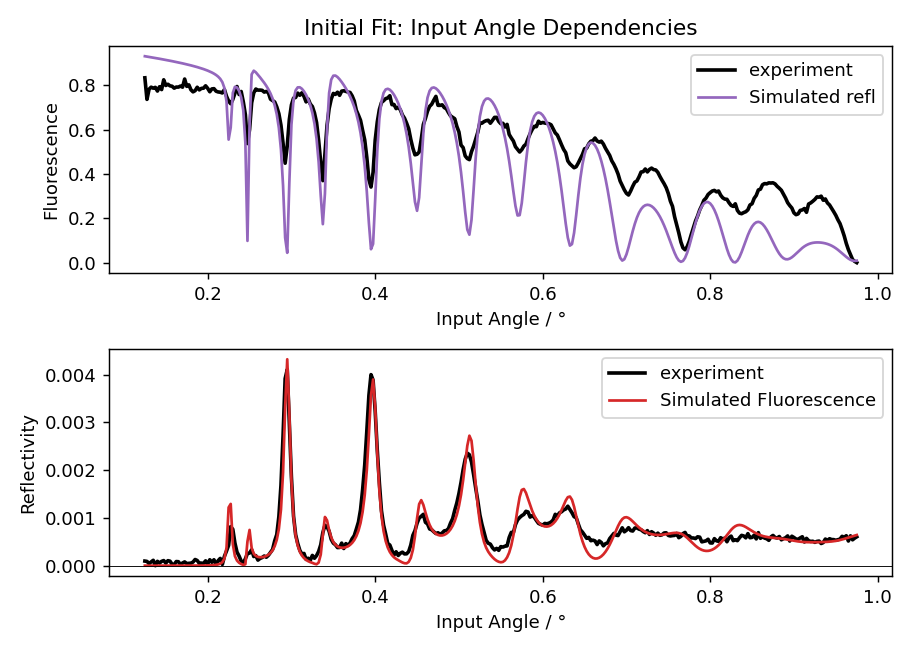

In [14]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


<IPython.core.display.Javascript object>


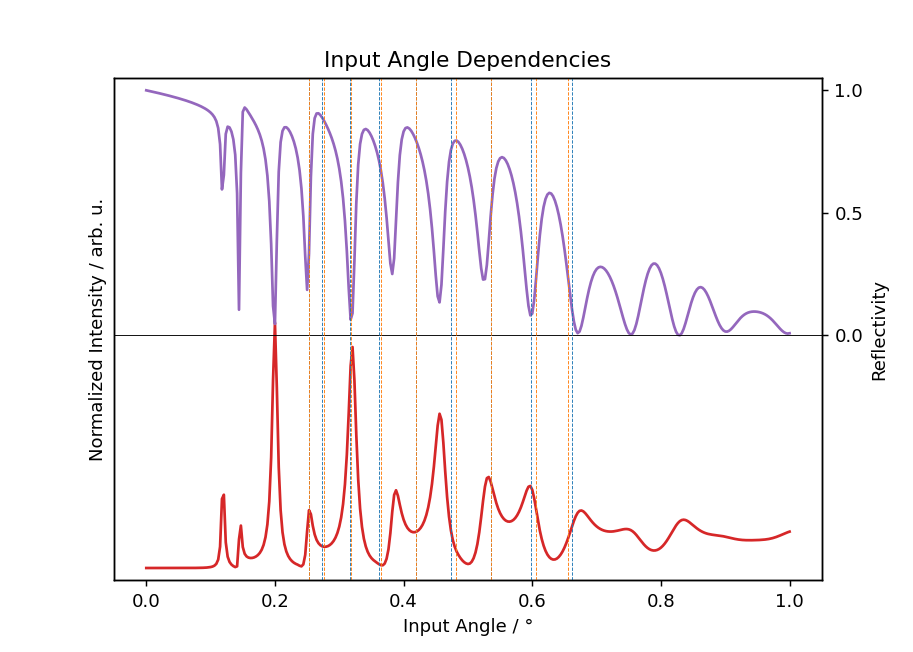

In [15]:



###################################################
##### Diode trace plots
###################################################
plt.figure(figsize=(7, 5))
ax1 = plt.gca()
plt.ylabel('Normalized Intensity / arb. u.')
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C4-',
         label='Simulated Reflectivity')  # dummy plots for legend
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C0--',
         label='Measured Reflectivity')

plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)), c='C3',
         label='Simulated Fluorescence')
data_shift = 0

# plt.ylim(None,6)
plt.xlabel('Input Angle / °')
plt.title(f'Input Angle Dependencies')
plt.yticks([])
plt.ylim(None, 2)

ax2 = plt.gca().twinx()
plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.reflectivity)[0,:]), 'C4-', label='Simulated refl')
plt.ylabel('Reflectivity')
plt.ylim(-1, None)
plt.yticks([0, 0.5, 1])
plt.axhline(c='k', lw=.5)

mode_angles = [.253, .2725, .317, .3625, .420, .474, .536, .598, .662]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C0', ls='--')
mode_angles = [.253, .276, .318, .365, .420, .482, .536, .606, .655]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C1', ls='--')




In [16]:
cavity.solution.incident_field_amplitude.shape

(1, 341, 18)

<IPython.core.display.Javascript object>


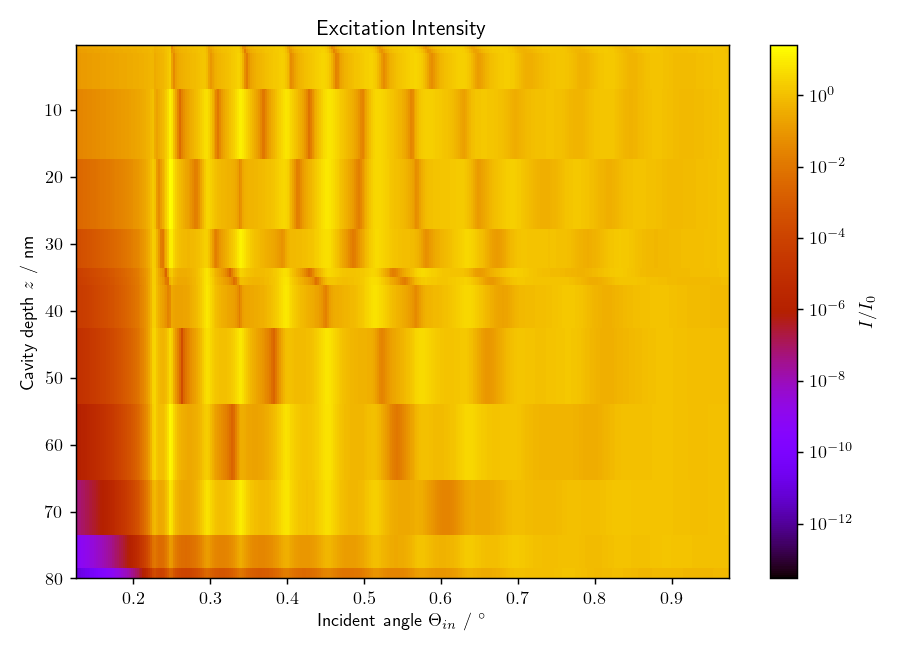

(80.0, 0.29250000000000004)

In [17]:

mpl.rcParams['text.usetex'] = True

plt.figure(figsize = (7,5))
plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),my_problem.z_axis*1e9, xlf.abs2(cavity.solution.incident_field_amplitude[0,:,:]).T,\
               cmap = 'gnuplot', norm = mpl.colors.LogNorm(),shading = 'nearest')

plt.ylabel('Cavity depth $z$ / nm')
plt.xlabel('Incident angle $ { \Theta}_{in}$ / $^\circ$')
plt.title('Excitation Intensity')
plt.colorbar(label='$I / I_0$')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylim(80,None)


<IPython.core.display.Javascript object>


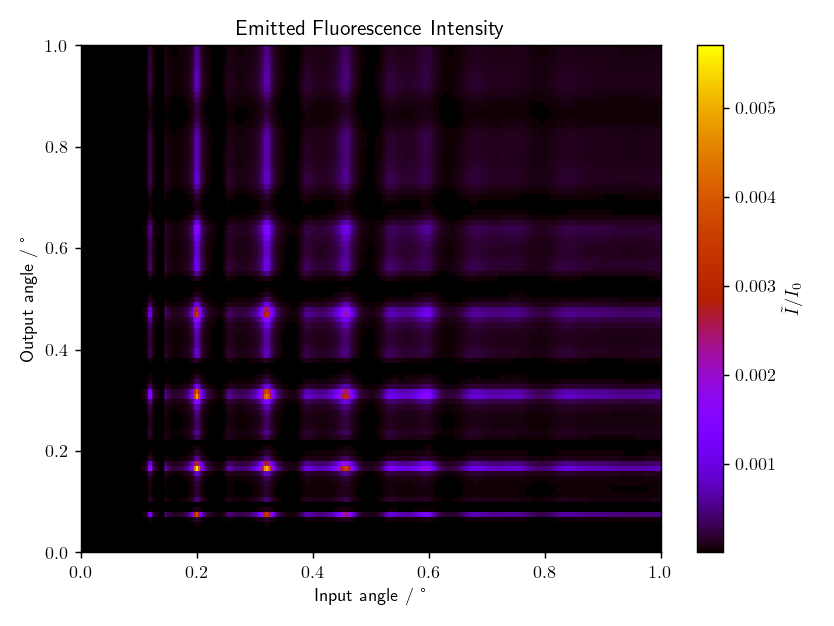

<IPython.core.display.Javascript object>


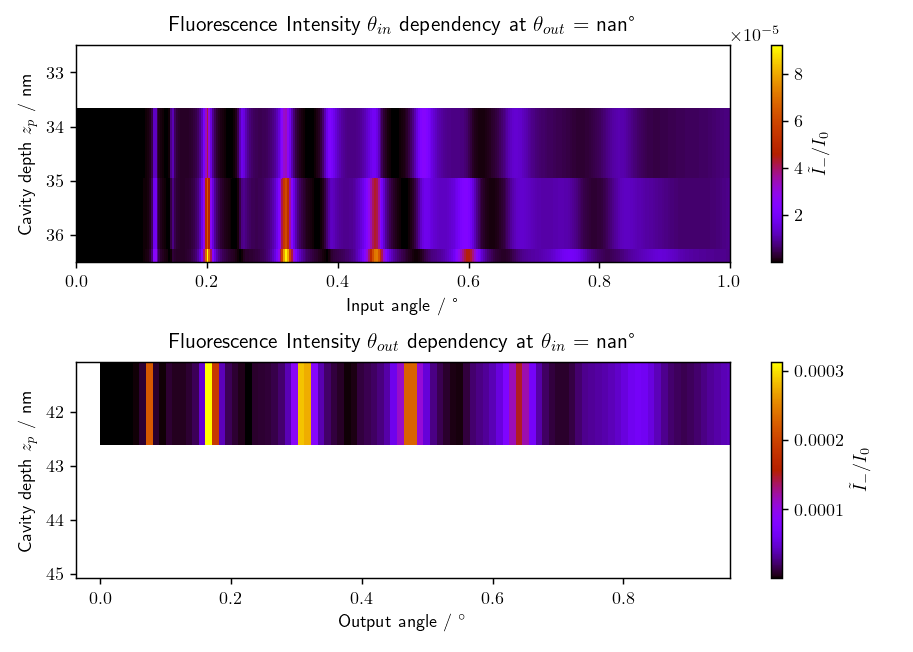

In [27]:


#####################################################
######### 2d Plot
################################################
plotmat = xlf.abs2(cavity.solution.fluorescence_emitted_amplitude[0,0,:,:])
#plotmat = xlf.abs2(np.nansum(cavity.solution.fluorescence_local_amplitude[0,0,:,:,:,0],2)) # sum over depth of non-propagated fluorescence
#plotmat = cplxsq(my_problem.fluor_emitted_from_z[:,:,:])
#plotmat = cplxsq(np.sum(my_problem.fluor_emitted_from_z[:,:,:],0))

plt.figure()
plt.pcolormesh(xlf.normmax(my_problem.angles_in),xlf.normmax(my_problem.angles_out),\
               plotmat.T, cmap = 'gnuplot', shading = 'nearest')#,vmax=4e3)#norm = mpl.colors.LogNorm(vmin = 0.005),
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()


#########################################


example_angle_in = xlf.deg2rad(0.3)
example_angle_in_index = np.argmin(np.abs(example_angle_in-my_problem.angles_in))

example_angle_out = xlf.deg2rad(0.342)
example_angle_out_index = np.argmin(np.abs(example_angle_out-my_problem.angles_out))



fig, axes = plt.subplots(2,1, figsize = (7,5))
plt.sca(axes[0])
plt.pcolormesh(xlf.normmax(my_problem.angles_in),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,:,example_angle_out_index,:]).T,shading = 'nearest',cmap = 'gnuplot')
plt.axvline(xlf.normmax(example_angle_in), ls = '--', lw= 1, c='grey')

plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Input angle / °')
plt.title(r'Fluorescence Intensity $\theta_{in}$ dependency at $\theta_{out}$ ='+f' {xlf.normmax(my_problem.angles_out[example_angle_out_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.sca(axes[1])
plt.pcolormesh(xlf.normmax(my_problem.angles_out),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,example_angle_in_index,:,:]).T,shading = 'nearest', vmax=None,cmap = 'gnuplot')#, norm = mpl.colors.LogNorm()
plt.axvline(xlf.normmax(example_angle_out), ls = '--', lw= 1, c='grey')
plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Output angle / $^\circ$')
plt.title(r'Fluorescence Intensity $\theta_{out}$ dependency at $\theta_{in}$ ='+f' {xlf.normmax(my_problem.angles_in[example_angle_in_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()



plt.show()